In [1]:
import numpy as np
from scipy import linalg
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.collections
import matplotlib.patches
import pg_fitter_tools as fit
import sk_geo_tools as geo
import cv2
import re
from collections import Counter

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
#%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [4]:
focal_length = np.array([2.760529621789217e+03, 2.767014510543478e+03])
principle_point = np.array([1.914303537872458e+03, 1.596386868474348e+03])
radial_distortion = np.array([-0.2398, 0.1145])
tangential_distortion = [0, 0]
camera_matrix = fit.build_camera_matrix(focal_length, principle_point)
distortion = fit.build_distortion_array(radial_distortion, tangential_distortion)

In [5]:
camera_r = 1100.
camera_z = 0.
n_cameras = 50
camera_phis = np.array([np.pi*i*2./n_cameras for i in range(n_cameras)])
camera_positions = np.column_stack((
    camera_r*np.sin(camera_phis),
    camera_r*np.cos(camera_phis),
    np.repeat(0, n_cameras)))
camera_directions = np.column_stack((
    np.sin(camera_phis),
    np.cos(camera_phis),
    np.repeat(0., n_cameras)))
camera_rolls = np.repeat(0., n_cameras)
camera_rotations, camera_translations = fit.camera_poses(camera_positions, camera_directions, camera_rolls, 2)

In [6]:
pmt_locations = fit.read_3d_feature_locations("parameters/SK_all_PMT_locations.txt", delimiter="\t")
# pmt_locations = fit.read_3d_feature_locations("parameters/SK_simtest_PMT_locations.txt", delimiter=" ")
bolt_count = 24
bolt_locations = geo.get_bolt_locations_barrel(pmt_locations, bolt_count)
ring_positions = {k: np.mean([bolt_locations[re.sub(r"-00$", "-" + str(i + 1).zfill(2), k)] for i in range(0, 24, 24//bolt_count)], axis=0)
                           for k in pmt_locations.keys()}

In [7]:
def setup_bolt_simulation(feature_positions, image_feature_locations, focal_length, principle_point, radial_distortion, seed_error=1):
    seed_feature_positions = {}
    for i, f in feature_positions.items():
        seed_feature_positions[i] = np.random.normal(f, seed_error)
    fitter = fit.PhotogrammetryFitter(image_feature_locations, seed_feature_positions, focal_length, principle_point, radial_distortion)
    return fitter

In [8]:
def run_bolt_fit(fitter, bolt_positions, xtol=1e-5):
    reco_cam_rotations, reco_cam_translations, reprojected_points = fitter.estimate_camera_poses()
    reco_cam_rotations, reco_cam_translations, reco_locations = fitter.bundle_adjustment(reco_cam_rotations, reco_cam_translations, xtol=xtol)
    
    reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(bolt_positions, reco_locations)
    print("mean reconstruction error:", linalg.norm(reco_errors, axis=1).mean())
    print("max reconstruction error:", linalg.norm(reco_errors, axis=1).max())

    reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(reco_cam_rotations, reco_cam_translations)
    cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
    cam_positions_translated = reco_cam_positions - translation
    cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

    reco_bolt_positions = reco_positions_dict(reco_transformed, fitter.feature_index)
    position_errors = linalg.norm(reco_errors, axis=1)

    return reco_bolt_positions, position_errors

In [9]:
def reco_positions_dict(reco_positions, feature_index):
    return {f: reco_positions[i] for f, i in feature_index.items()}

In [10]:
def get_full_ring_pmts(bolt_keys, pmt_keys, bolt_count):
    return [p for p in pmt_keys if all(re.sub(r"-00$", "-" + str(i + 1).zfill(2), p) in bolt_keys for i in range(0, 24, 24//bolt_count))]

In [11]:
def get_ring_positions(bolt_positions, pmt_keys, bolt_count):
    return {k: np.mean([bolt_positions[re.sub(r"-00$", "-" + str(i + 1).zfill(2), k)] for i in range(0, 24, 24//bolt_count)], axis=0)
                           for k in pmt_keys}

In [12]:
def get_ring_orientations(bolt_positions, pmt_keys, bolt_count):
    ring_orientations = {}
    for k in pmt_keys:
        c, n = geo.fit_plane(np.array([bolt_positions[re.sub(r"-00$", "-" + str(b + 1).zfill(2), k)] for b in range(0, 24, 24//bolt_count)]))
        # flip normal if it is directed away from tank centre
        if np.dot(n,c) > 0:
            n = -n
        ring_orientations[k] = n
    return ring_orientations

In [13]:
def get_ring_centre_errors(reco_bolt_positions, ring_positions, bolt_count):
    full_ring_pmts = get_full_ring_pmts(reco_bolt_positions.keys(), ring_positions.keys(), bolt_count)
    reco_ring_positions = get_ring_positions(reco_bolt_positions, full_ring_pmts, bolt_count)
    errors = np.array([linalg.norm(reco_ring_positions[k] - ring_positions[k]) for k in full_ring_pmts])
    return errors

In [14]:
def get_ring_orientation_errors(reco_bolt_positions, ring_orientations, bolt_count):
    full_ring_pmts = get_full_ring_pmts(reco_bolt_positions.keys(), ring_positions.keys(), bolt_count)
    reco_orientations = get_ring_orientations(reco_bolt_positions, full_ring_pmts, bolt_count)
    errors = np.array([np.degrees(np.arccos(np.dot(reco_orientations[k], ring_orientations[k]))) for k in full_ring_pmts])
    return errors

In [15]:
def make_fig(title, xlabel, figsize=(8,6)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    fig.tight_layout()
    return fig, ax

In [16]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [17]:
def plot_reconstruction(reco_positions, cam_positions):
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(reco_positions[:,0], reco_positions[:,1], reco_positions[:,2], marker='^', label="Bolt", s=1)
    ax.scatter(cam_positions[:,0], cam_positions[:,1], cam_positions[:,2], marker='*', label="Camera", s=60)
    set_axes_equal(ax)
    plt.legend(loc=0)
    fig.tight_layout()

In [18]:
def plot_geometry(bolt_positions, pmt_positions, cam_positions):
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter([b[0] for b in bolt_positions.values()], [b[1] for b in bolt_positions.values()], [b[2] for b in bolt_positions.values()], marker='.', label="Bolt", s=1)
    ax.scatter([p[0] for p in pmt_positions.values()], [p[1] for p in pmt_positions.values()], [p[2] for p in pmt_positions.values()], marker='o', label="PMT", s=20)
    ax.scatter(cam_positions[:,0], cam_positions[:,1], cam_positions[:,2], marker='^', label="Camera", s=60)
    ax.set_xlabel("x [cm]")
    ax.set_ylabel("y [cm]")
    ax.set_zlabel("z [cm]")
    plt.legend(loc=0)
    fig.tight_layout()

In [19]:
bolt_counts = [3, 4, 6, 8, 12, 24]
bolt_position_errors = {b: {} for b in bolt_counts}
ring_position_errors = {b: {} for b in bolt_counts}
ring_orientation_errors = {b: {} for b in bolt_counts}

# Simulation with 3 bolts

Feature in image counts: Counter({4: 3989, 5: 361})


/home/prouse/work/PhotogrammetryAnalysis/pg_fitter_tools.py:203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


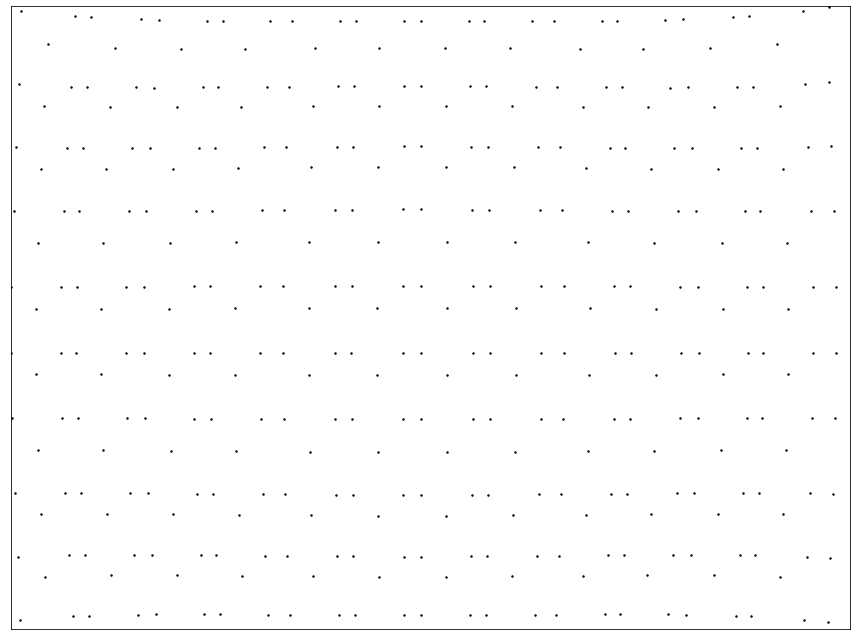

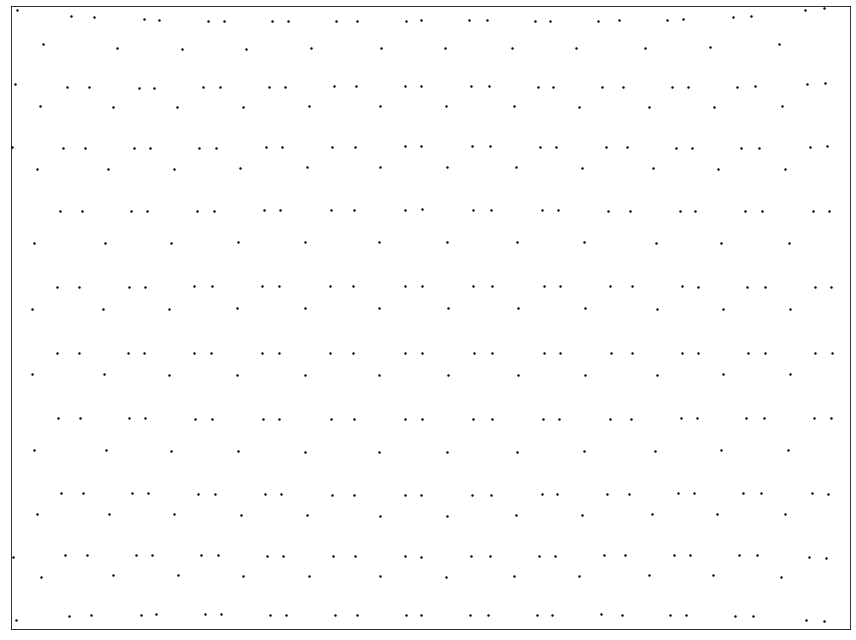

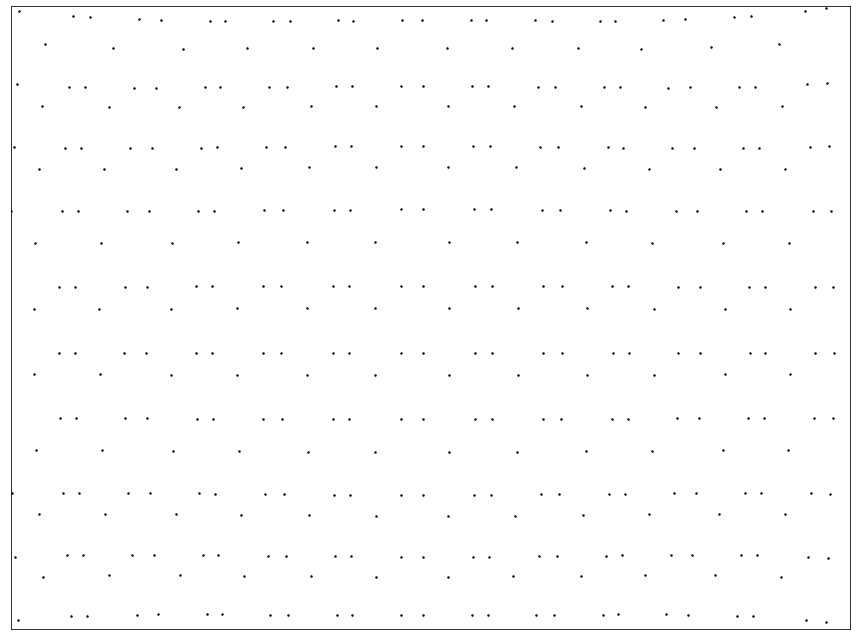

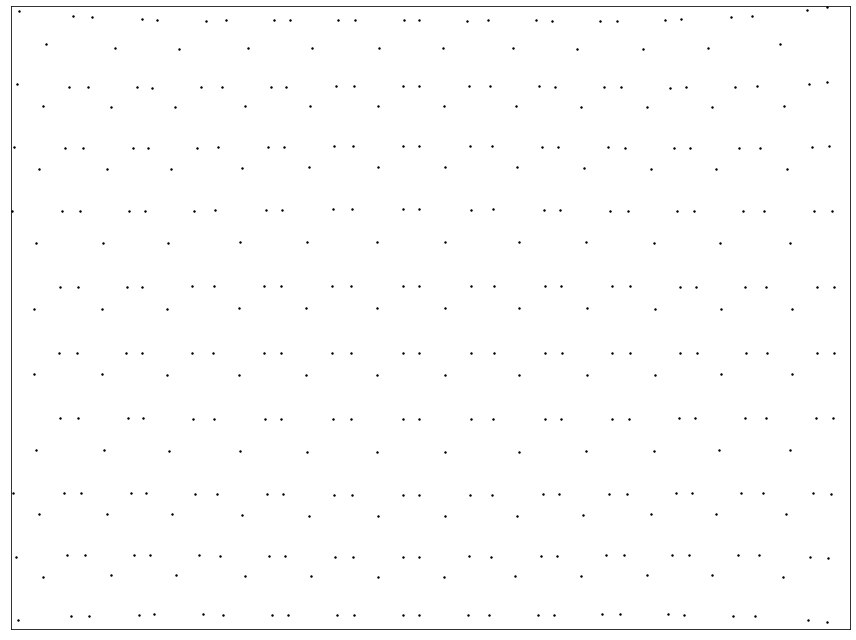

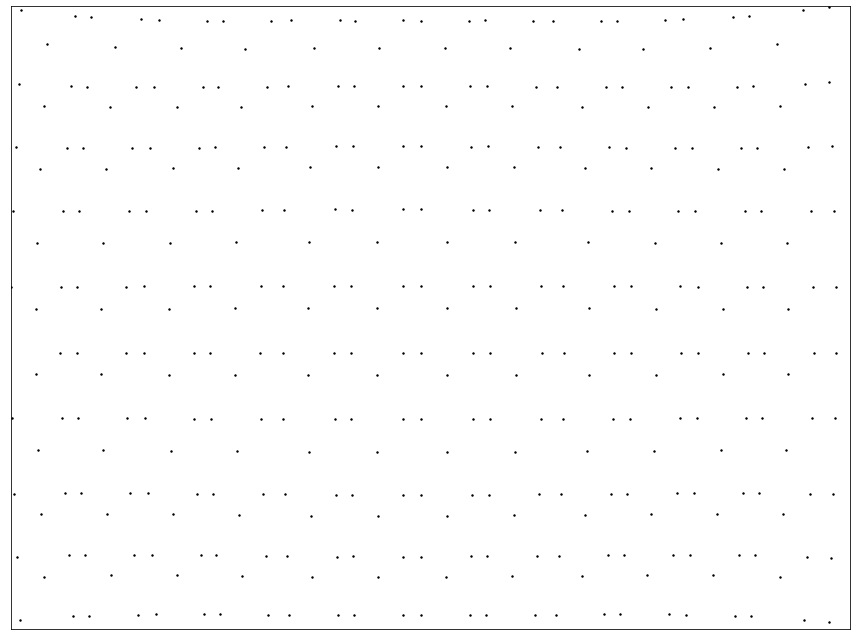

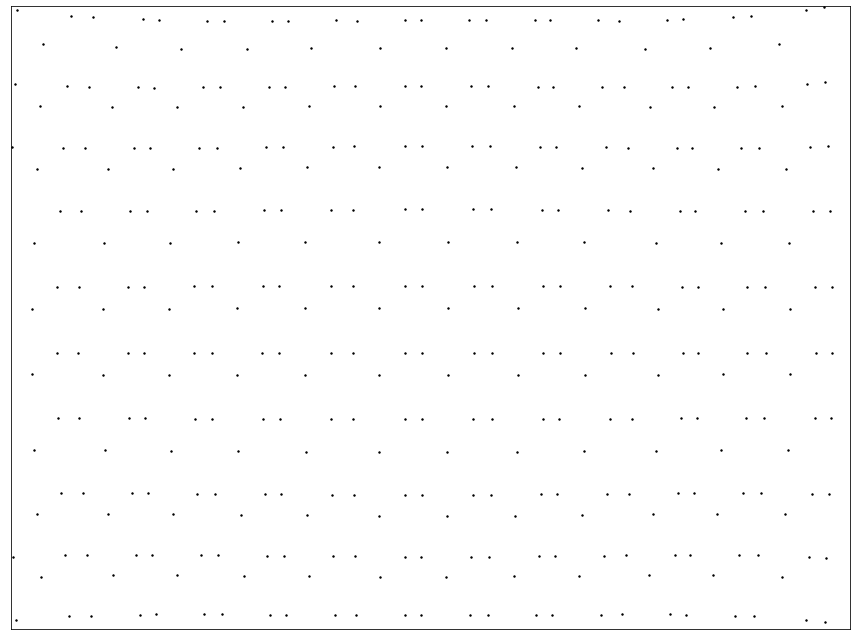

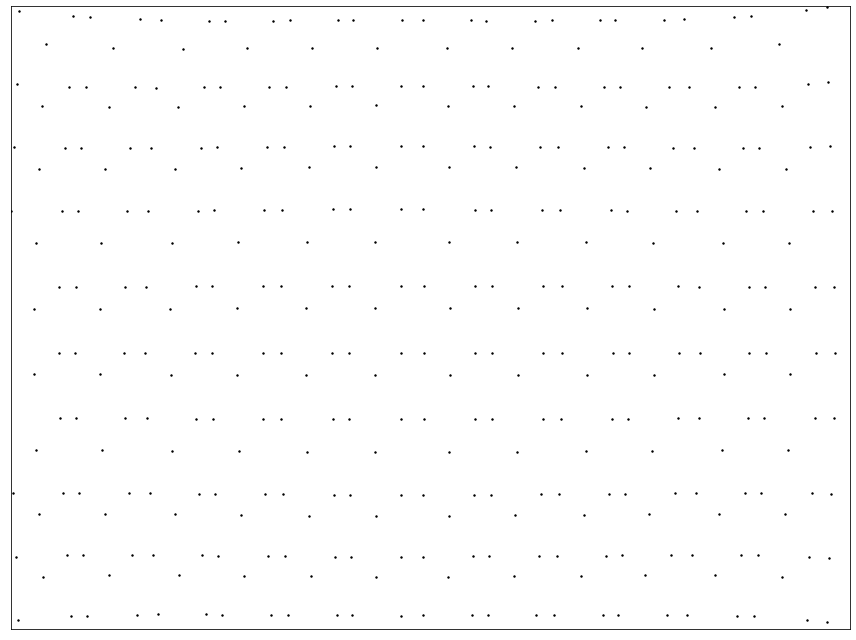

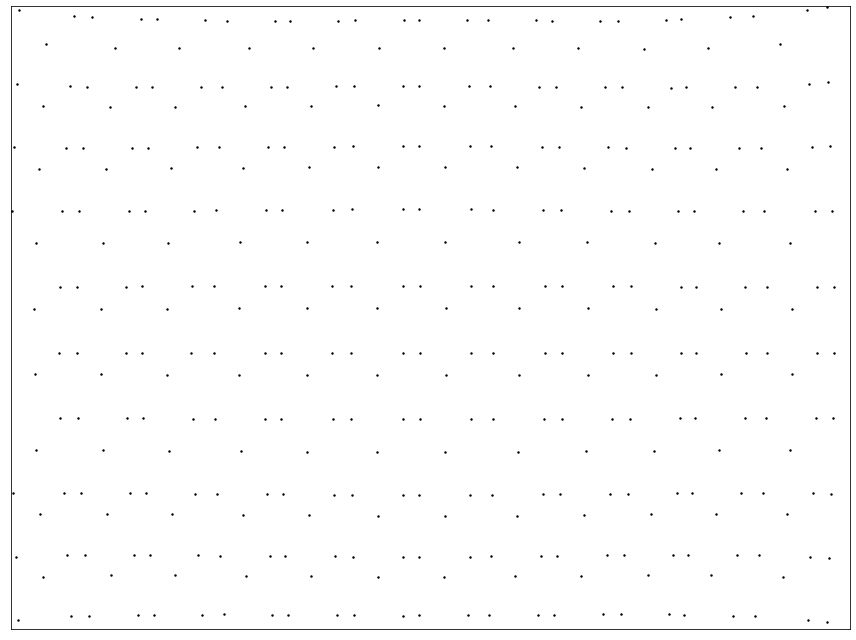

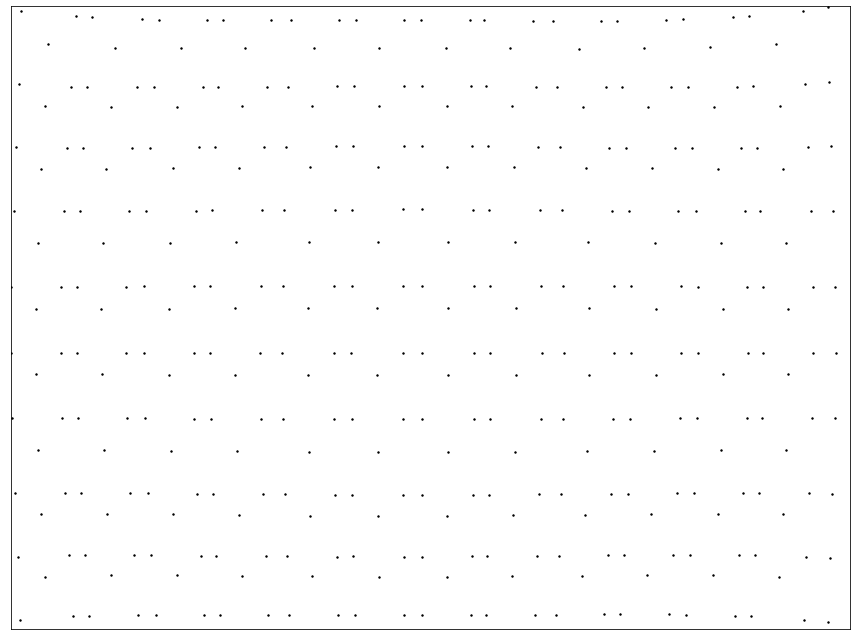

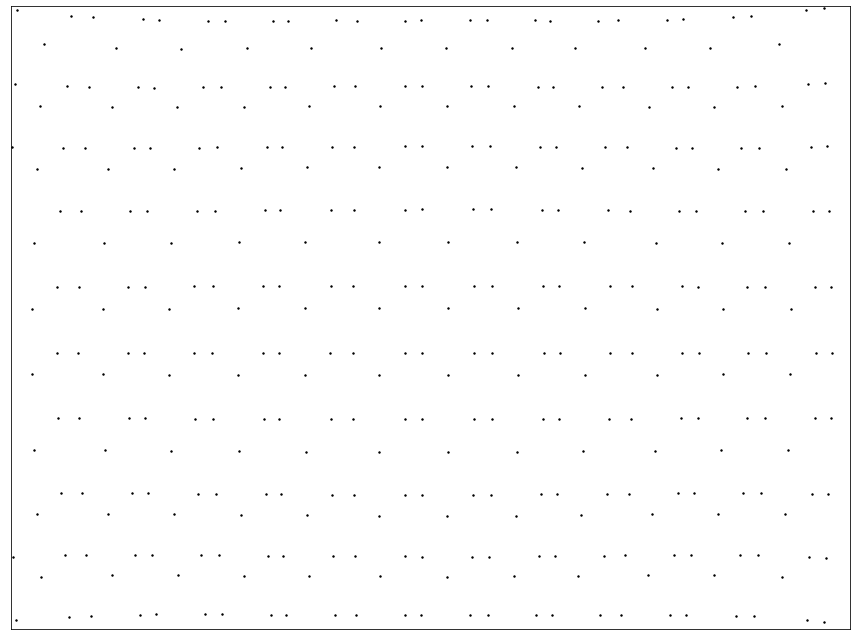

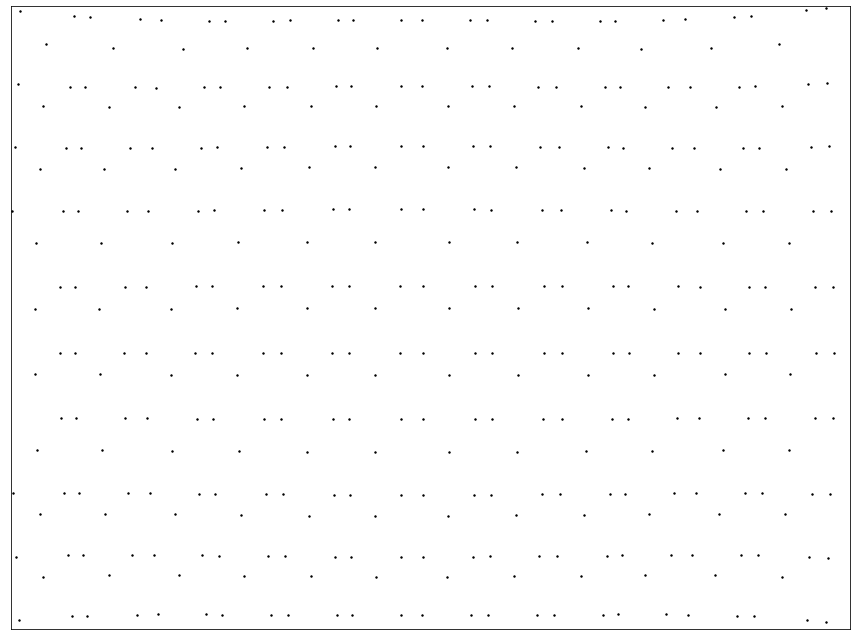

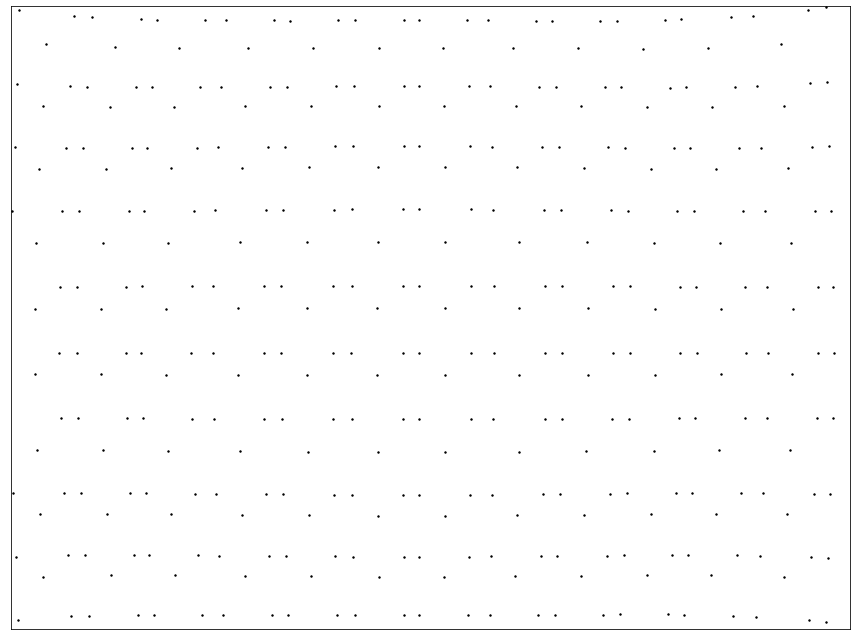

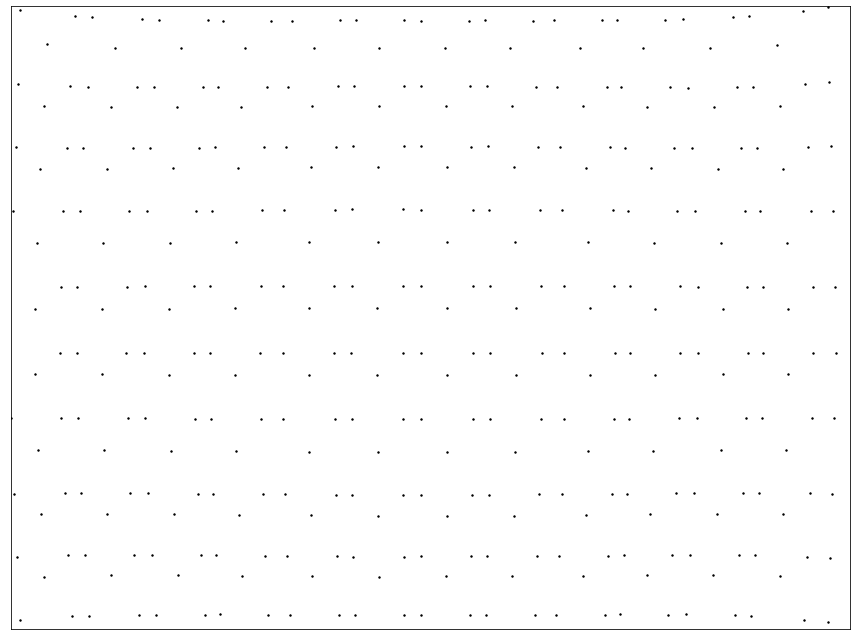

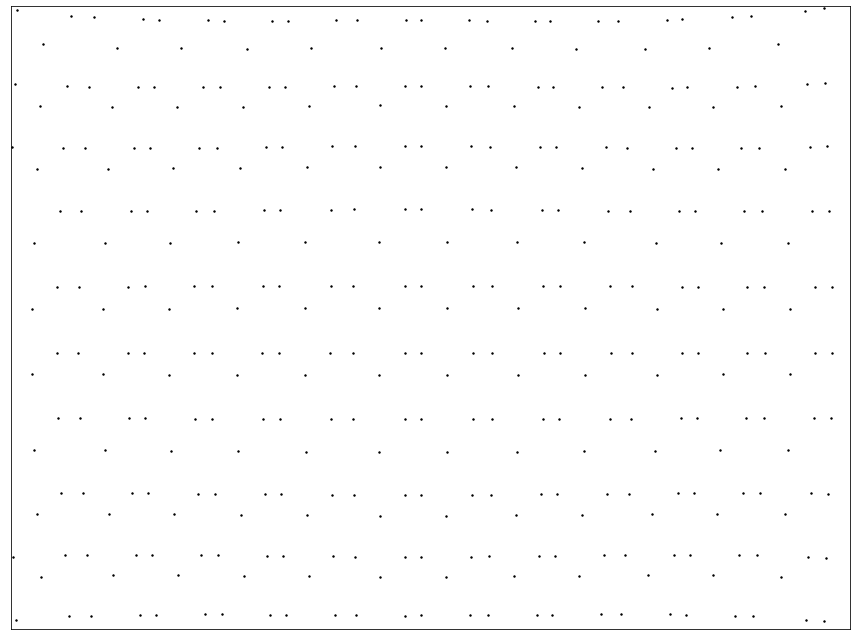

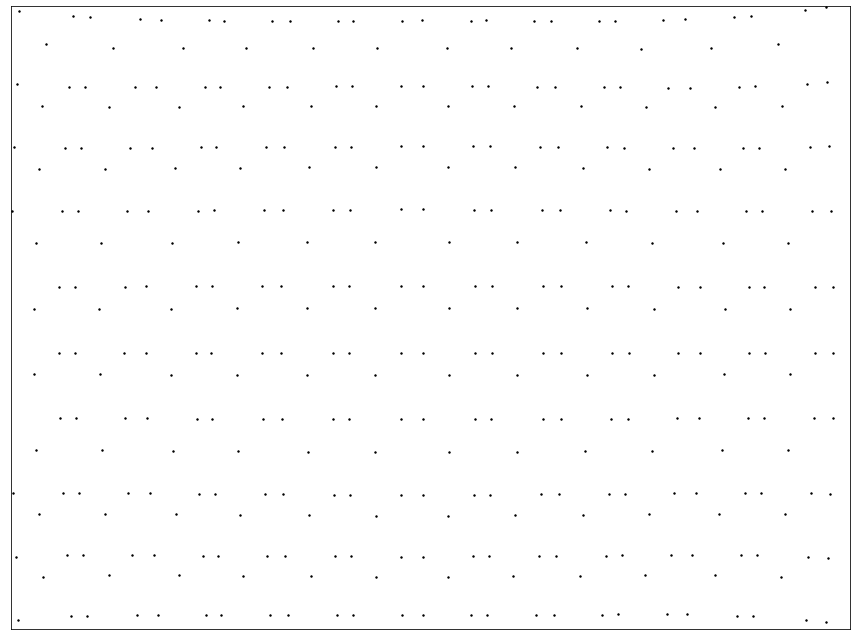

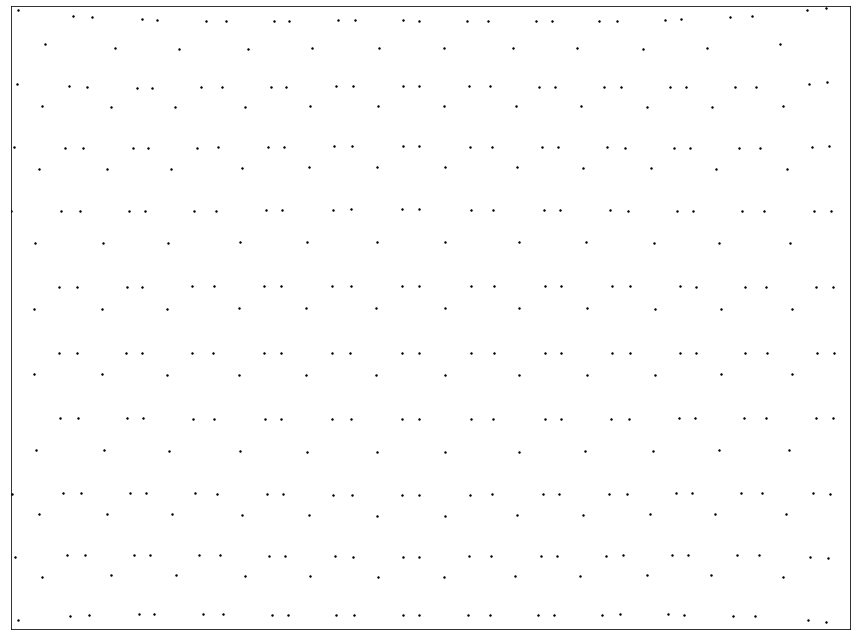

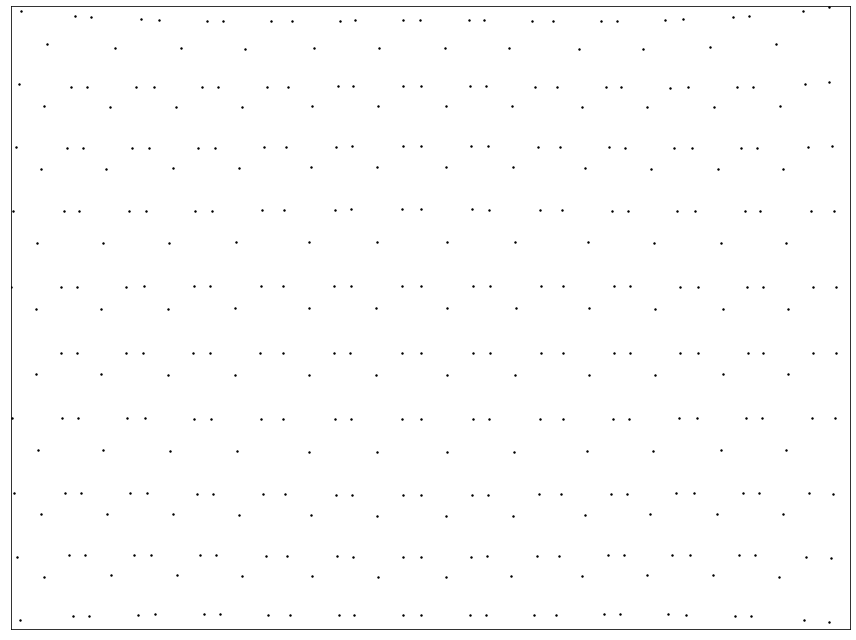

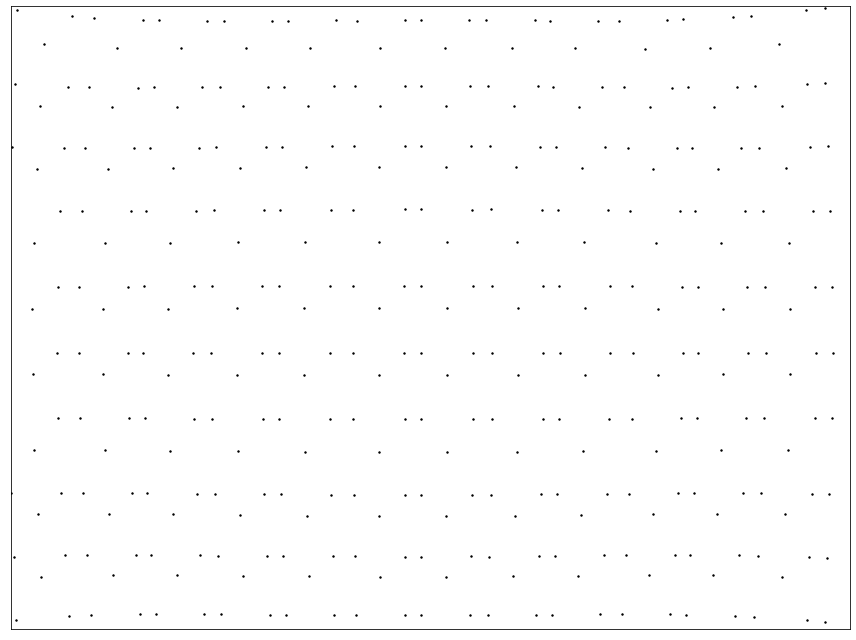

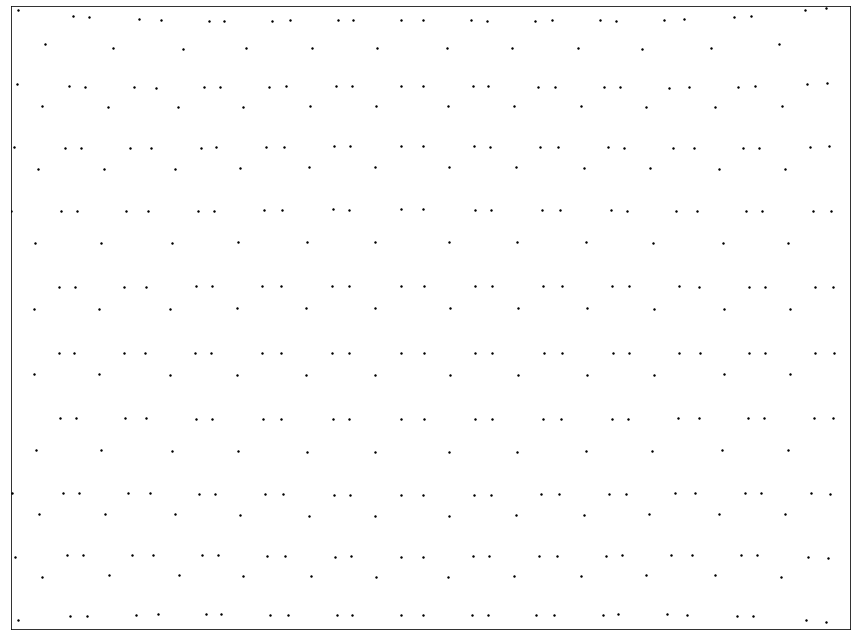

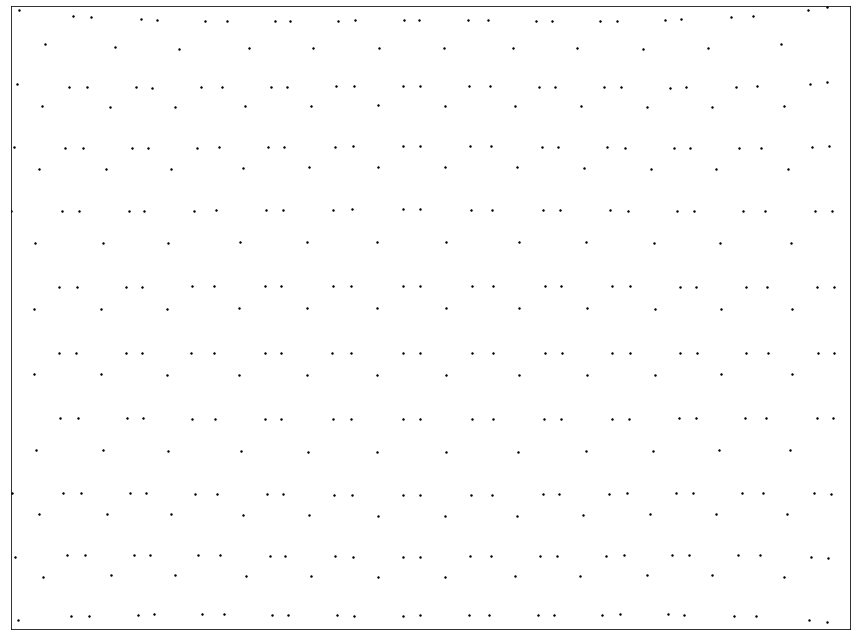

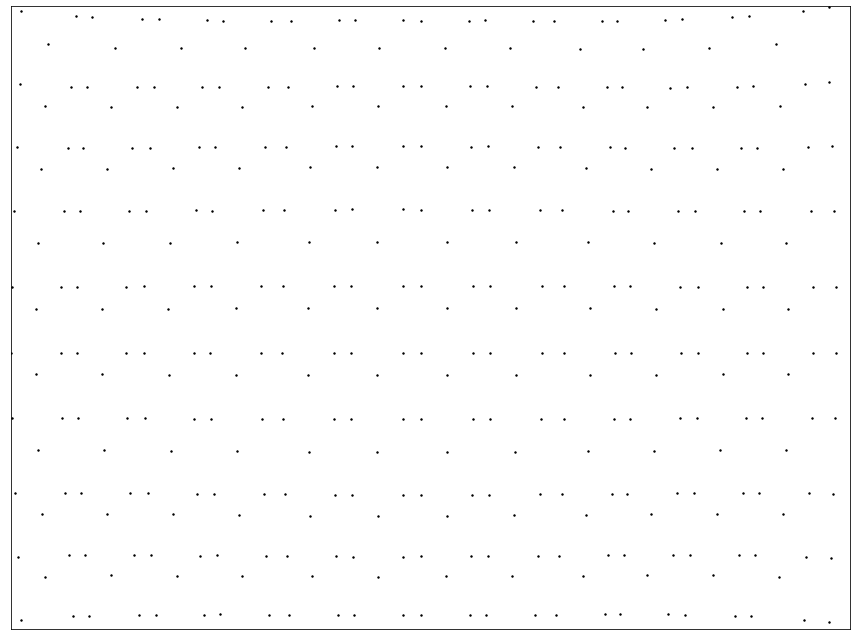

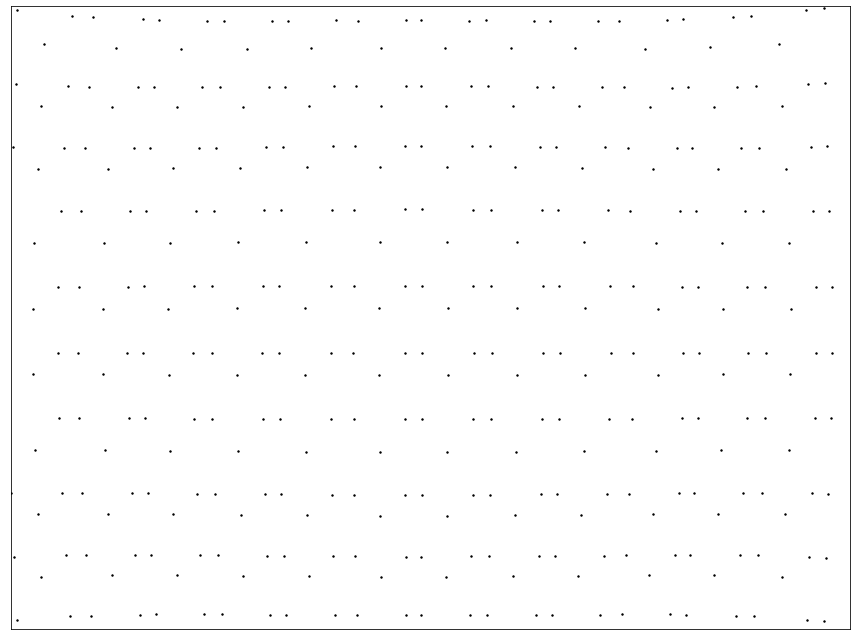

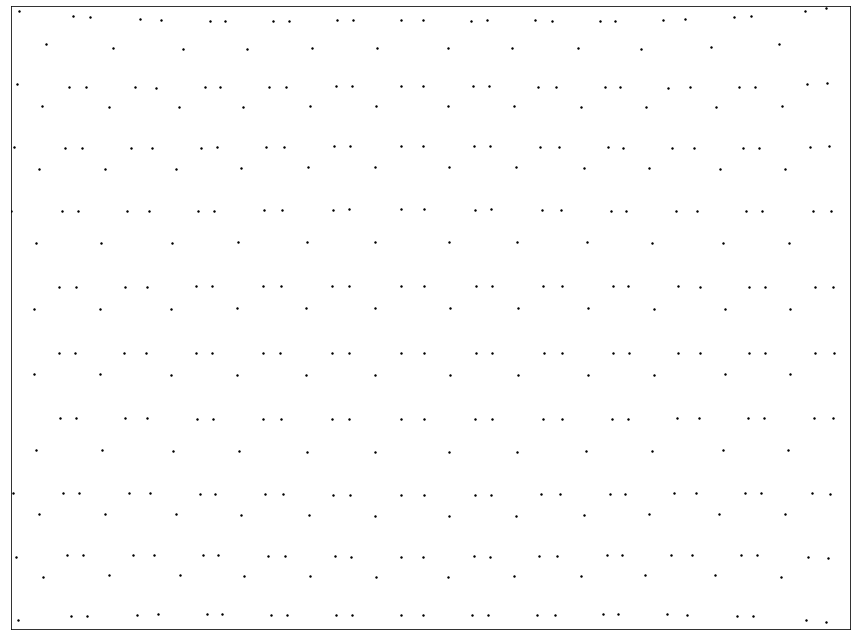

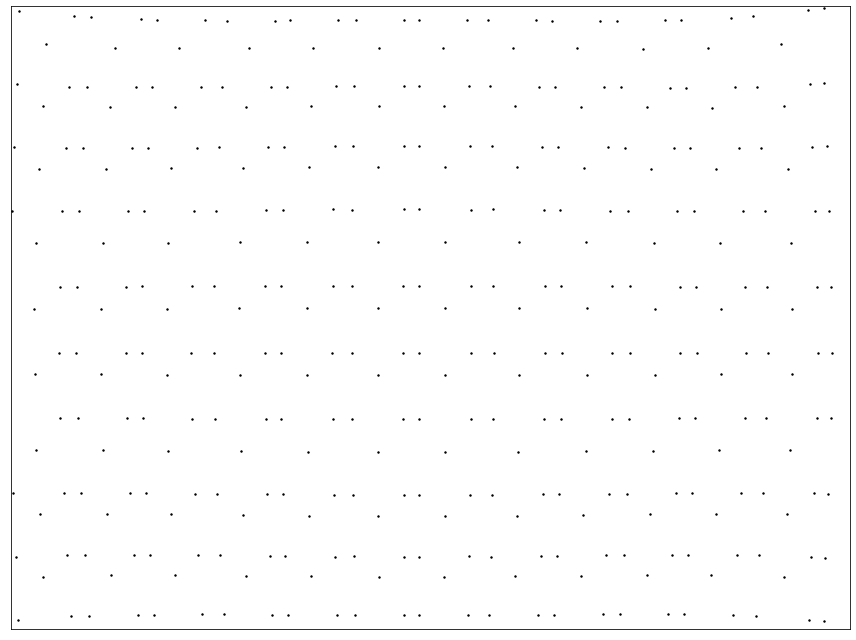

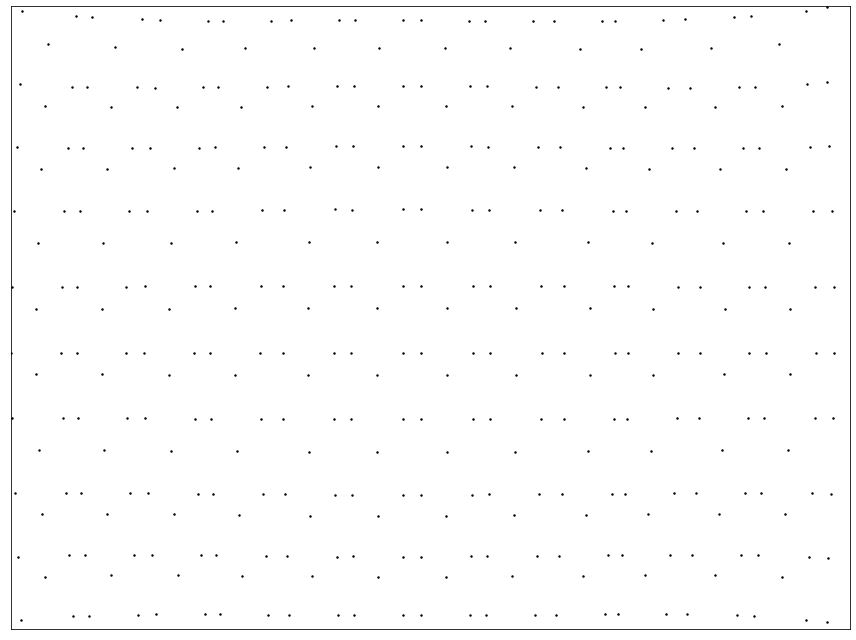

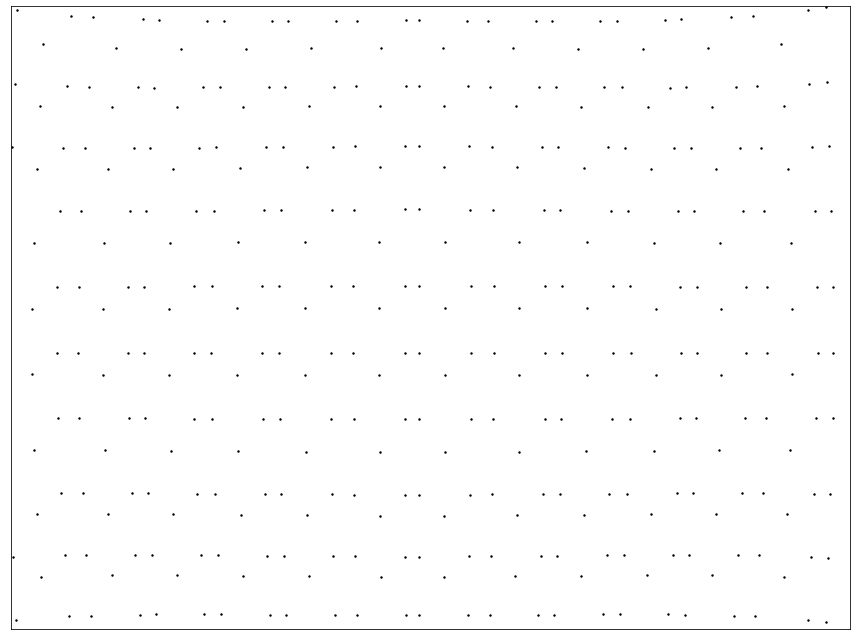

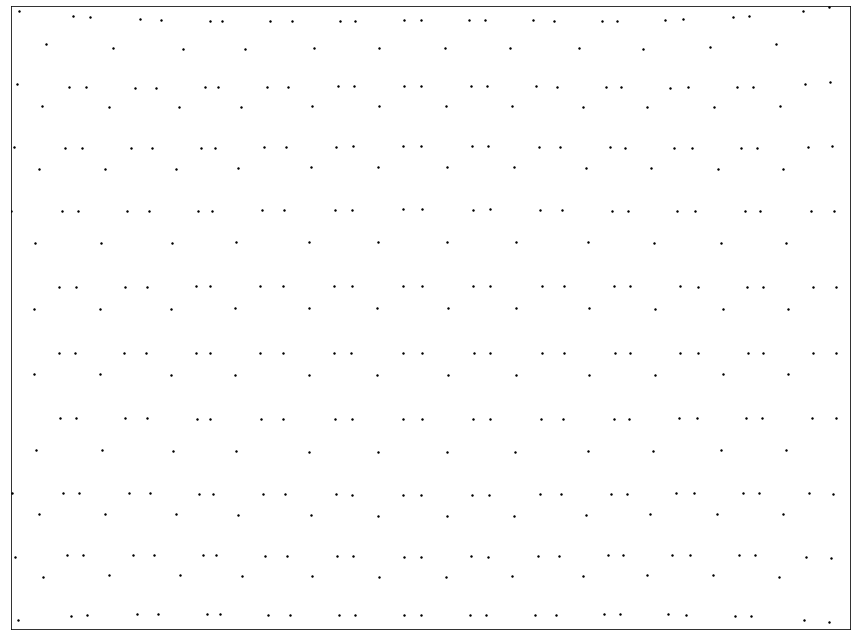

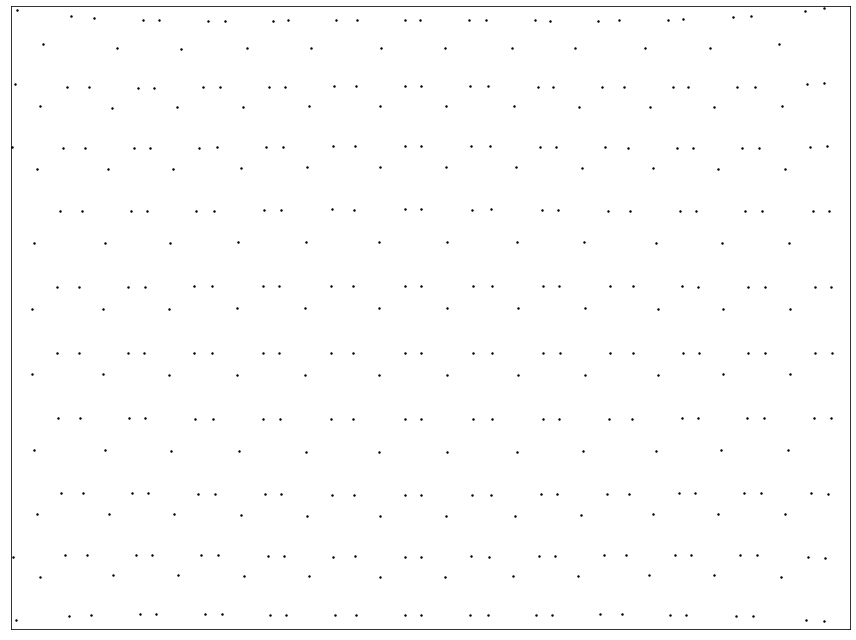

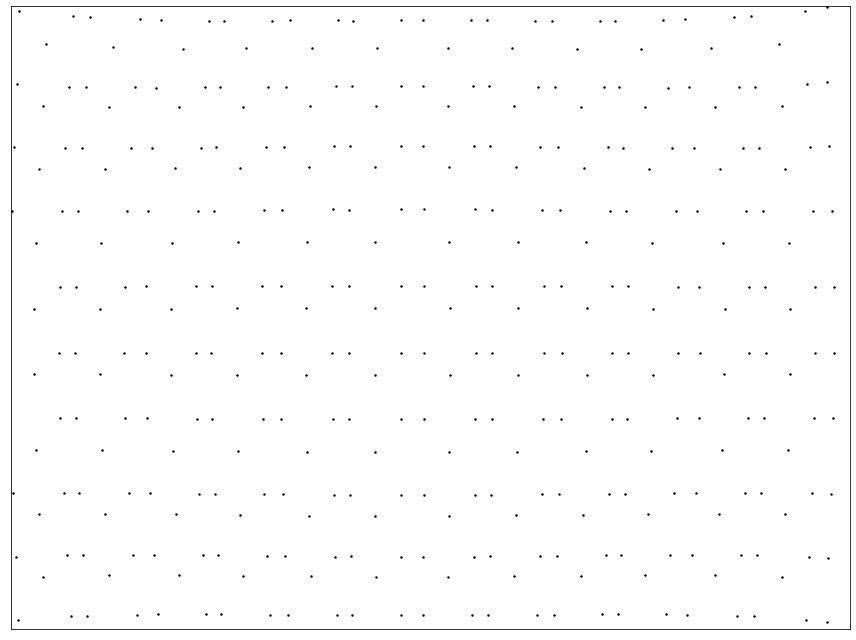

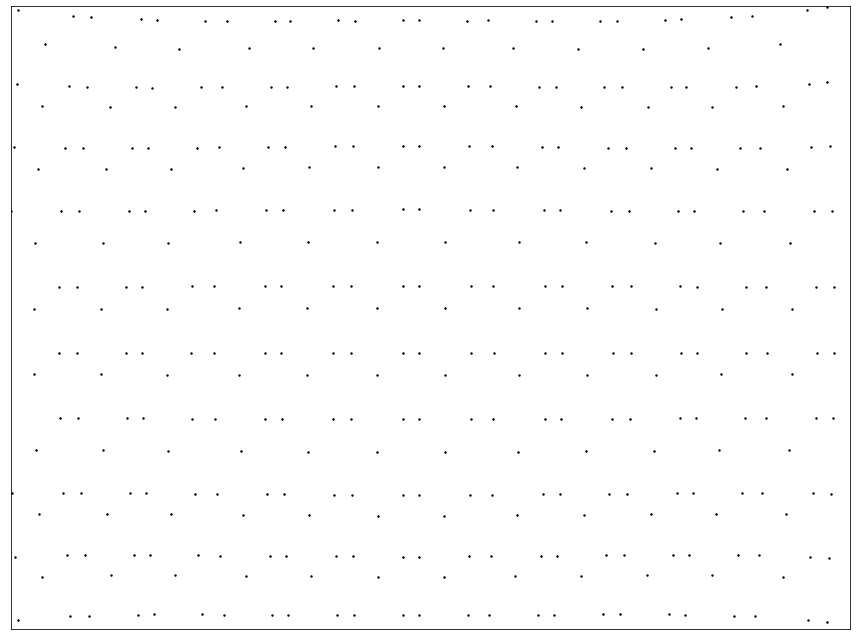

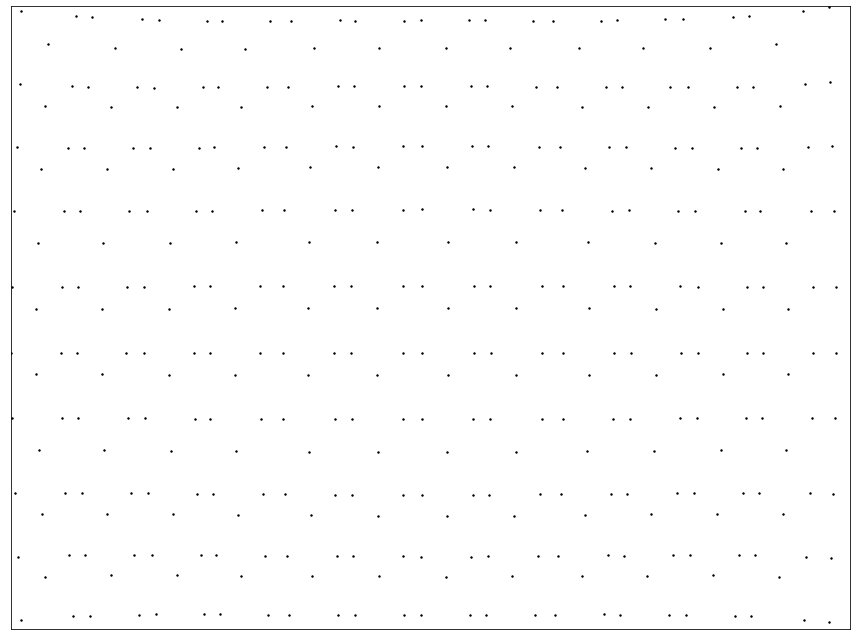

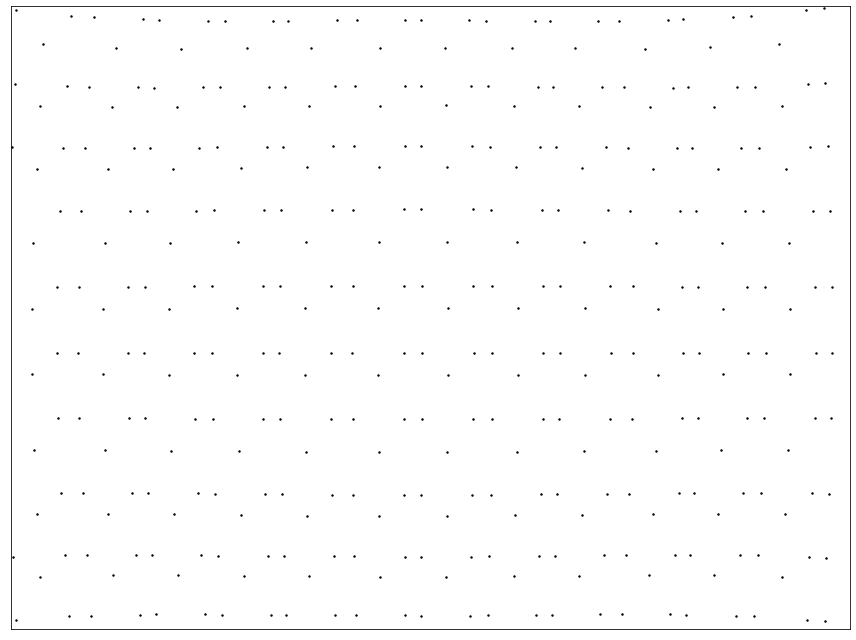

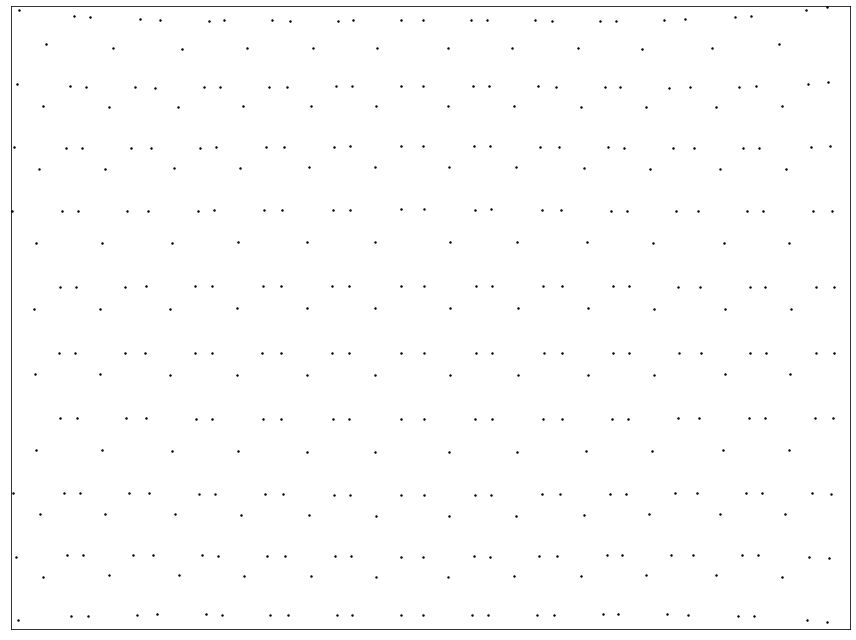

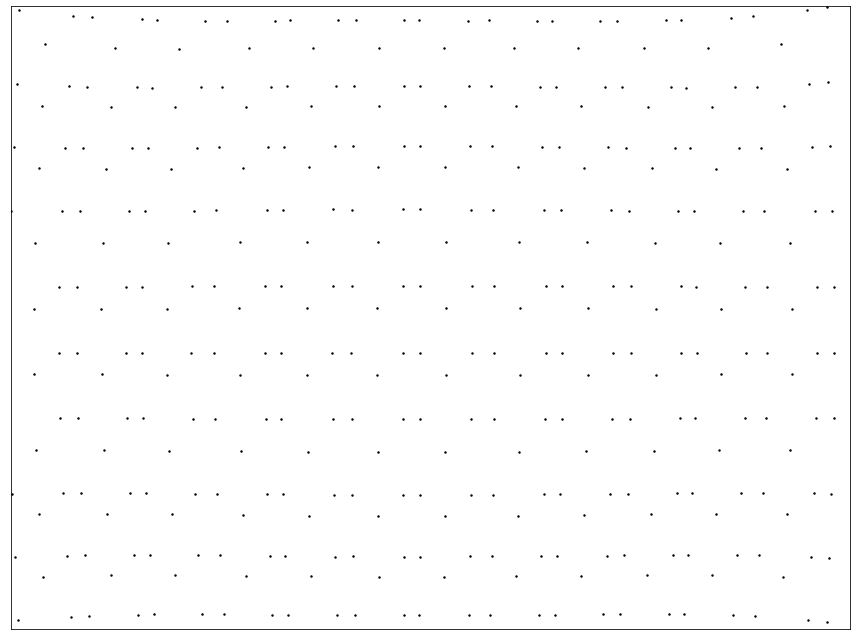

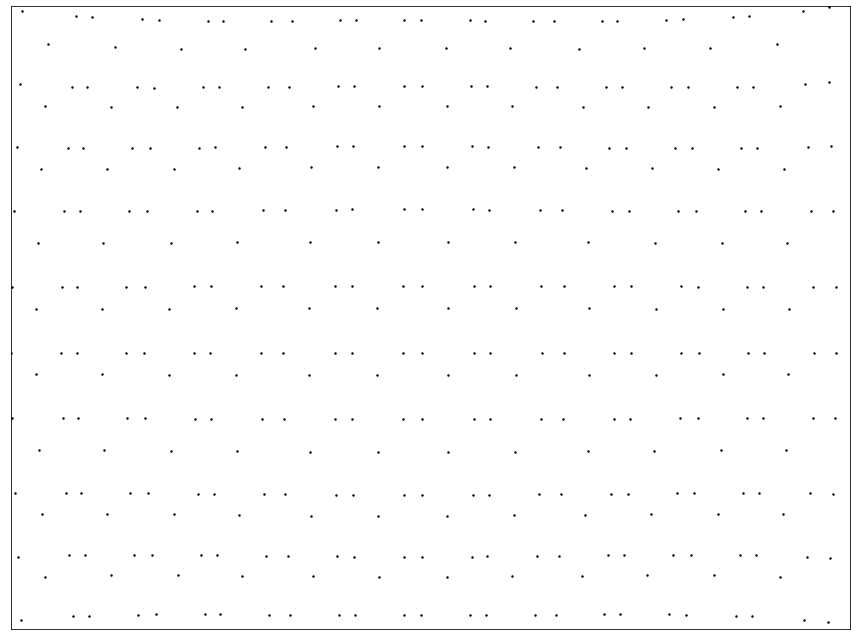

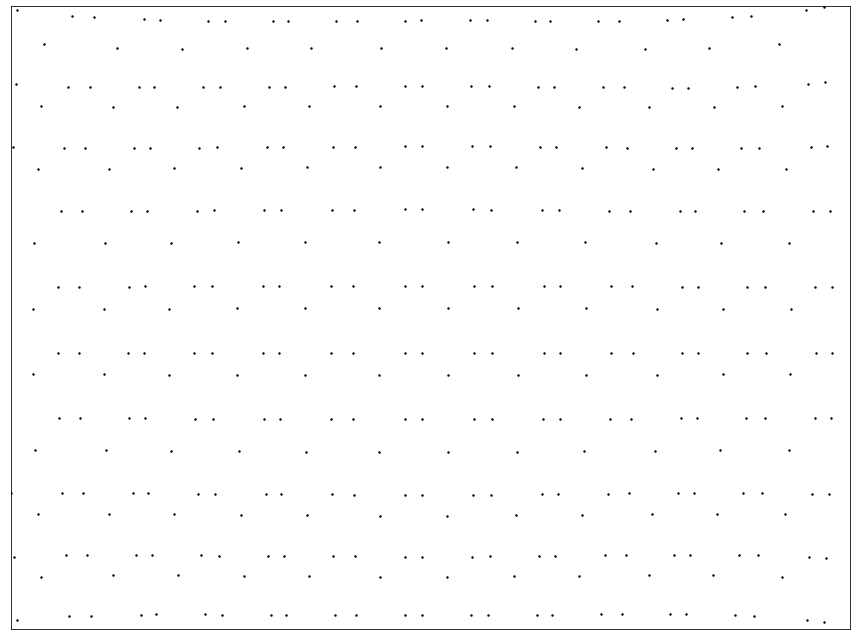

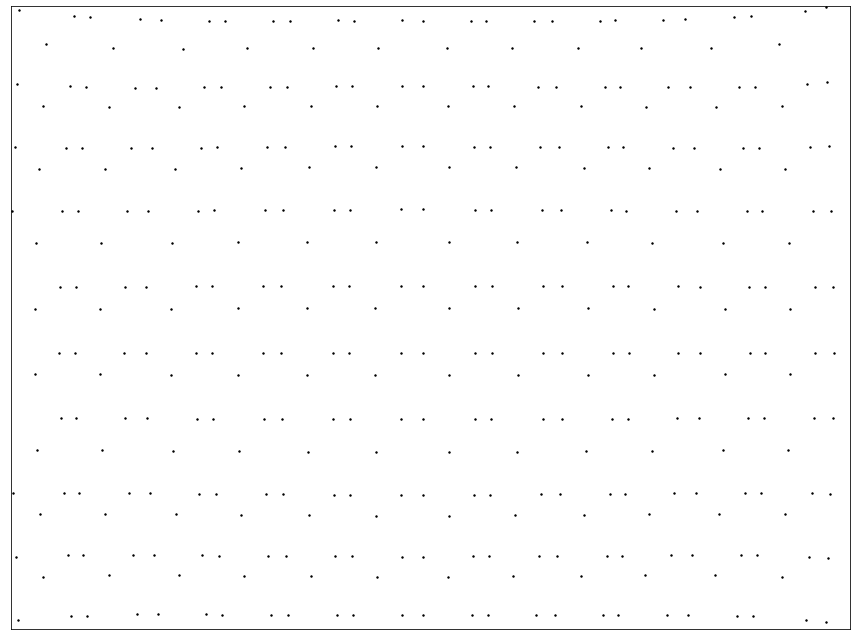

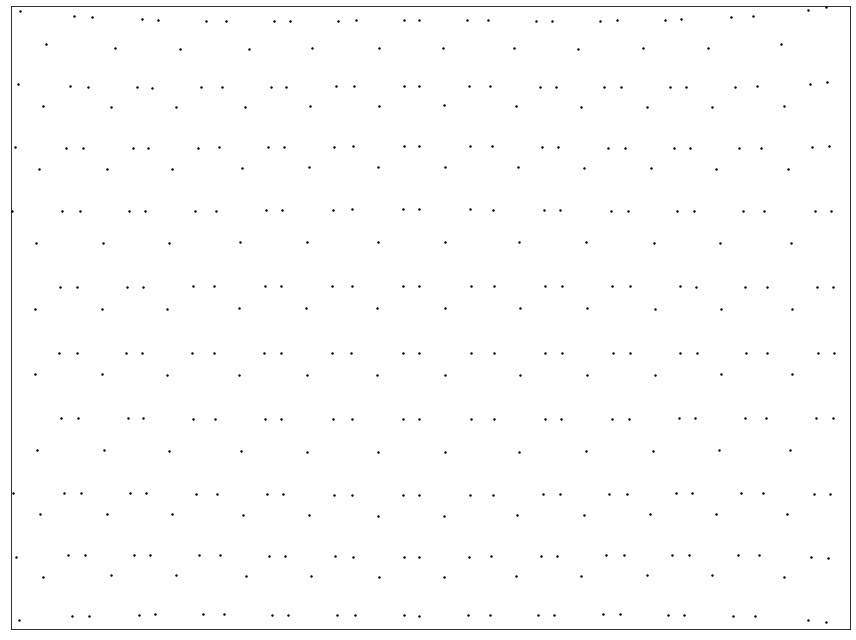

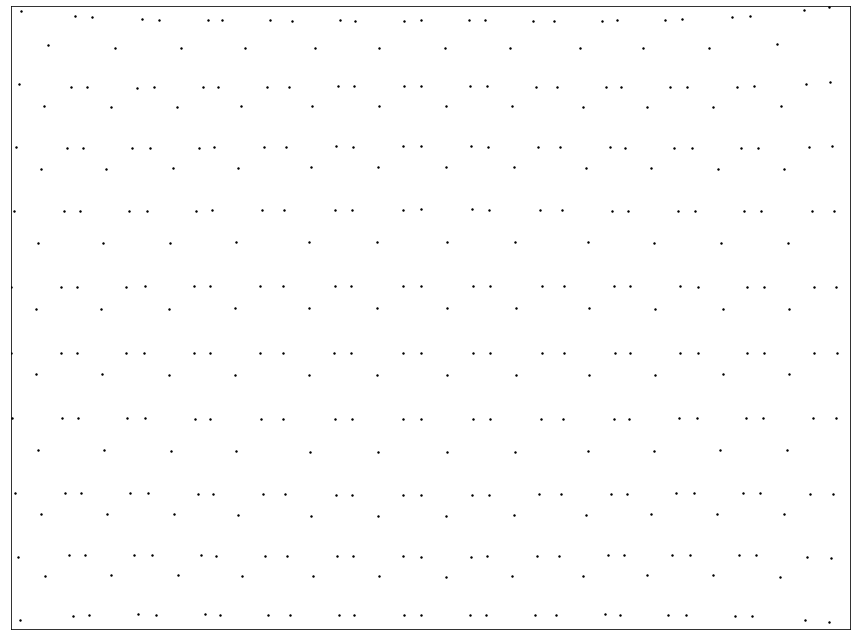

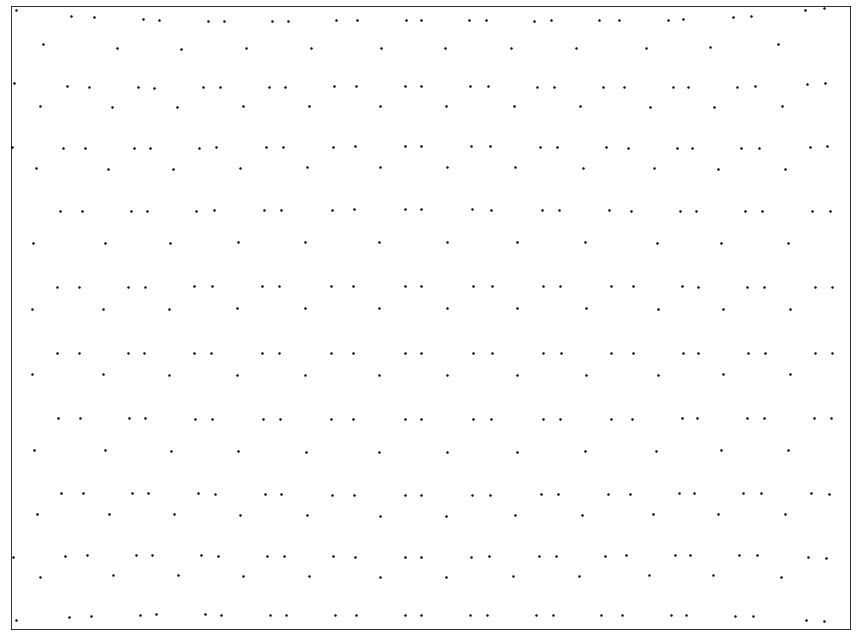

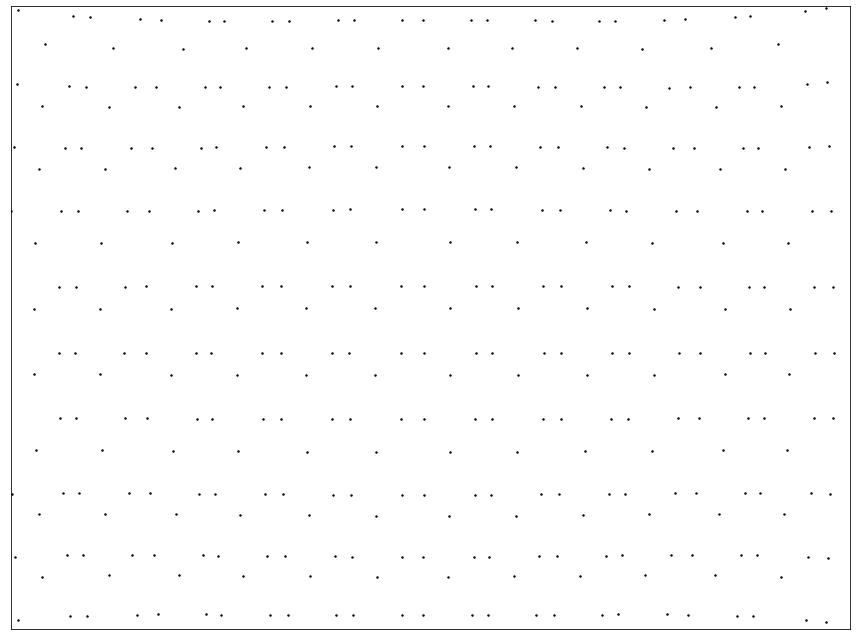

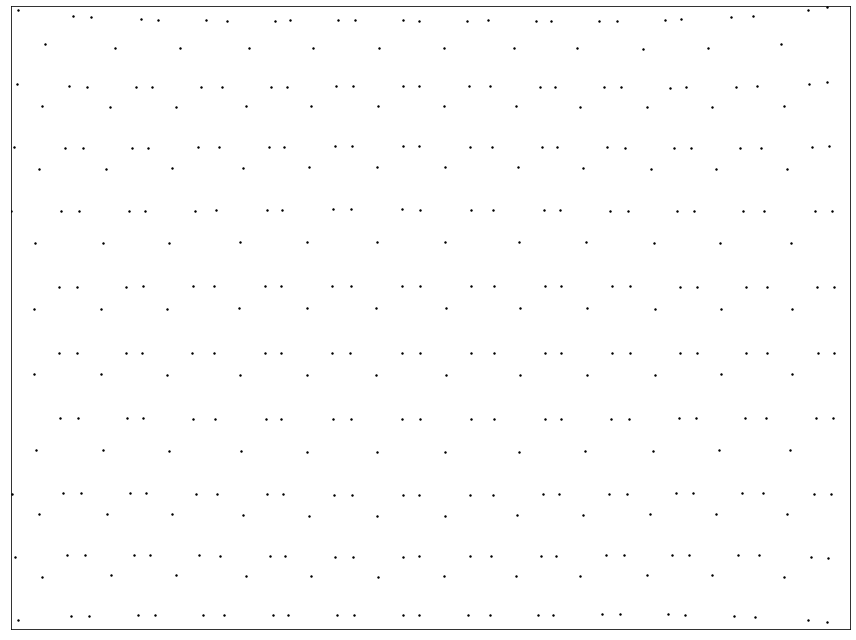

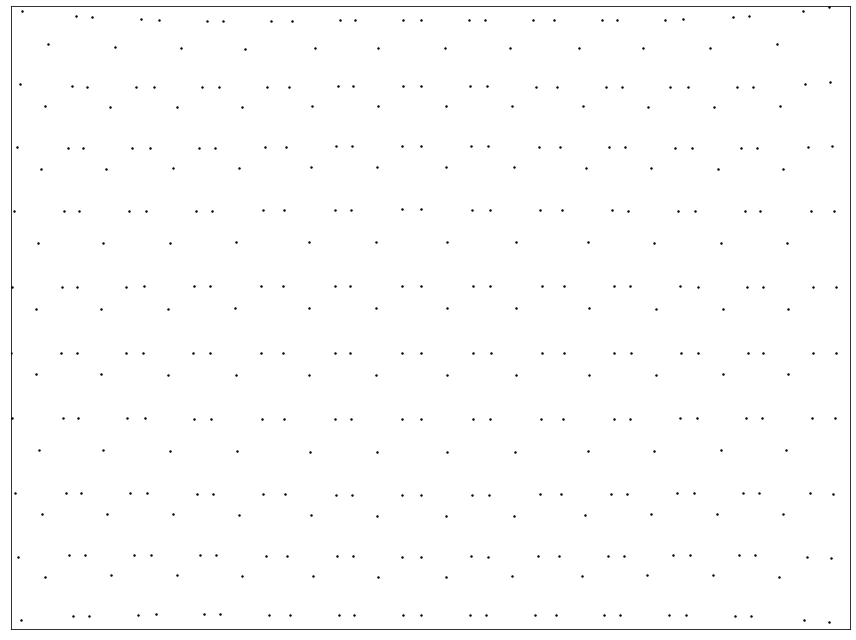

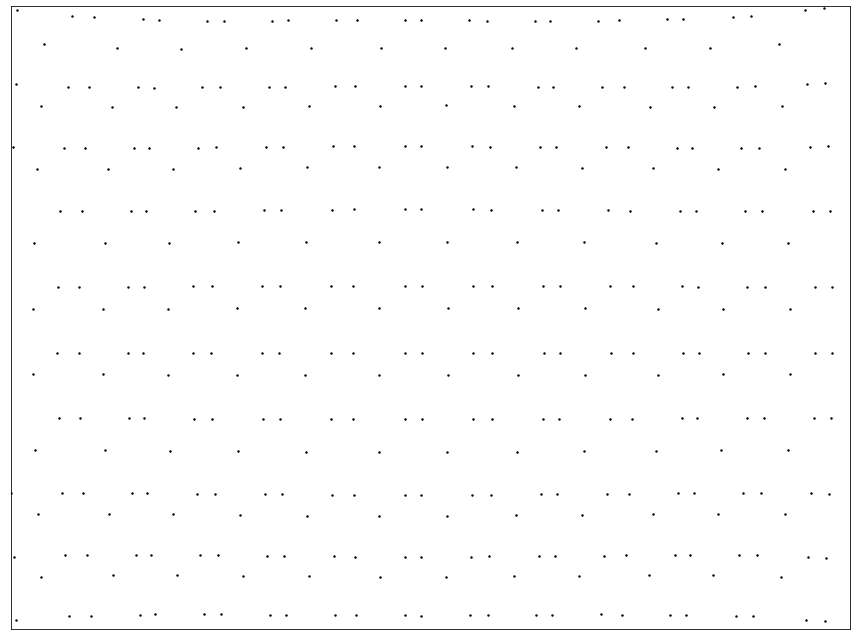

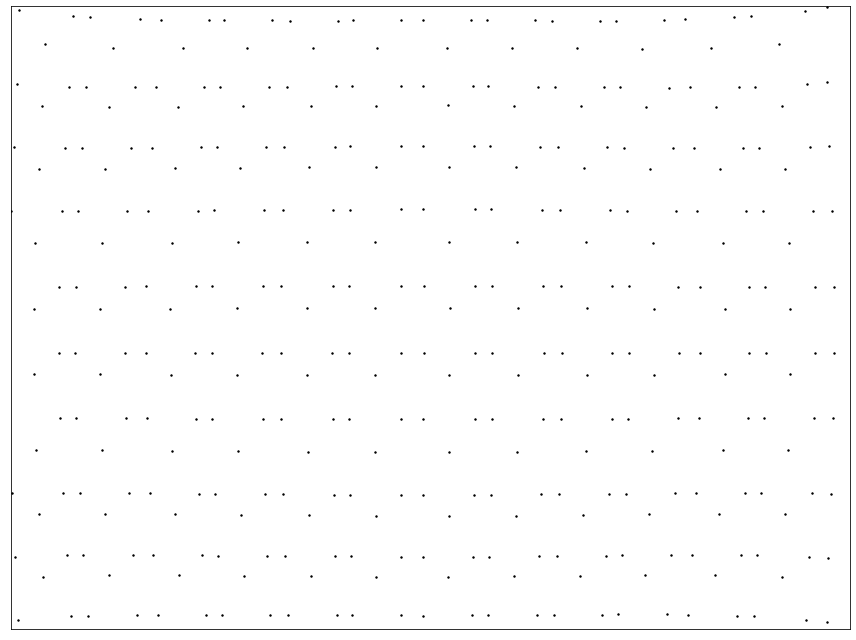

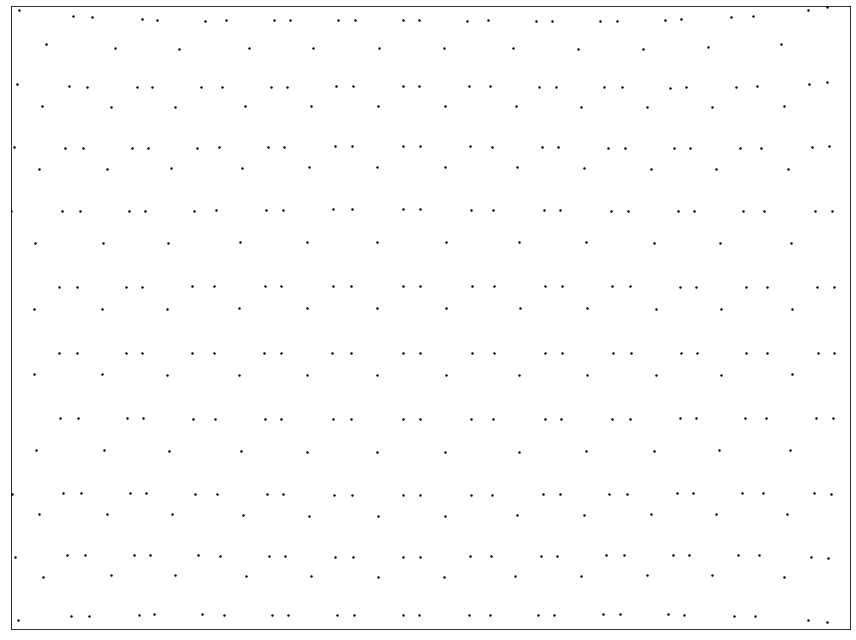

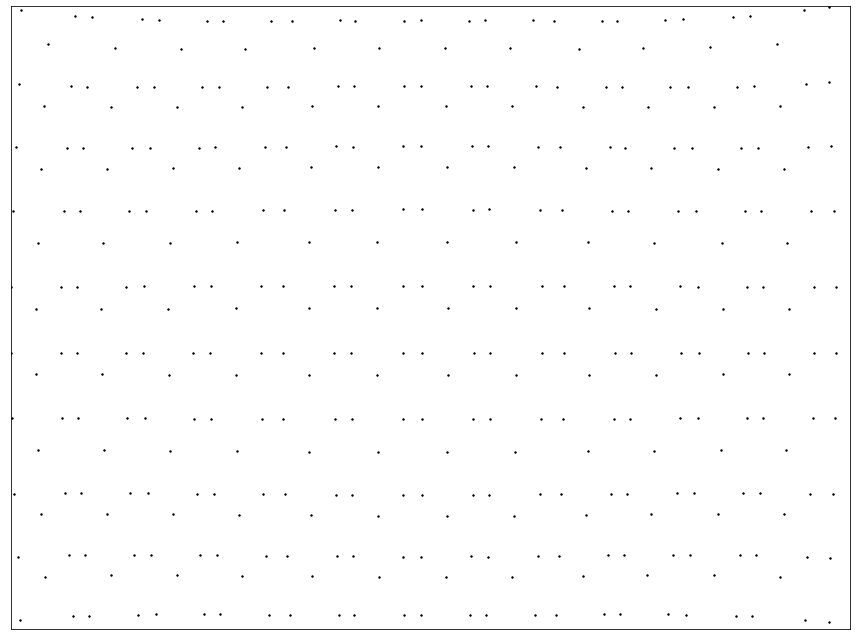

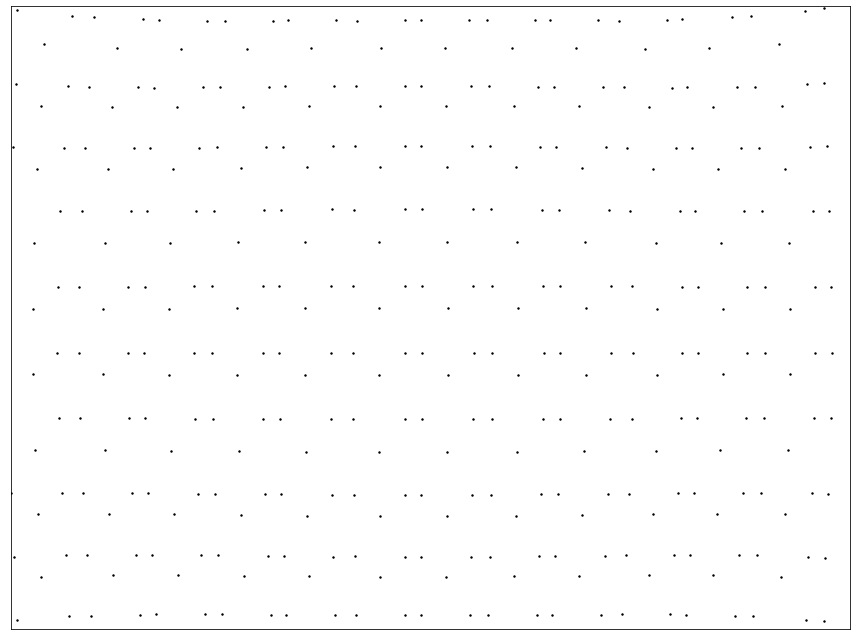

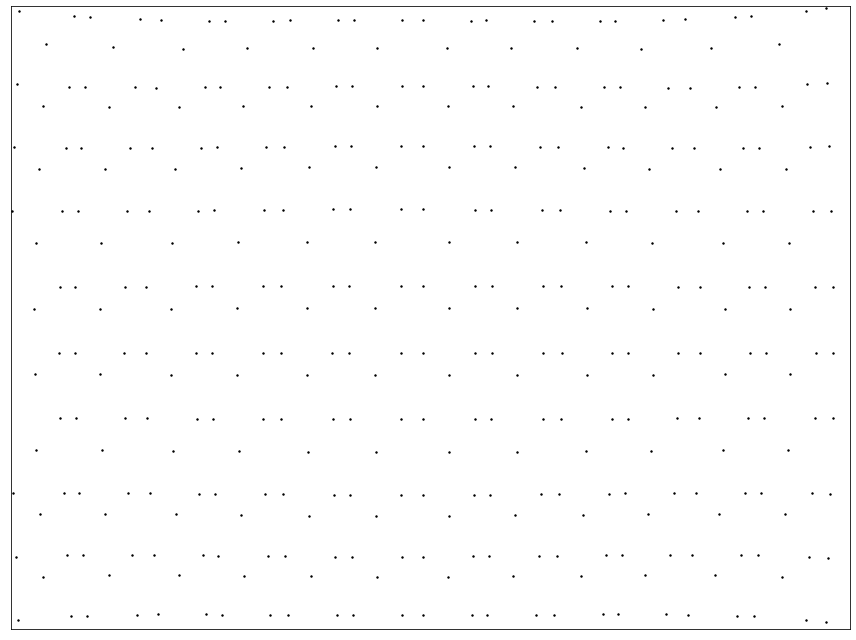

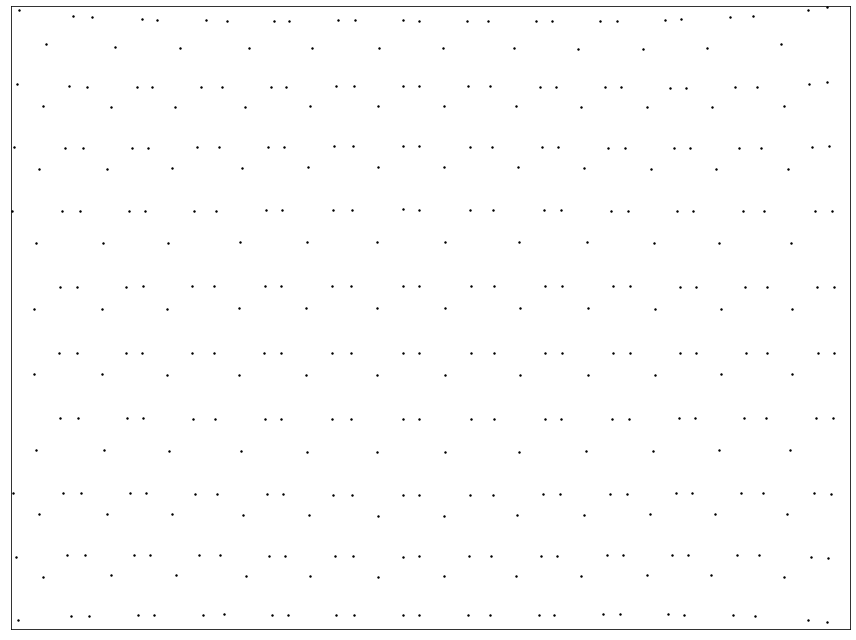

In [20]:
bolt_count = 3
bolt_positions = geo.get_bolt_locations_barrel(pmt_locations, bolt_count)
ring_positions = get_ring_positions(bolt_positions, pmt_locations.keys(), bolt_count)
ring_orientations = get_ring_orientations(bolt_positions, pmt_locations.keys(), bolt_count)
simulator = fit.PhotogrammetrySimulator(bolt_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)
image_feature_locations = simulator.get_image_feature_locations(area_restrict = [[0, 4000], [0, 3000]], min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
print("Feature in image counts:", Counter(feature_counts.values()))
simulator.show_images(image_feature_locations, area=[[0,4000],[0,3000]])

=== Gaussian errors on feature image locations: 0.5 ===
Feature in image counts: Counter({2: 1950})
50 images with total of  1950 features
image 0 reprojection errors:    average: 6.390210346024396    max: 13.342869678055562
image 1 reprojection errors:    average: 6.646631971274692    max: 15.86422961687786
image 2 reprojection errors:    average: 6.58690365934634    max: 14.818782196477317
image 3 reprojection errors:    average: 7.717875214200785    max: 19.648525462202947
image 4 reprojection errors:    average: 6.4655081873041675    max: 16.57247465560846
image 5 reprojection errors:    average: 6.319989941140436    max: 17.493330834760886
image 6 reprojection errors:    average: 5.646032654738961    max: 11.88041270466803
image 7 reprojection errors:    average: 5.277293062549662    max: 13.2202707977311
image 8 reprojection errors:    average: 6.023219866455529    max: 14.164297691081607
image 9 reprojection errors:    average: 6.648151303716907    max: 17.676018894892632
image 

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0326e+05                                    1.24e+06    
       1              2         5.2476e+03      9.80e+04       6.83e+01       1.74e+04    
       2              3         2.7355e+03      2.51e+03       6.61e+01       3.31e+04    
       3              4         2.3152e+03      4.20e+02       9.60e+00       2.19e+03    
       4              5         2.1919e+03      1.23e+02       5.07e+00       4.69e+02    
       5              6         2.1158e+03      7.61e+01       3.79e+00       3.15e+02    
       6              7         2.0702e+03      4.56e+01       2.41e+00       2.39e+02    
       7              8         2.0572e+03      1.30e+01       6.14e-01       1.82e+02    
`xtol` termination condition is satisfied.
Function evaluations 8, initial cost 1.0326e+05, final cost 2.0572e+03, first-order optimality 1.82e+02.
mean reprojection error: 0.835232

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2657e+05                                    1.46e+06    
       1              2         1.4940e+04      1.12e+05       7.28e+01       1.61e+04    
       2              3         1.0337e+04      4.60e+03       8.18e+01       2.99e+04    
       3              4         8.8219e+03      1.52e+03       1.51e+01       3.53e+03    
       4              5         8.4922e+03      3.30e+02       7.89e+00       1.56e+03    
       5              6         8.3041e+03      1.88e+02       4.85e+00       9.92e+02    
       6              7         8.2609e+03      4.32e+01       1.06e+00       3.21e+02    
       7              8         8.2266e+03      3.43e+01       9.96e-01       6.47e+02    
       8              9         8.1963e+03      3.03e+01       9.12e-01       2.69e+02    
       9             10         8.1678e+03      2.84e+01       9.17e-01       5.74e+02    

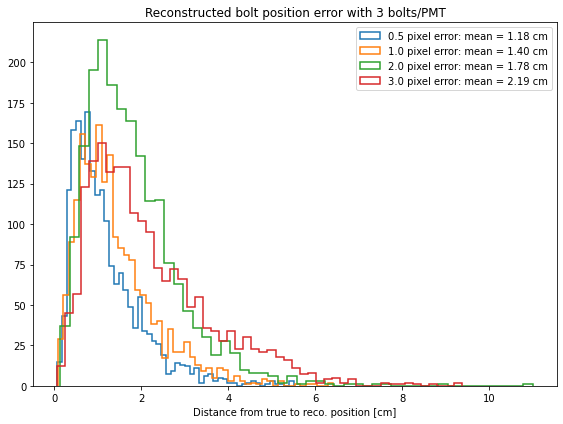

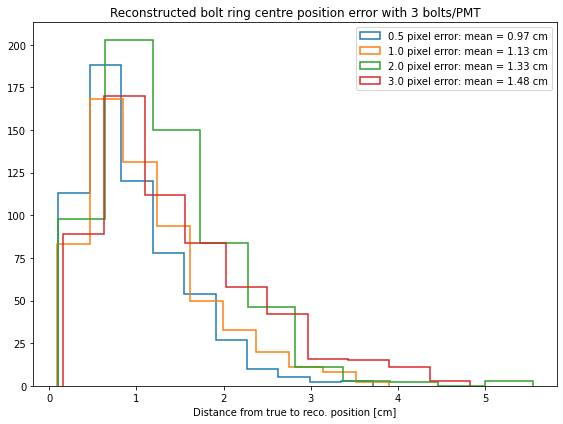

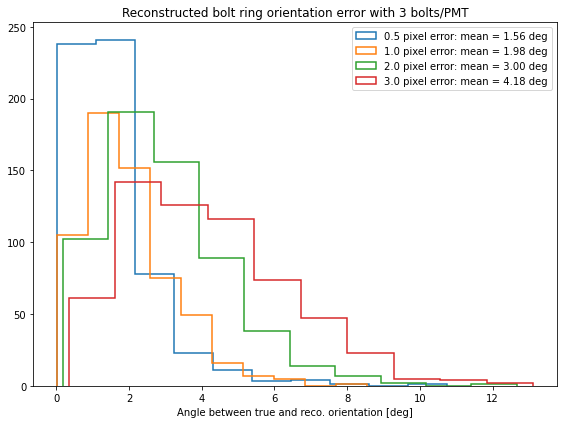

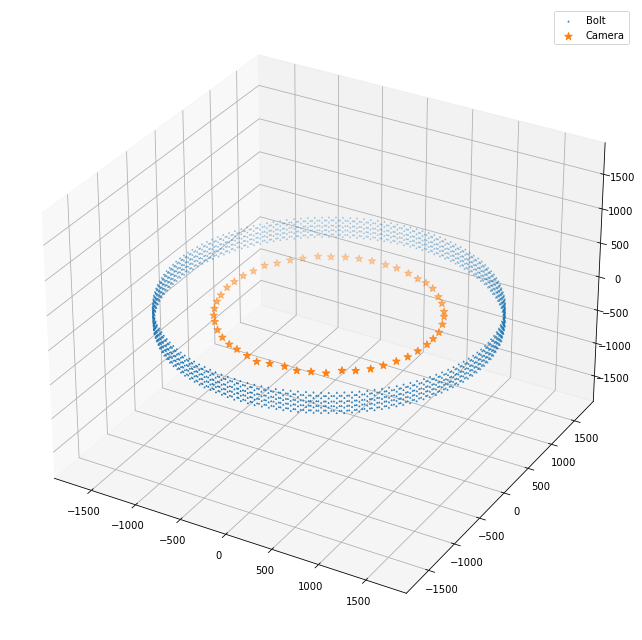

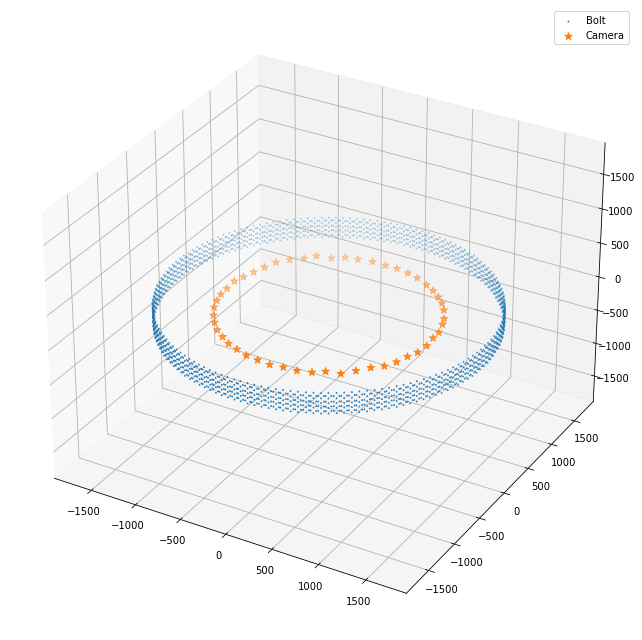

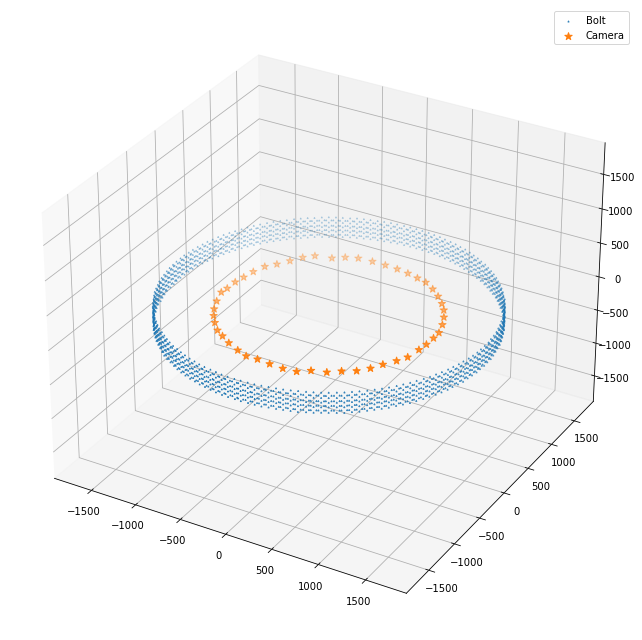

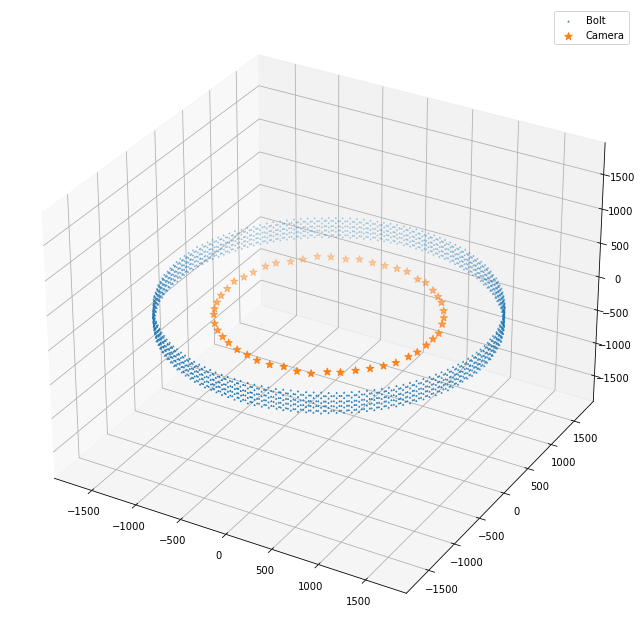

In [21]:
fig_bolt_pos, ax_bolt_pos = make_fig("Reconstructed bolt position error with {} bolts/PMT".format(bolt_count), "Distance from true to reco. position [cm]")
fig_ring_pos, ax_ring_pos = make_fig("Reconstructed bolt ring centre position error with {} bolts/PMT".format(bolt_count), "Distance from true to reco. position [cm]")
fig_ring_ang, ax_ring_ang = make_fig("Reconstructed bolt ring orientation error with {} bolts/PMT".format(bolt_count), "Angle between true and reco. orientation [deg]")
for pixel_error in [0.5, 1.0, 2.0, 3.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=[[1000, 3000], [750, 2250]], min_feature_count=2, pixel_error=pixel_error)
    feature_counts = Counter([f for i in smeared_feature_locations.values() for f in i.keys()])
    print("Feature in image counts:", Counter(feature_counts.values()))
    bolt_positions2 = {k: v for k, v in bolt_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_bolt_simulation(bolt_positions2, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_bolt_positions, position_errors = run_bolt_fit(fitter, bolt_positions2, xtol=1e-5)
    centre_errors = get_ring_centre_errors(reco_bolt_positions, ring_positions, bolt_count)
    orientation_errors = get_ring_orientation_errors(reco_bolt_positions, ring_orientations, bolt_count)
    ax_bolt_pos.hist(position_errors, bins=50, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors.mean()))
    ax_ring_pos.hist(centre_errors, bins=10, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors.mean()))
    ax_ring_ang.hist(orientation_errors, bins=10, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors.mean()))
    reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(bolt_positions, reco_bolt_positions)
    reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
    plot_reconstruction(reco_transformed, reco_cam_positions)
    bolt_position_errors[bolt_count][pixel_error] = position_errors.mean()
    ring_position_errors[bolt_count][pixel_error] = centre_errors.mean()
    ring_orientation_errors[bolt_count][pixel_error] = orientation_errors.mean()
ax_bolt_pos.legend(loc='upper right')
ax_ring_pos.legend(loc='upper right')
ax_ring_ang.legend(loc='upper right')

(array([  3.,  22., 106., 303., 540., 543., 282., 119.,  25.,   7.]),
 array([1666.19398031, 1667.98598658, 1669.77799286, 1671.56999913,
        1673.3620054 , 1675.15401167, 1676.94601794, 1678.73802422,
        1680.53003049, 1682.32203676, 1684.11404303]),
 <BarContainer object of 10 artists>)

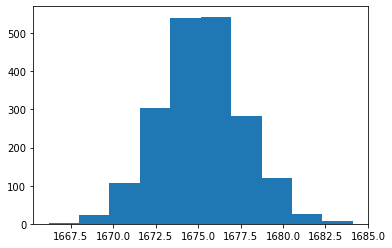

In [22]:
plt.hist(np.linalg.norm(reco_transformed[:,:2], axis=1))

# Simulation with 4 bolts

Feature in image counts: Counter({4: 5298, 3: 400, 5: 152})


/home/prouse/work/PhotogrammetryAnalysis/pg_fitter_tools.py:203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


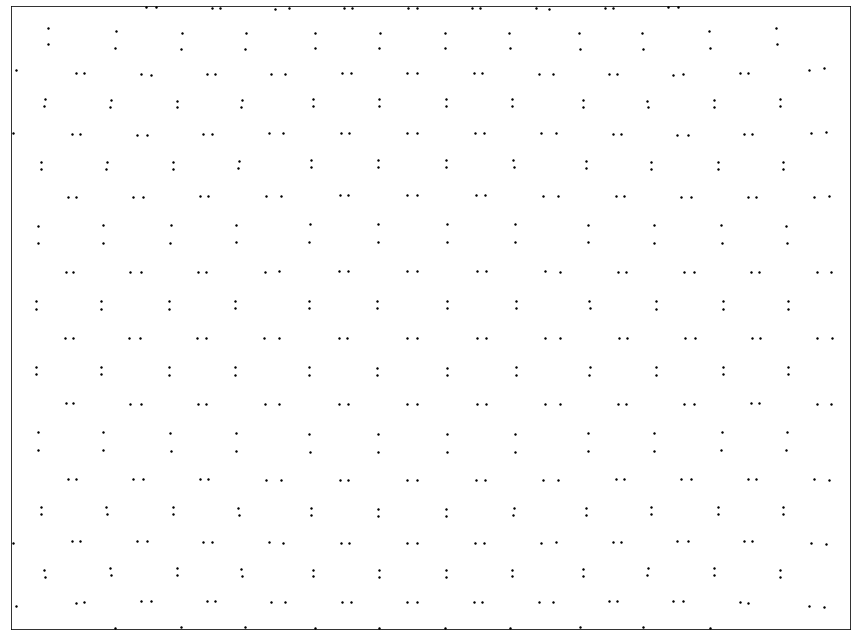

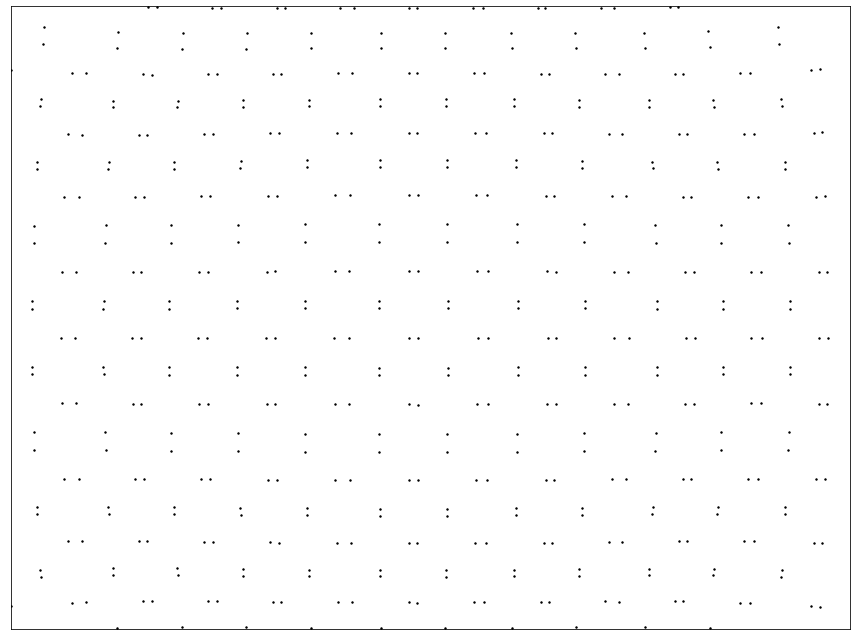

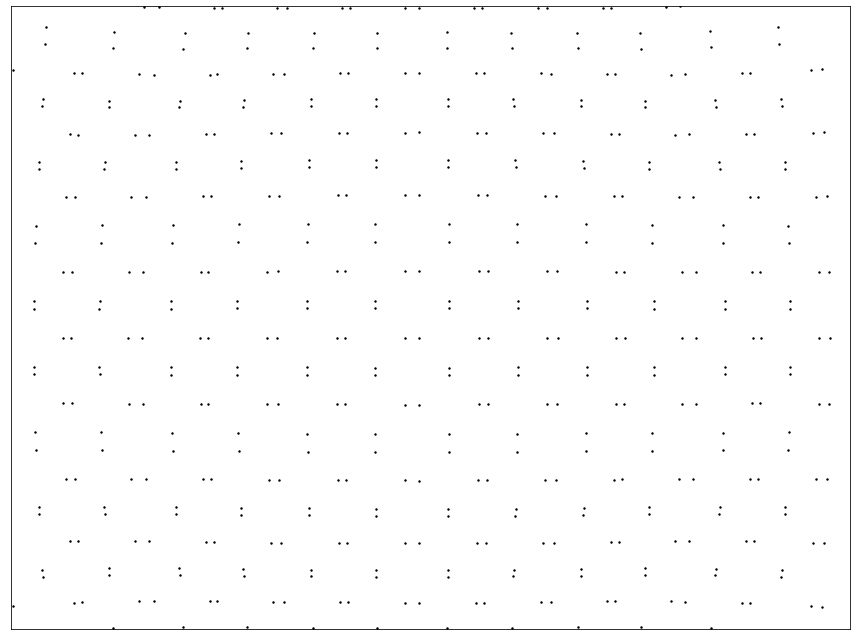

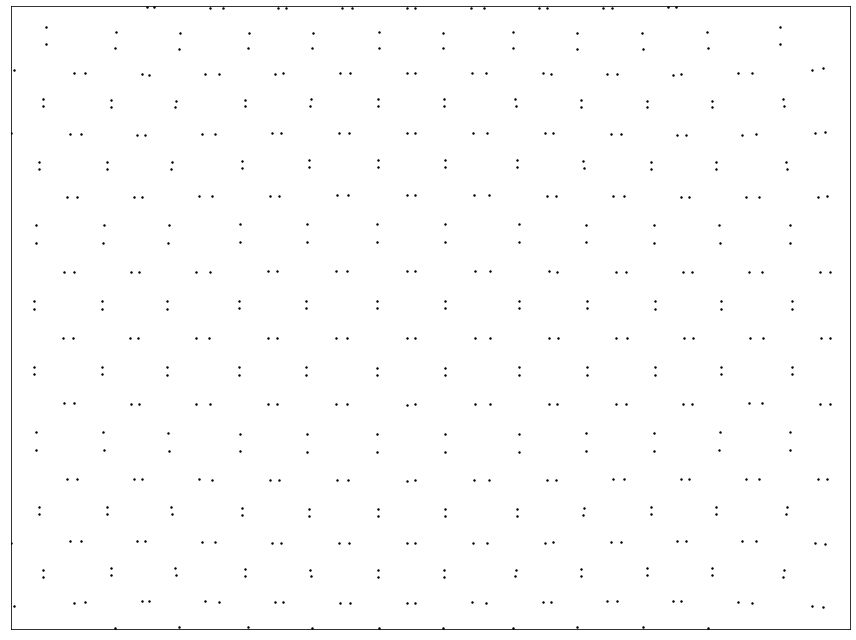

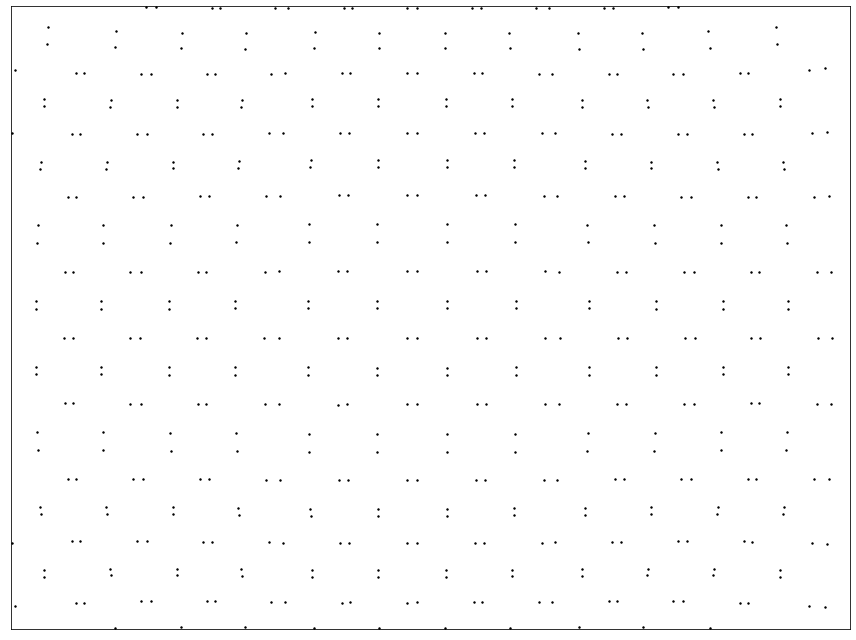

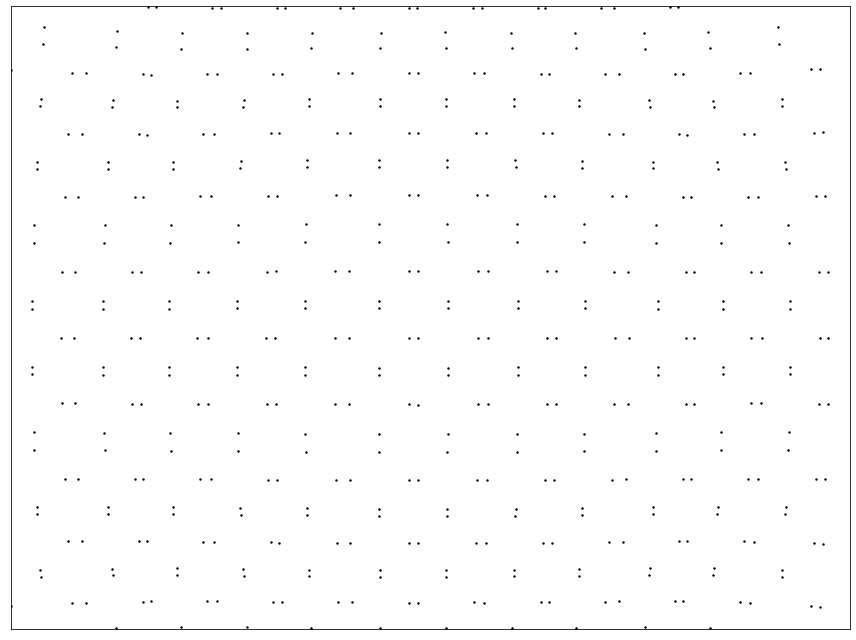

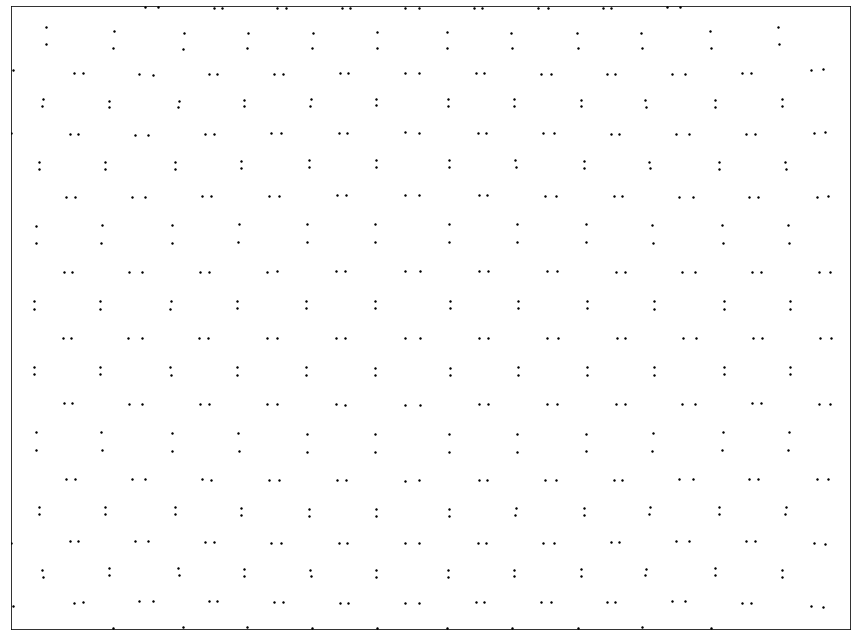

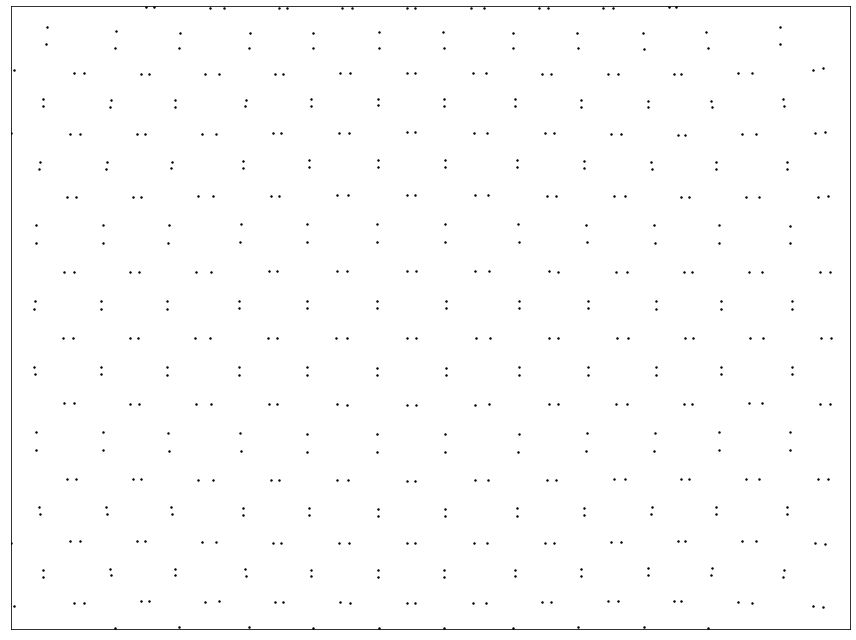

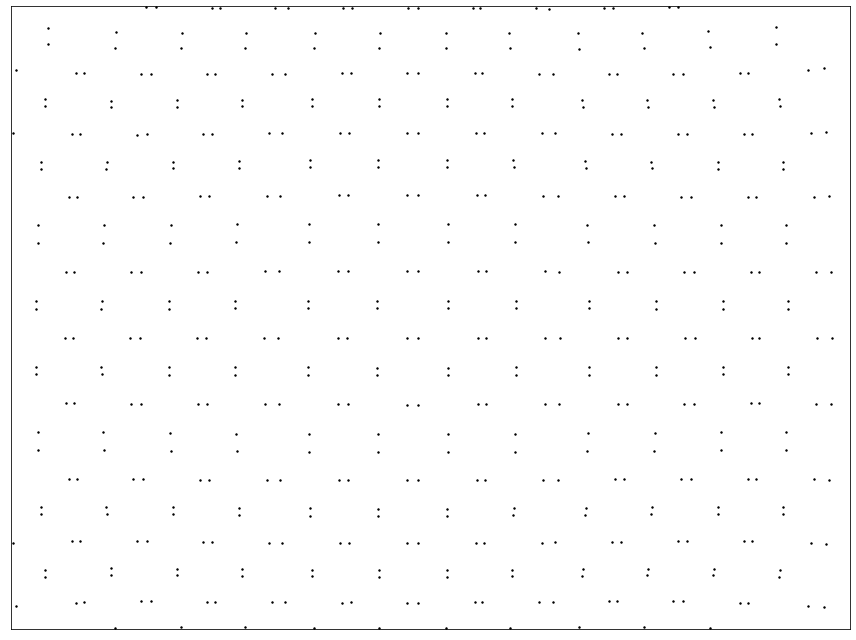

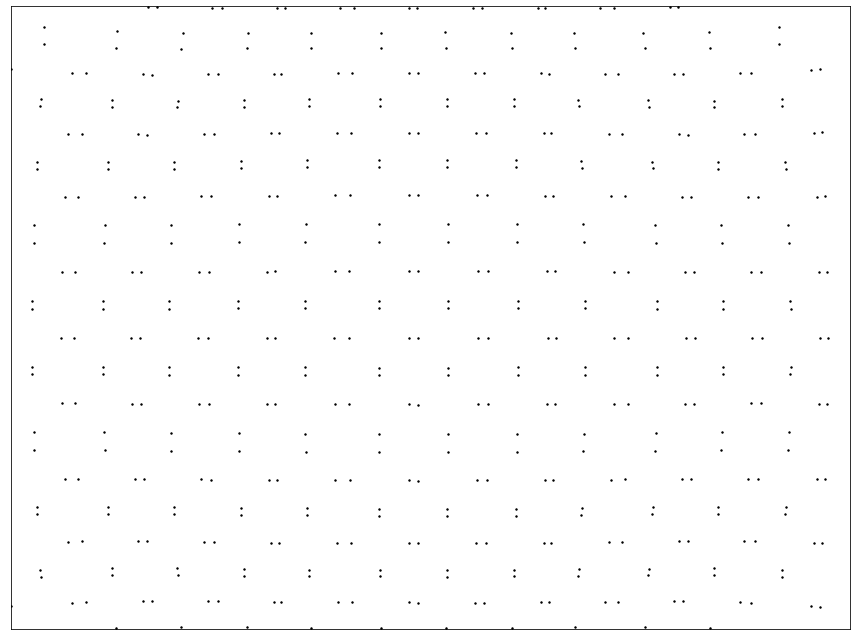

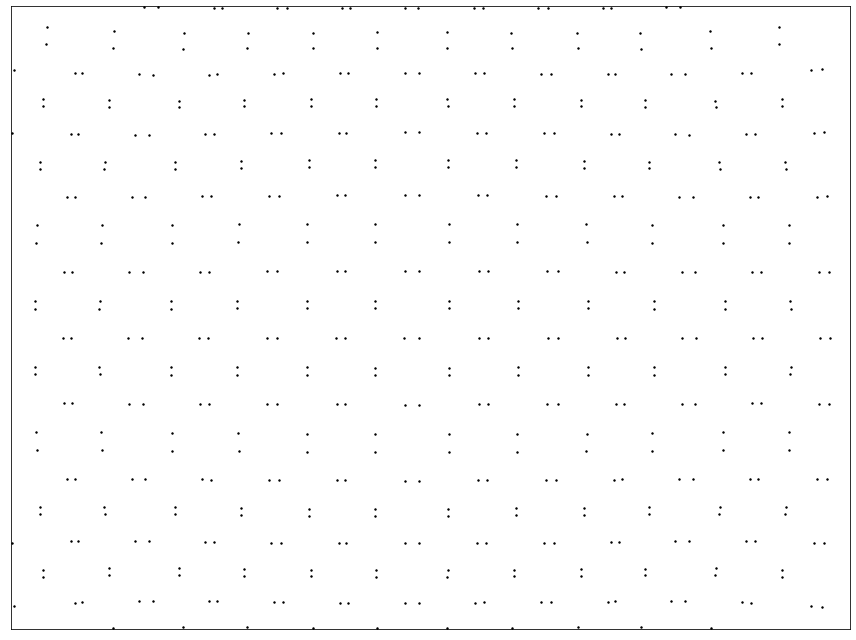

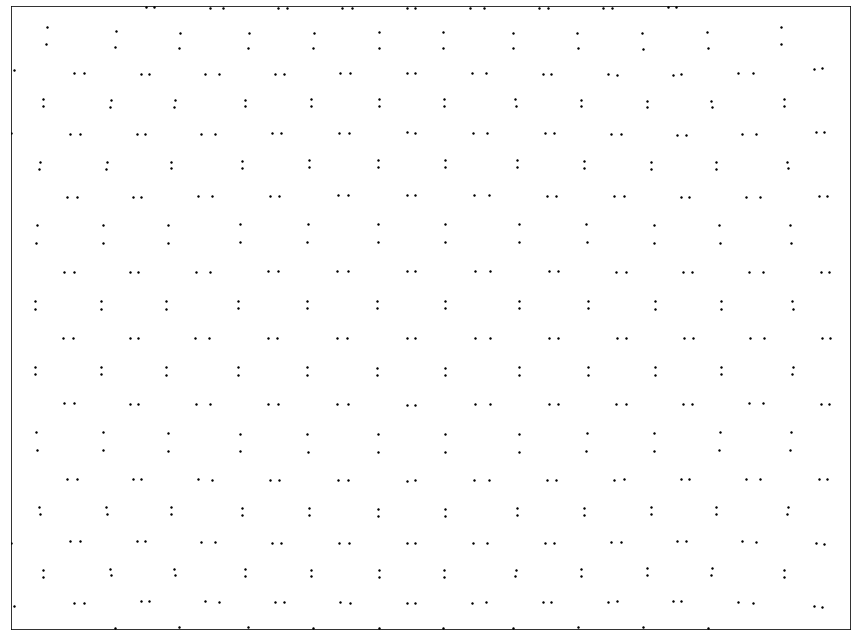

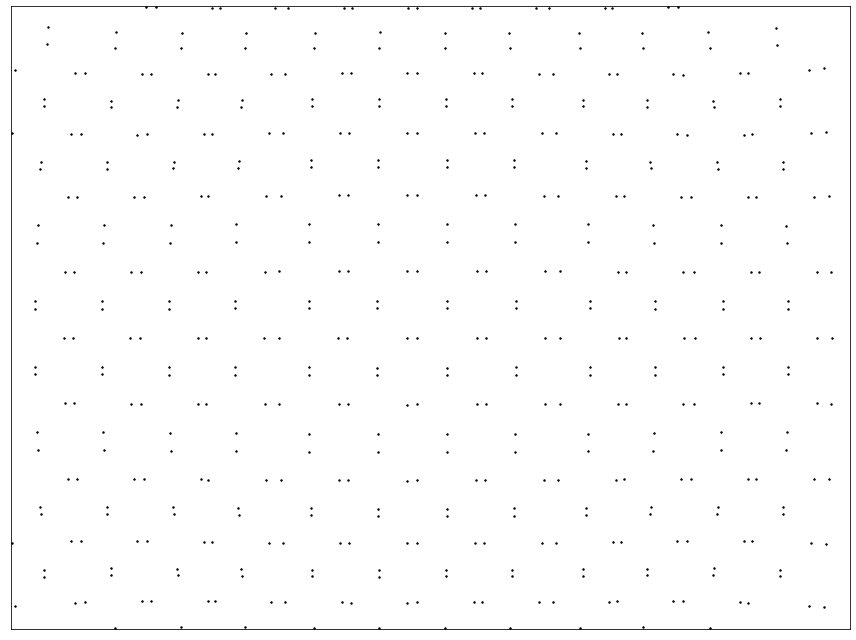

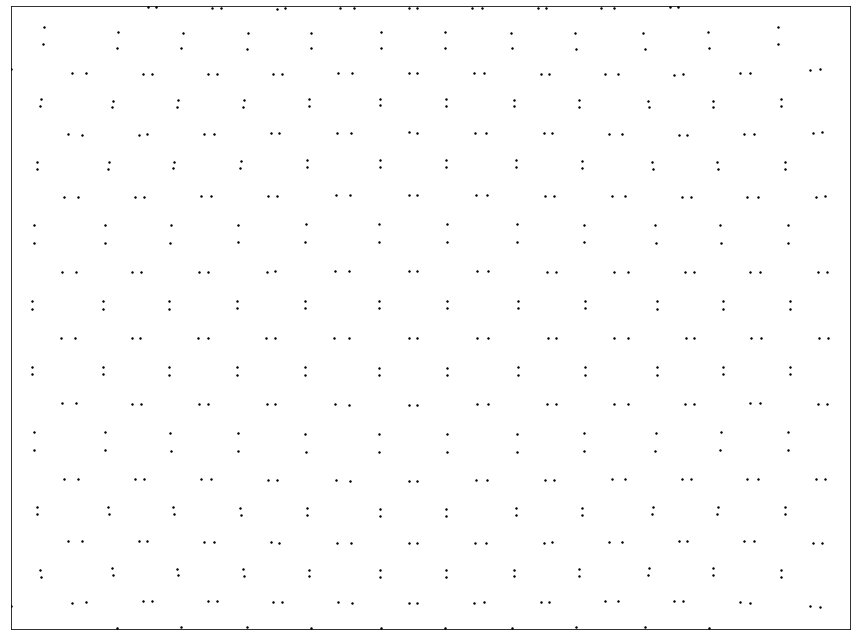

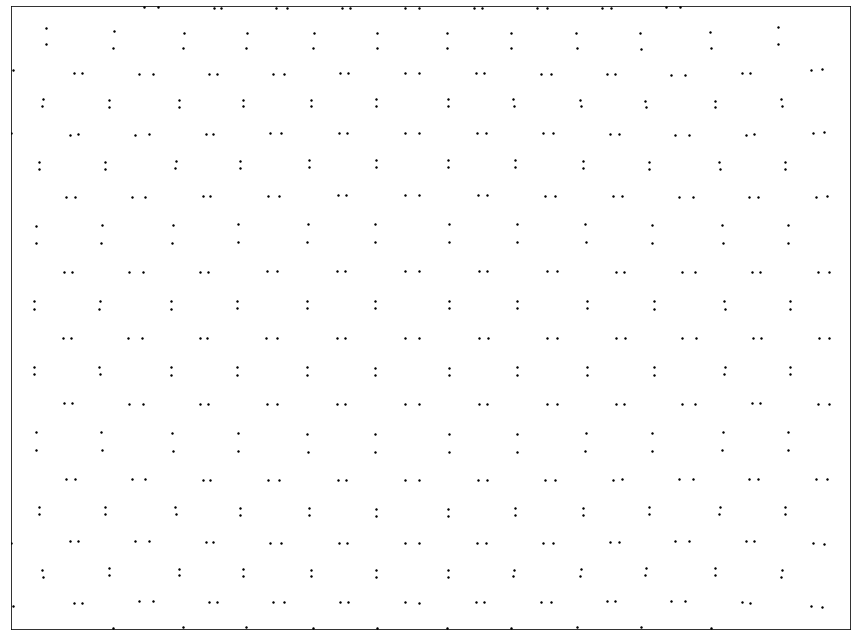

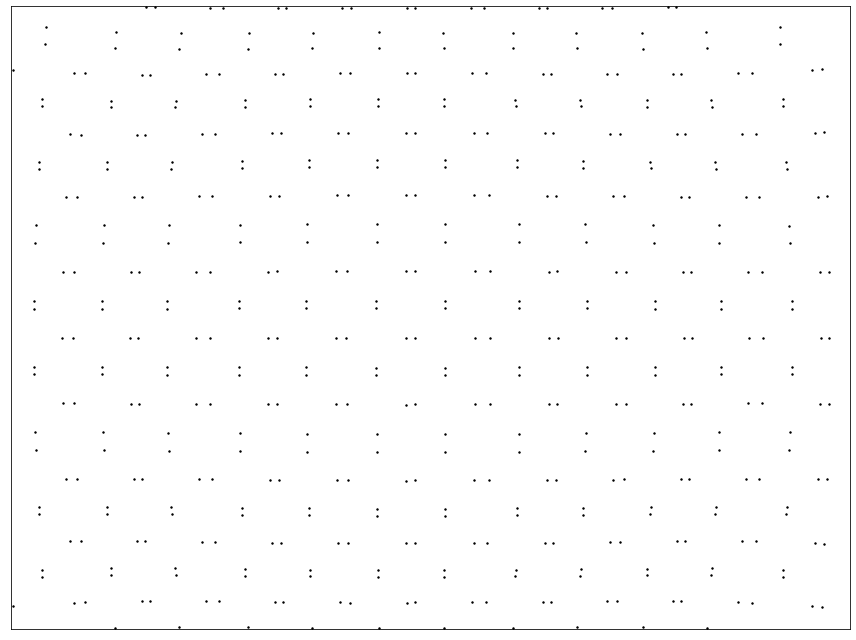

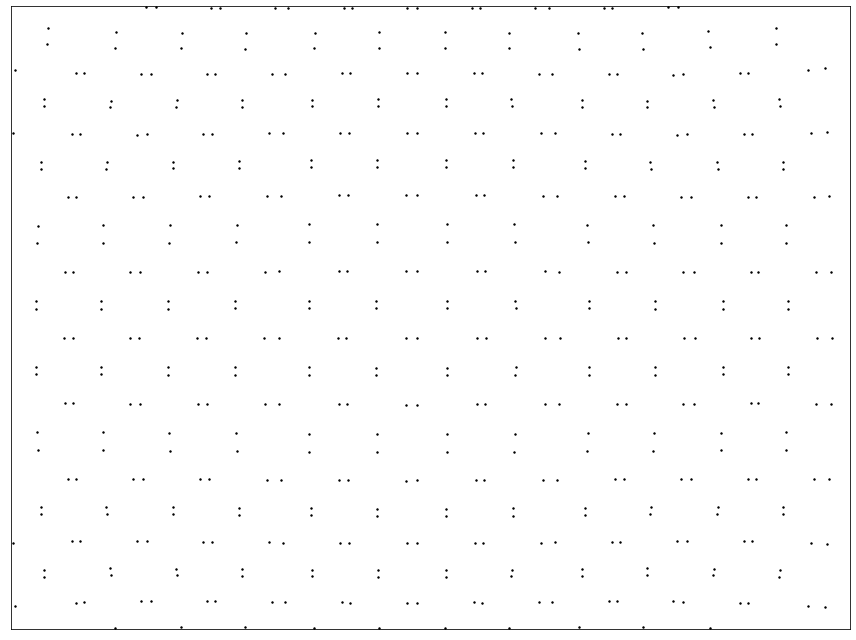

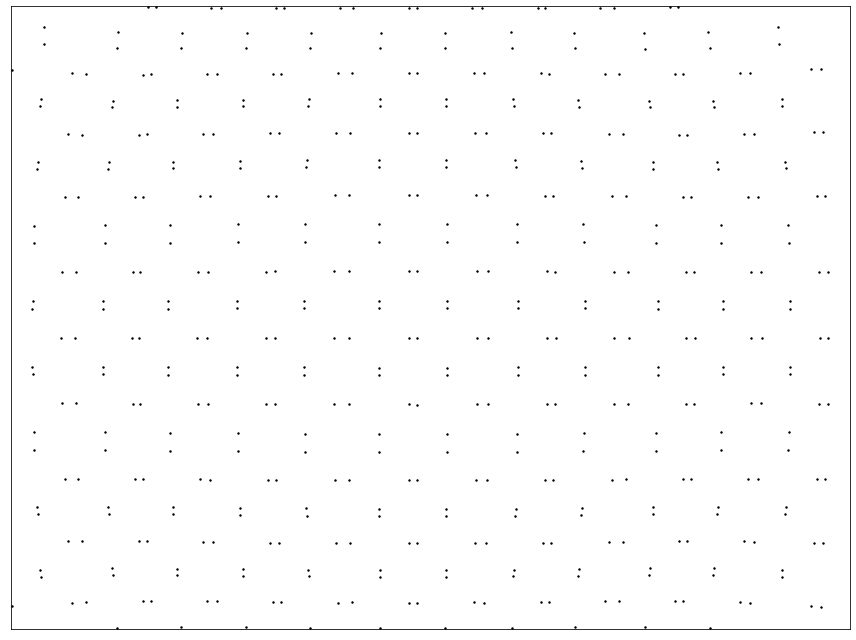

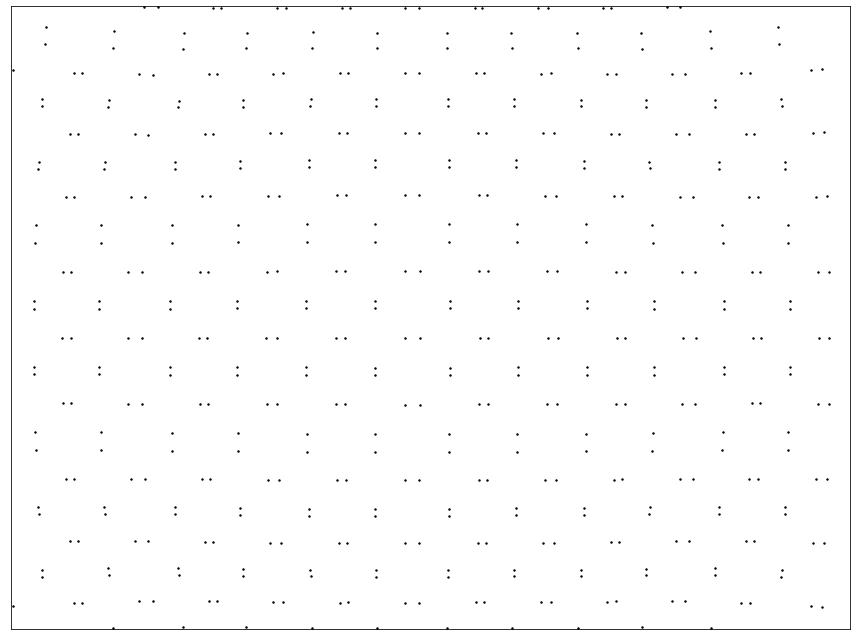

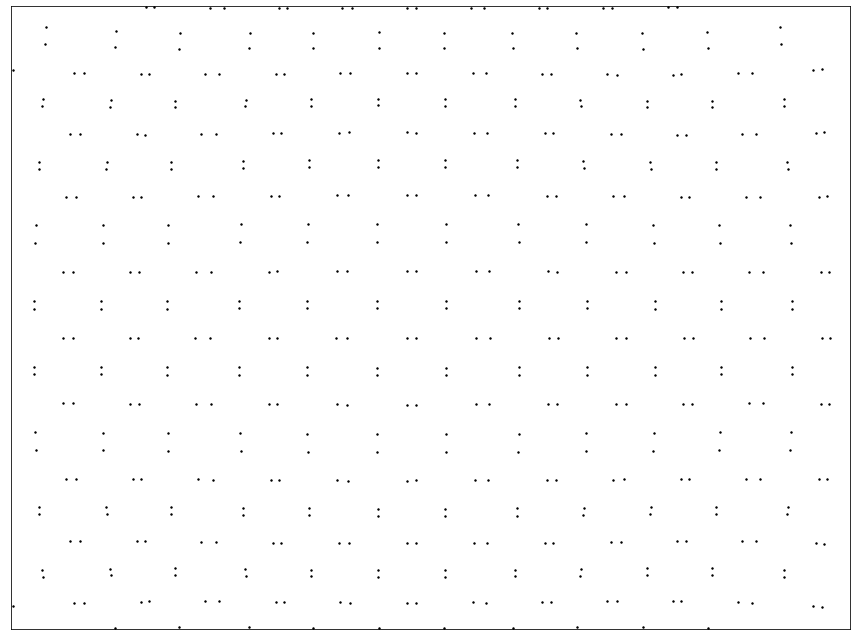

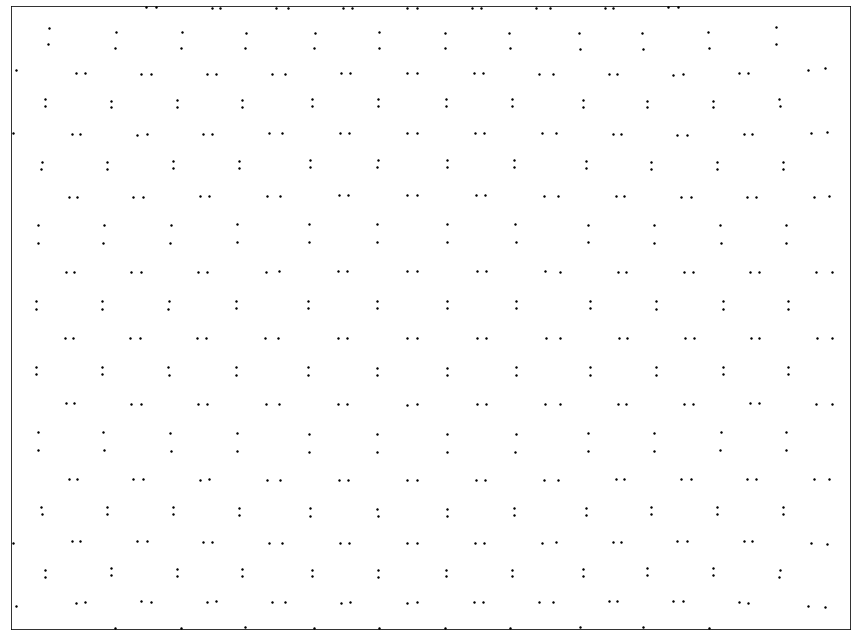

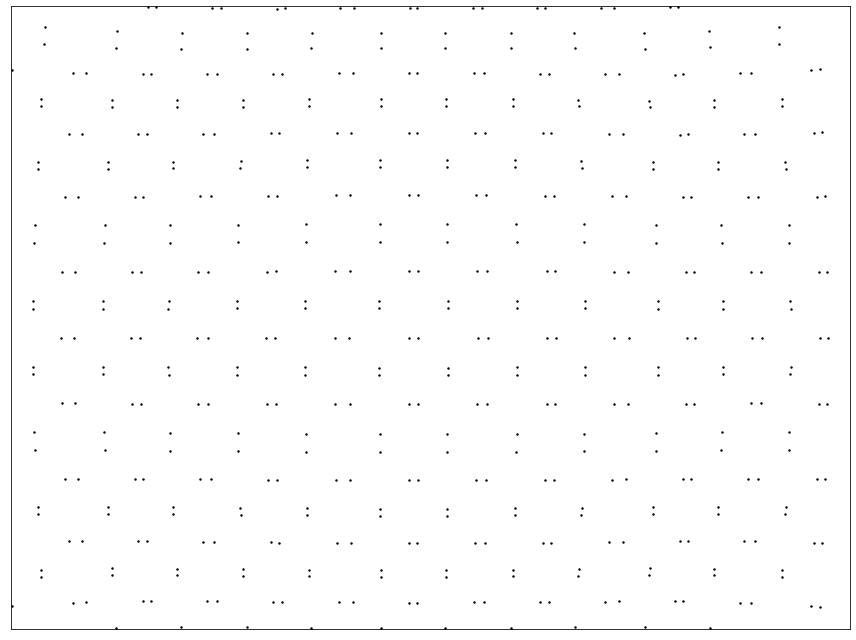

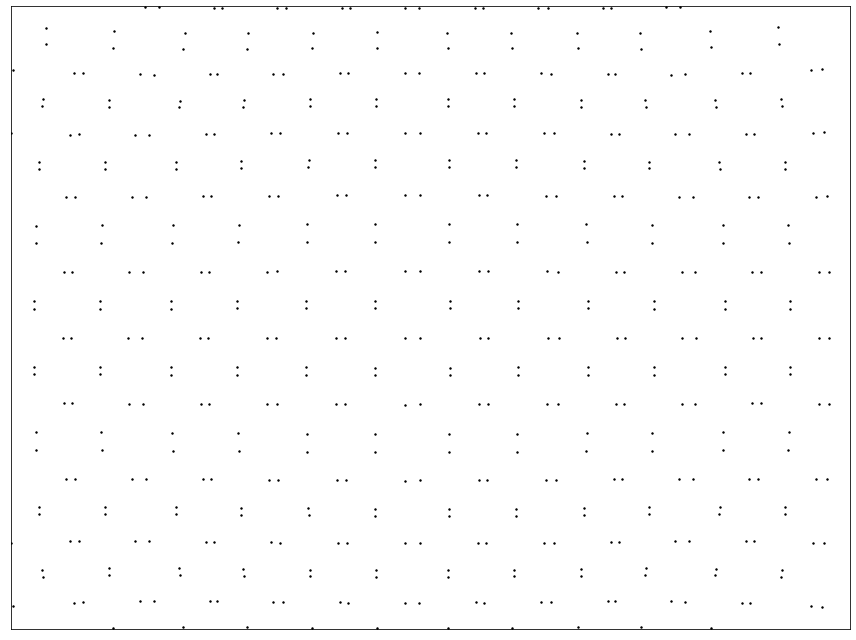

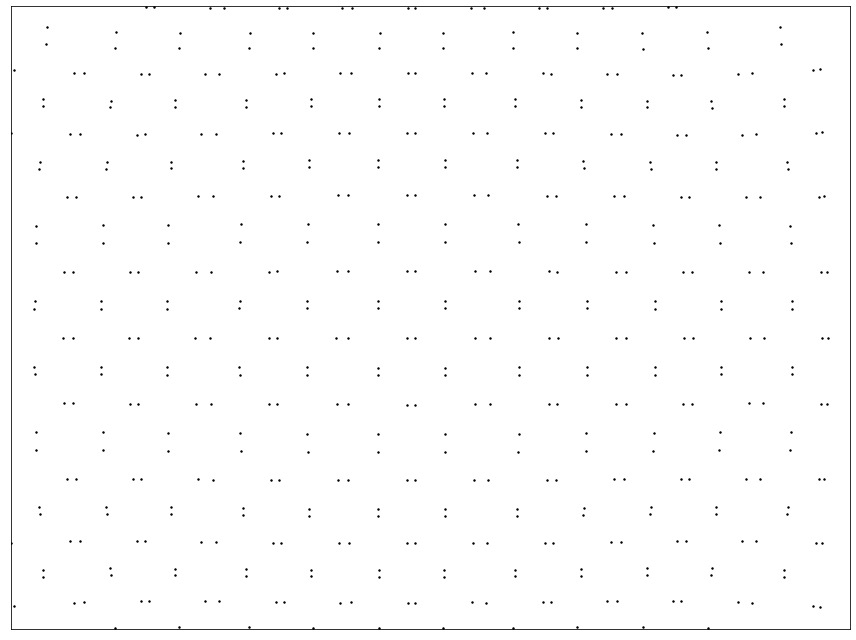

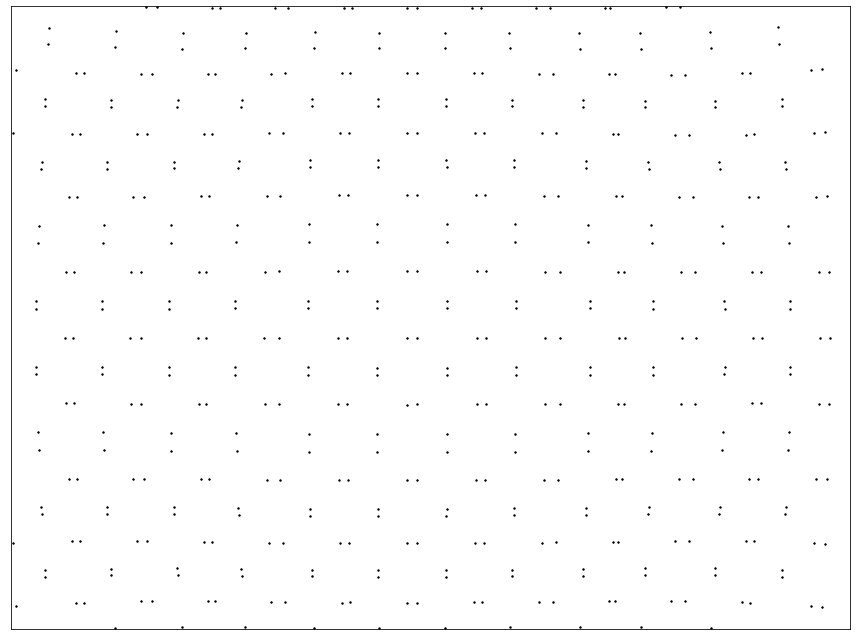

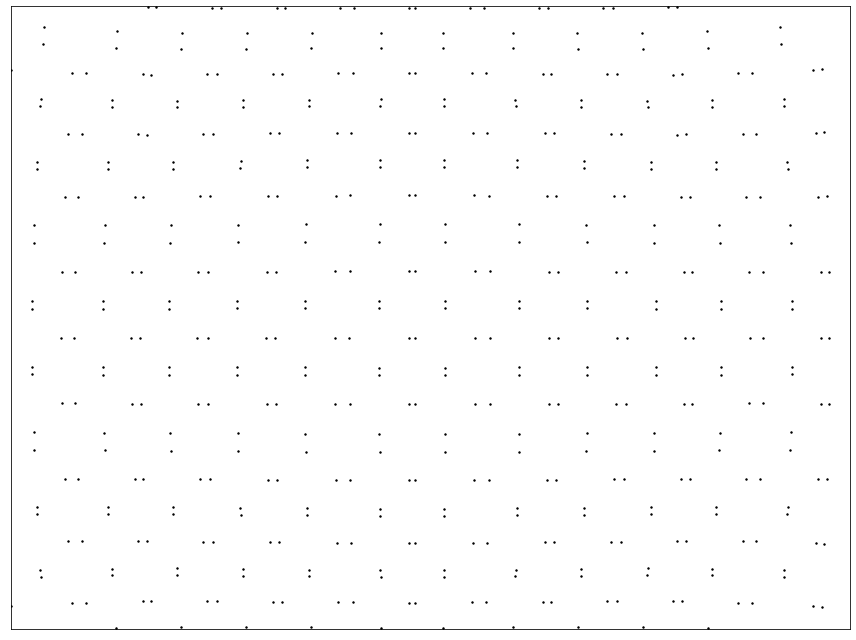

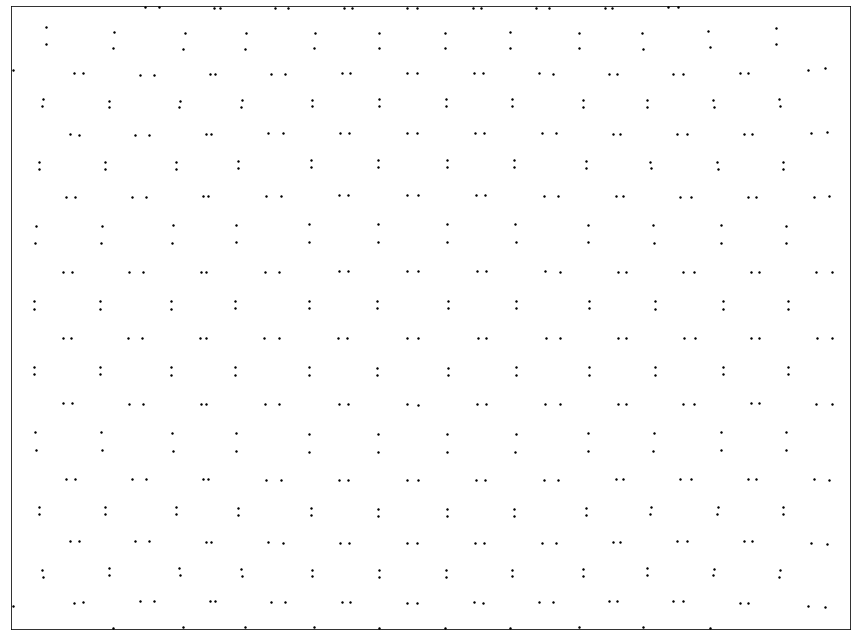

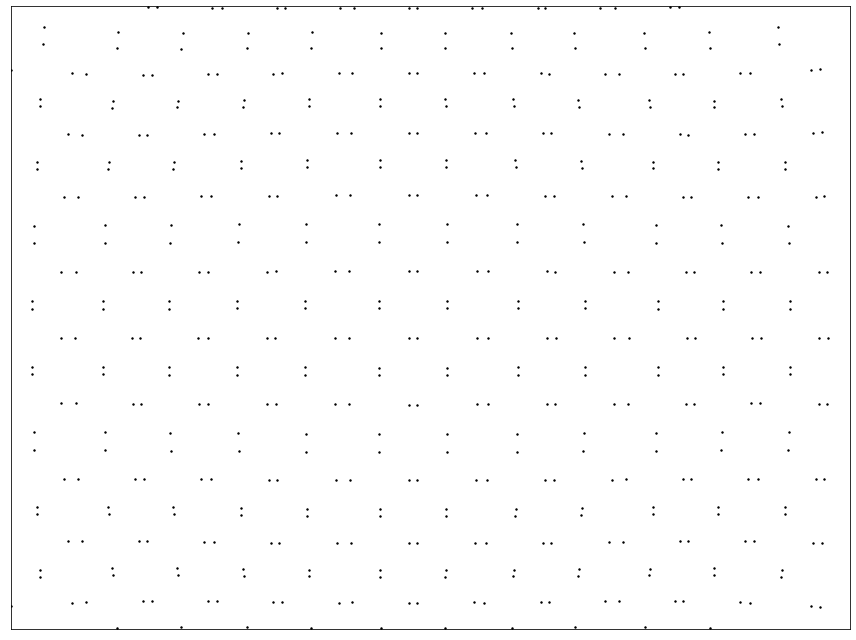

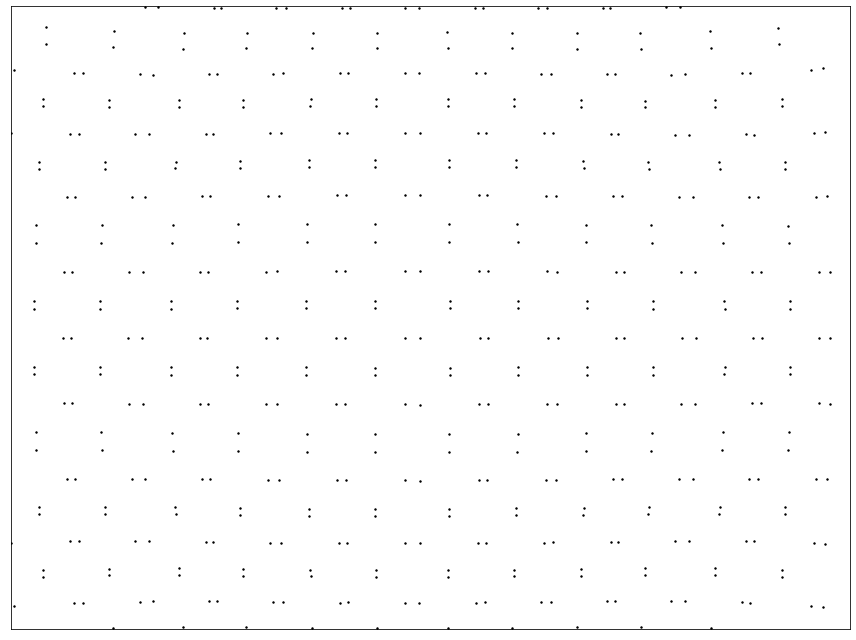

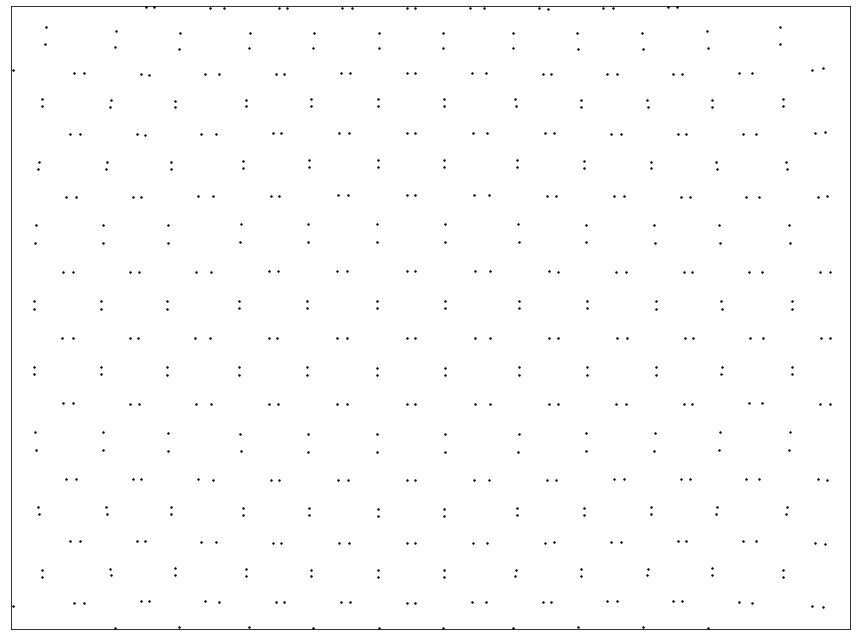

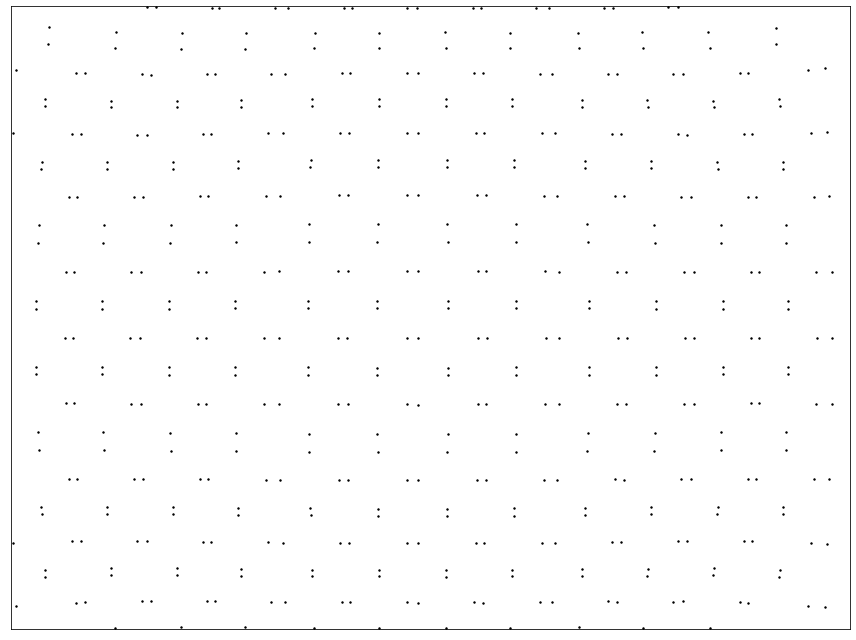

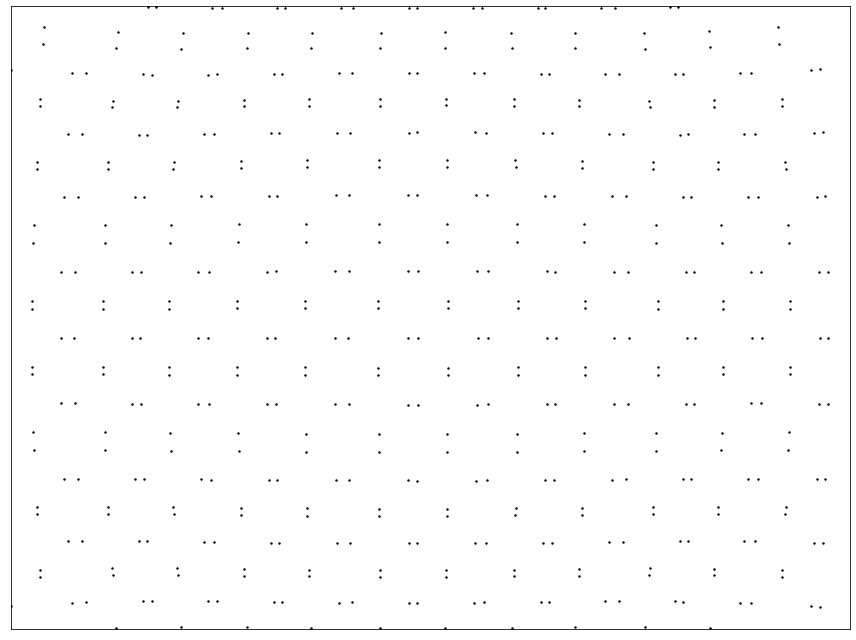

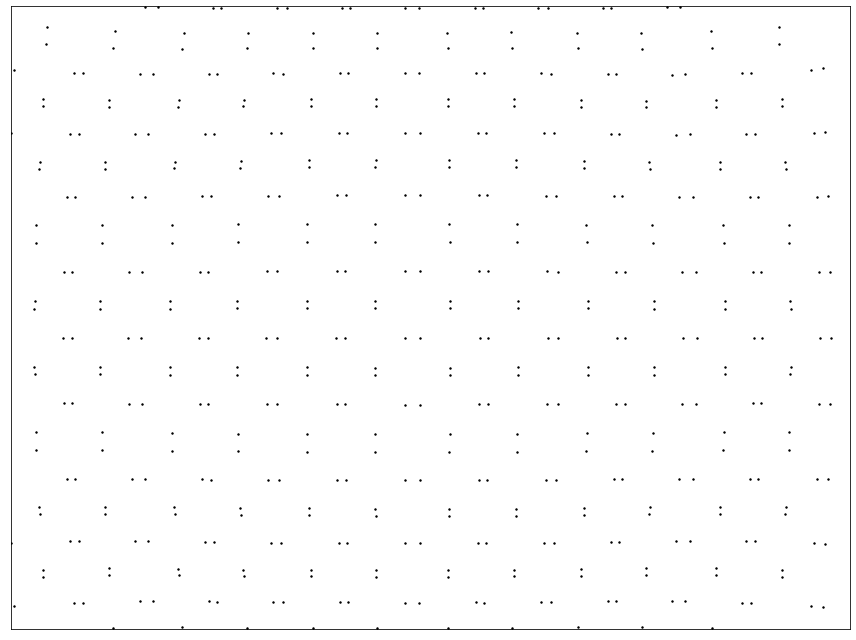

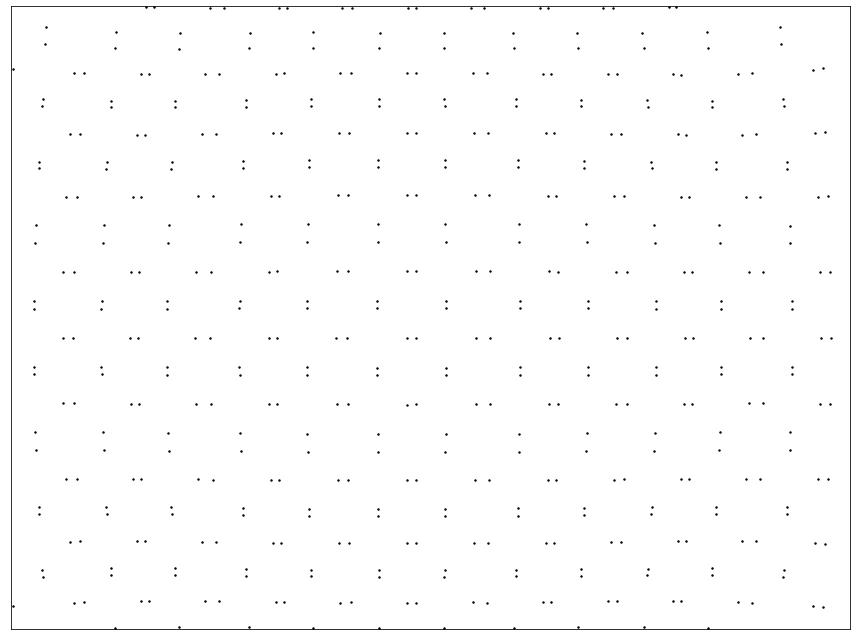

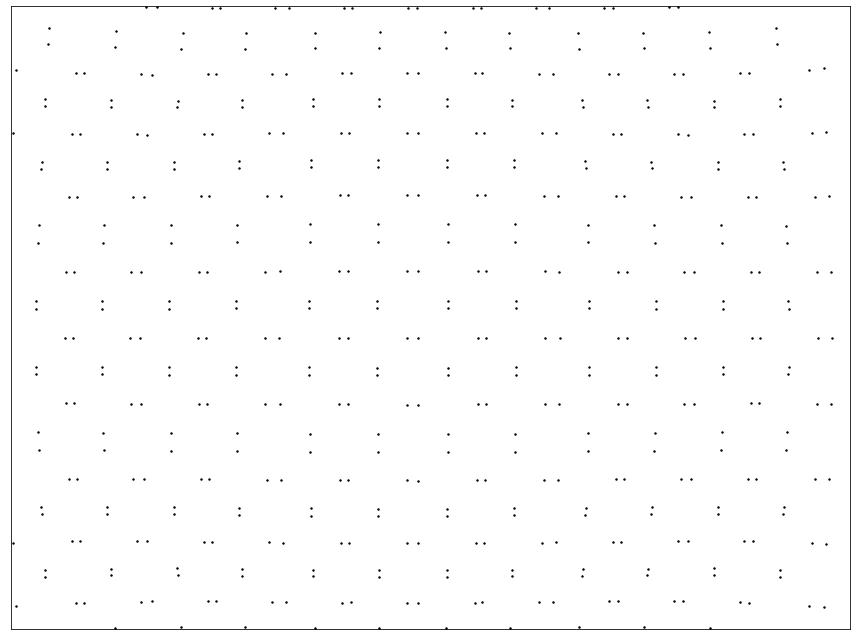

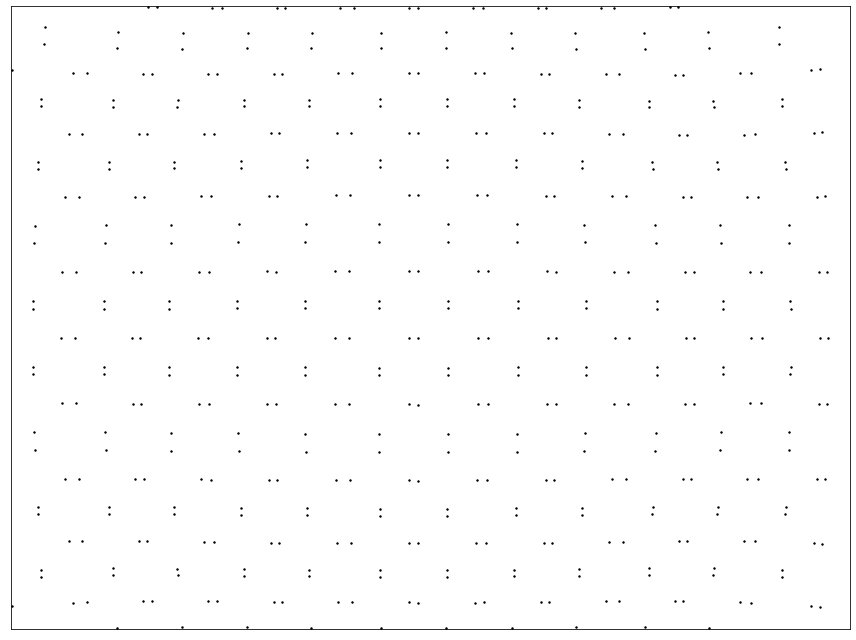

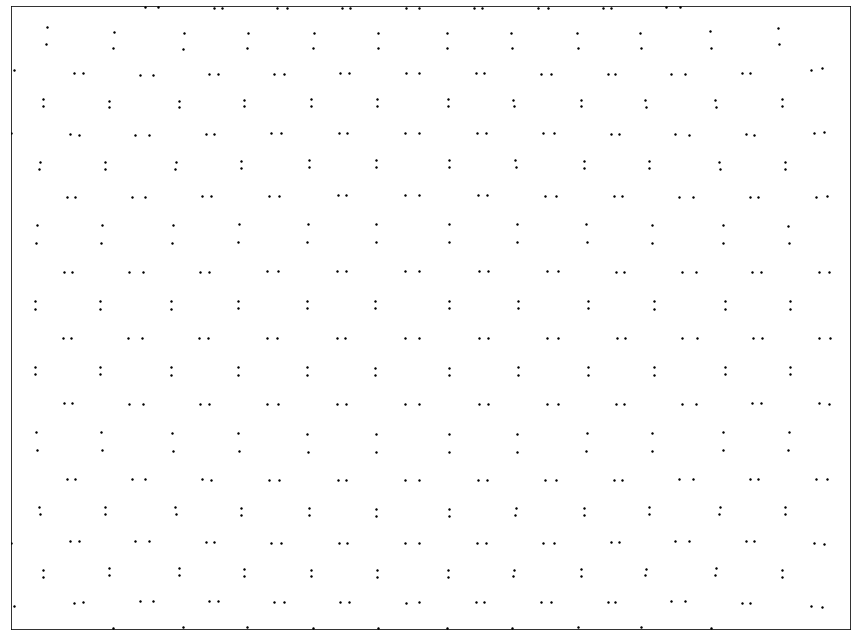

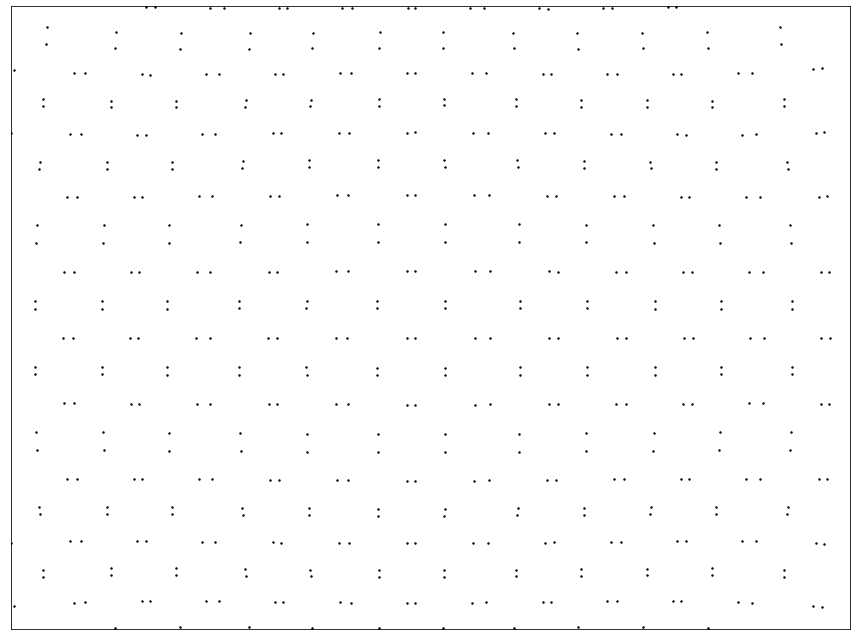

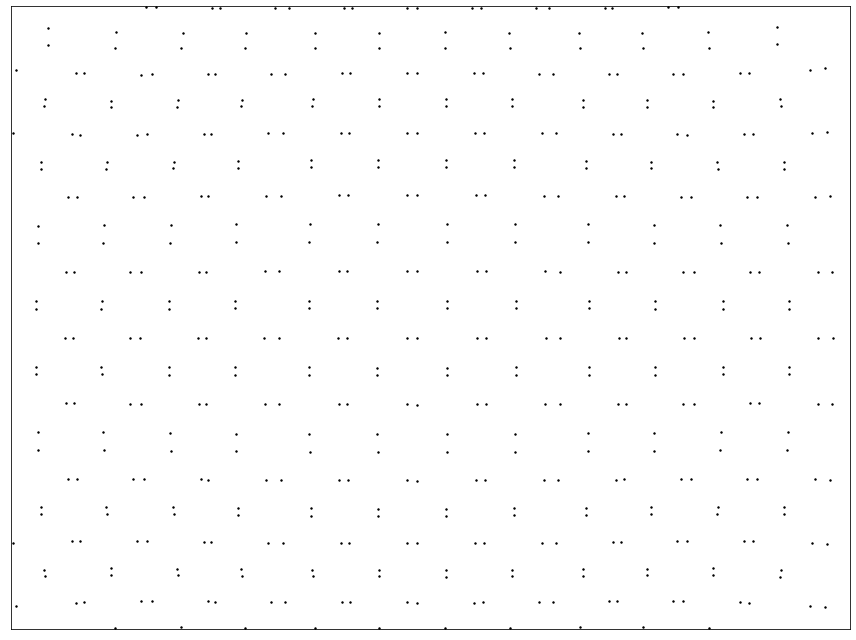

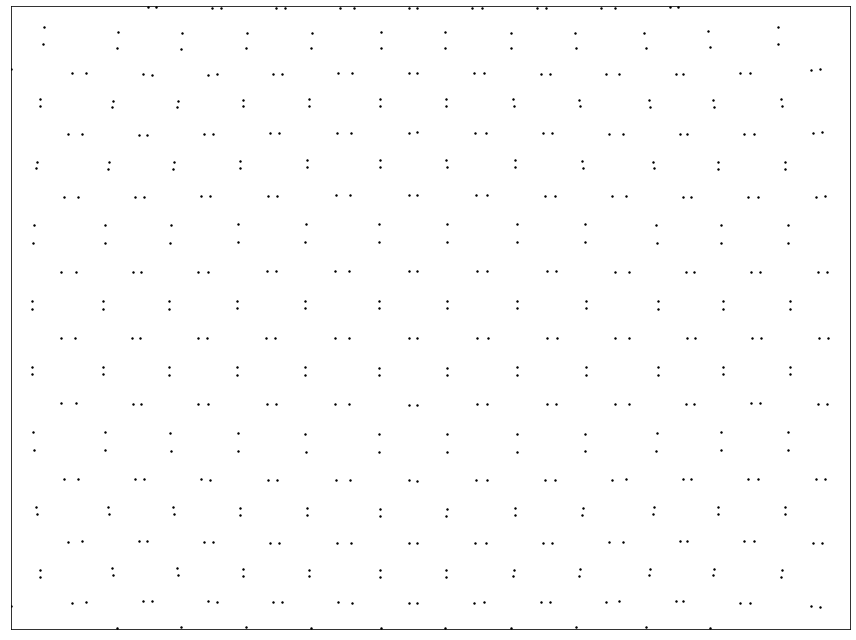

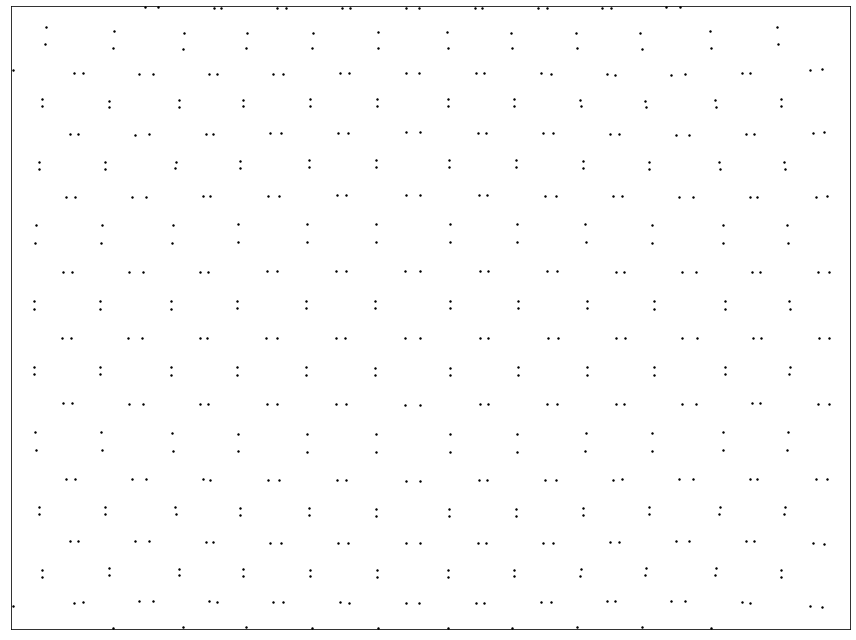

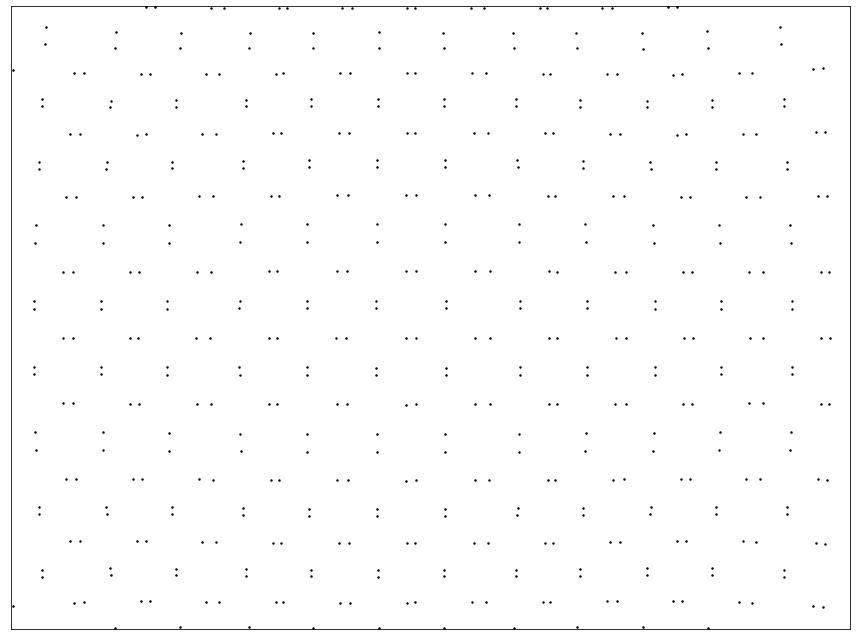

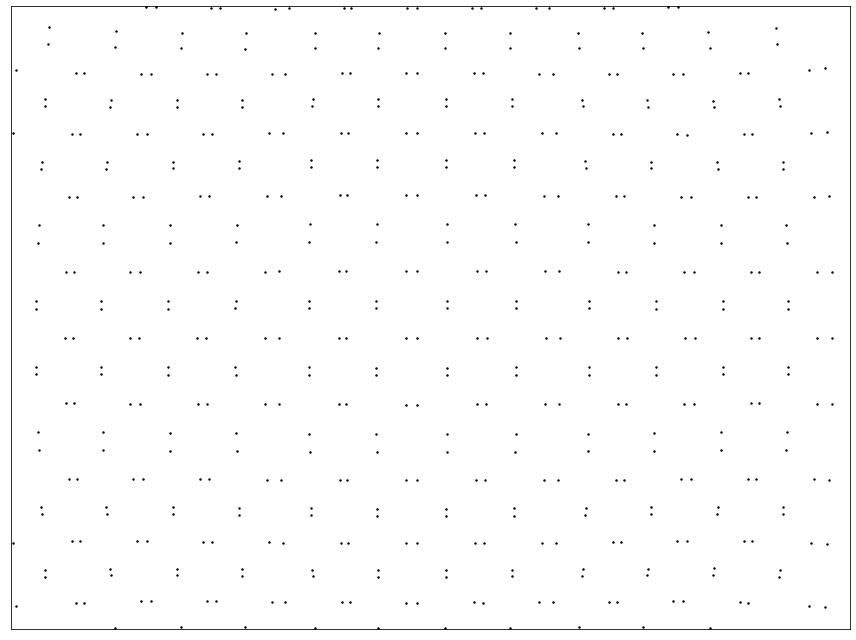

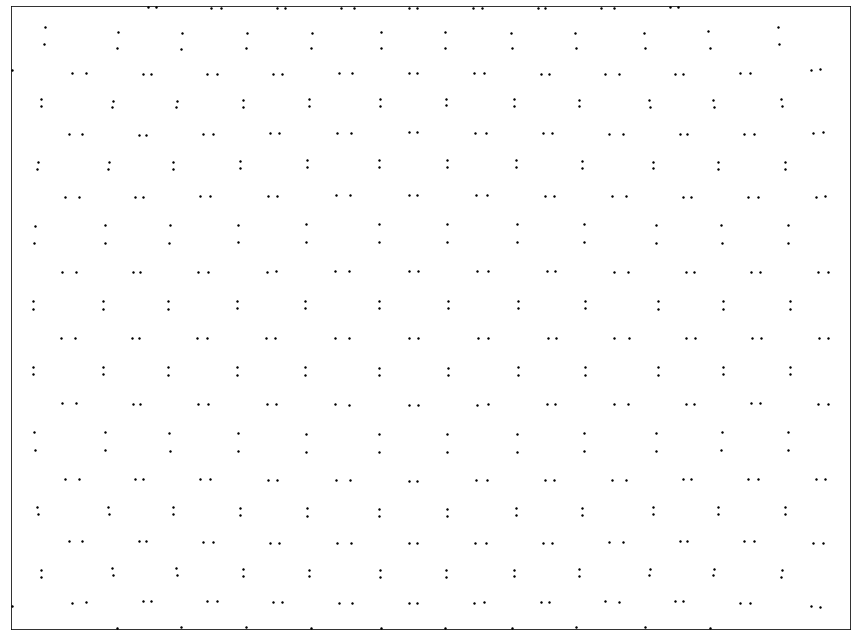

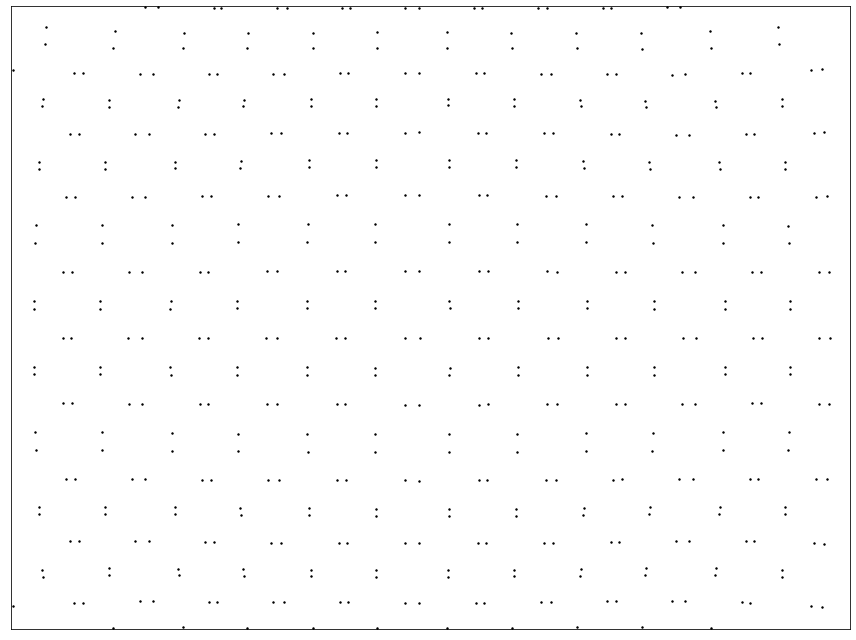

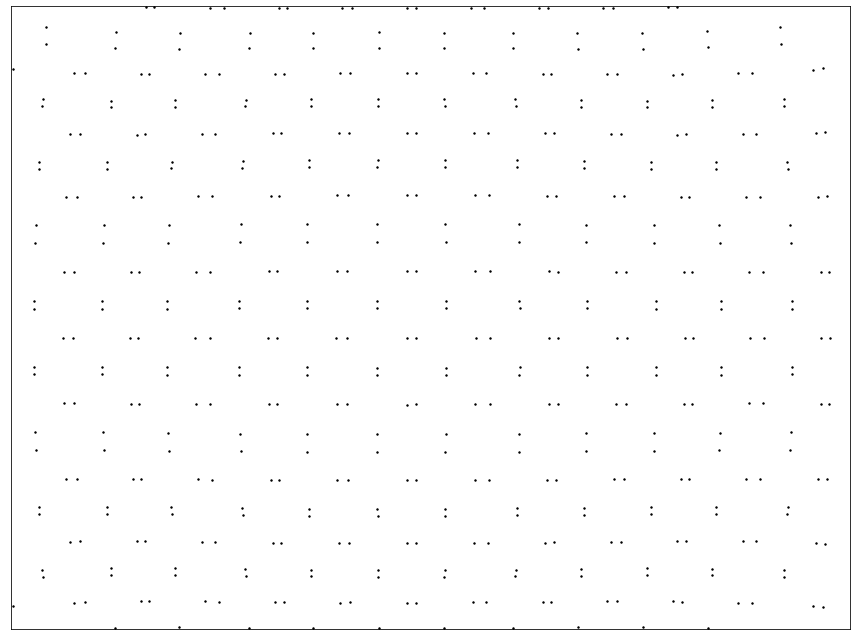

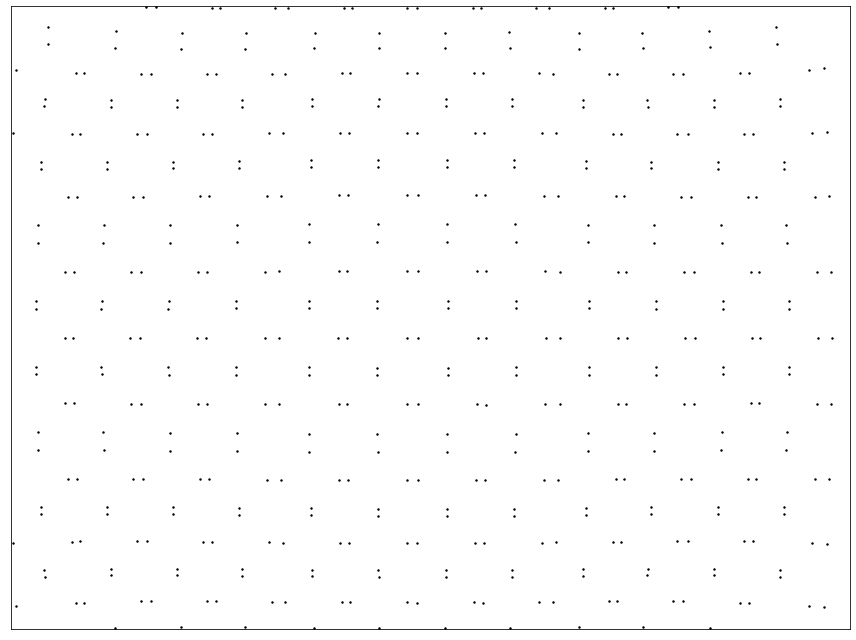

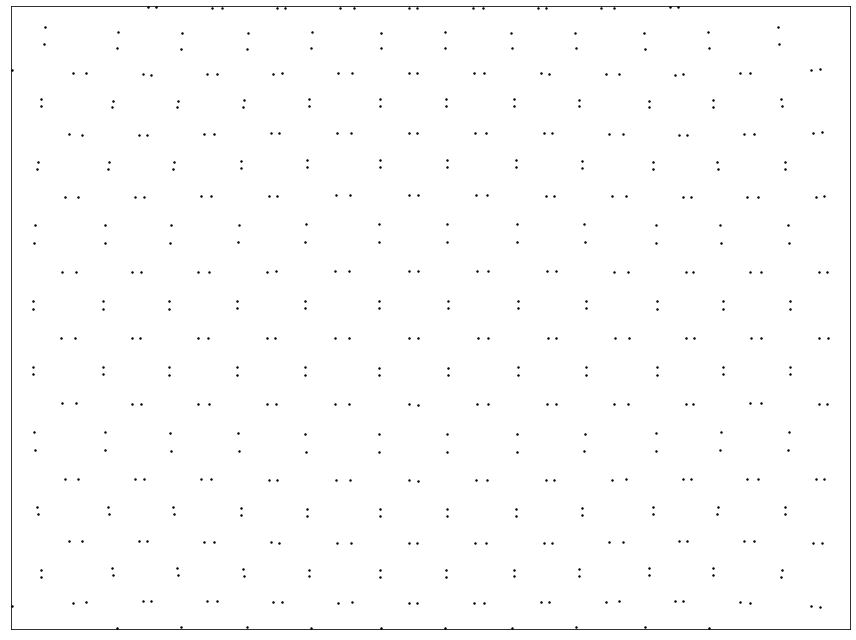

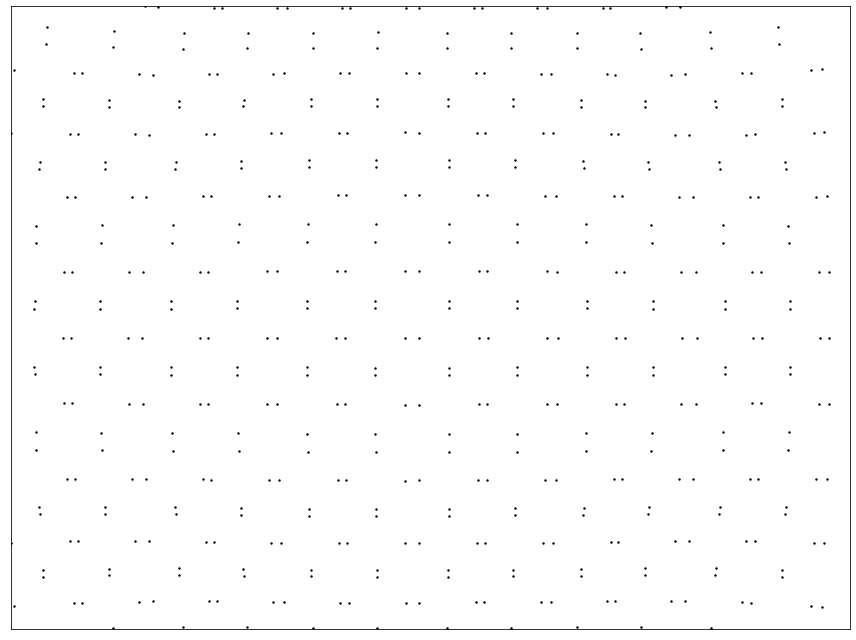

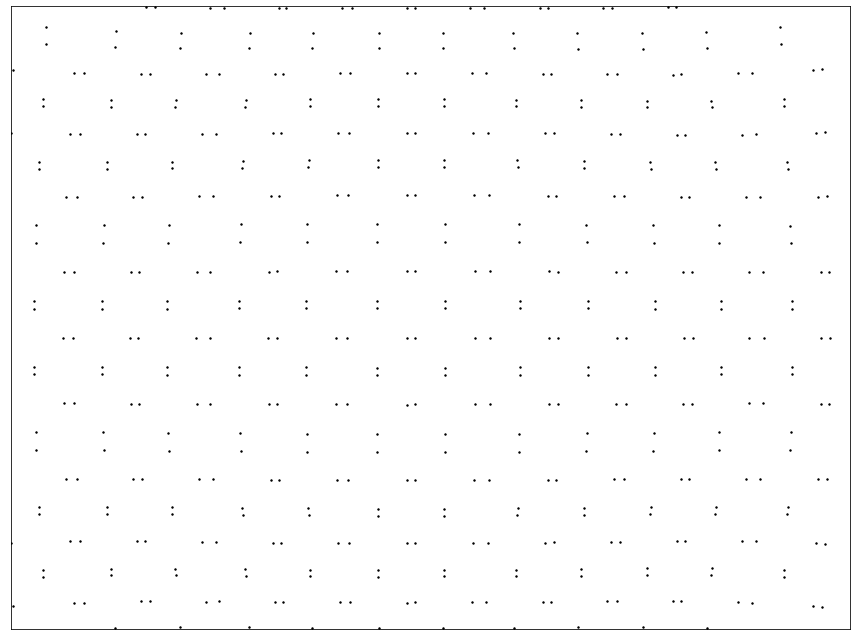

In [24]:
bolt_count = 4
bolt_positions = geo.get_bolt_locations_barrel(pmt_locations, bolt_count)
ring_positions = get_ring_positions(bolt_positions, pmt_locations.keys(), bolt_count)
ring_orientations = get_ring_orientations(bolt_positions, pmt_locations.keys(), bolt_count)
simulator = fit.PhotogrammetrySimulator(bolt_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)
image_feature_locations = simulator.get_image_feature_locations(area_restrict = [[0, 4000], [0, 3000]], min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
print("Feature in image counts:", Counter(feature_counts.values()))
simulator.show_images(image_feature_locations, area=[[0,4000],[0,3000]])

=== Gaussian errors on feature image locations: 0.5 ===
Feature in image counts: Counter({2: 2550})
50 images with total of  2550 features
image 0 reprojection errors:    average: 5.740033344944953    max: 19.016763581757868
image 1 reprojection errors:    average: 6.494904957075815    max: 21.58574951540211
image 2 reprojection errors:    average: 6.605818079240123    max: 13.995056453081329
image 3 reprojection errors:    average: 6.042106015599981    max: 14.930884195649453
image 4 reprojection errors:    average: 6.167473435456502    max: 13.718328573042717
image 5 reprojection errors:    average: 6.150266442720099    max: 13.322226974644924
image 6 reprojection errors:    average: 6.737220981590268    max: 18.745330957966857
image 7 reprojection errors:    average: 6.1962949605043685    max: 16.760334874567356
image 8 reprojection errors:    average: 6.584343715309599    max: 16.79408763862696
image 9 reprojection errors:    average: 7.108706467697414    max: 17.156772666365505
im

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3335e+05                                    1.79e+06    
       1              2         5.6622e+03      1.28e+05       7.73e+01       1.44e+04    
       2              3         3.7846e+03      1.88e+03       4.45e+01       1.45e+04    
       3              4         3.1525e+03      6.32e+02       1.09e+01       3.83e+03    
       4              5         2.9630e+03      1.89e+02       5.87e+00       1.30e+03    
       5              6         2.8287e+03      1.34e+02       4.79e+00       6.78e+02    
       6              7         2.7317e+03      9.69e+01       3.63e+00       2.99e+02    
       7              8         2.6696e+03      6.21e+01       2.39e+00       1.70e+02    
       8              9         2.6356e+03      3.41e+01       1.28e+00       3.58e+02    
       9             10         2.6203e+03      1.52e+01       4.96e-01       1.01e+02    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6385e+05                                    2.59e+06    
       1              2         1.8912e+04      1.45e+05       8.17e+01       4.17e+04    
       2              3         1.3465e+04      5.45e+03       8.02e+01       1.15e+05    
       3              4         1.1441e+04      2.02e+03       2.16e+01       1.05e+04    
       4              5         1.1080e+04      3.61e+02       5.99e+00       8.44e+02    
       5              6         1.1009e+04      7.12e+01       1.46e+00       3.12e+02    
       6              7         1.0953e+04      5.56e+01       1.00e+00       4.18e+02    
       7              8         1.0902e+04      5.06e+01       1.27e+00       2.64e+02    
       8              9         1.0855e+04      4.75e+01       9.32e-01       3.63e+02    
       9             10         1.0809e+04      4.60e+01       1.21e+00       2.43e+02    

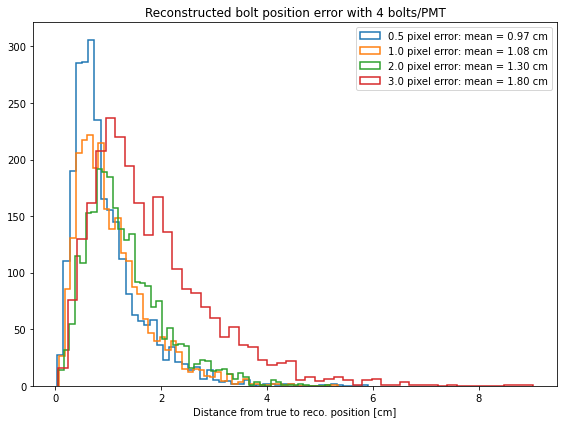

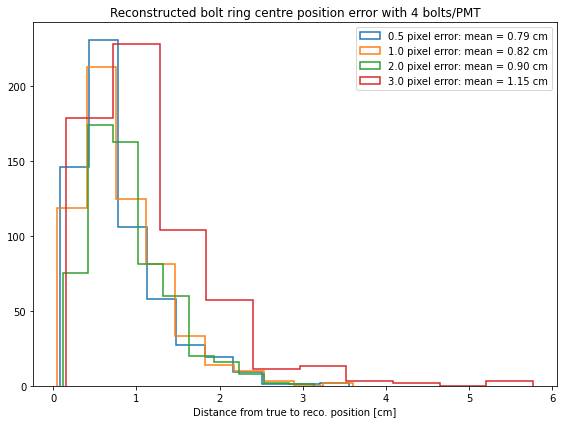

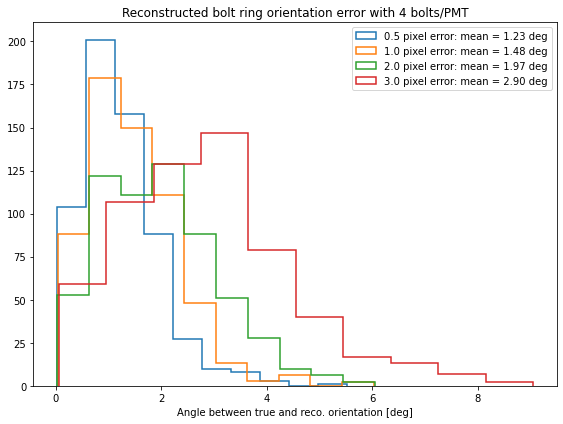

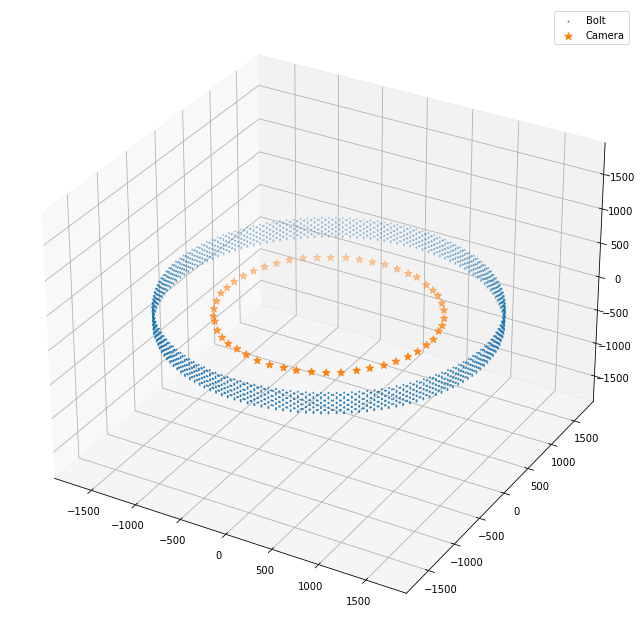

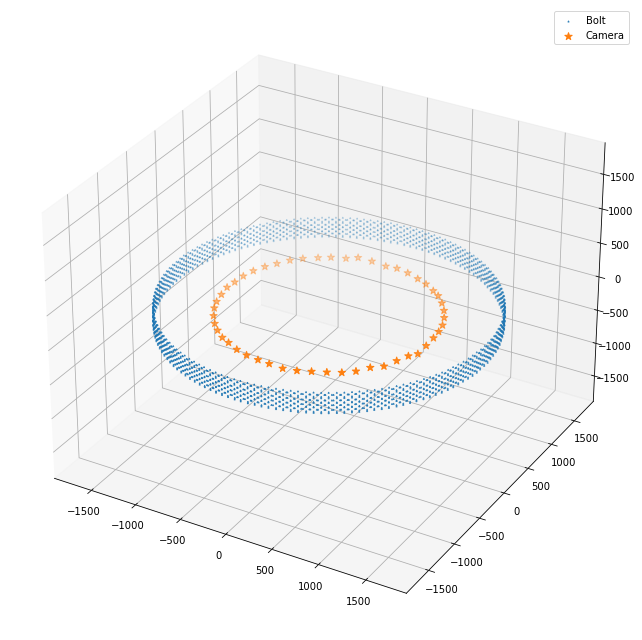

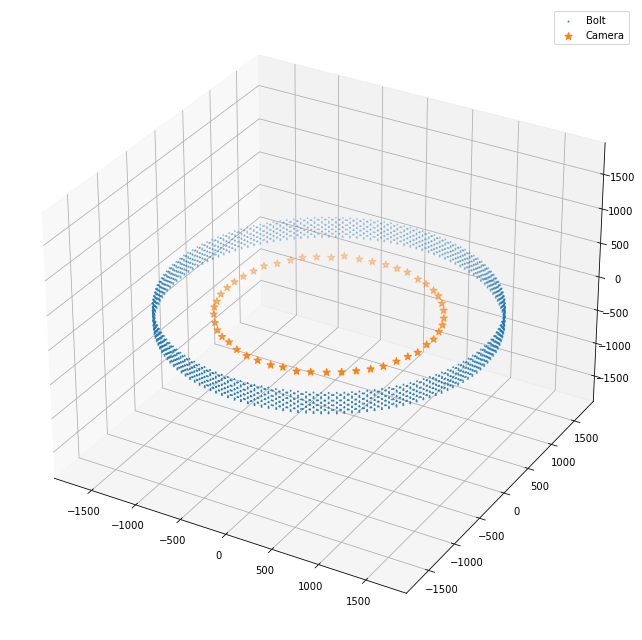

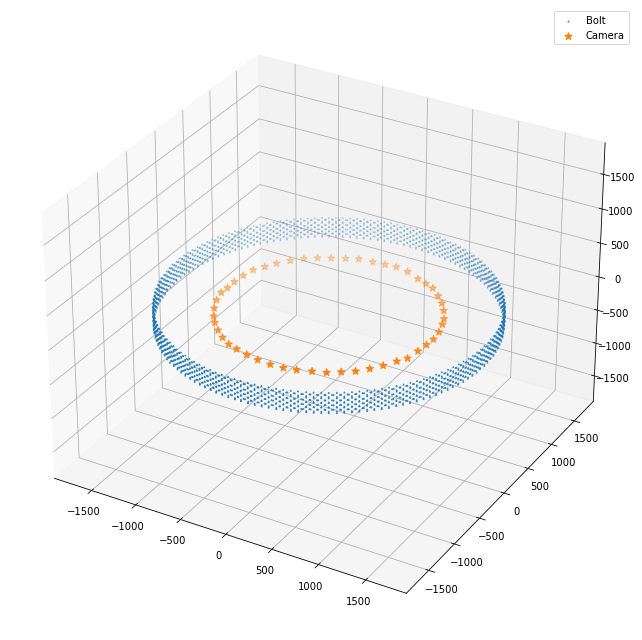

In [25]:
fig_bolt_pos, ax_bolt_pos = make_fig("Reconstructed bolt position error with {} bolts/PMT".format(bolt_count), "Distance from true to reco. position [cm]")
fig_ring_pos, ax_ring_pos = make_fig("Reconstructed bolt ring centre position error with {} bolts/PMT".format(bolt_count), "Distance from true to reco. position [cm]")
fig_ring_ang, ax_ring_ang = make_fig("Reconstructed bolt ring orientation error with {} bolts/PMT".format(bolt_count), "Angle between true and reco. orientation [deg]")
for pixel_error in [0.5, 1.0, 2.0, 3.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=[[1000, 3000], [750, 2250]], min_feature_count=2, pixel_error=pixel_error)
    feature_counts = Counter([f for i in smeared_feature_locations.values() for f in i.keys()])
    print("Feature in image counts:", Counter(feature_counts.values()))
    bolt_positions2 = {k: v for k, v in bolt_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_bolt_simulation(bolt_positions2, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_bolt_positions, position_errors = run_bolt_fit(fitter, bolt_positions2, xtol=1e-5)
    centre_errors = get_ring_centre_errors(reco_bolt_positions, ring_positions, bolt_count)
    orientation_errors = get_ring_orientation_errors(reco_bolt_positions, ring_orientations, bolt_count)
    ax_bolt_pos.hist(position_errors, bins=50, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors.mean()))
    ax_ring_pos.hist(centre_errors, bins=10, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors.mean()))
    ax_ring_ang.hist(orientation_errors, bins=10, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors.mean()))
    reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(bolt_positions, reco_bolt_positions)
    reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
    plot_reconstruction(reco_transformed, reco_cam_positions)
    bolt_position_errors[bolt_count][pixel_error] = position_errors.mean()
    ring_position_errors[bolt_count][pixel_error] = centre_errors.mean()
    ring_orientation_errors[bolt_count][pixel_error] = orientation_errors.mean()
ax_bolt_pos.legend(loc='upper right')
ax_ring_pos.legend(loc='upper right')
ax_ring_ang.legend(loc='upper right')

# Simulation with 6 bolts

Feature in image counts: Counter({4: 7778, 5: 672, 3: 100})


/home/prouse/work/PhotogrammetryAnalysis/pg_fitter_tools.py:203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


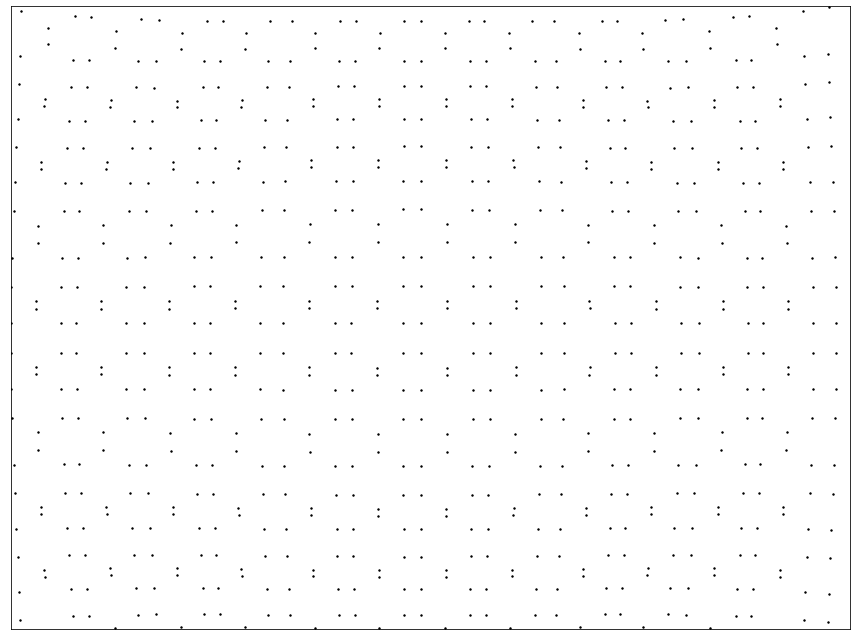

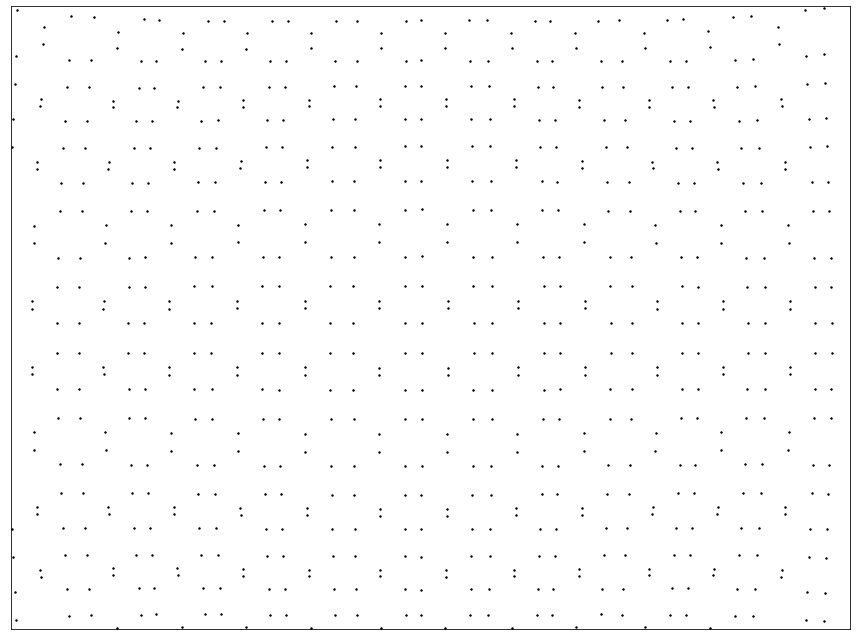

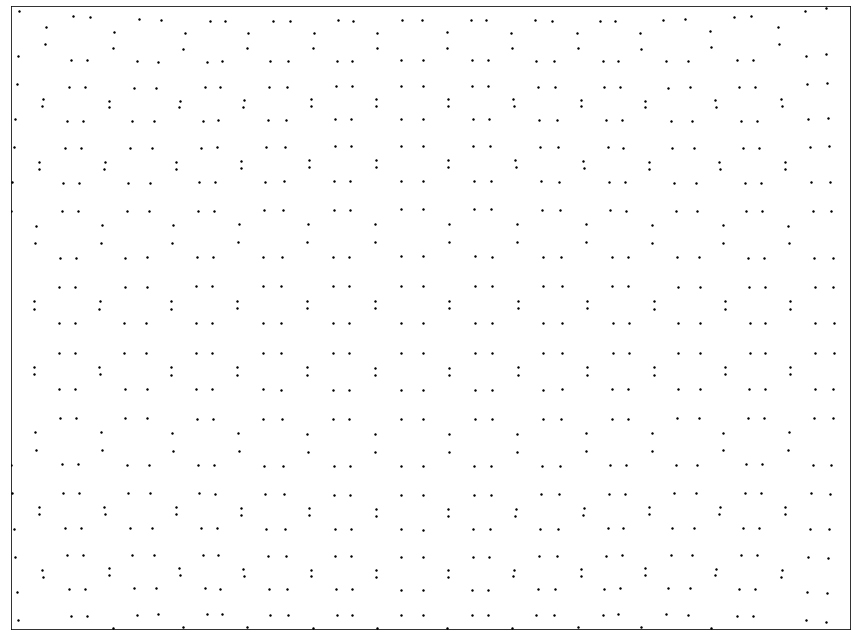

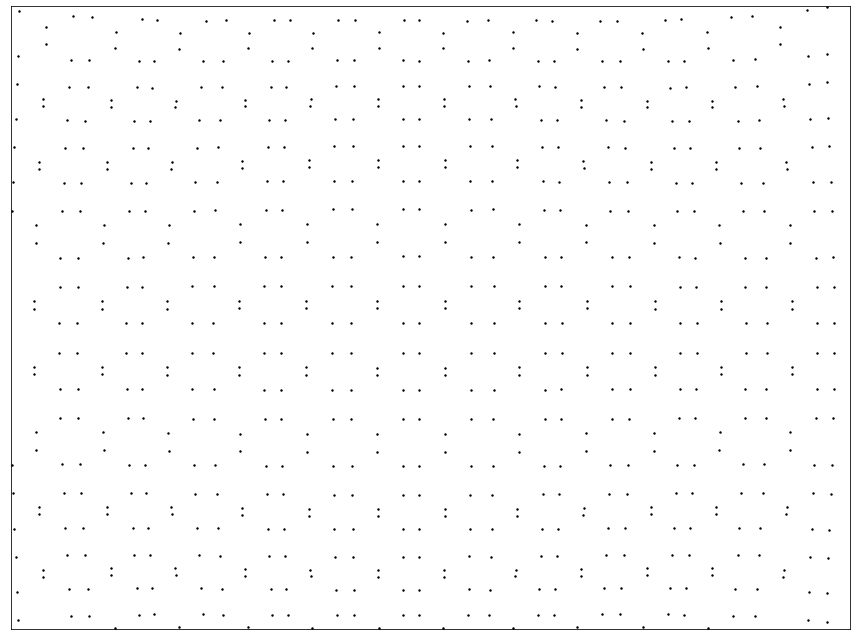

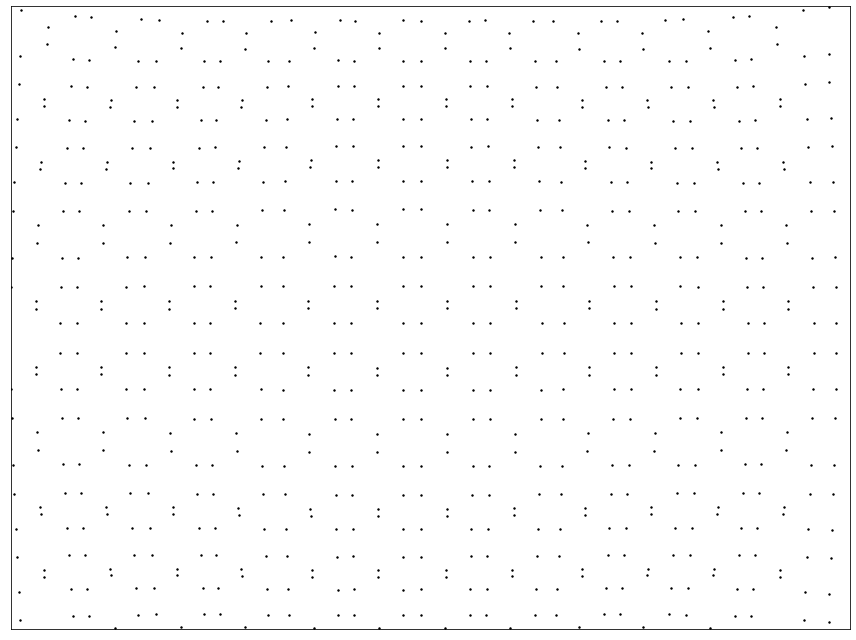

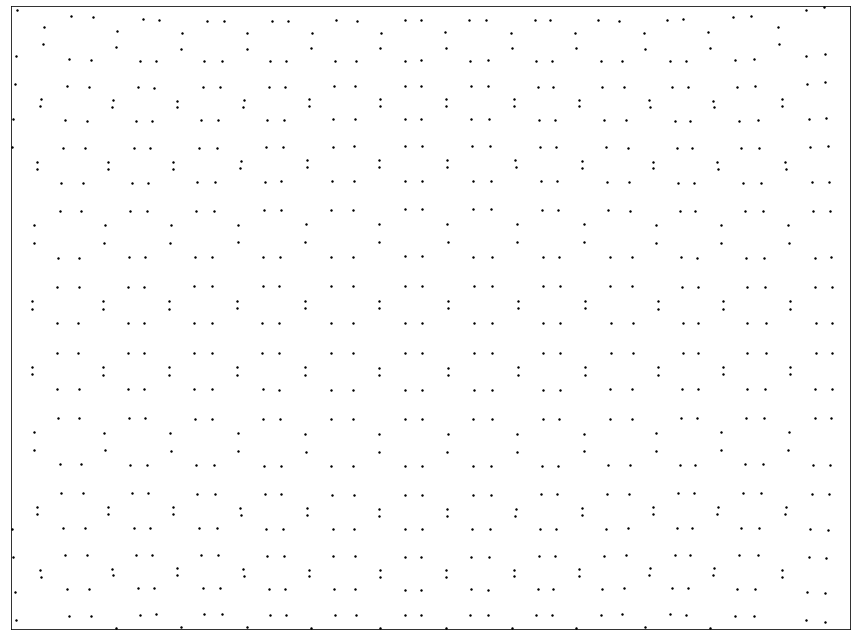

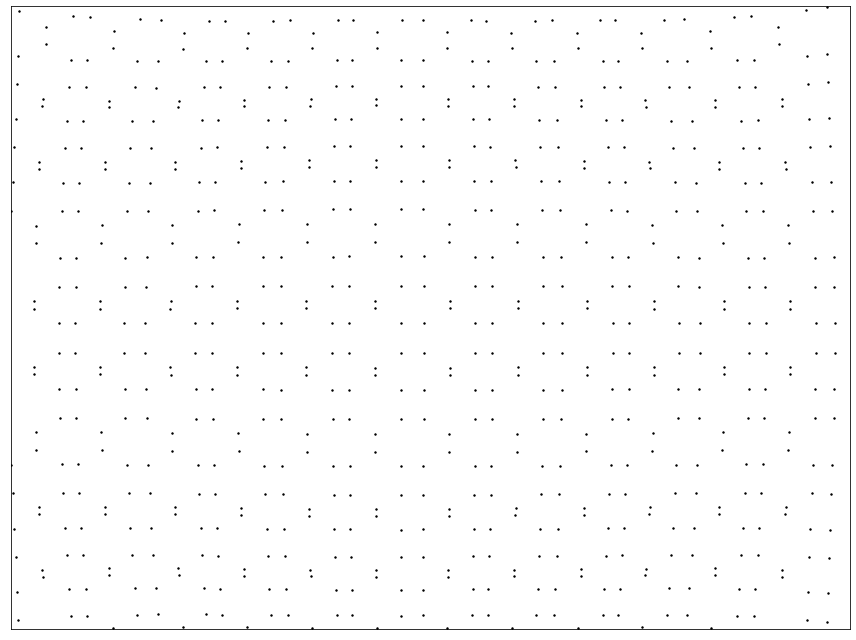

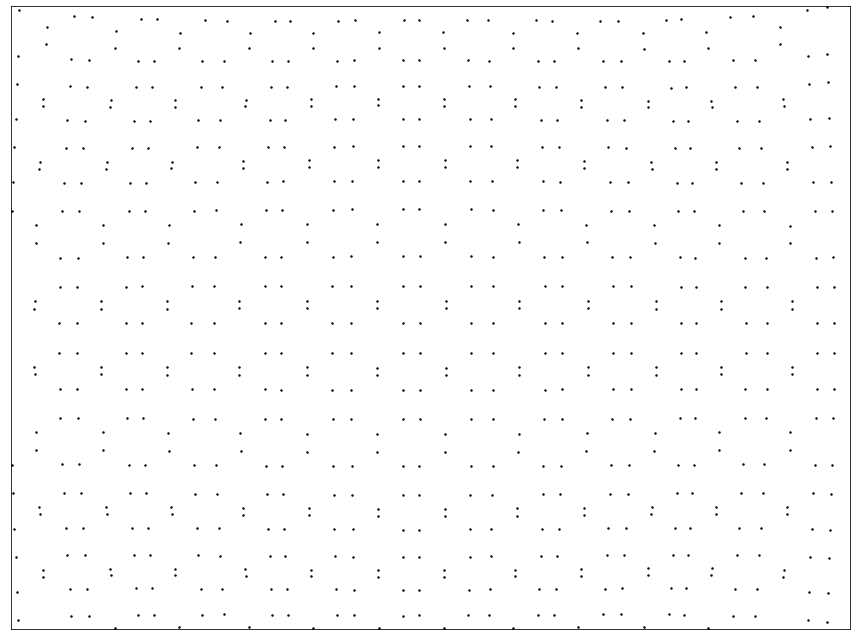

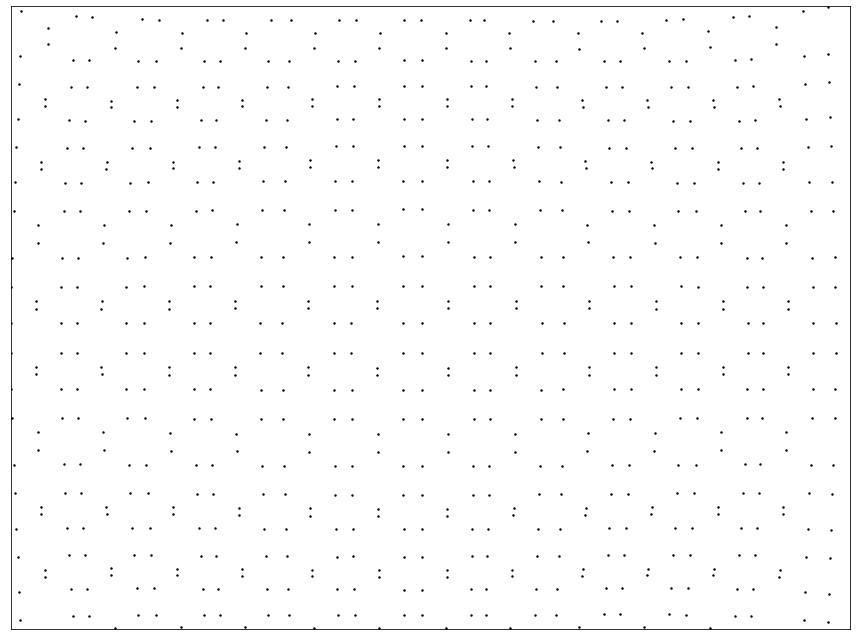

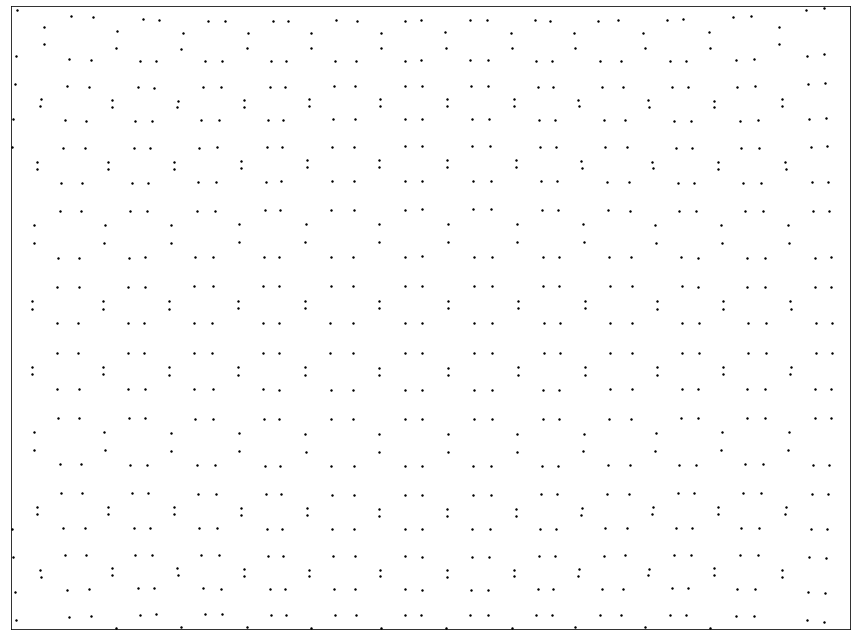

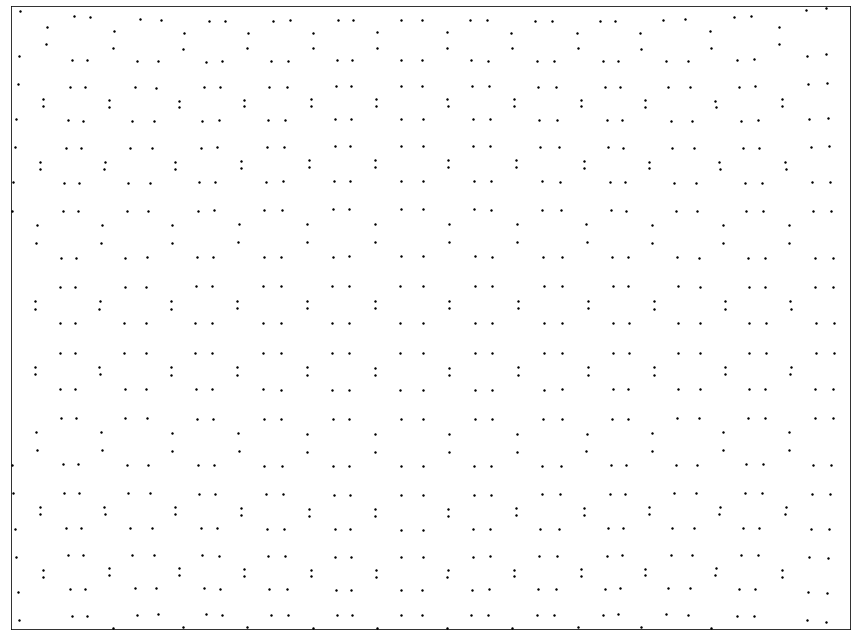

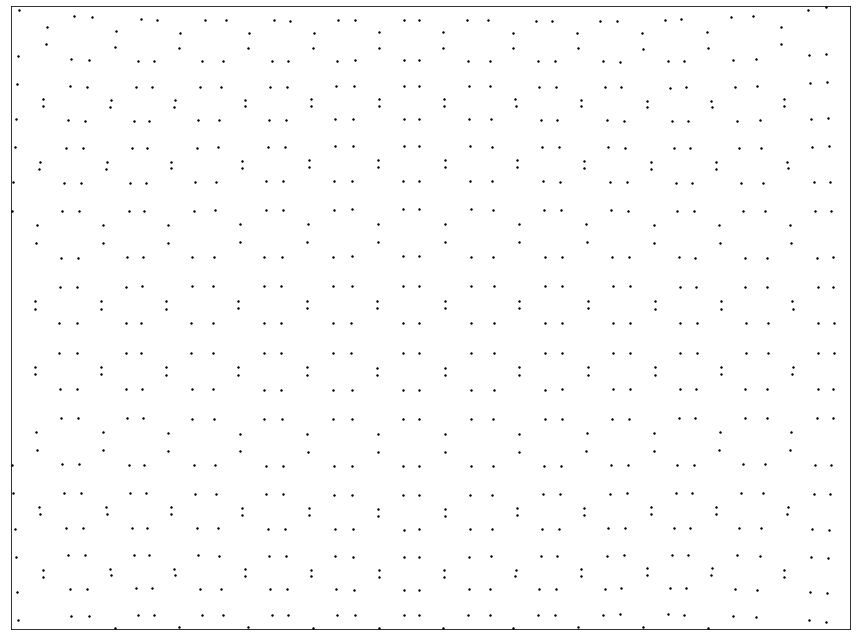

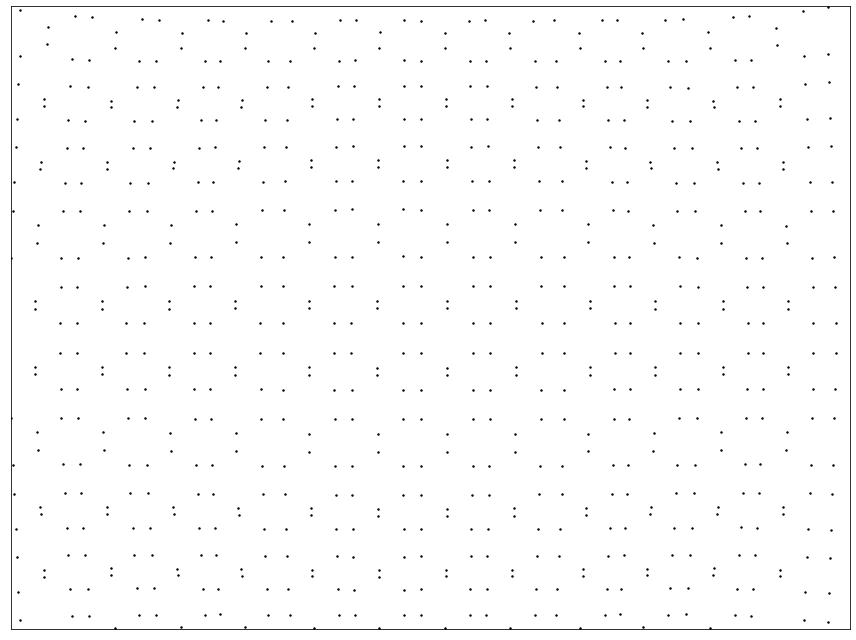

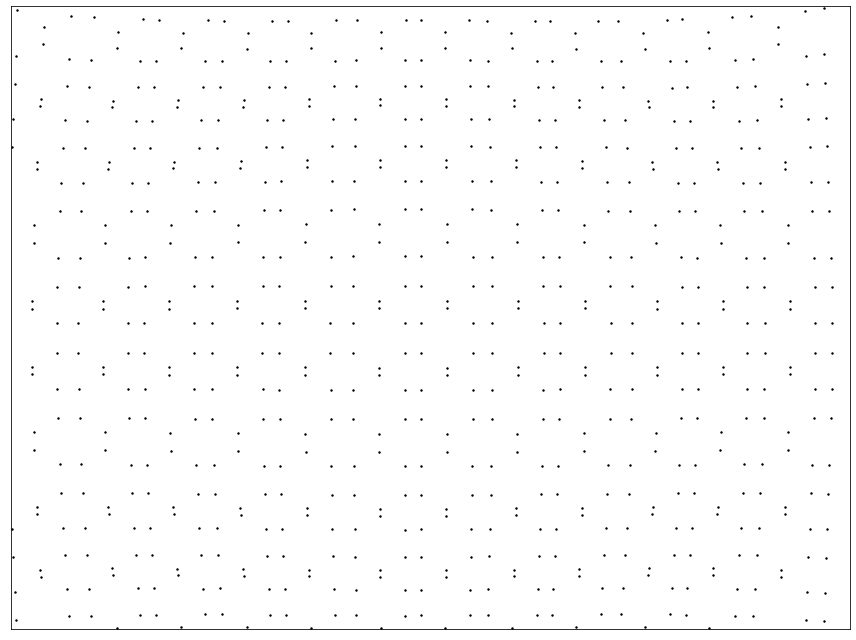

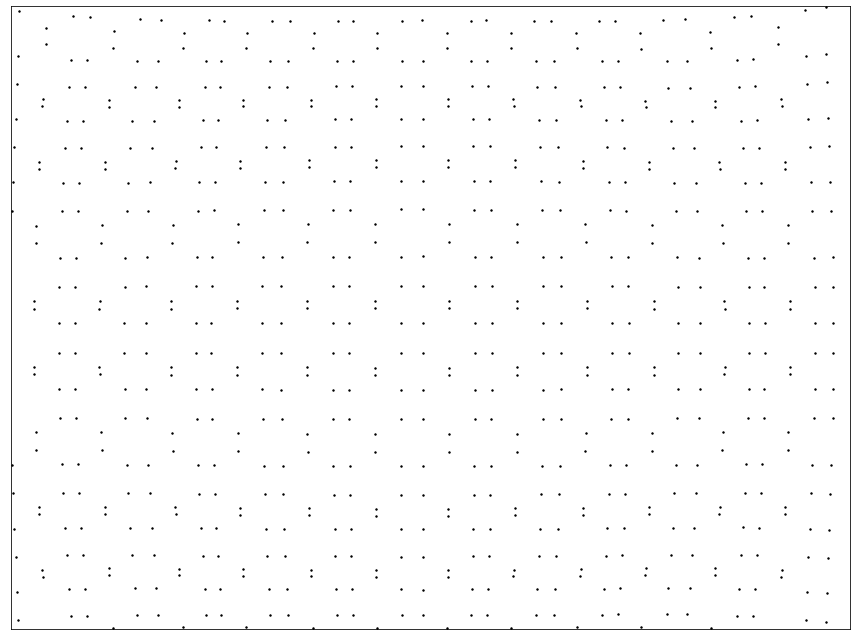

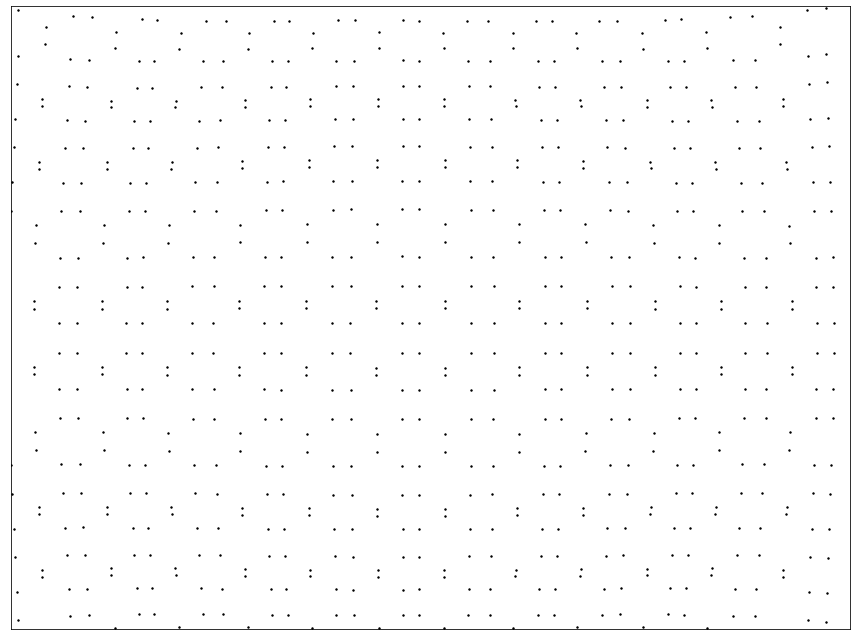

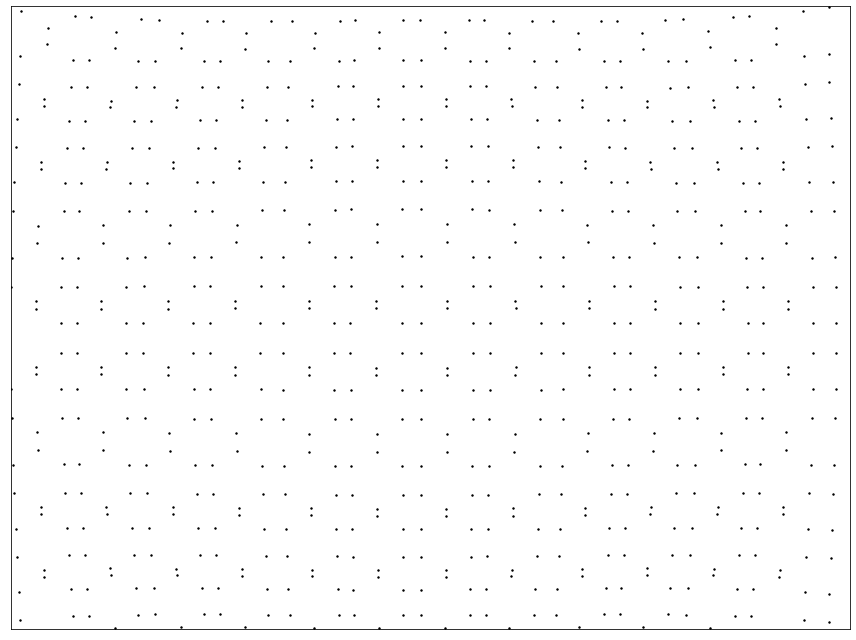

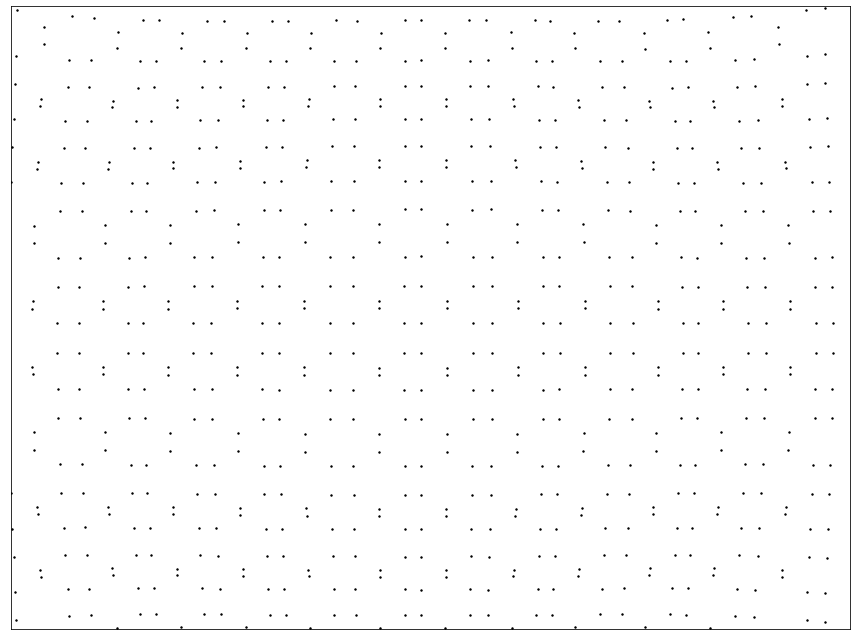

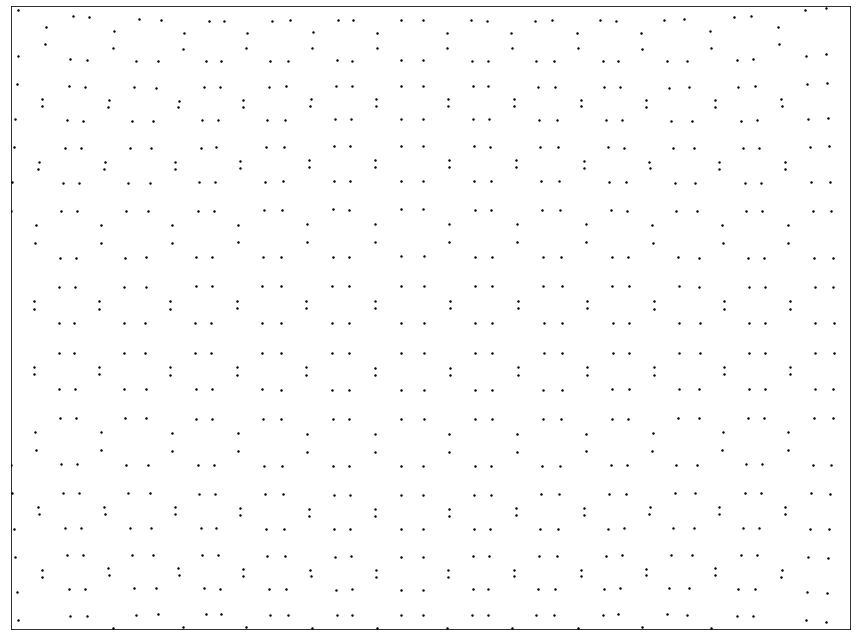

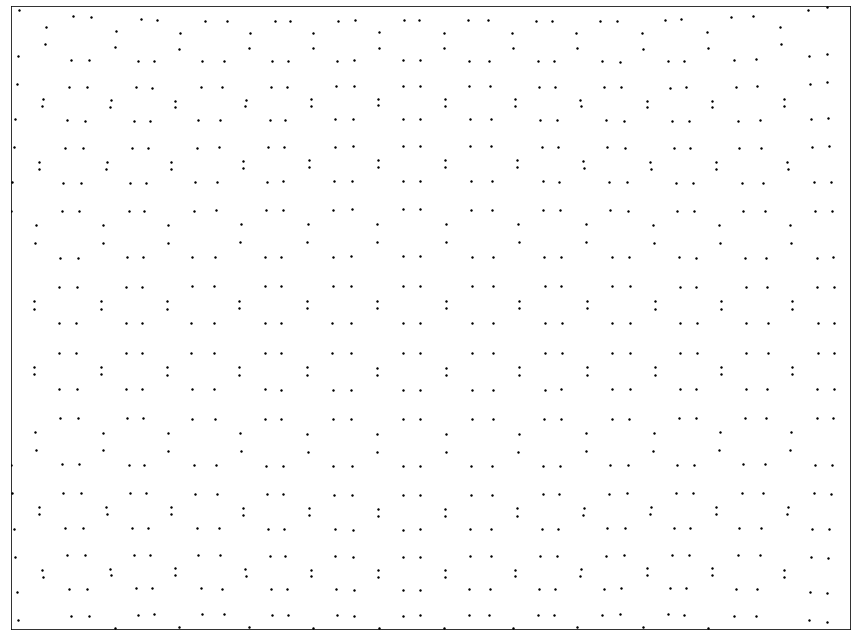

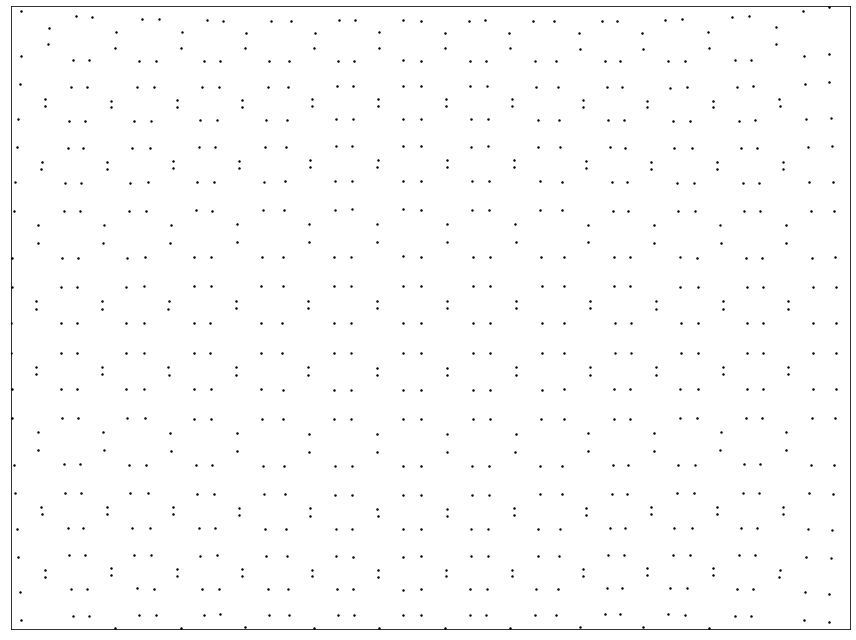

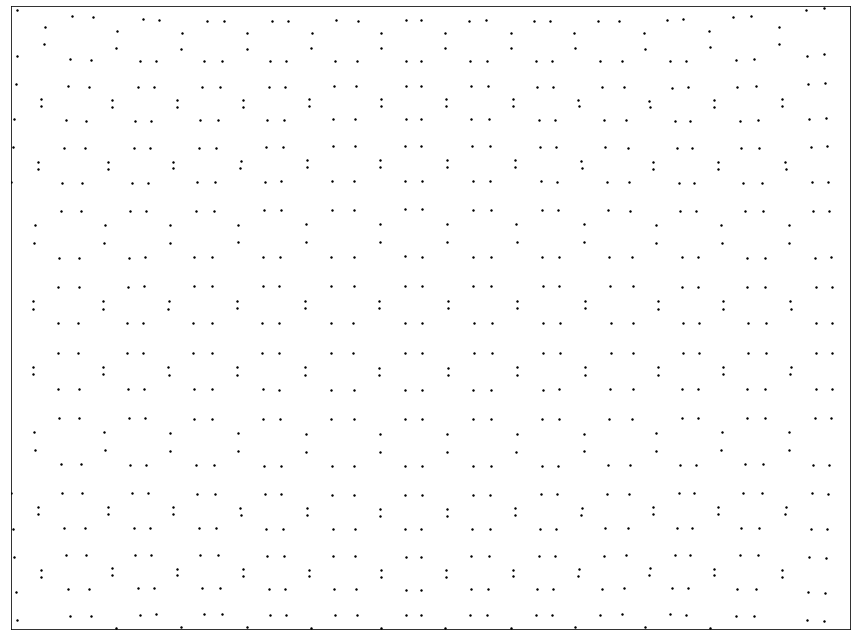

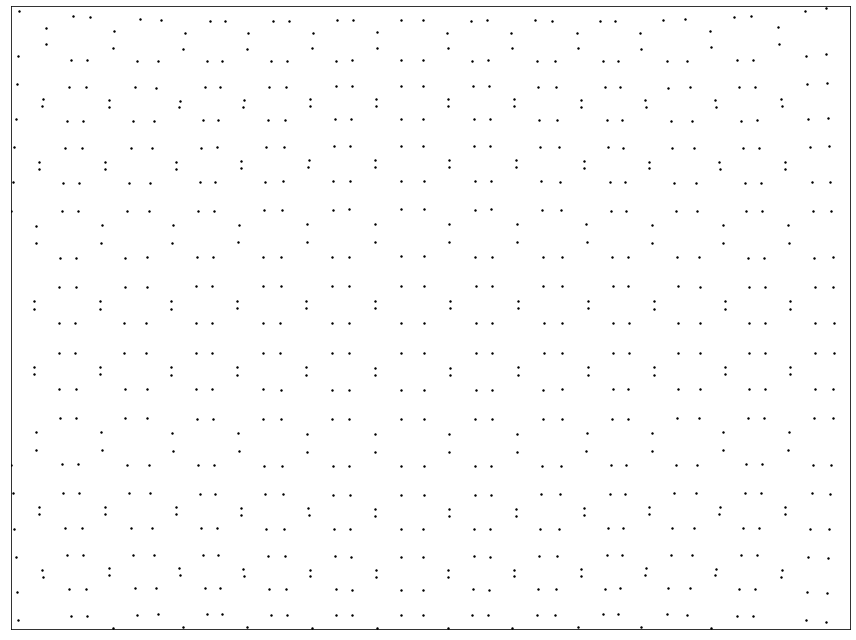

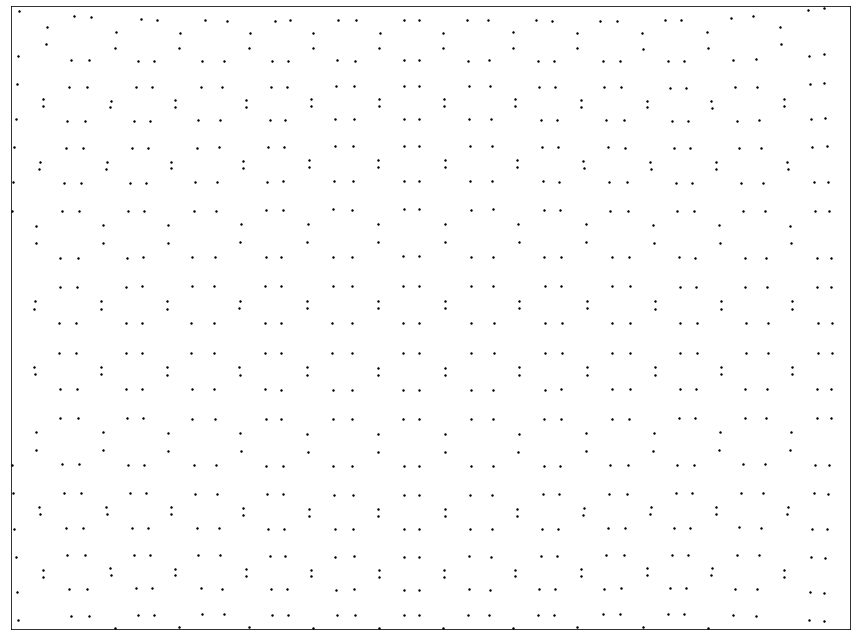

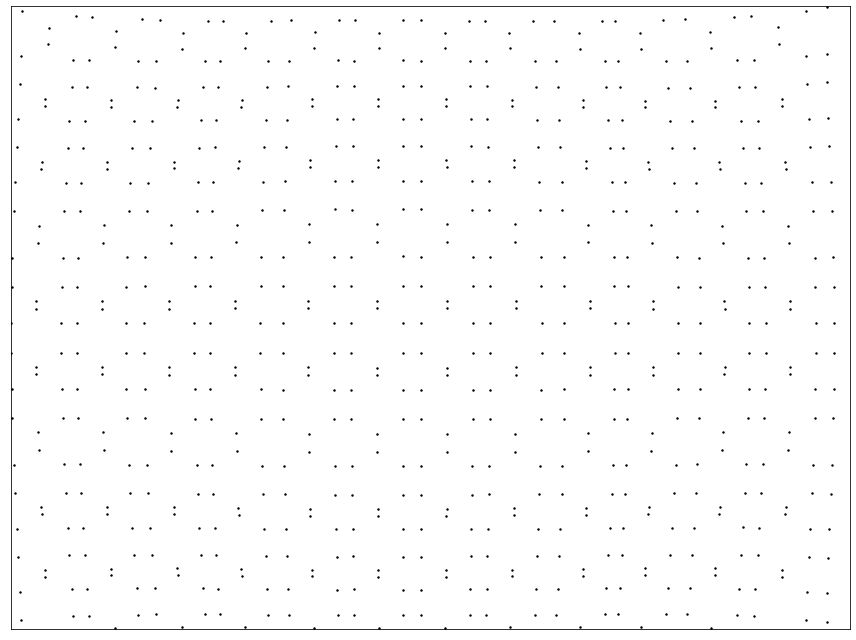

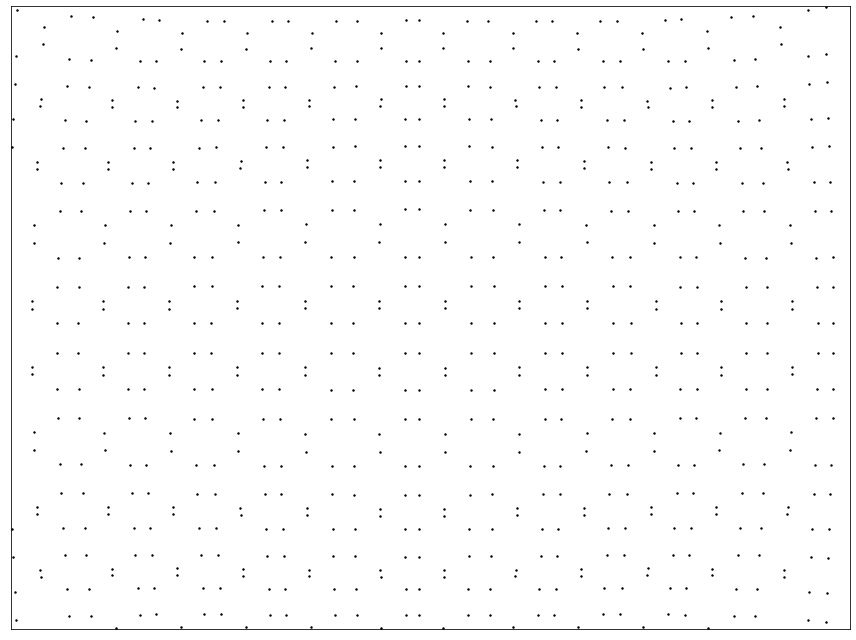

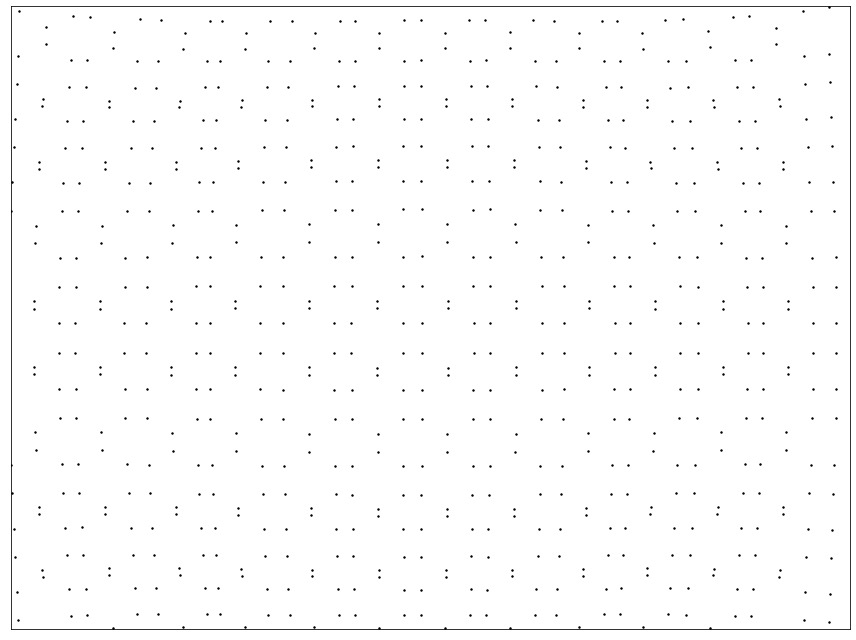

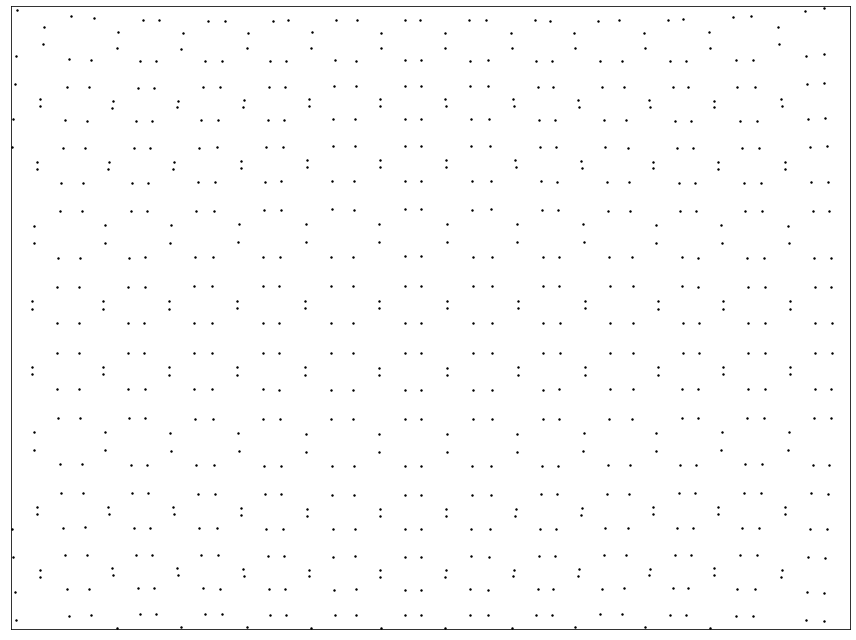

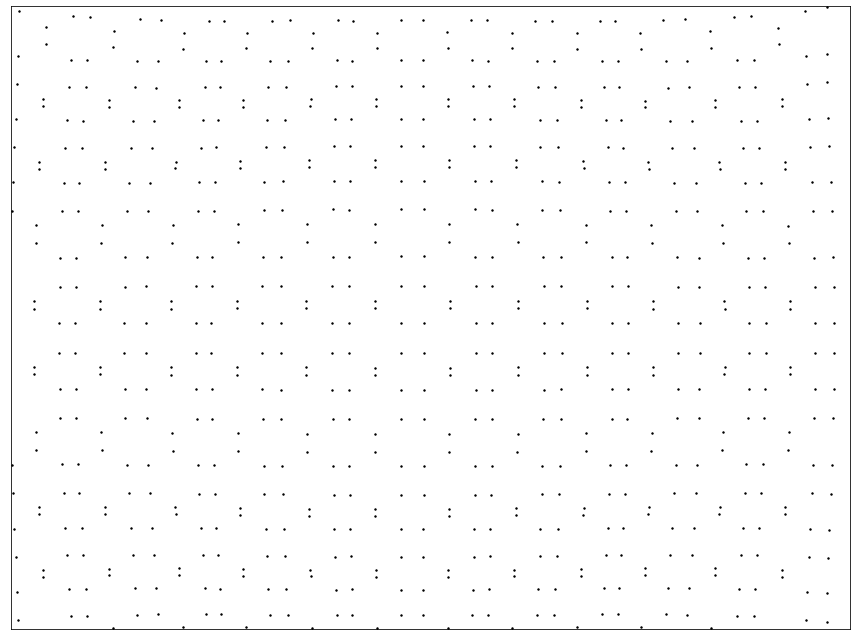

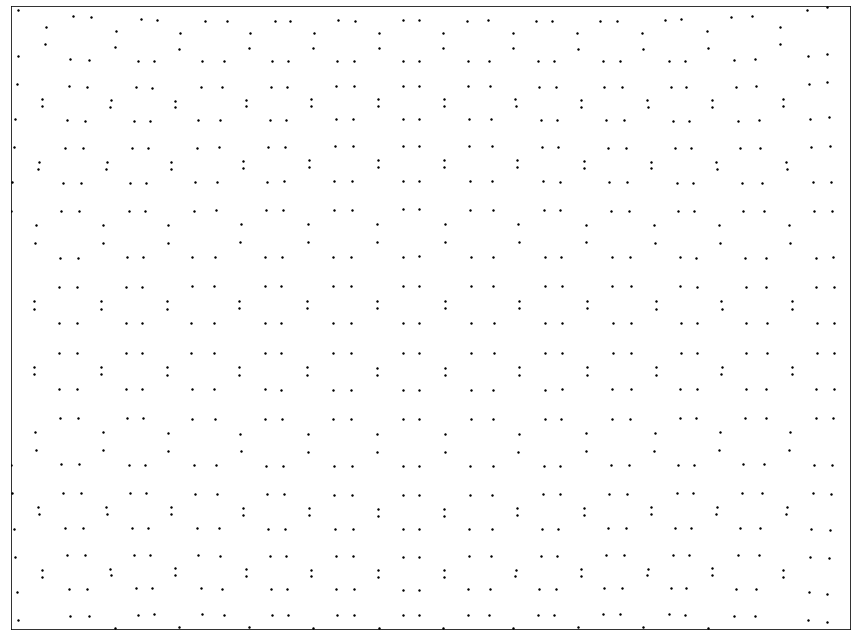

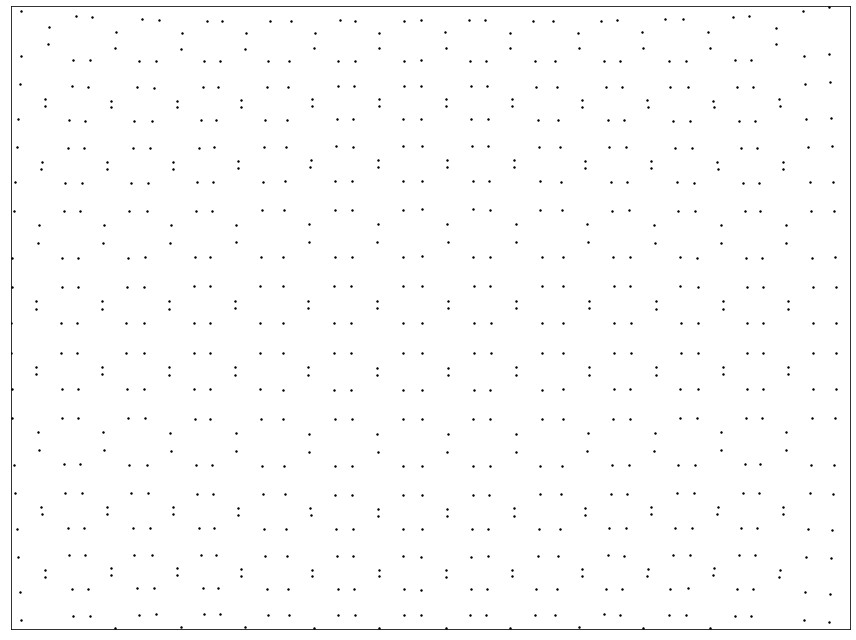

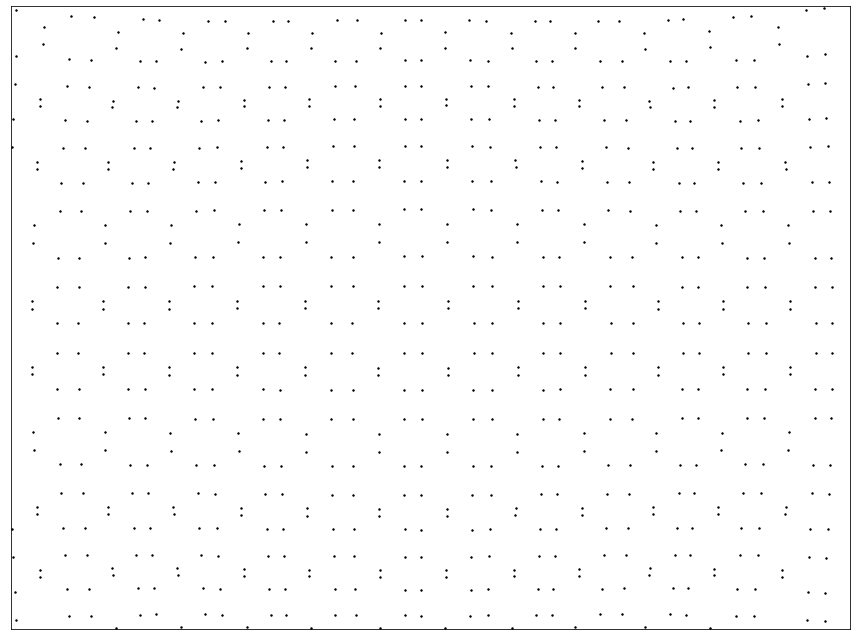

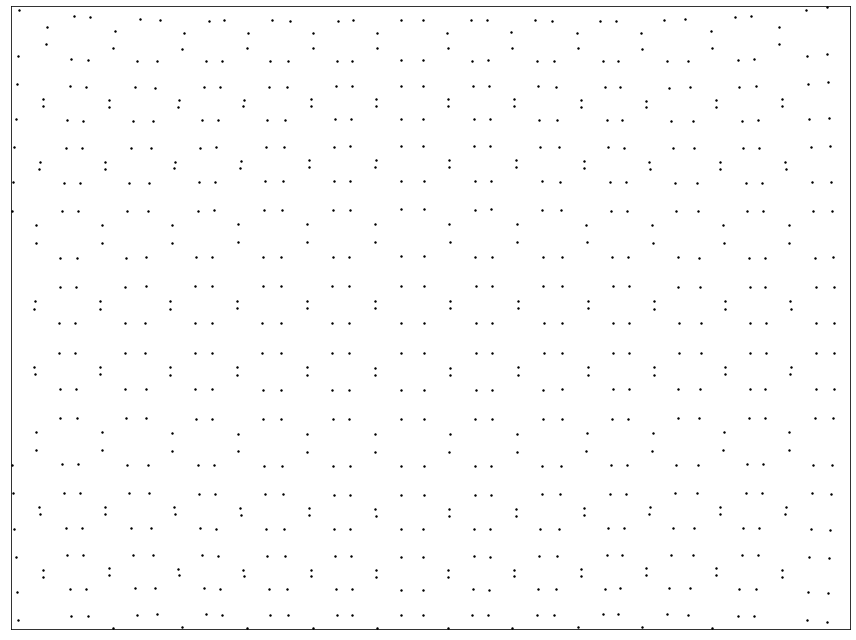

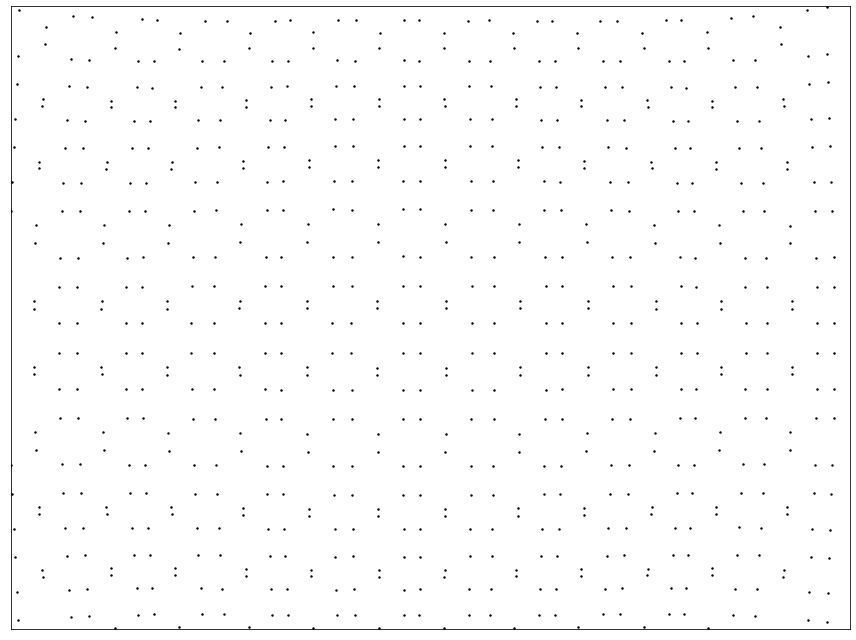

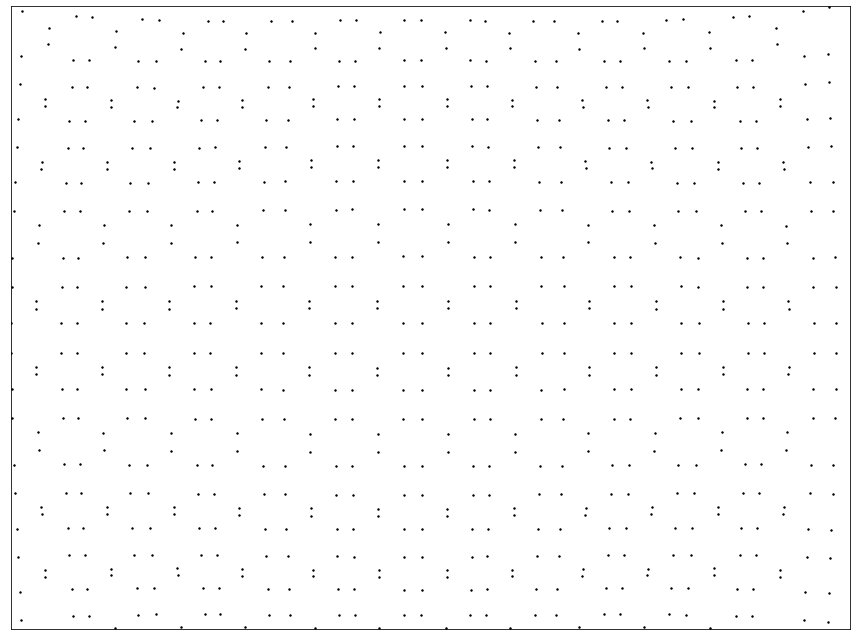

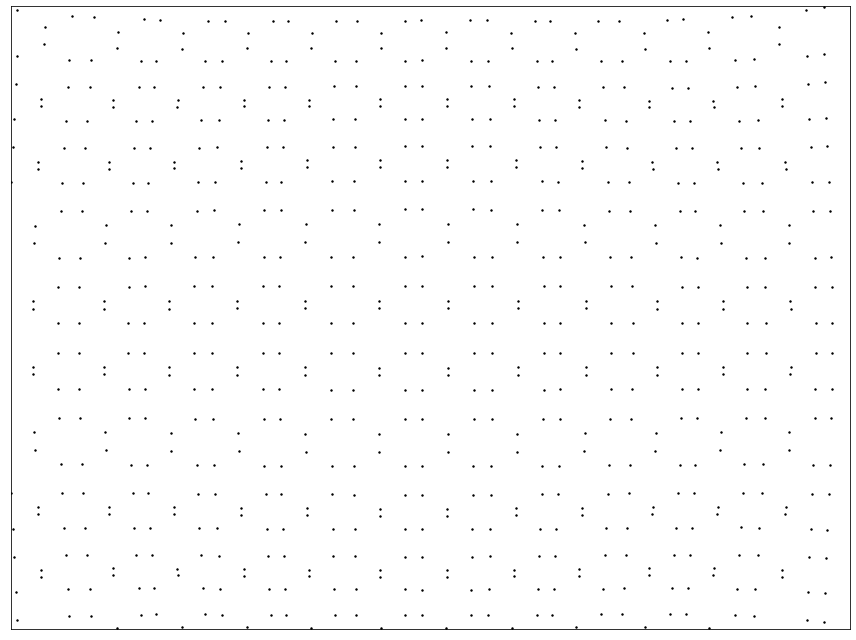

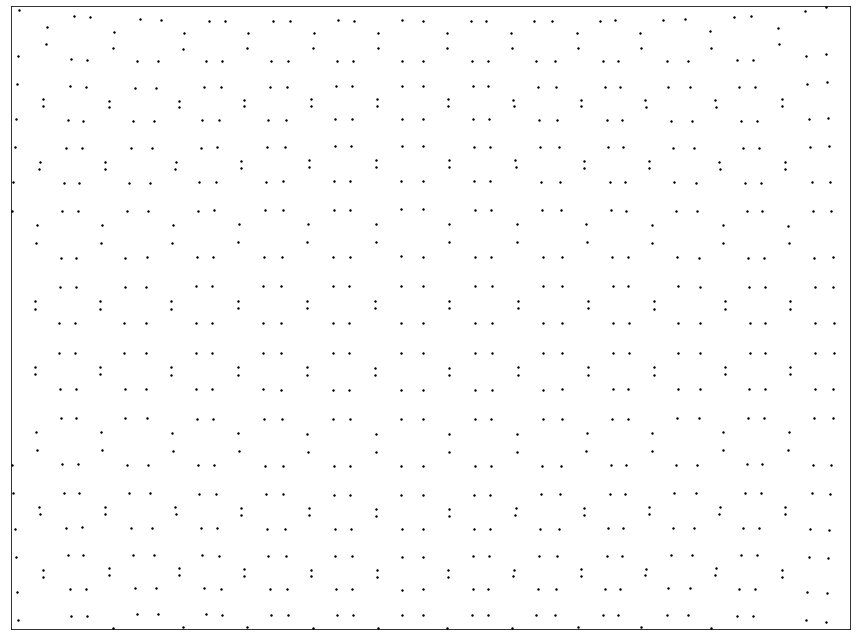

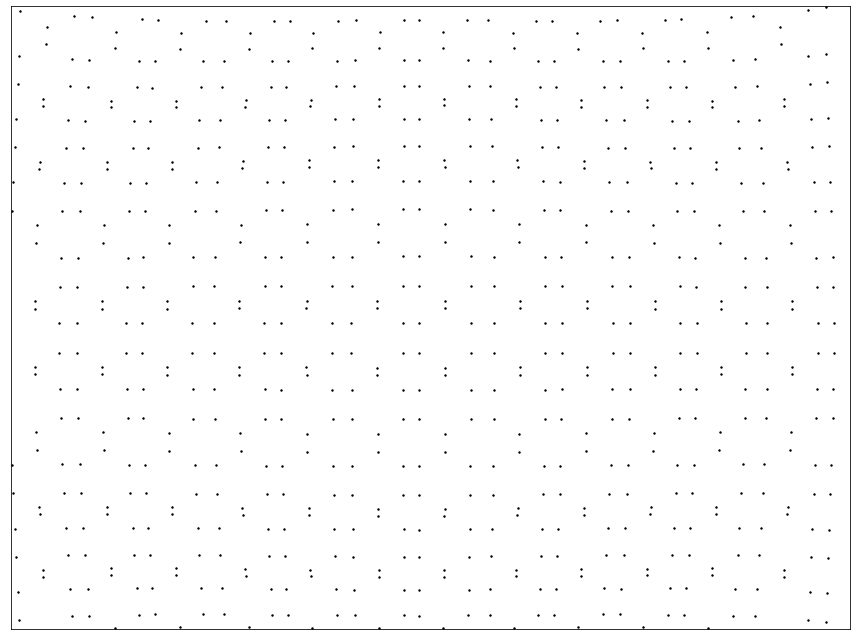

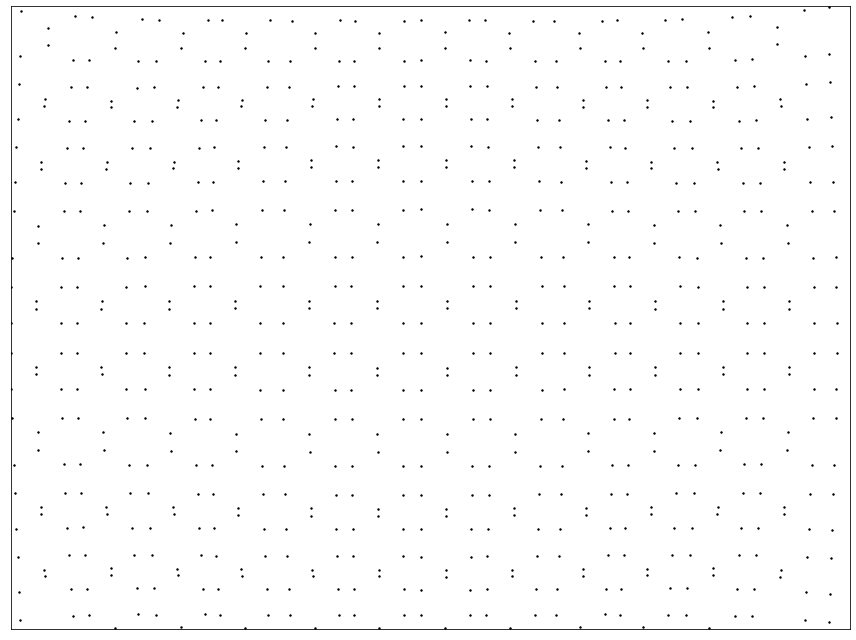

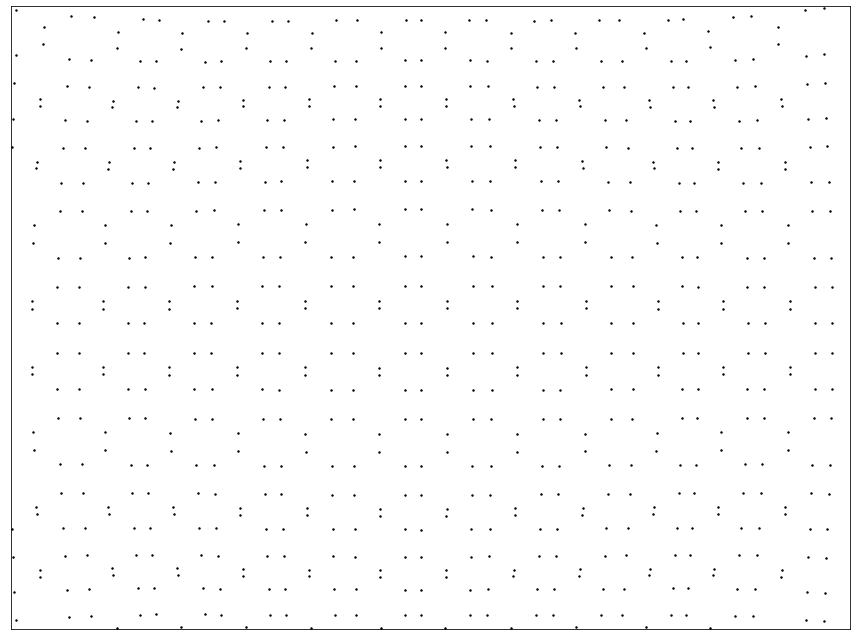

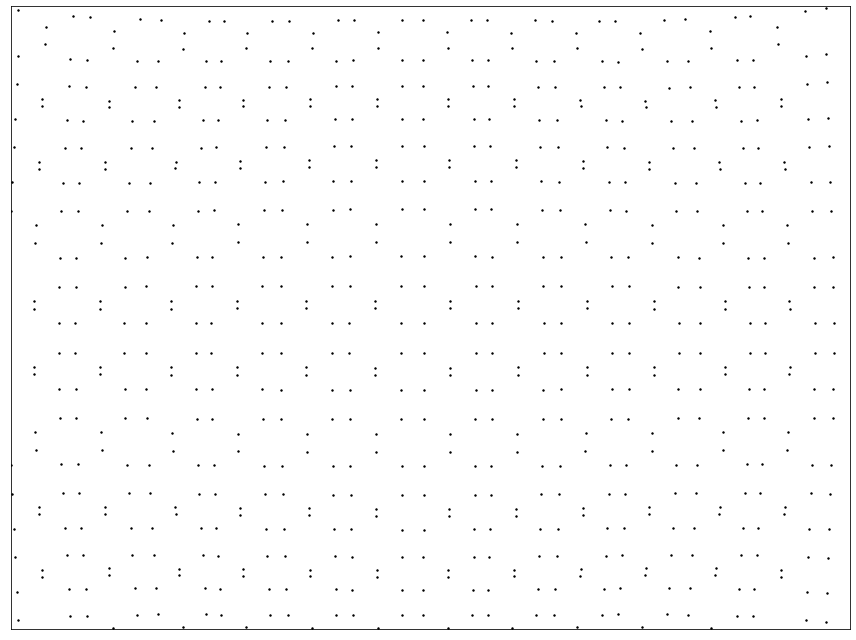

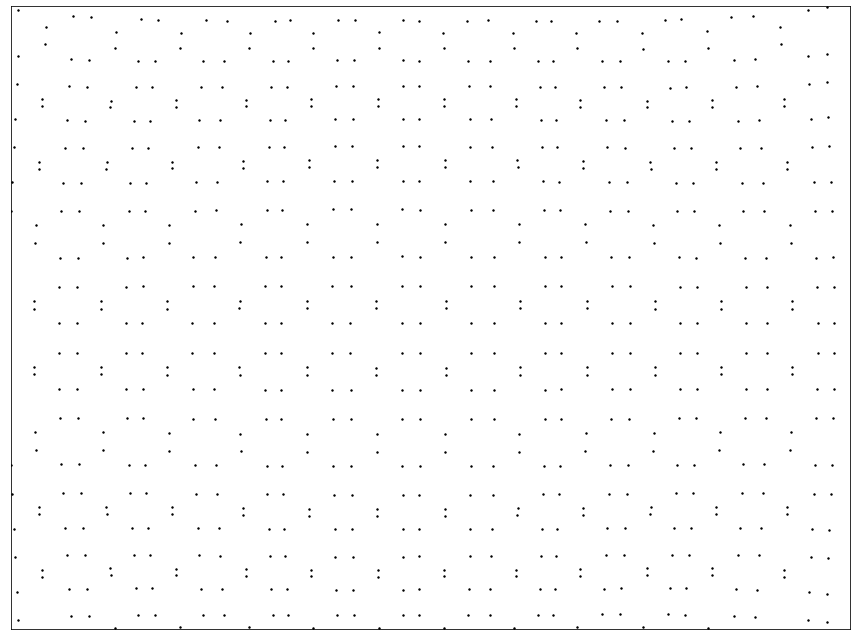

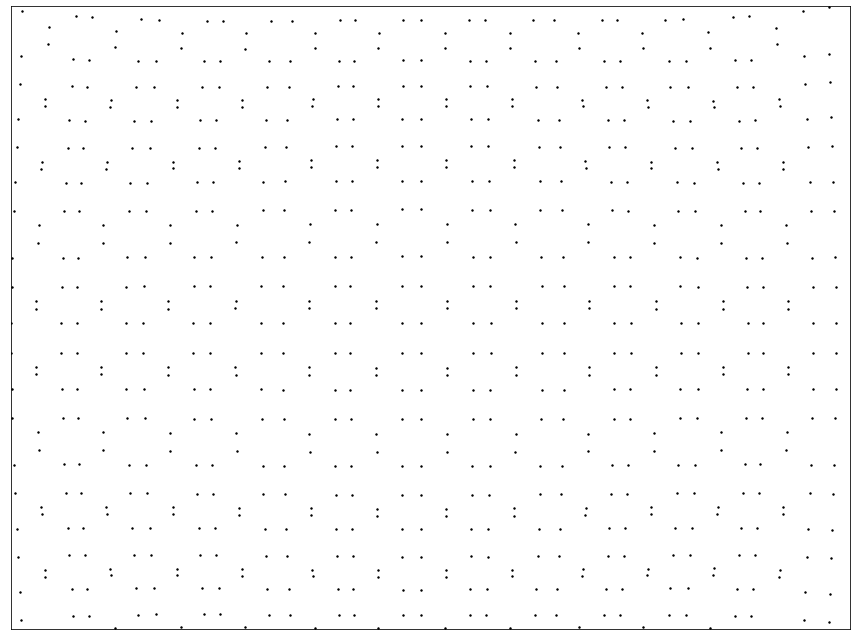

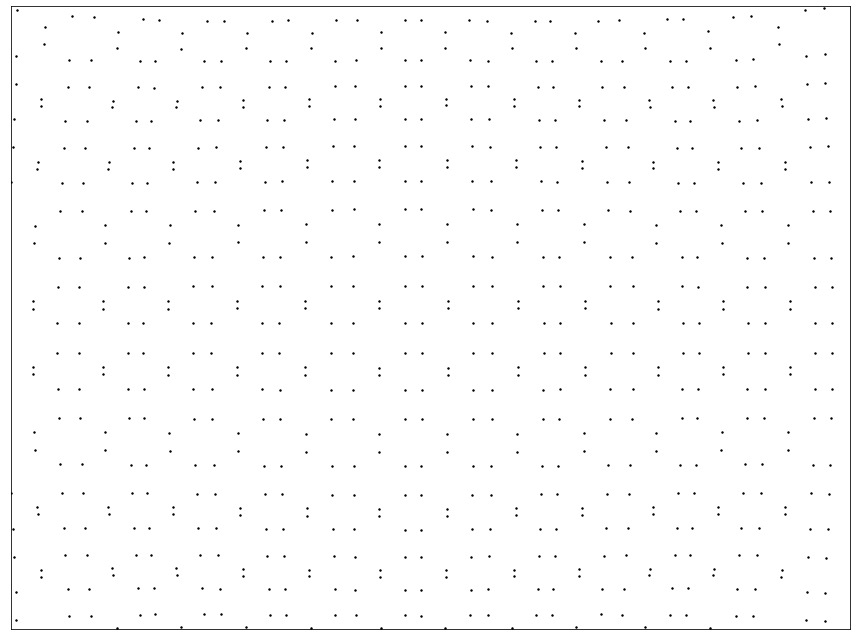

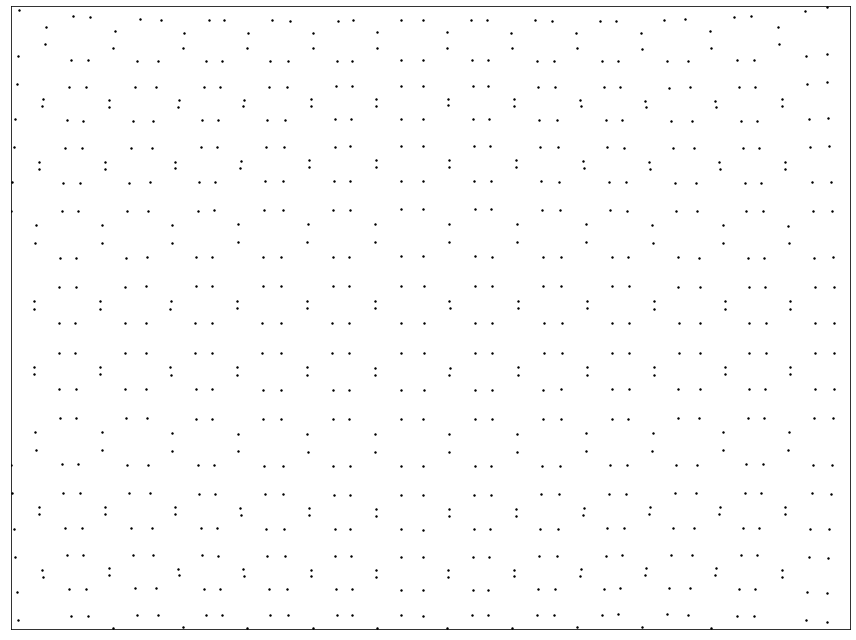

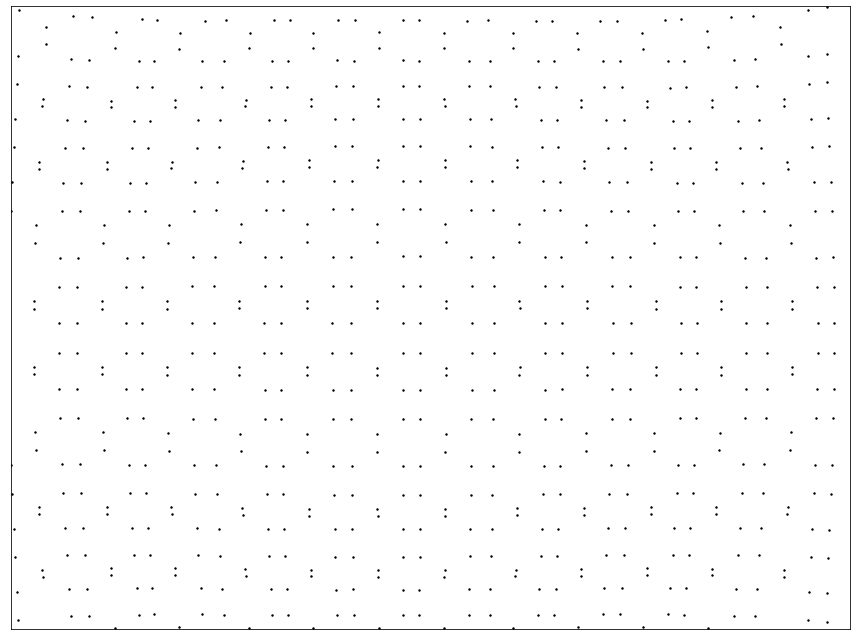

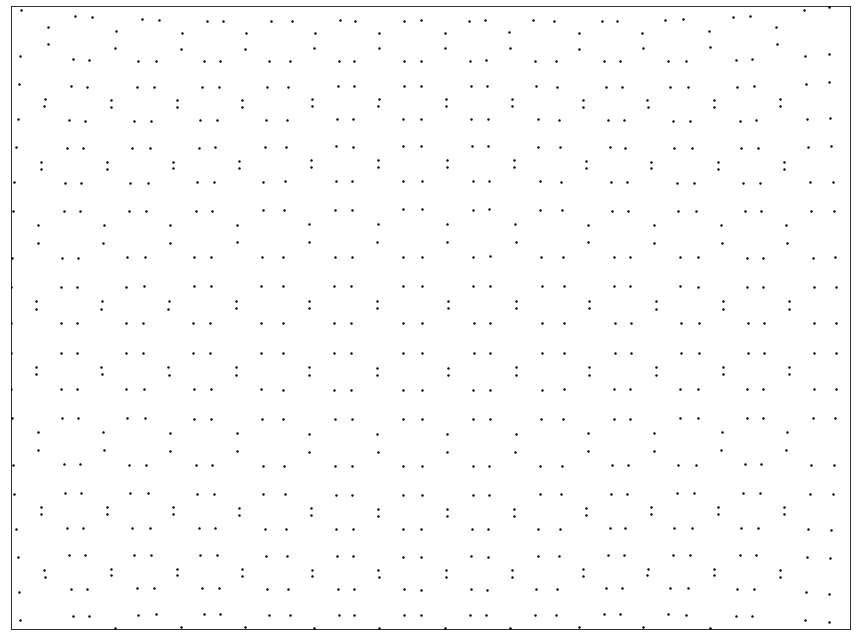

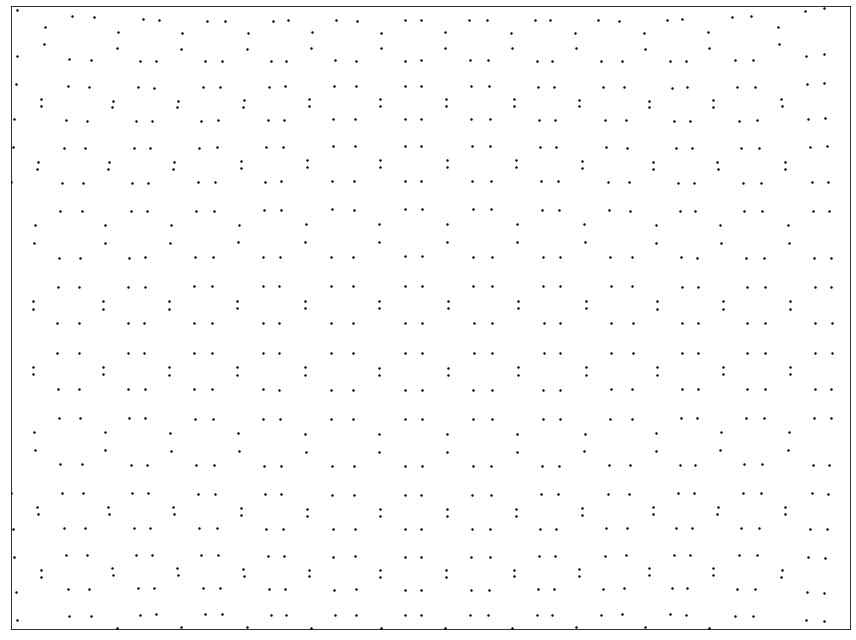

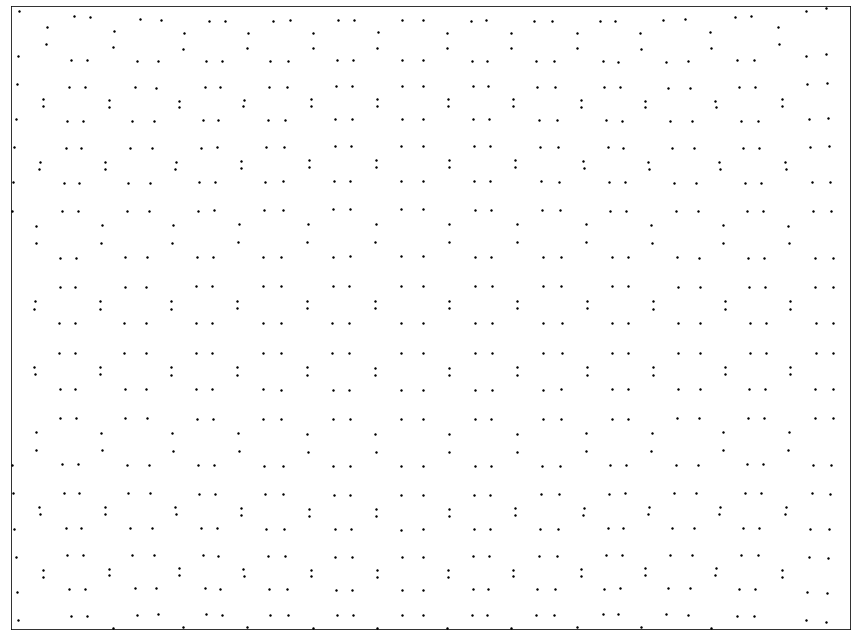

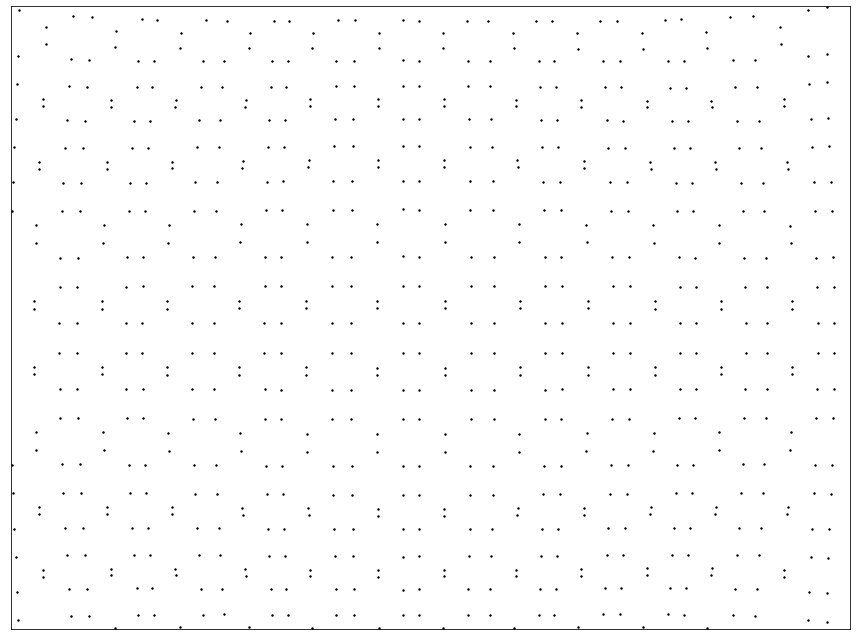

In [26]:
bolt_count = 6
bolt_positions = geo.get_bolt_locations_barrel(pmt_locations, bolt_count)
ring_positions = get_ring_positions(bolt_positions, pmt_locations.keys(), bolt_count)
ring_orientations = get_ring_orientations(bolt_positions, pmt_locations.keys(), bolt_count)
simulator = fit.PhotogrammetrySimulator(bolt_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)
image_feature_locations = simulator.get_image_feature_locations(area_restrict = [[0, 4000], [0, 3000]], min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
print("Feature in image counts:", Counter(feature_counts.values()))
simulator.show_images(image_feature_locations, area=[[0,4000],[0,3000]])

=== Gaussian errors on feature image locations: 0.5 ===
Feature in image counts: Counter({2: 4050})
50 images with total of  4050 features
image 0 reprojection errors:    average: 6.448886842175496    max: 16.267340610994285
image 1 reprojection errors:    average: 6.389912329048619    max: 15.145135766478722
image 2 reprojection errors:    average: 6.9625215213413    max: 16.60917462950093
image 3 reprojection errors:    average: 6.420705327593132    max: 18.439565425219165
image 4 reprojection errors:    average: 8.45970283157088    max: 29.195374820960467
image 5 reprojection errors:    average: 6.165129150947636    max: 18.491035429947118
image 6 reprojection errors:    average: 6.1302869732229235    max: 18.725775263543838
image 7 reprojection errors:    average: 5.698761536060829    max: 12.833614014014103
image 8 reprojection errors:    average: 6.0536994654855985    max: 16.829661014818118
image 9 reprojection errors:    average: 6.0823543529105    max: 16.901930318240357
image

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9704e+05                                    1.75e+06    
       1              2         6.5835e+03      1.90e+05       9.26e+01       1.75e+04    
       2              3         4.4400e+03      2.14e+03       4.13e+01       4.51e+04    
       3              4         3.6714e+03      7.69e+02       1.31e+01       4.15e+03    
       4              5         3.4693e+03      2.02e+02       4.57e+00       4.17e+02    
       5              6         3.3658e+03      1.04e+02       3.37e+00       6.59e+02    
       6              7         3.3295e+03      3.62e+01       5.97e-01       2.79e+02    
`xtol` termination condition is satisfied.
Function evaluations 7, initial cost 1.9704e+05, final cost 3.3295e+03, first-order optimality 2.79e+02.
mean reprojection error: 0.7869002175787221
max reprojection error: 4.070894629716022
mean reconstruction error: 0.872447373

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4948e+05                                    2.63e+06    
       1              2         2.9077e+04      2.20e+05       9.87e+01       1.25e+04    
       2              3         2.5179e+04      3.90e+03       4.30e+01       3.04e+04    
       3              4         2.3422e+04      1.76e+03       1.11e+01       1.51e+03    
       4              5         2.2556e+04      8.66e+02       9.66e+00       1.26e+03    
       5              6         2.1860e+04      6.96e+02       7.45e+00       6.62e+02    
       6              7         2.1532e+04      3.27e+02       4.07e+00       2.39e+03    
       7              8         2.1368e+04      1.64e+02       1.22e+00       4.04e+02    
       8              9         2.1209e+04      1.59e+02       2.68e+00       2.42e+03    
       9             10         2.1055e+04      1.54e+02       1.19e+00       4.04e+02    

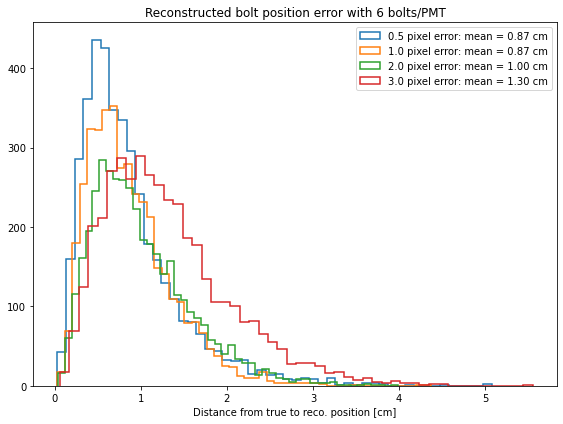

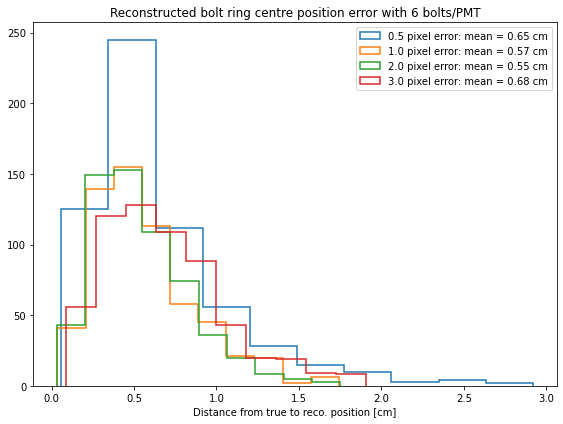

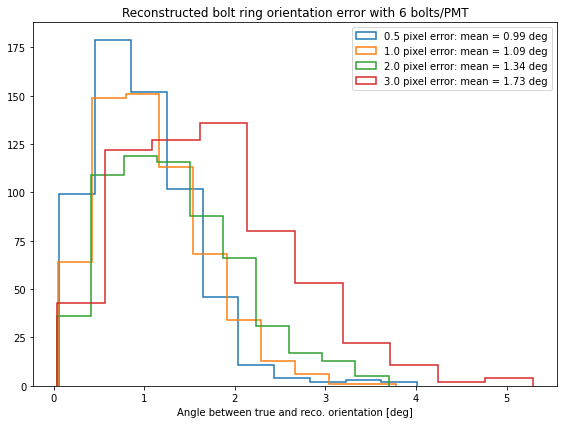

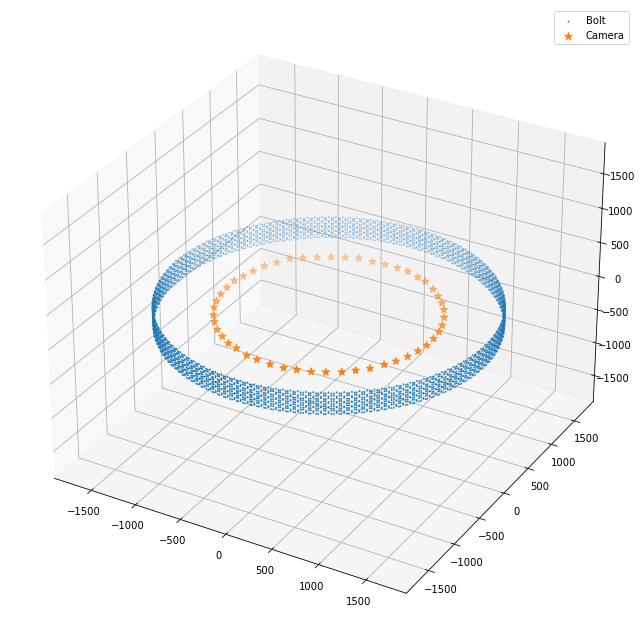

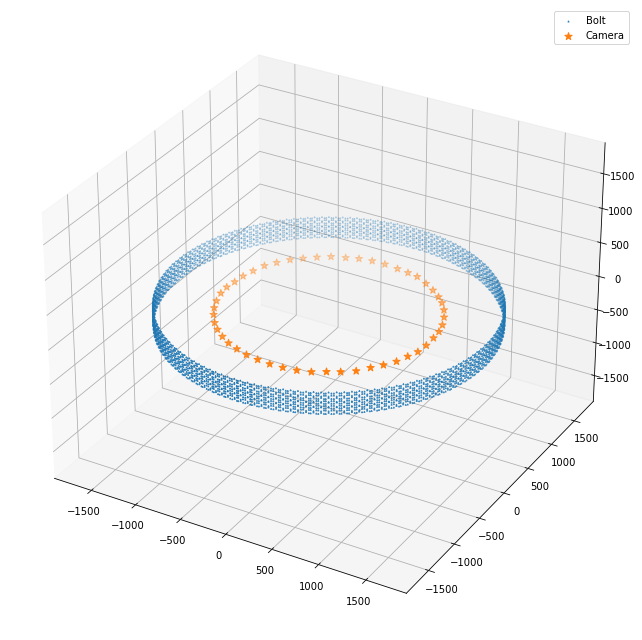

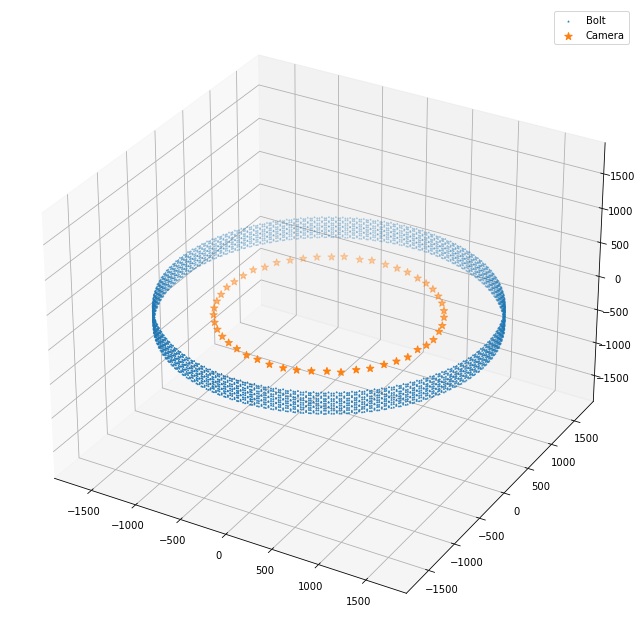

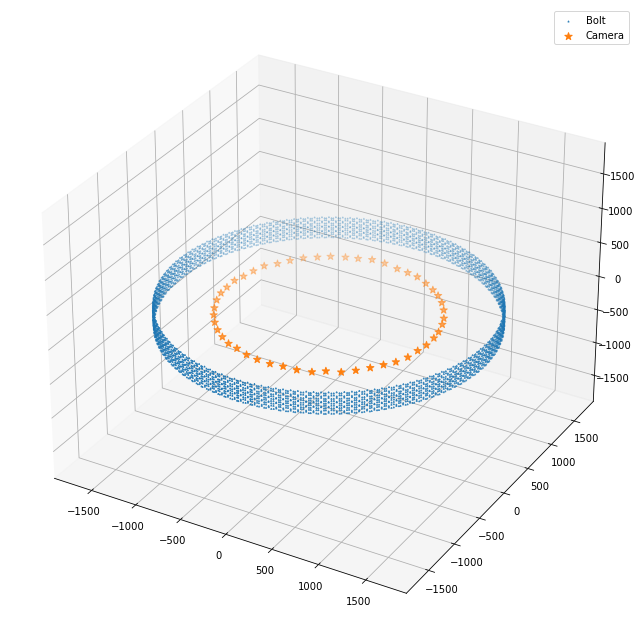

In [27]:
fig_bolt_pos, ax_bolt_pos = make_fig("Reconstructed bolt position error with {} bolts/PMT".format(bolt_count), "Distance from true to reco. position [cm]")
fig_ring_pos, ax_ring_pos = make_fig("Reconstructed bolt ring centre position error with {} bolts/PMT".format(bolt_count), "Distance from true to reco. position [cm]")
fig_ring_ang, ax_ring_ang = make_fig("Reconstructed bolt ring orientation error with {} bolts/PMT".format(bolt_count), "Angle between true and reco. orientation [deg]")
for pixel_error in [0.5, 1.0, 2.0, 3.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=[[1000, 3000], [750, 2250]], min_feature_count=2, pixel_error=pixel_error)
    feature_counts = Counter([f for i in smeared_feature_locations.values() for f in i.keys()])
    print("Feature in image counts:", Counter(feature_counts.values()))
    bolt_positions2 = {k: v for k, v in bolt_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_bolt_simulation(bolt_positions2, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_bolt_positions, position_errors = run_bolt_fit(fitter, bolt_positions2, xtol=1e-5)
    centre_errors = get_ring_centre_errors(reco_bolt_positions, ring_positions, bolt_count)
    orientation_errors = get_ring_orientation_errors(reco_bolt_positions, ring_orientations, bolt_count)
    ax_bolt_pos.hist(position_errors, bins=50, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors.mean()))
    ax_ring_pos.hist(centre_errors, bins=10, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors.mean()))
    ax_ring_ang.hist(orientation_errors, bins=10, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors.mean()))
    reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(bolt_positions, reco_bolt_positions)
    reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
    plot_reconstruction(reco_transformed, reco_cam_positions)
    bolt_position_errors[bolt_count][pixel_error] = position_errors.mean()
    ring_position_errors[bolt_count][pixel_error] = centre_errors.mean()
    ring_orientation_errors[bolt_count][pixel_error] = orientation_errors.mean()
ax_bolt_pos.legend(loc='upper right')
ax_ring_pos.legend(loc='upper right')
ax_ring_ang.legend(loc='upper right')

# Simulation with 8 bolts

Feature in image counts: Counter({4: 10048, 5: 1102, 3: 400})


/home/prouse/work/PhotogrammetryAnalysis/pg_fitter_tools.py:203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


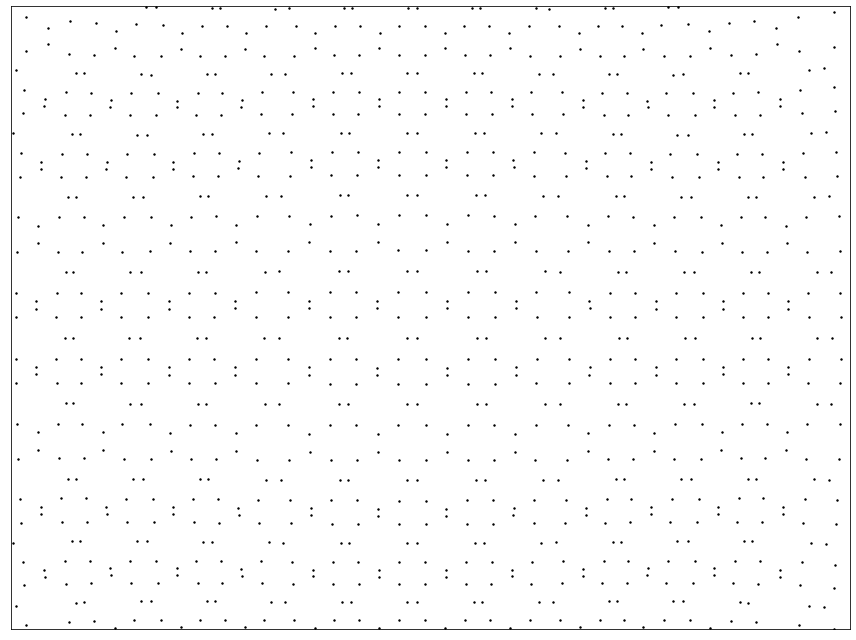

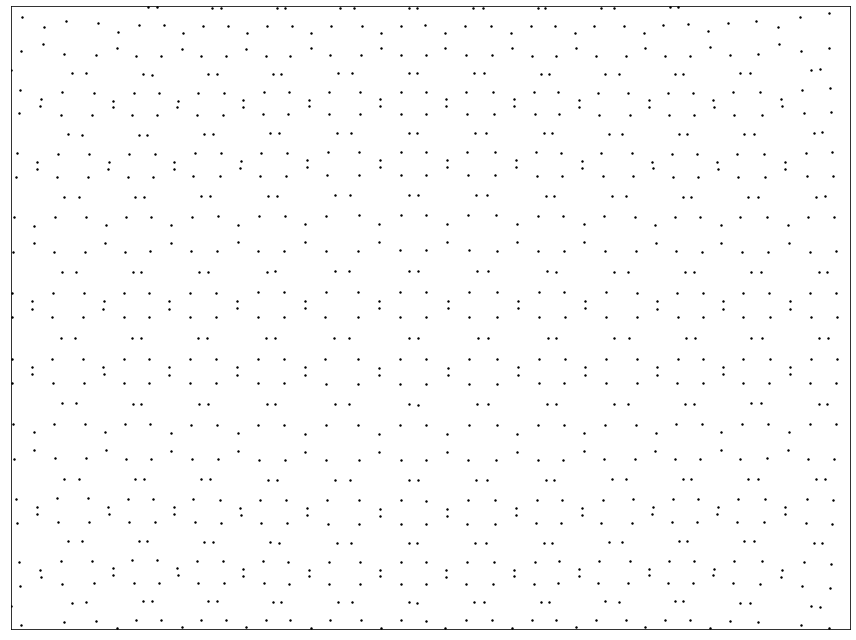

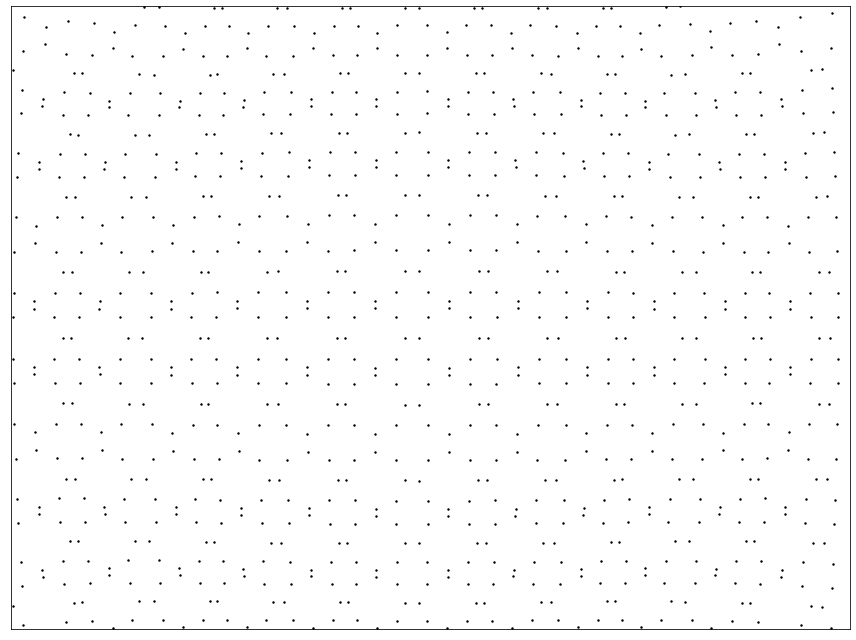

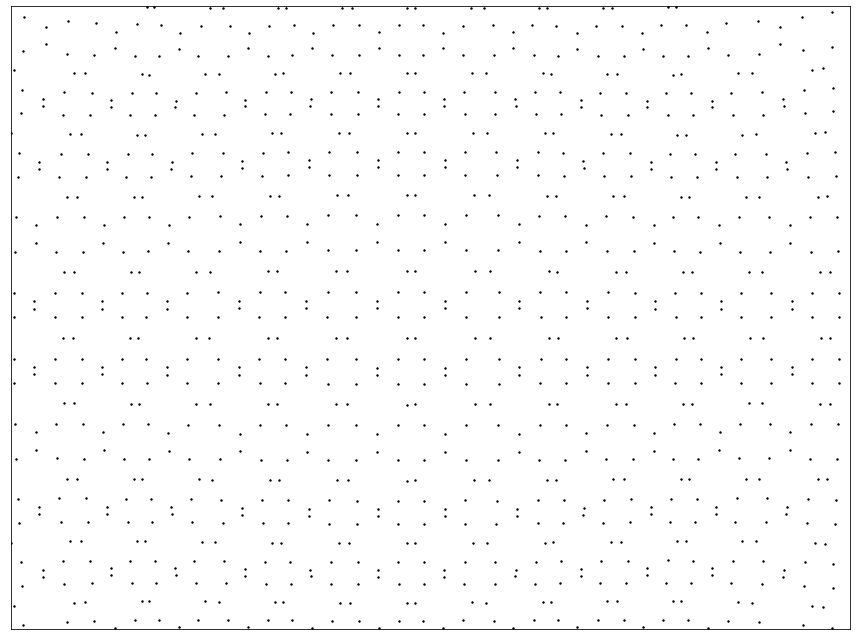

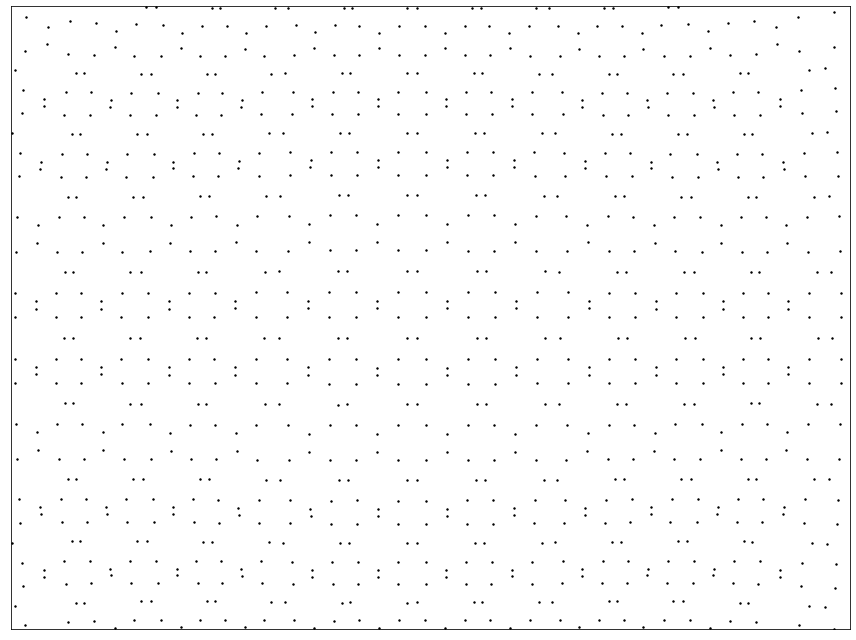

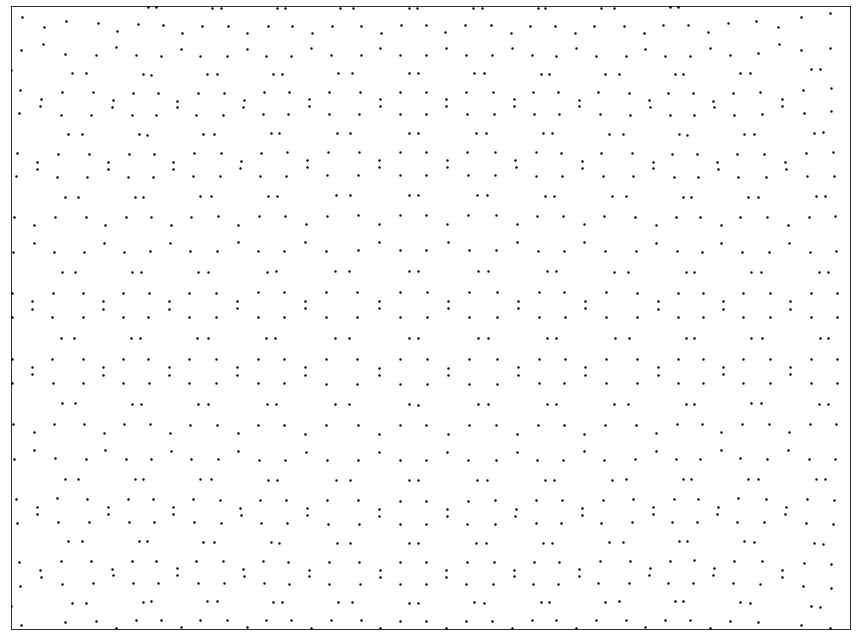

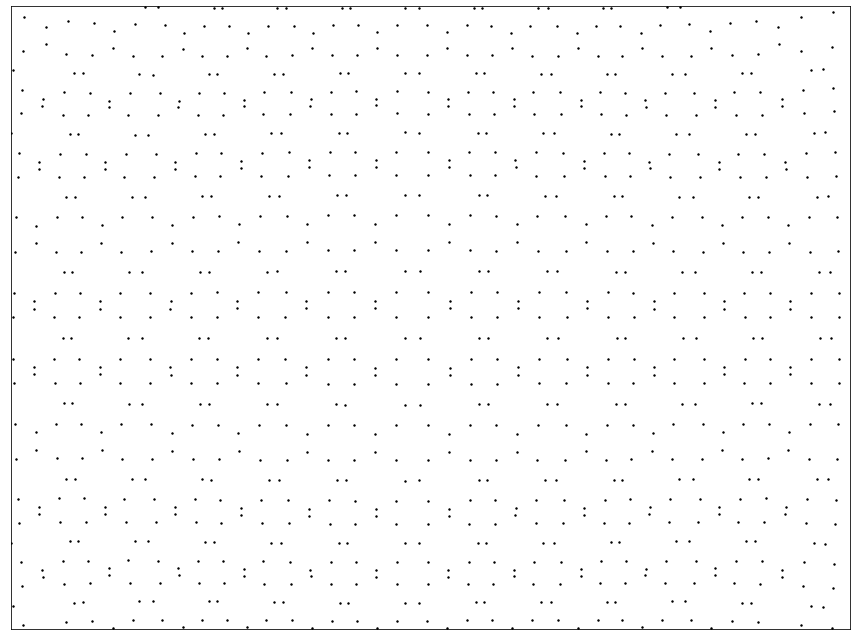

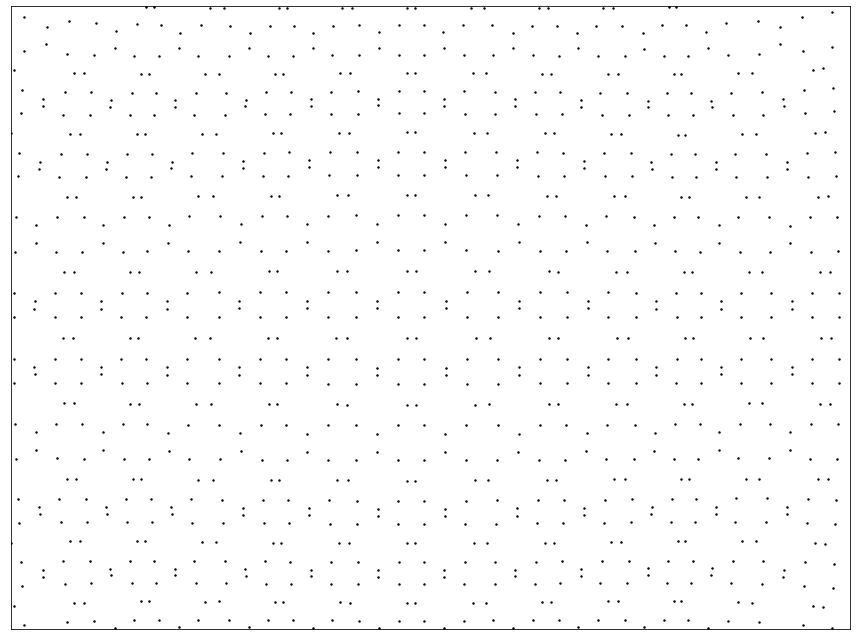

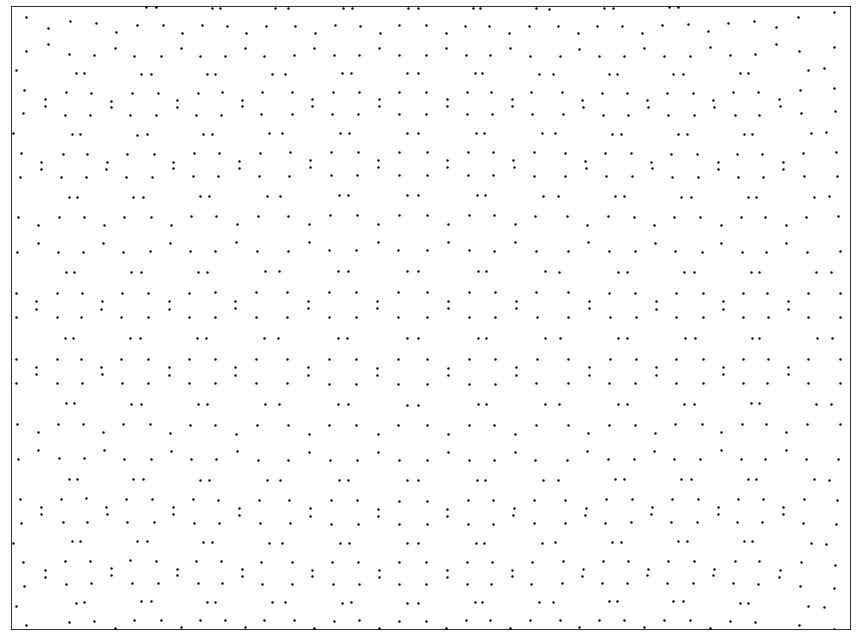

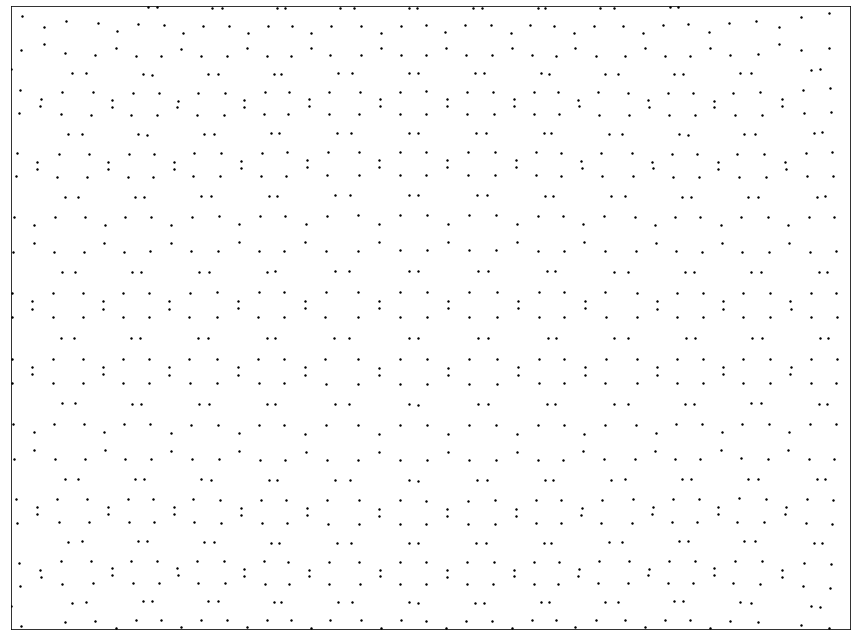

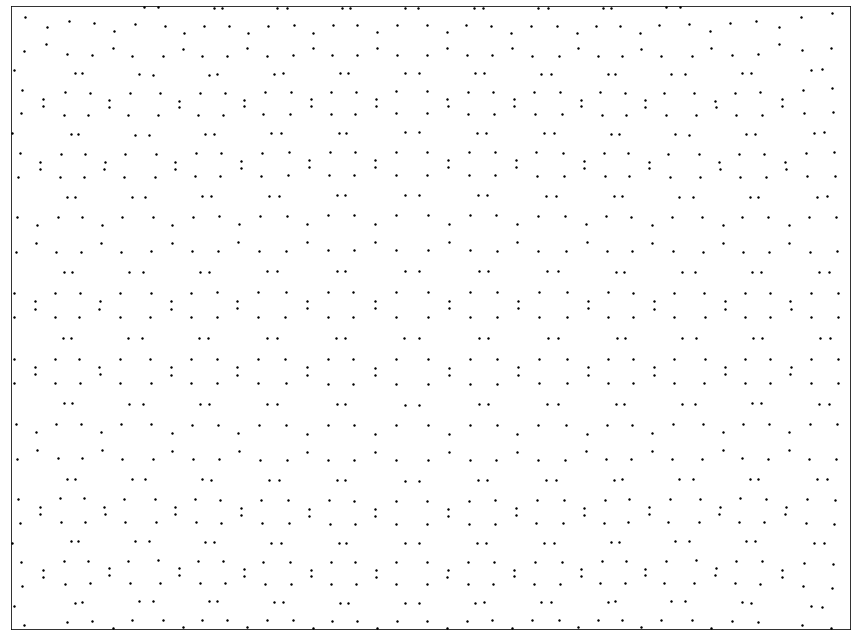

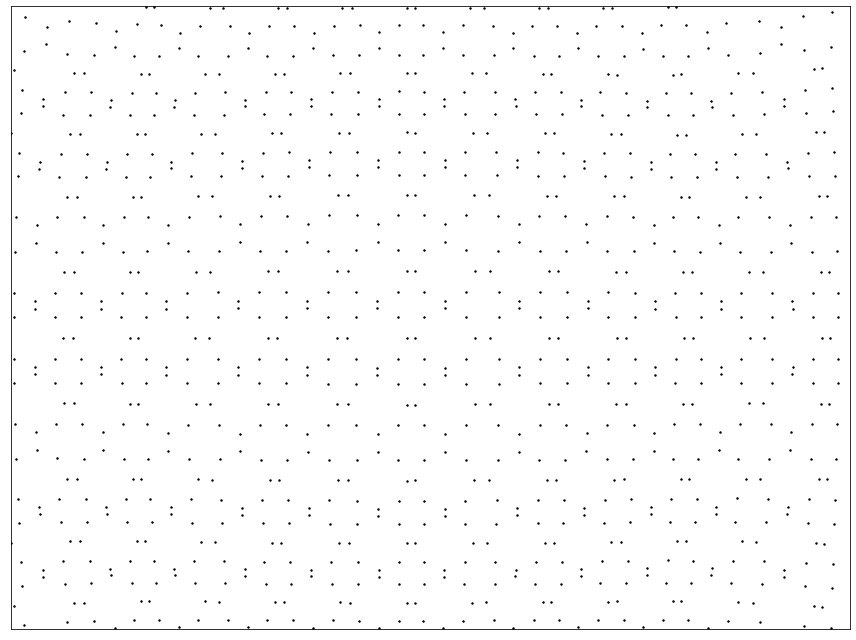

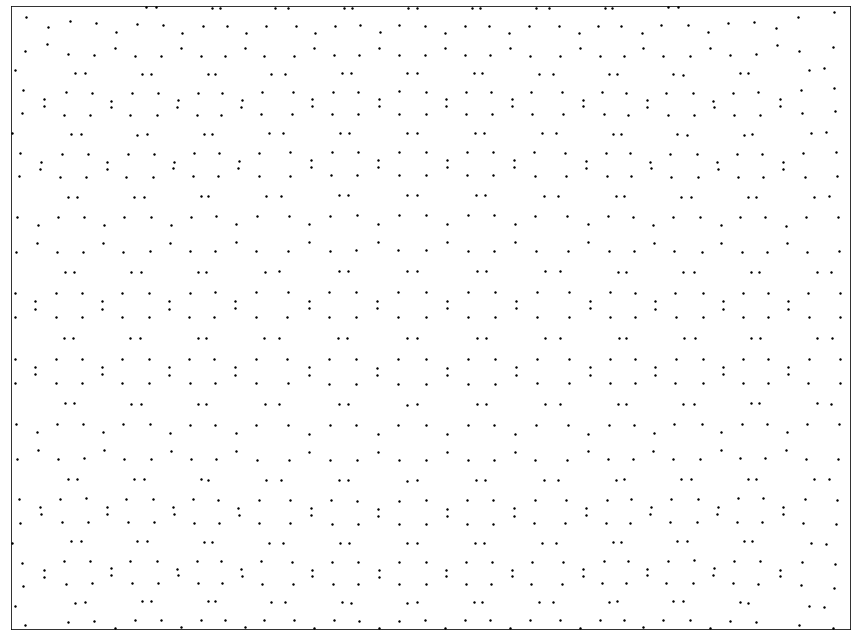

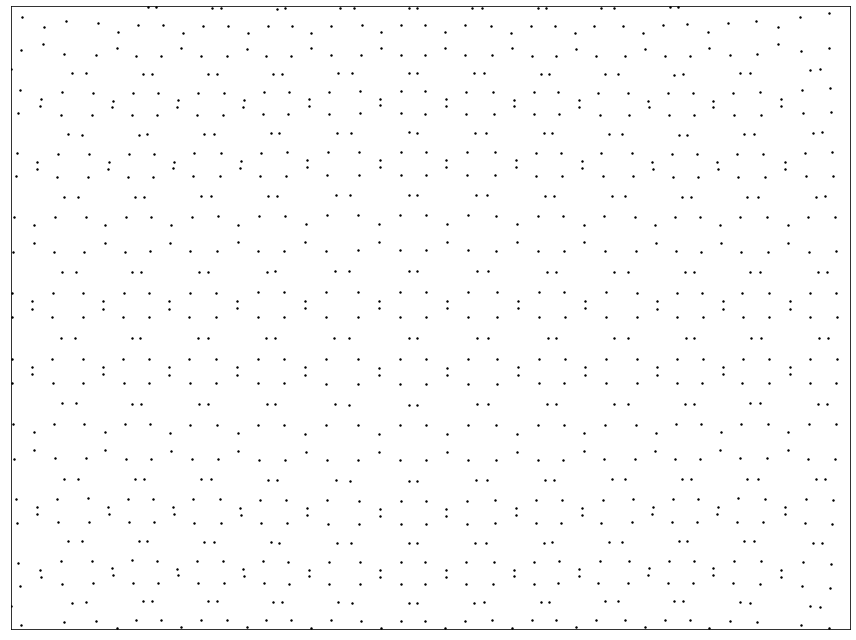

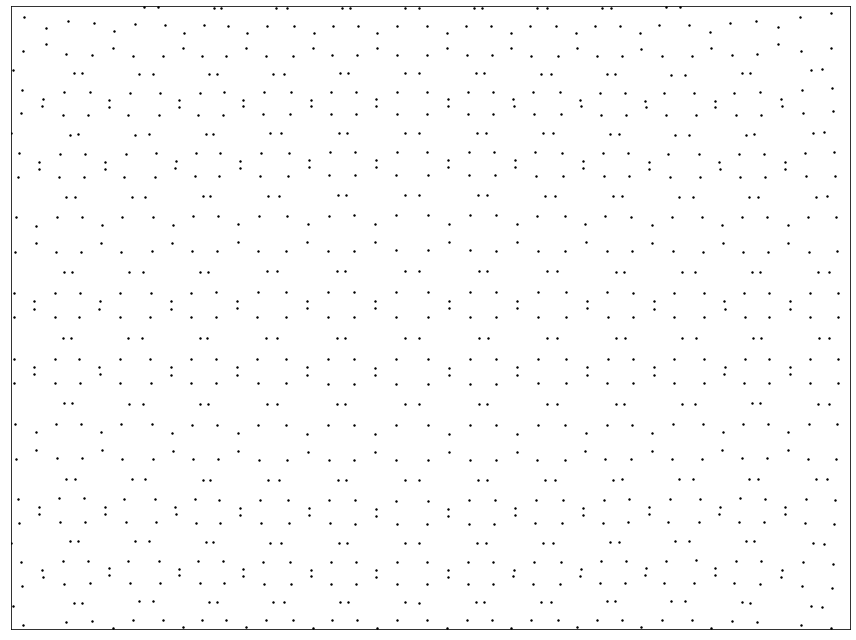

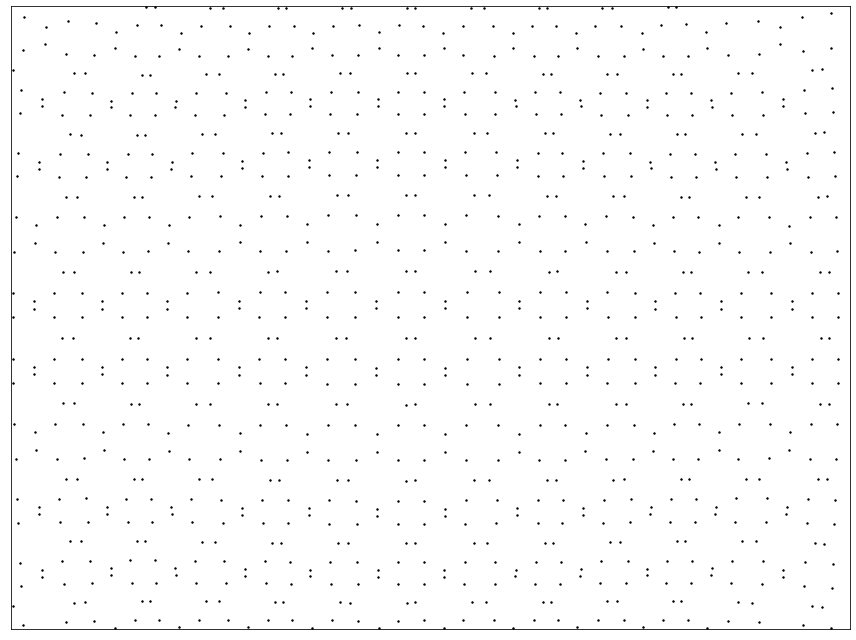

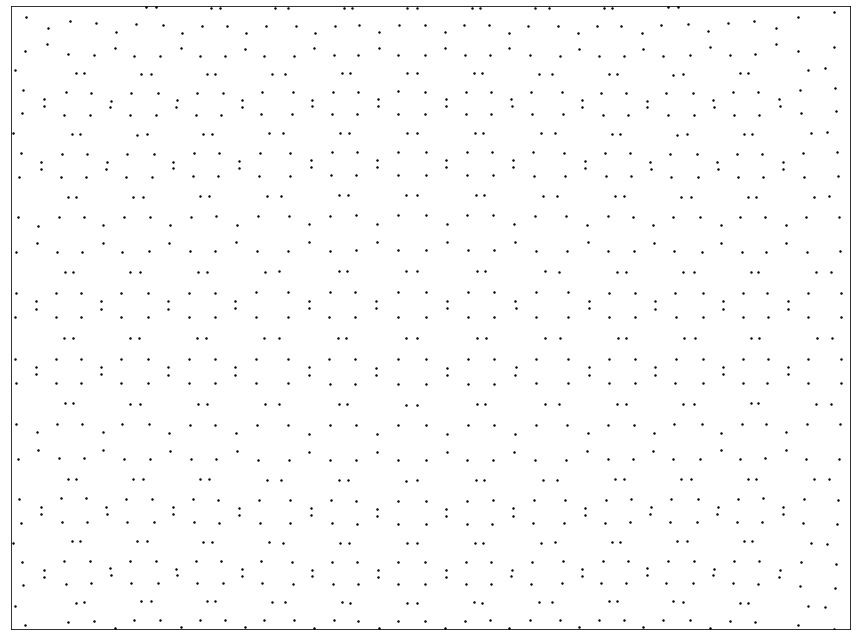

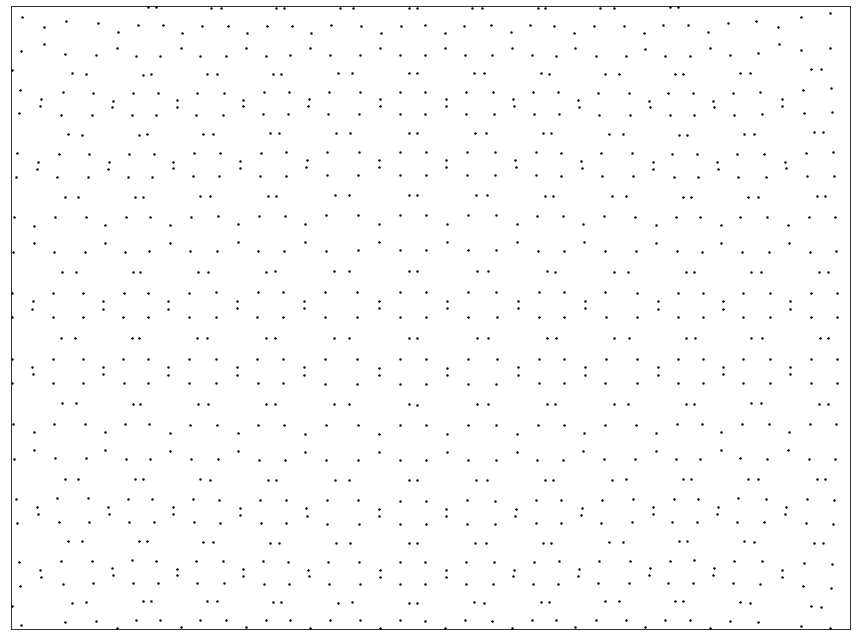

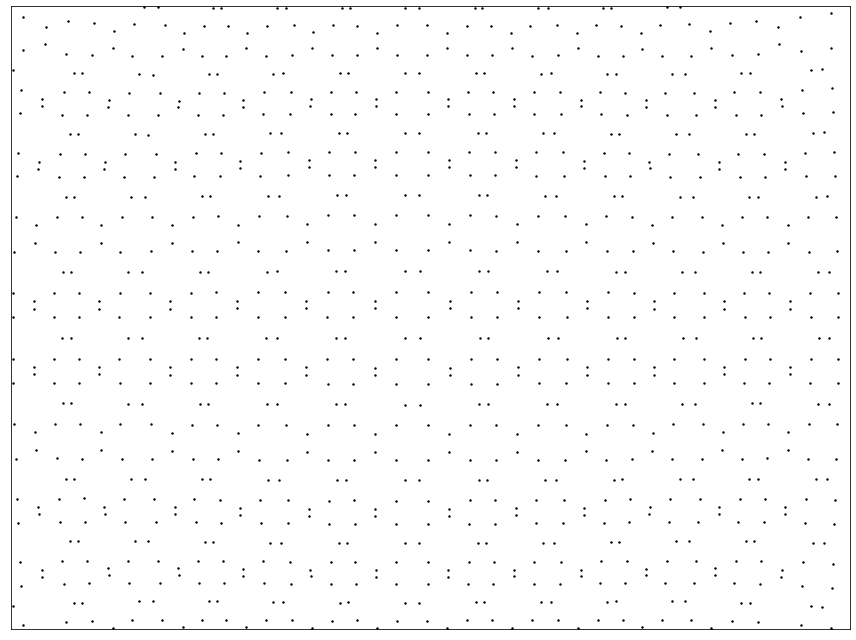

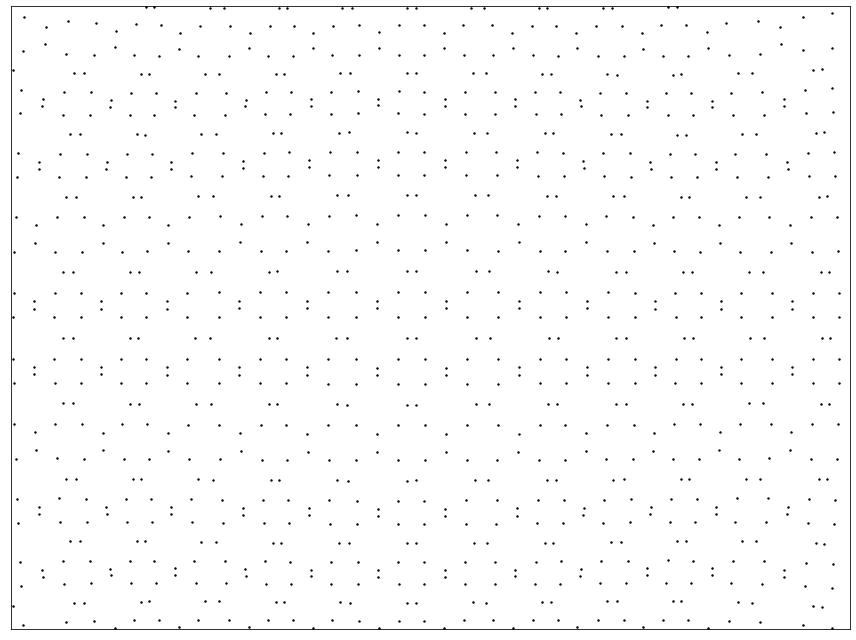

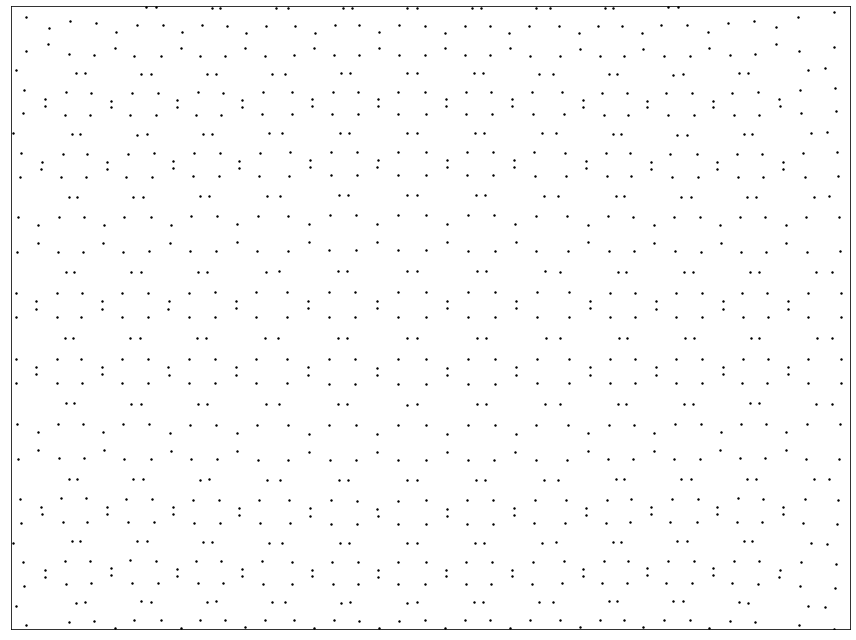

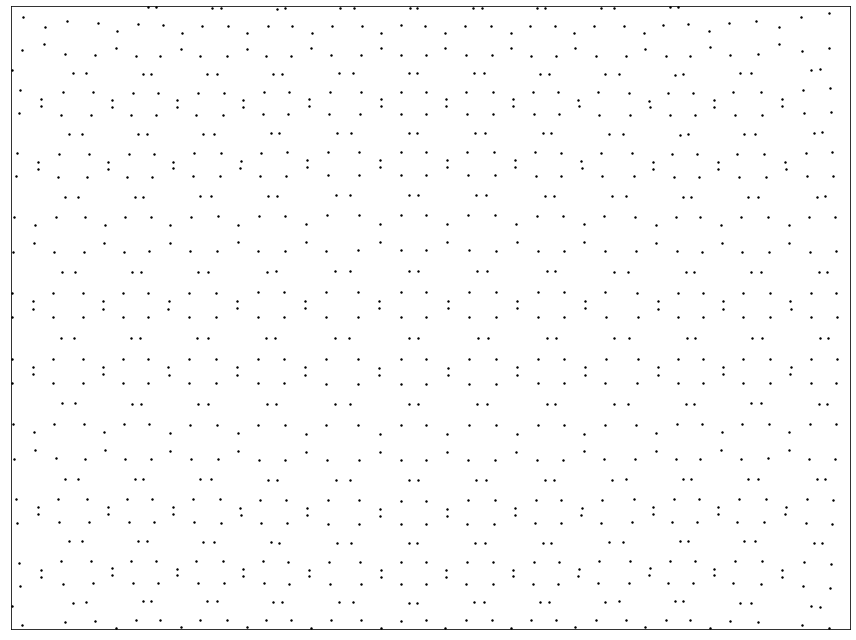

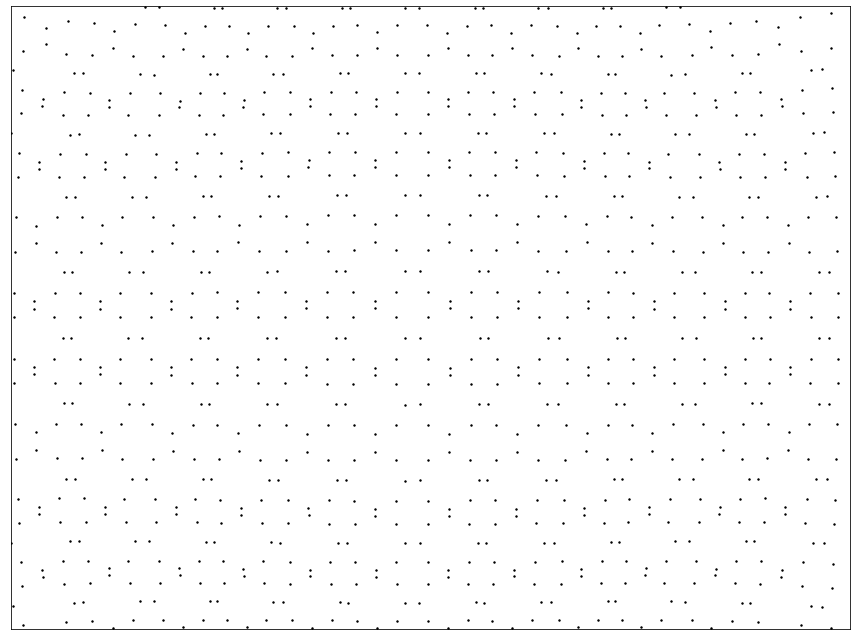

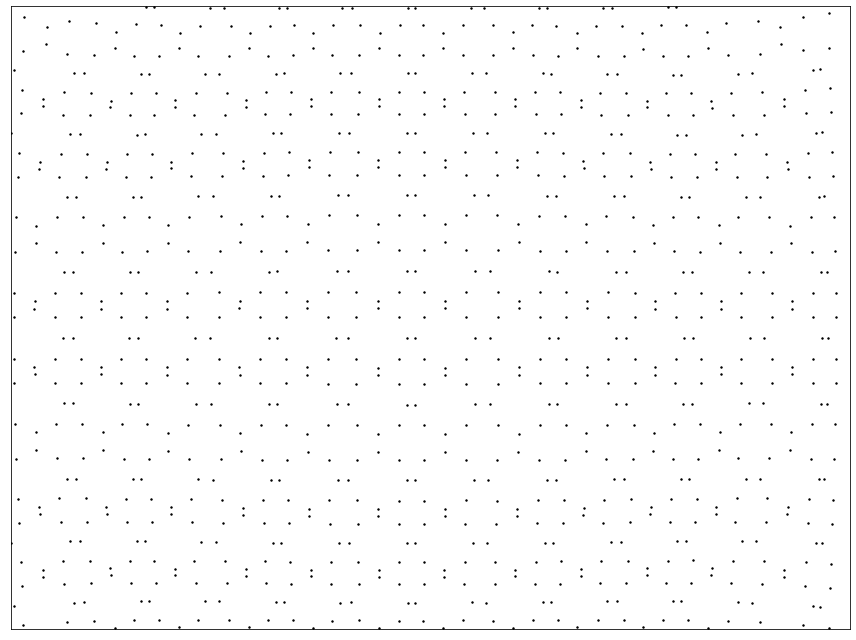

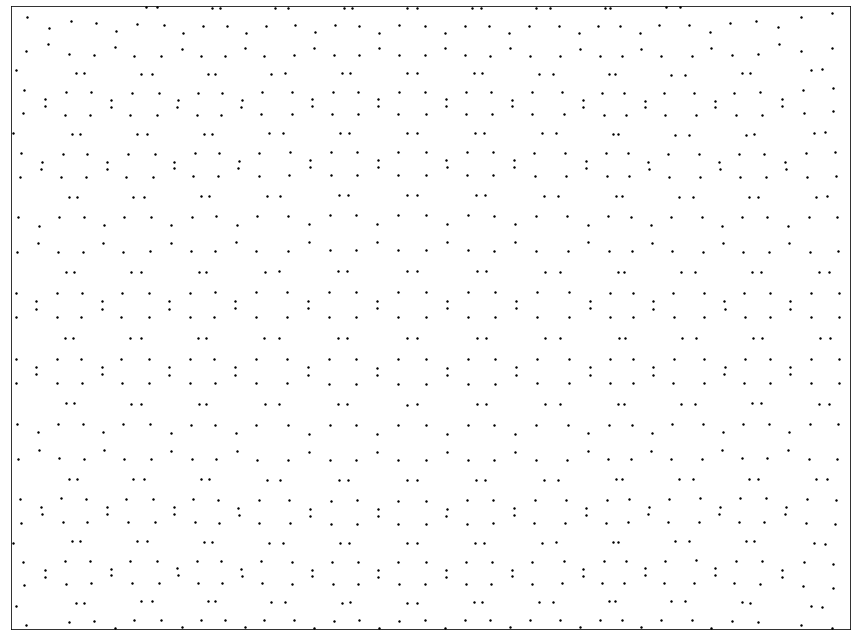

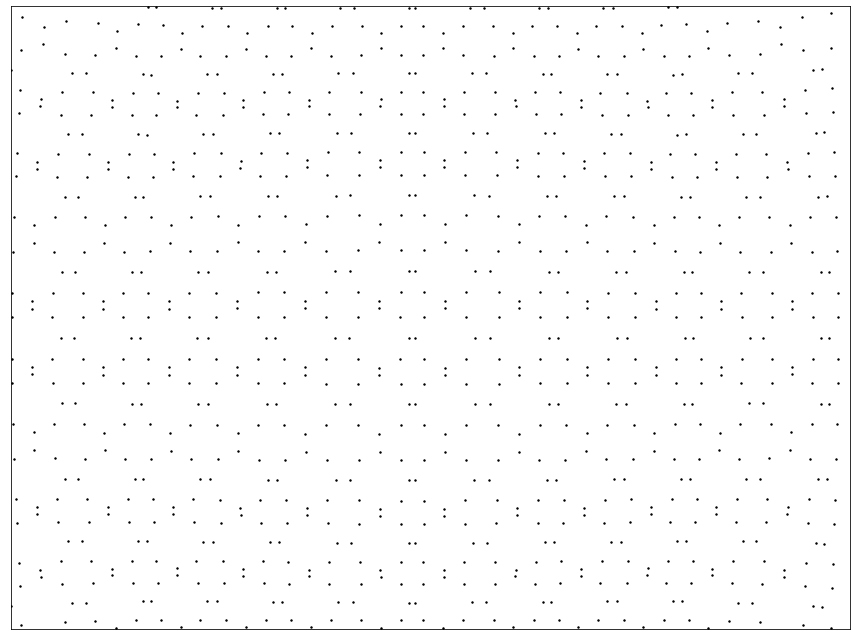

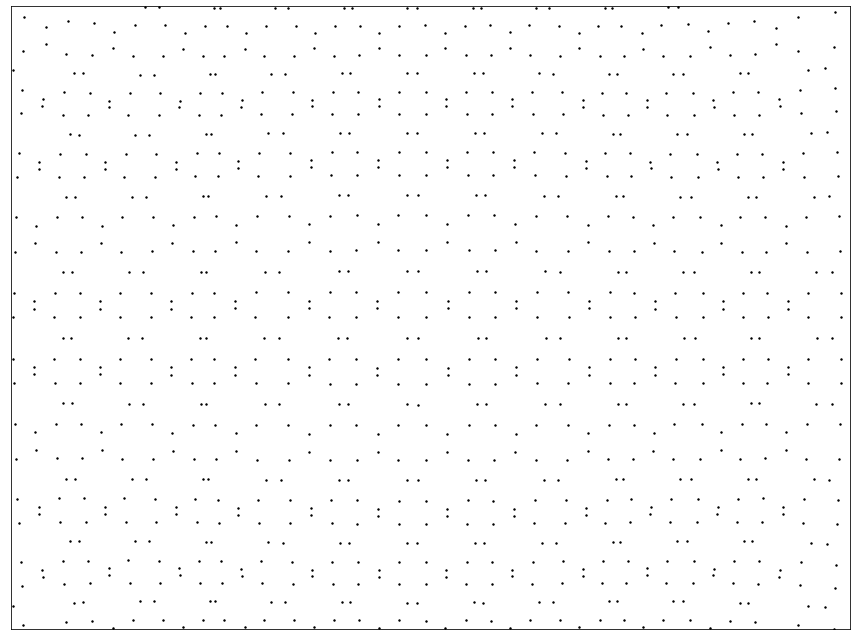

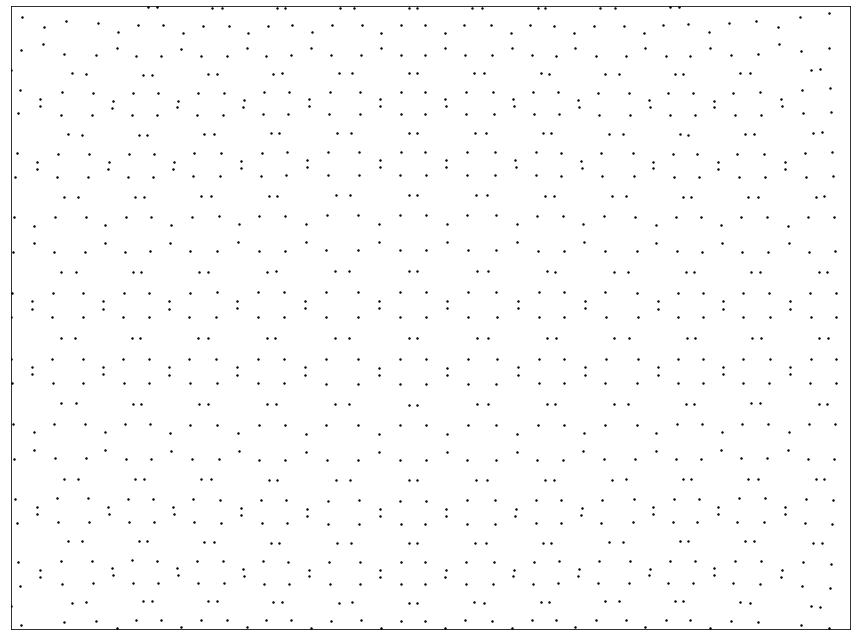

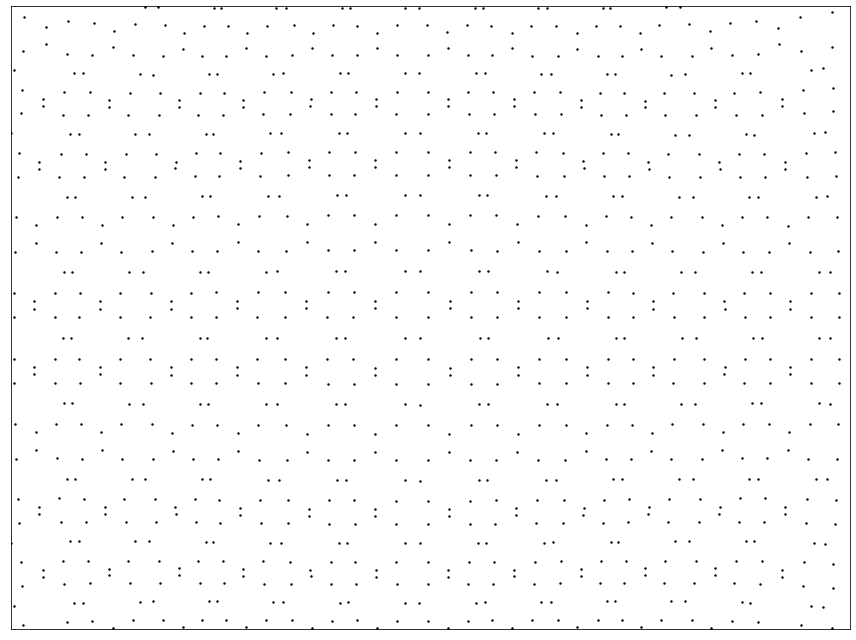

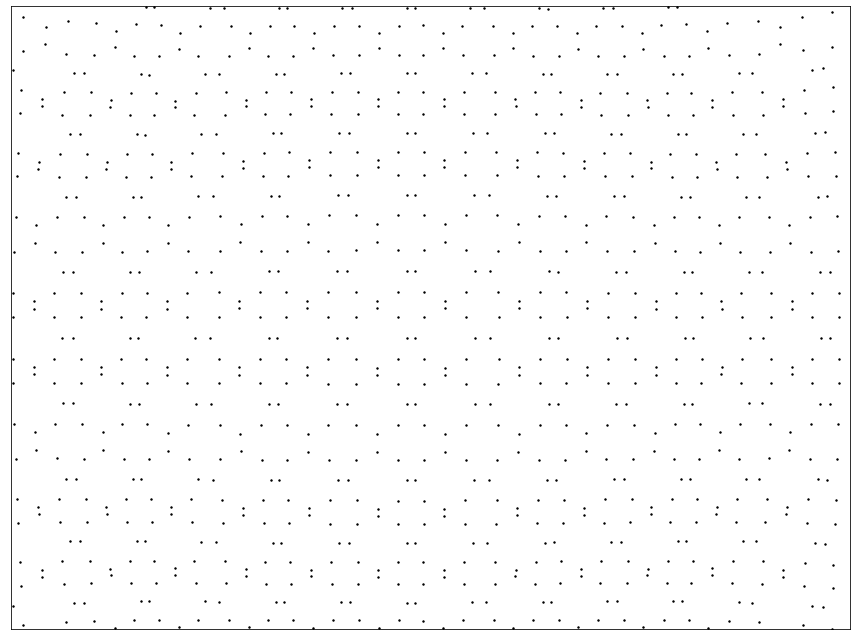

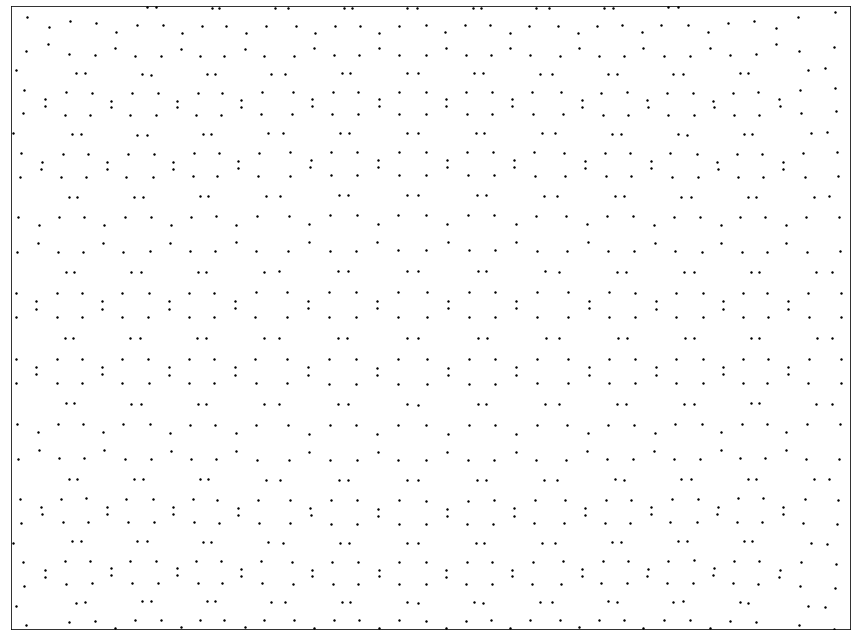

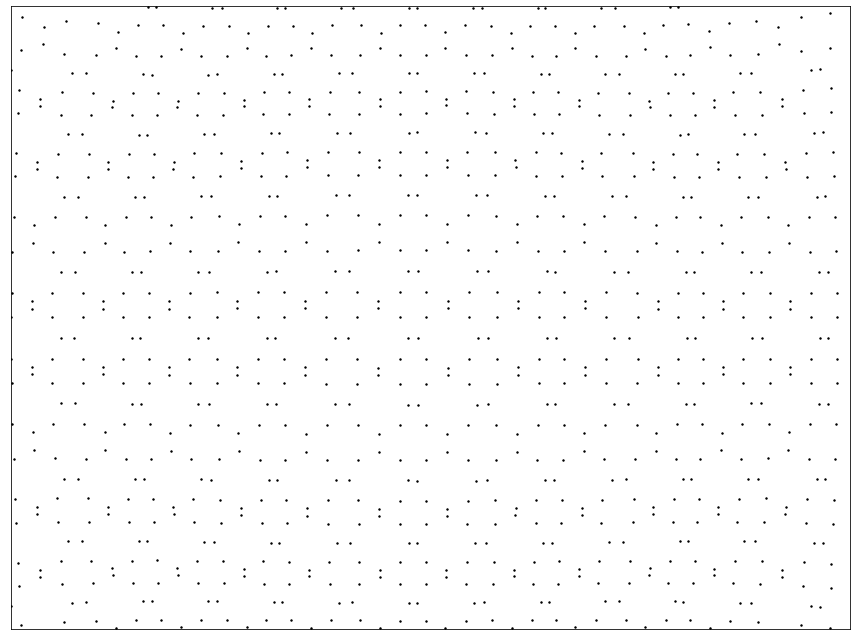

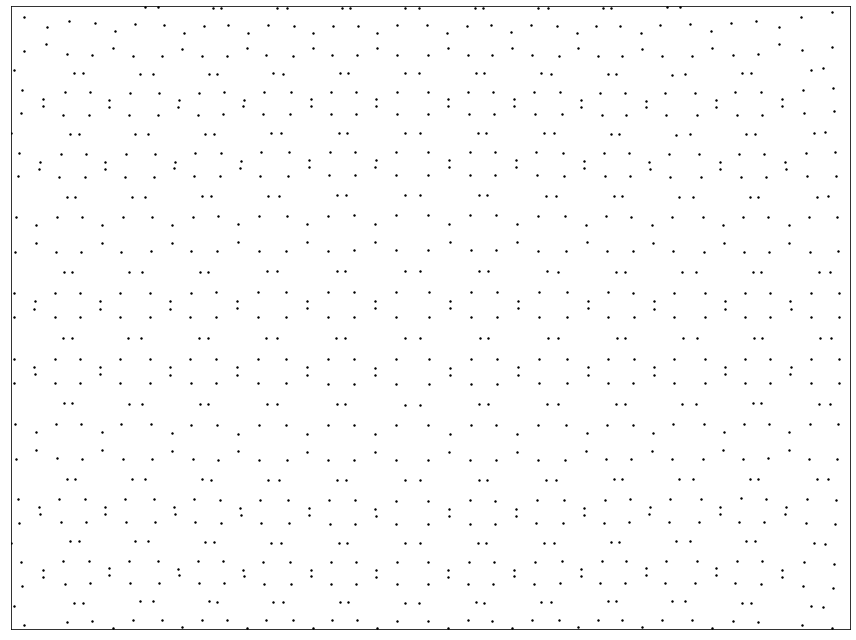

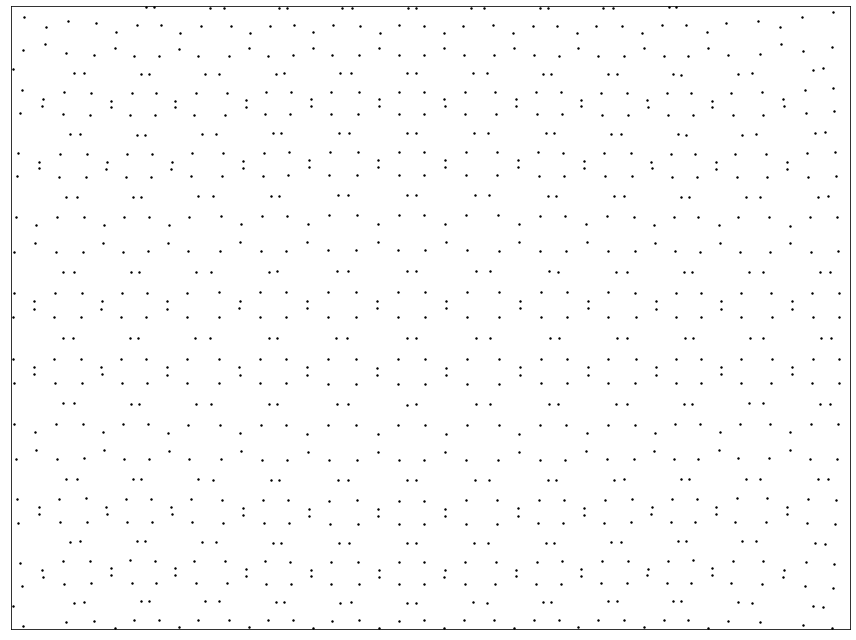

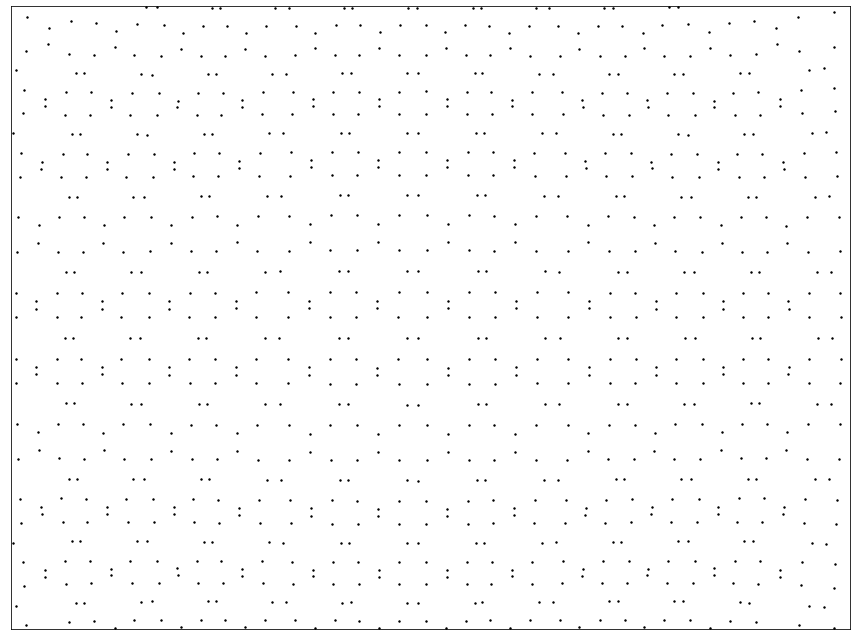

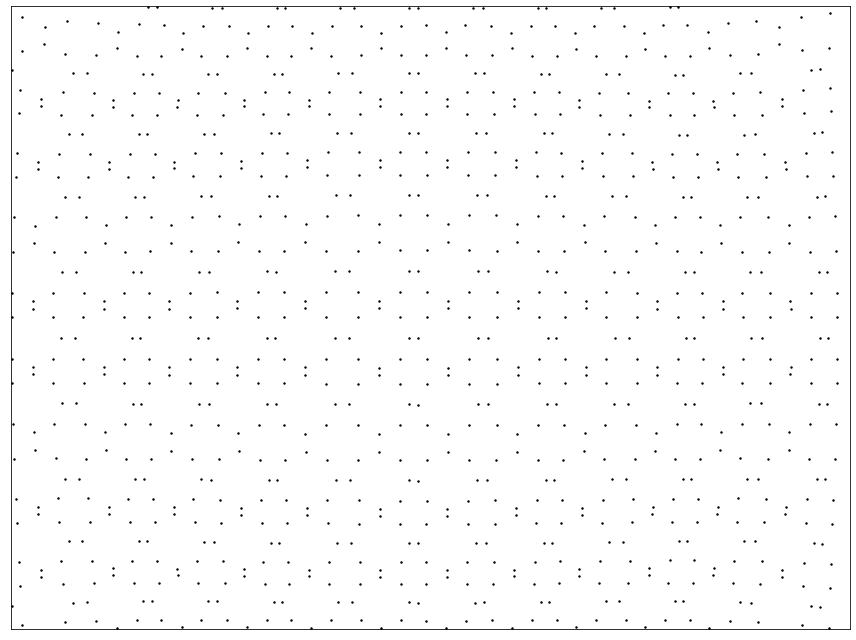

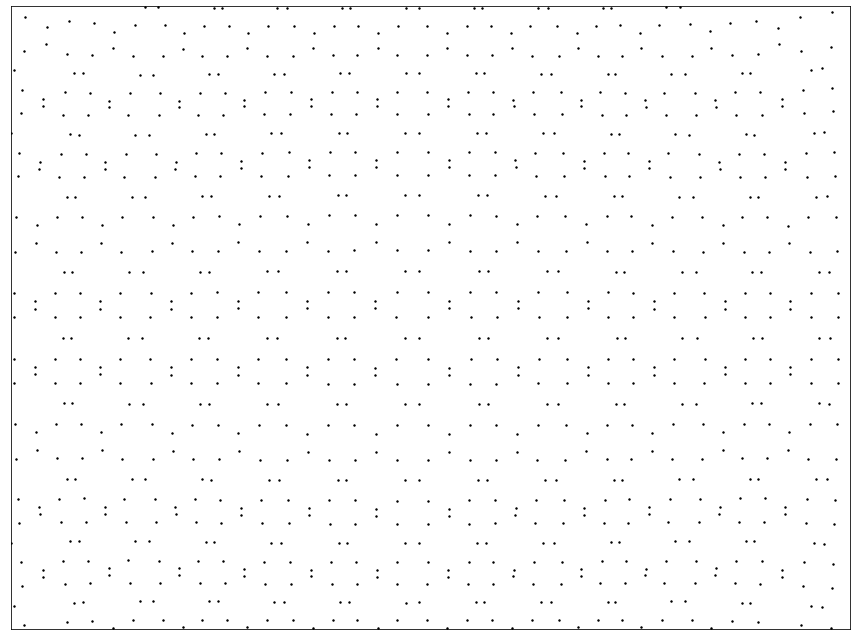

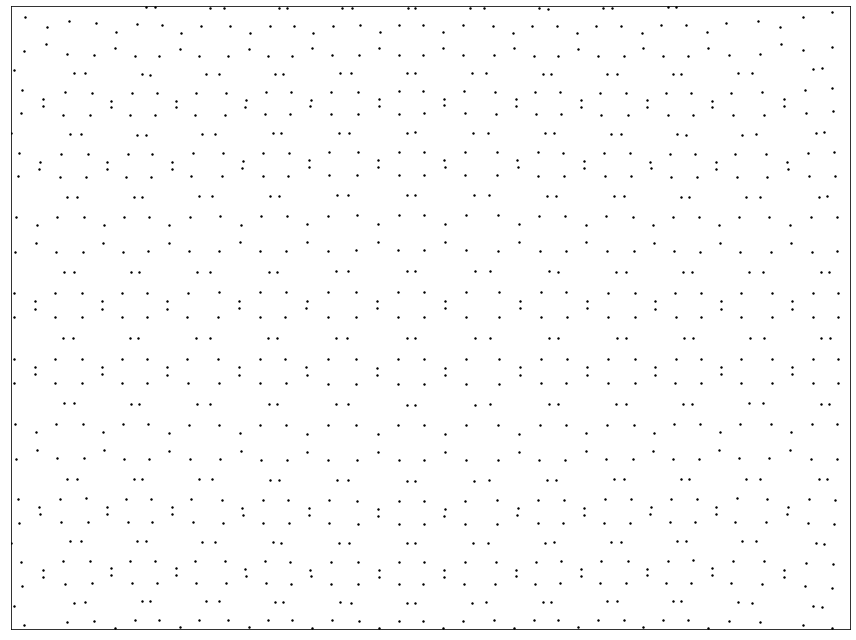

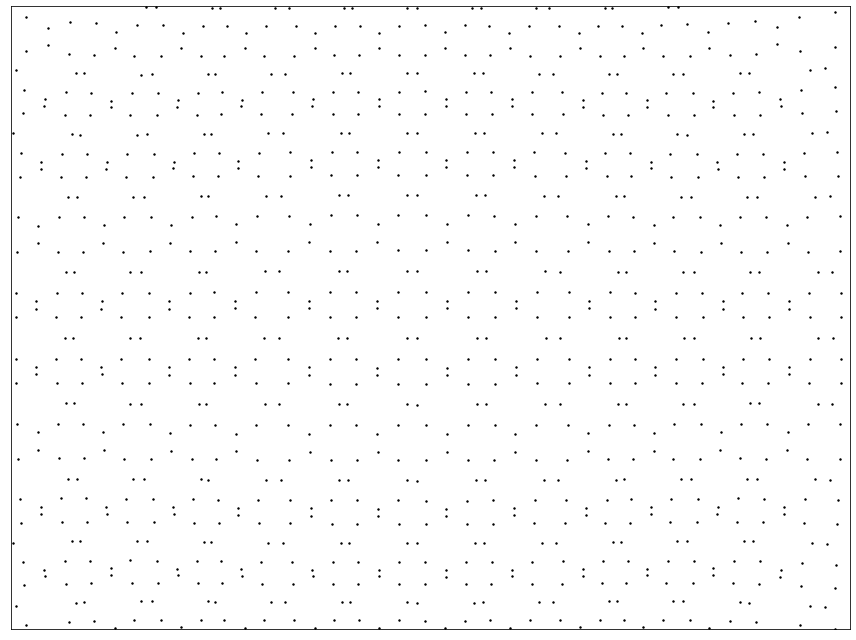

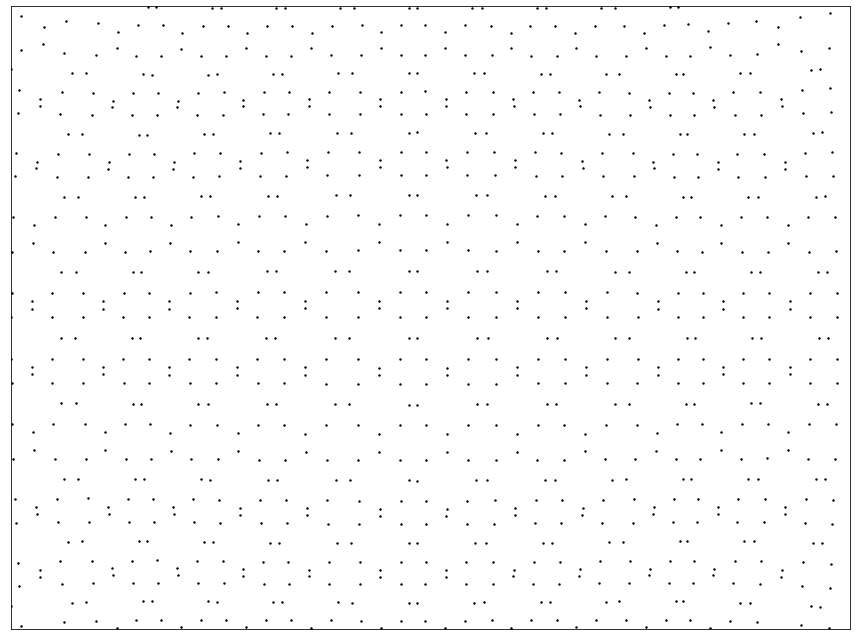

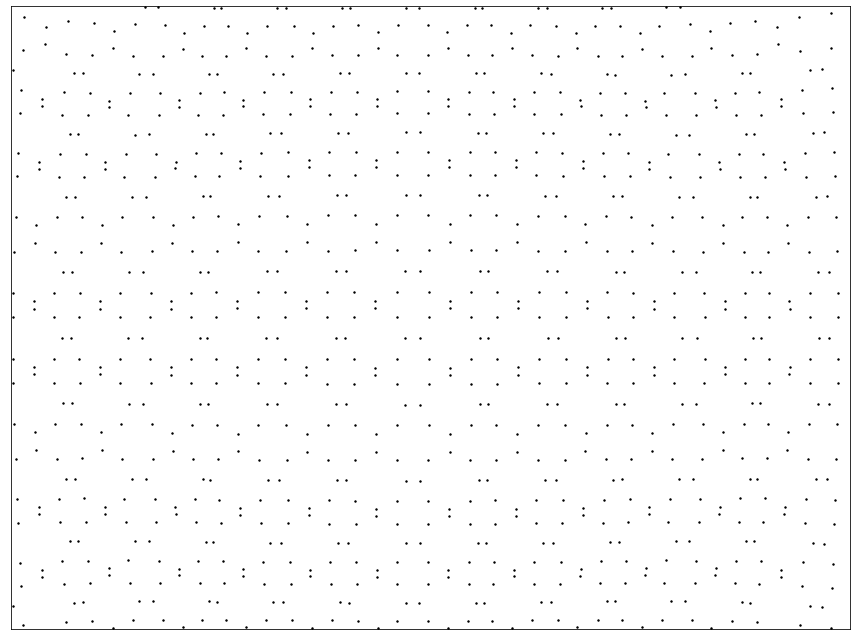

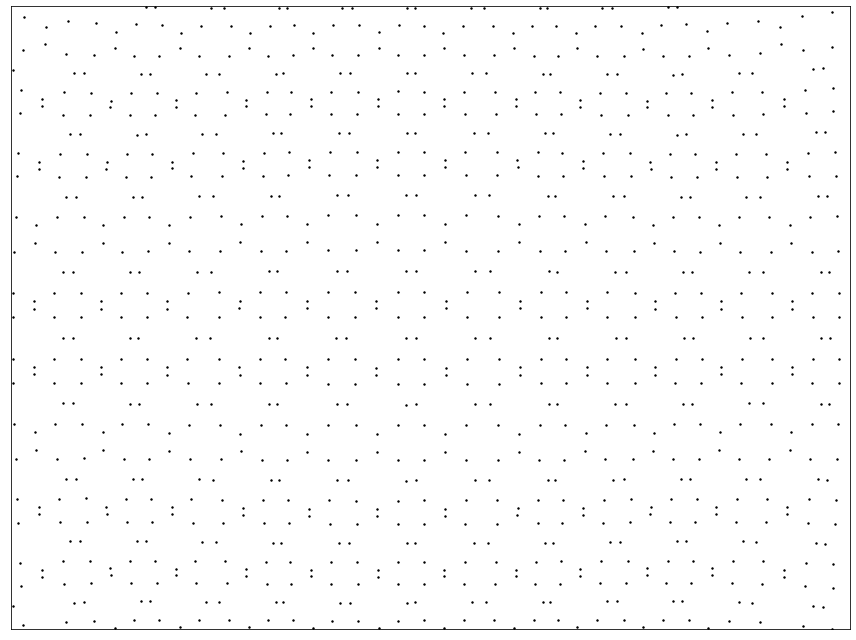

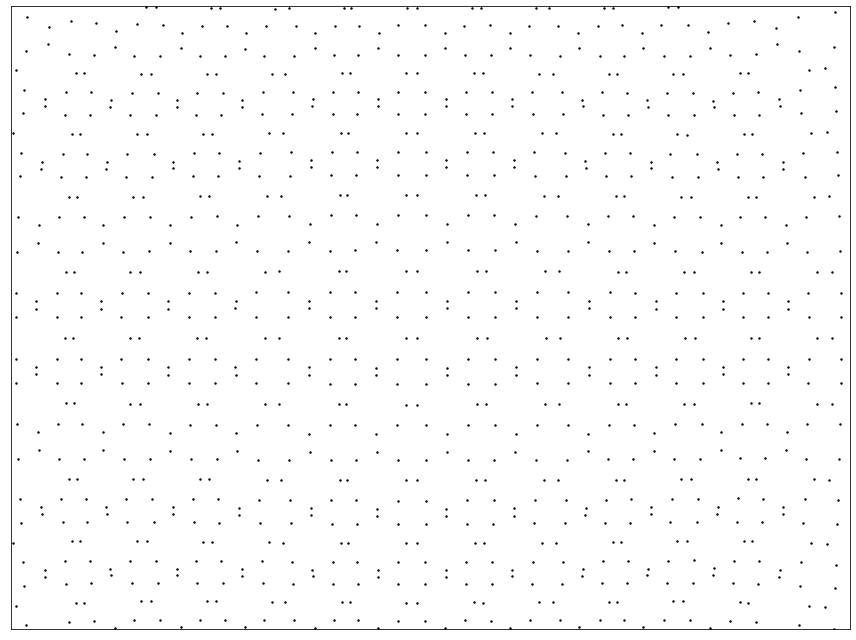

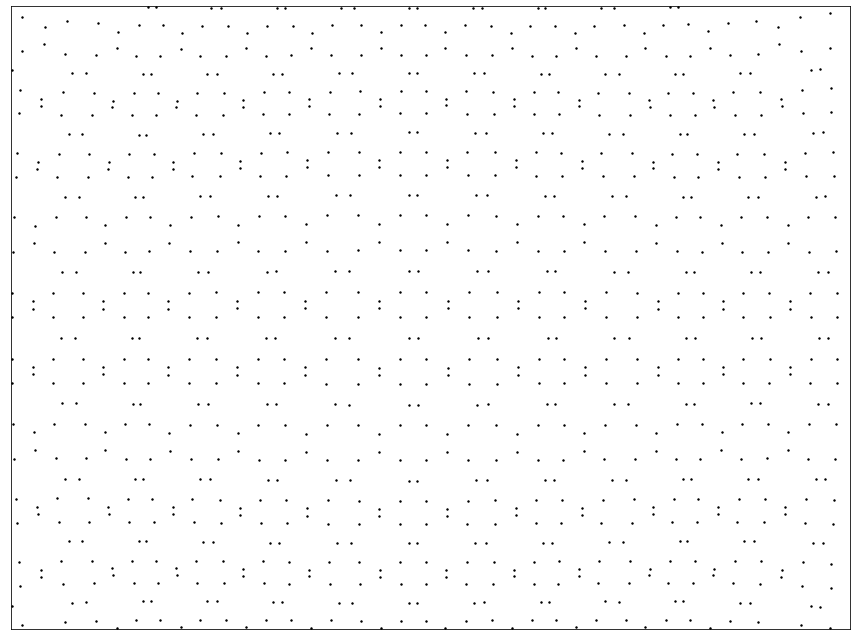

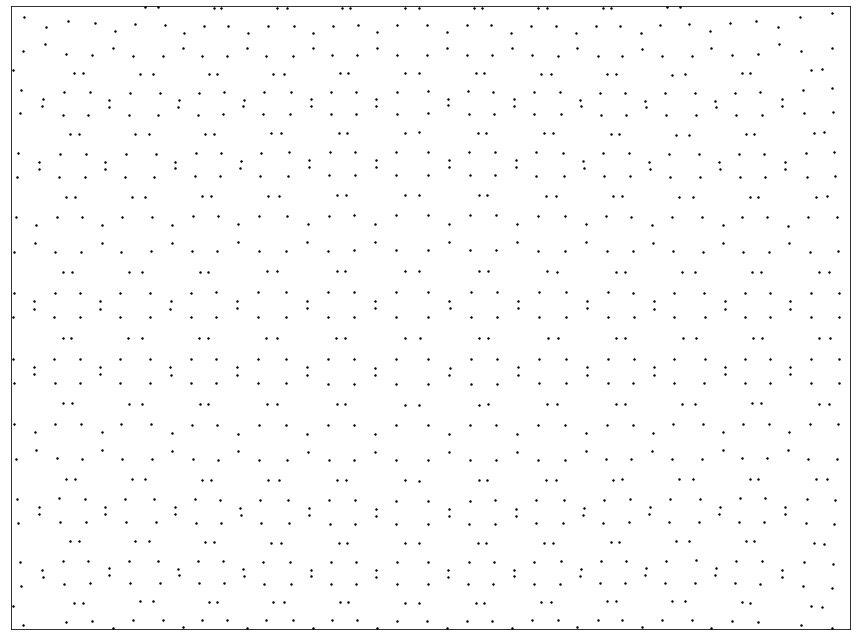

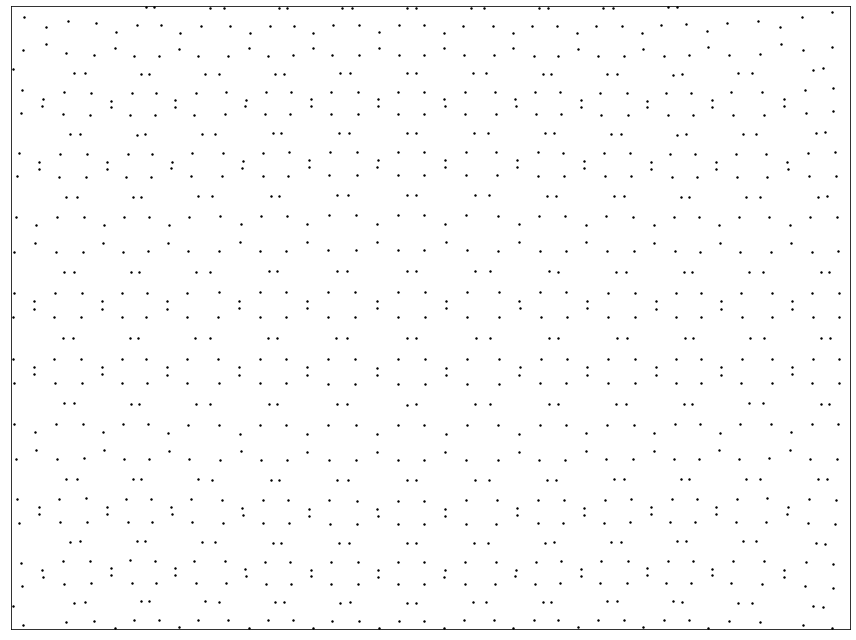

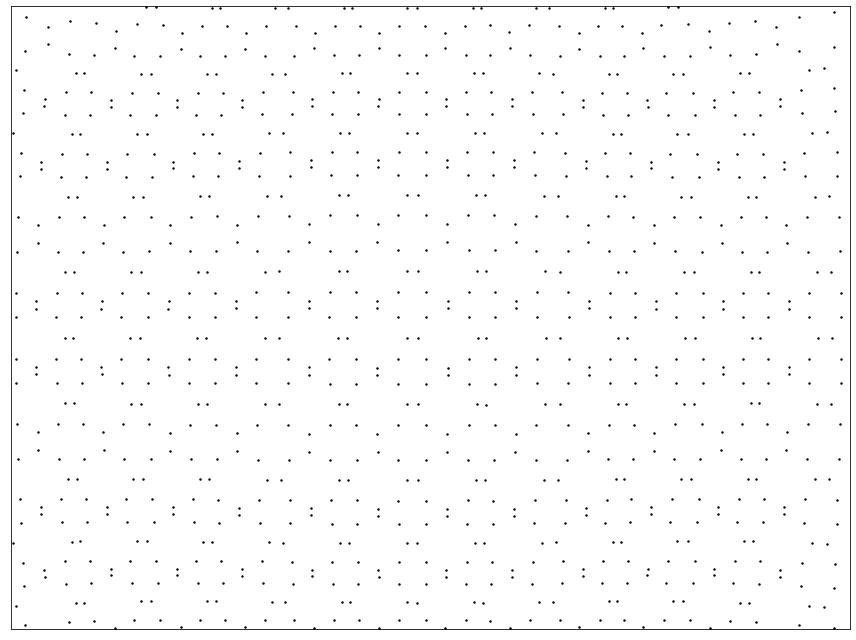

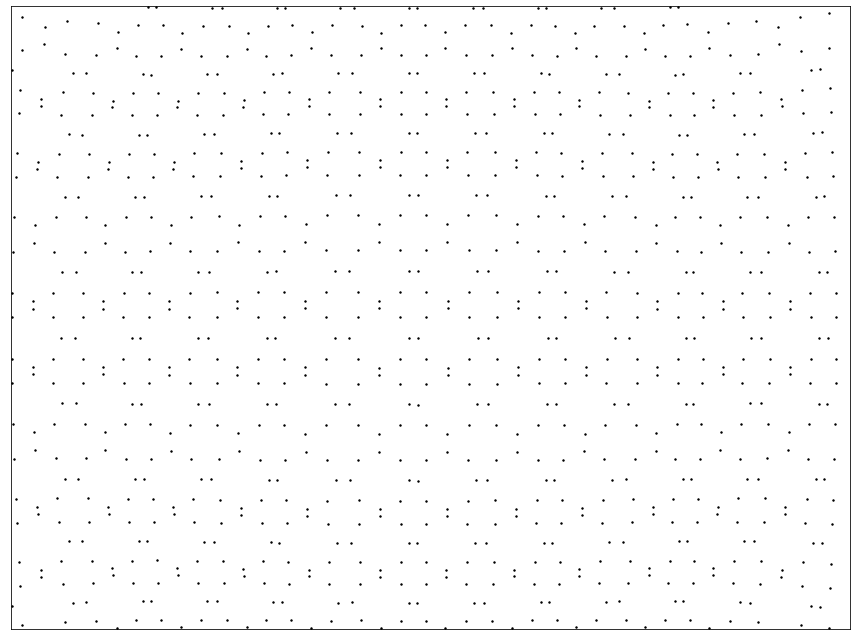

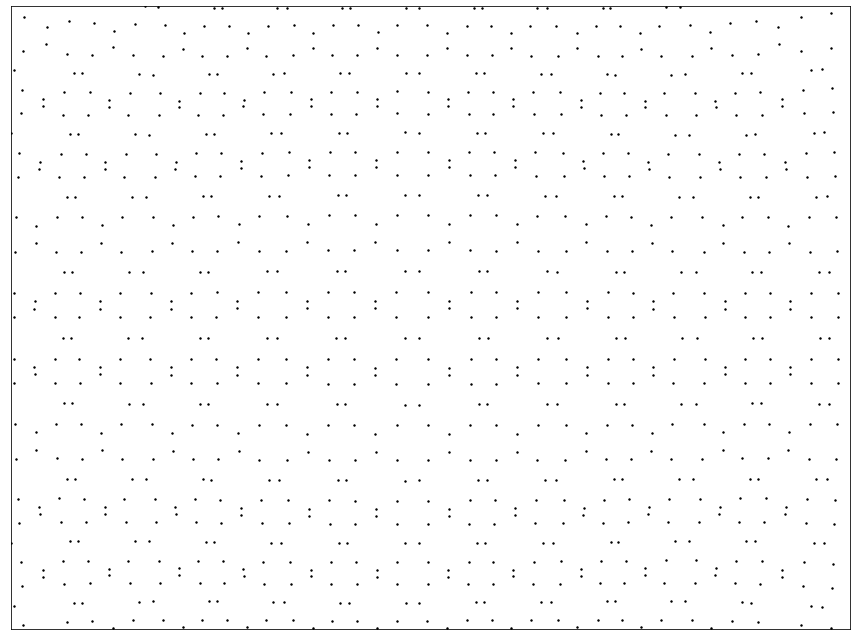

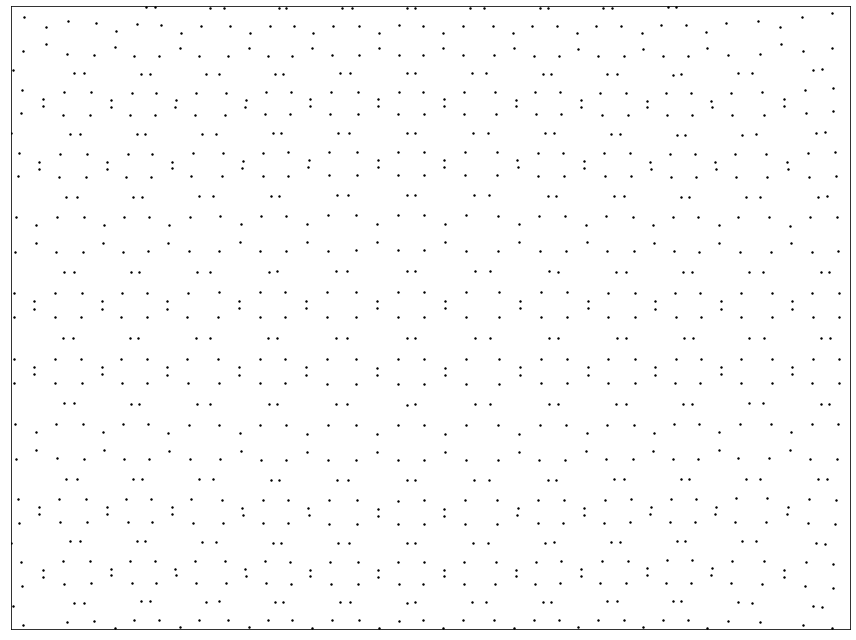

In [28]:
bolt_count = 8
bolt_positions = geo.get_bolt_locations_barrel(pmt_locations, bolt_count)
ring_positions = get_ring_positions(bolt_positions, pmt_locations.keys(), bolt_count)
ring_orientations = get_ring_orientations(bolt_positions, pmt_locations.keys(), bolt_count)
simulator = fit.PhotogrammetrySimulator(bolt_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)
image_feature_locations = simulator.get_image_feature_locations(area_restrict = [[0, 4000], [0, 3000]], min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
print("Feature in image counts:", Counter(feature_counts.values()))
simulator.show_images(image_feature_locations, area=[[0,4000],[0,3000]])

=== Gaussian errors on feature image locations: 0.5 ===
Feature in image counts: Counter({2: 5227, 3: 23})
50 images with total of  5250 features
image 0 reprojection errors:    average: 6.1374280351217    max: 18.502773617512783
image 1 reprojection errors:    average: 6.2167830018386425    max: 16.224877120141272
image 2 reprojection errors:    average: 5.885799765177765    max: 15.657464687771602
image 3 reprojection errors:    average: 5.842491065214738    max: 15.339993594124387
image 4 reprojection errors:    average: 6.904799471176873    max: 15.218886227875815
image 5 reprojection errors:    average: 6.273012969403583    max: 13.715579257240348
image 6 reprojection errors:    average: 6.835022643510802    max: 18.75118882405478
image 7 reprojection errors:    average: 6.160573873903243    max: 16.90599440610593
image 8 reprojection errors:    average: 6.110318432562536    max: 16.54802084137074
image 9 reprojection errors:    average: 6.160597159119236    max: 16.33467558601169

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5161e+05                                    2.87e+06    
       1              2         8.5644e+03      2.43e+05       1.03e+02       8.97e+03    
       2              3         6.7631e+03      1.80e+03       2.68e+01       1.57e+04    
       3              4         6.0803e+03      6.83e+02       7.54e+00       2.28e+03    
       4              5         5.8497e+03      2.31e+02       3.64e+00       2.81e+02    
       5              6         5.6546e+03      1.95e+02       3.86e+00       4.10e+02    
       6              7         5.4854e+03      1.69e+02       2.97e+00       2.84e+02    
       7              8         5.3366e+03      1.49e+02       3.08e+00       5.74e+02    
       8              9         5.2460e+03      9.05e+01       1.36e+00       3.86e+02    
       9             10         5.2150e+03      3.10e+01       5.06e-01       2.16e+02    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.1730e+05                                    4.62e+06    
       1              2         3.8081e+04      2.79e+05       1.10e+02       1.12e+04    
       2              3         3.5526e+04      2.56e+03       2.02e+01       1.03e+04    
       3              4         3.3992e+04      1.53e+03       8.14e+00       6.26e+02    
       4              5         3.3540e+04      4.52e+02       4.25e+00       2.61e+03    
       5              6         3.3257e+04      2.83e+02       1.44e+00       5.34e+02    
       6              7         3.2991e+04      2.65e+02       2.97e+00       2.28e+03    
       7              8         3.2739e+04      2.53e+02       1.36e+00       5.29e+02    
       8              9         3.2492e+04      2.47e+02       2.86e+00       2.03e+03    
       9             10         3.2251e+04      2.41e+02       1.33e+00       5.18e+02    

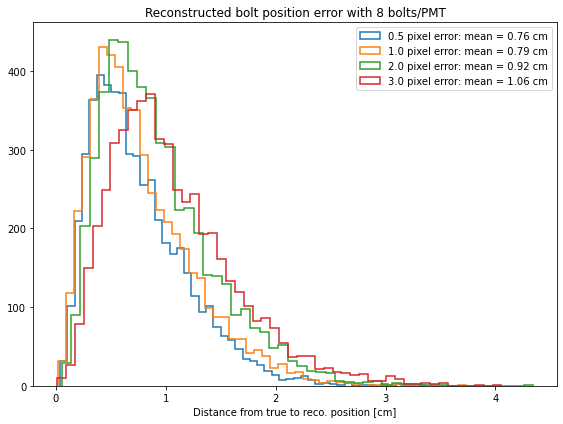

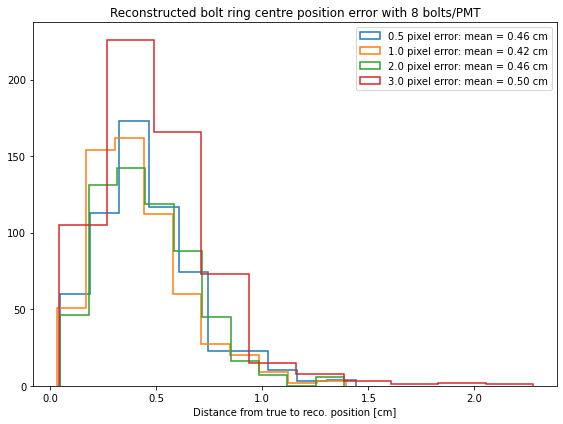

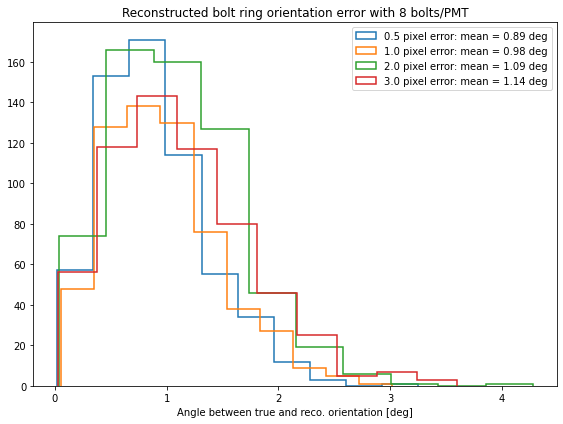

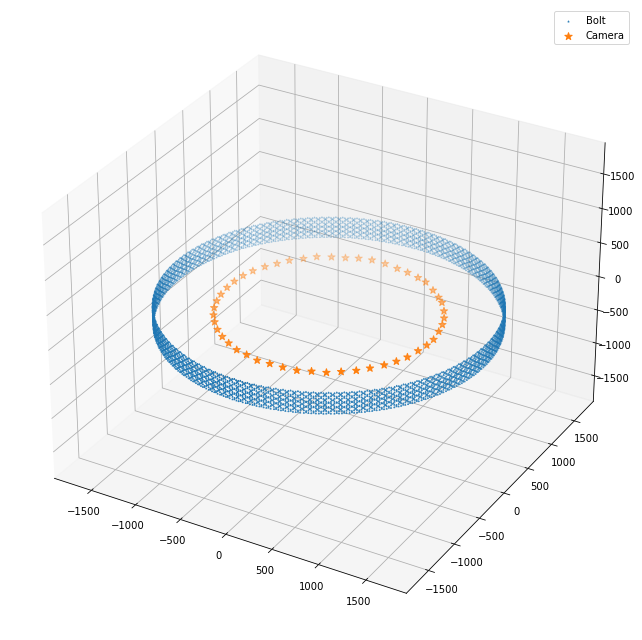

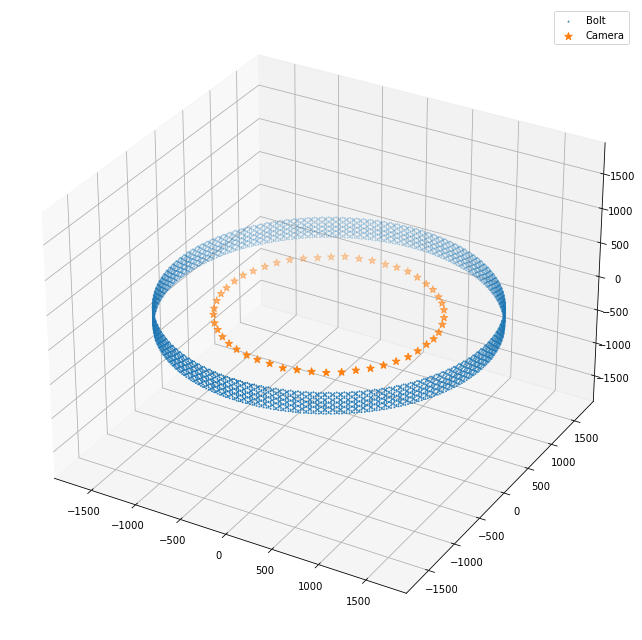

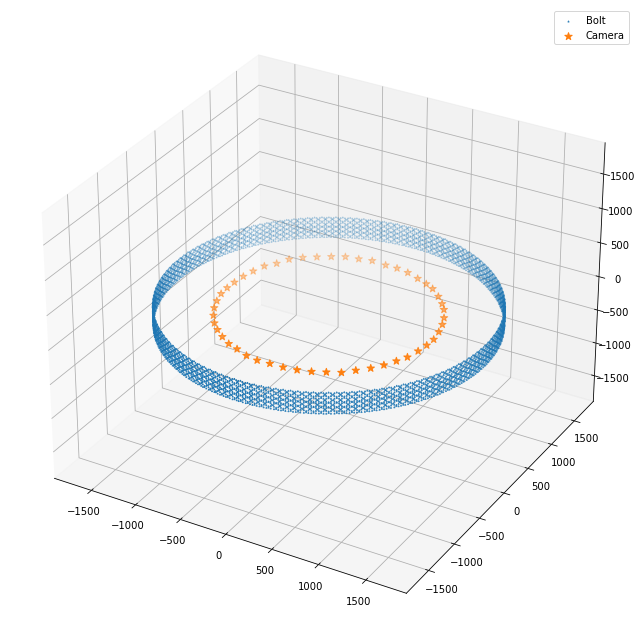

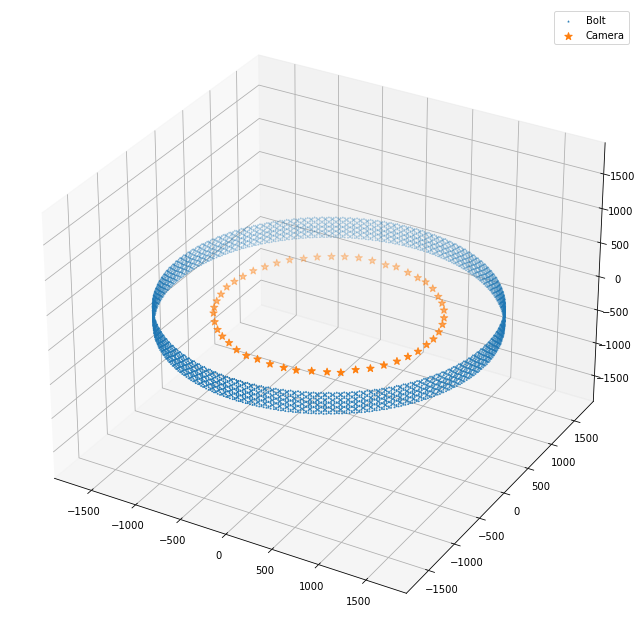

In [29]:
fig_bolt_pos, ax_bolt_pos = make_fig("Reconstructed bolt position error with {} bolts/PMT".format(bolt_count), "Distance from true to reco. position [cm]")
fig_ring_pos, ax_ring_pos = make_fig("Reconstructed bolt ring centre position error with {} bolts/PMT".format(bolt_count), "Distance from true to reco. position [cm]")
fig_ring_ang, ax_ring_ang = make_fig("Reconstructed bolt ring orientation error with {} bolts/PMT".format(bolt_count), "Angle between true and reco. orientation [deg]")
for pixel_error in [0.5, 1.0, 2.0, 3.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=[[1000, 3000], [750, 2250]], min_feature_count=2, pixel_error=pixel_error)
    feature_counts = Counter([f for i in smeared_feature_locations.values() for f in i.keys()])
    print("Feature in image counts:", Counter(feature_counts.values()))
    bolt_positions2 = {k: v for k, v in bolt_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_bolt_simulation(bolt_positions2, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_bolt_positions, position_errors = run_bolt_fit(fitter, bolt_positions2, xtol=1e-5)
    centre_errors = get_ring_centre_errors(reco_bolt_positions, ring_positions, bolt_count)
    orientation_errors = get_ring_orientation_errors(reco_bolt_positions, ring_orientations, bolt_count)
    ax_bolt_pos.hist(position_errors, bins=50, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors.mean()))
    ax_ring_pos.hist(centre_errors, bins=10, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors.mean()))
    ax_ring_ang.hist(orientation_errors, bins=10, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors.mean()))
    reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(bolt_positions, reco_bolt_positions)
    reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
    plot_reconstruction(reco_transformed, reco_cam_positions)
    bolt_position_errors[bolt_count][pixel_error] = position_errors.mean()
    ring_position_errors[bolt_count][pixel_error] = centre_errors.mean()
    ring_orientation_errors[bolt_count][pixel_error] = orientation_errors.mean()
ax_bolt_pos.legend(loc='upper right')
ax_ring_pos.legend(loc='upper right')
ax_ring_ang.legend(loc='upper right')

# Simulation with 12 bolts

Feature in image counts: Counter({4: 15120, 5: 1724, 3: 406})


/home/prouse/work/PhotogrammetryAnalysis/pg_fitter_tools.py:203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


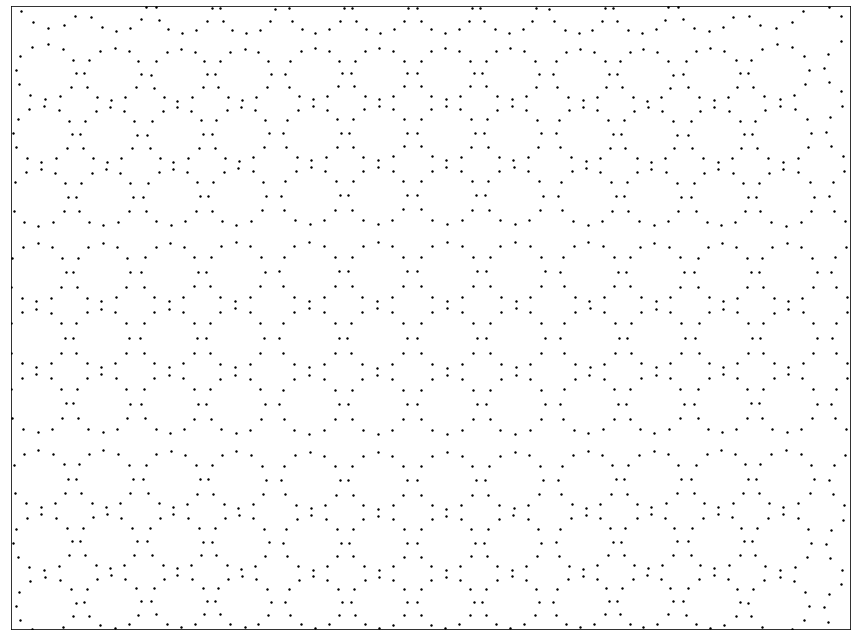

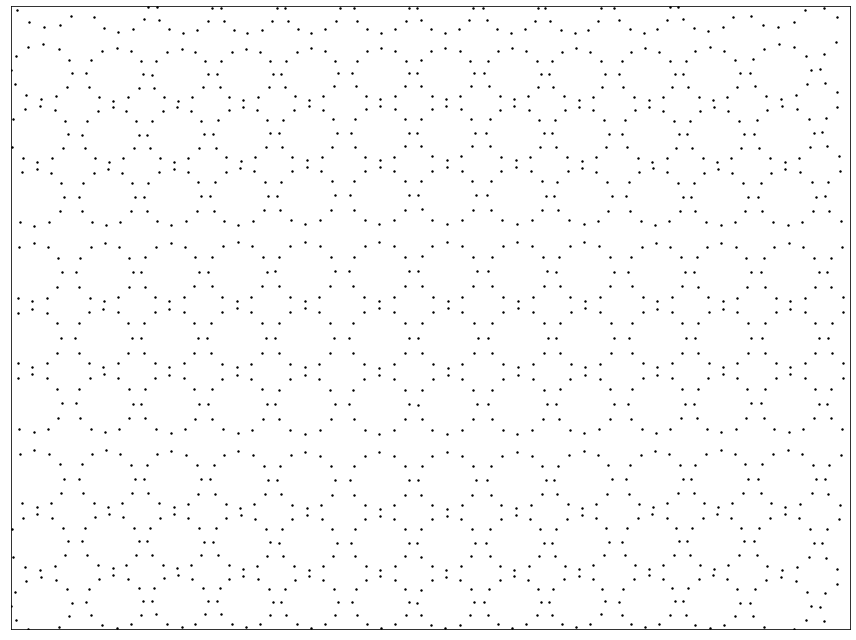

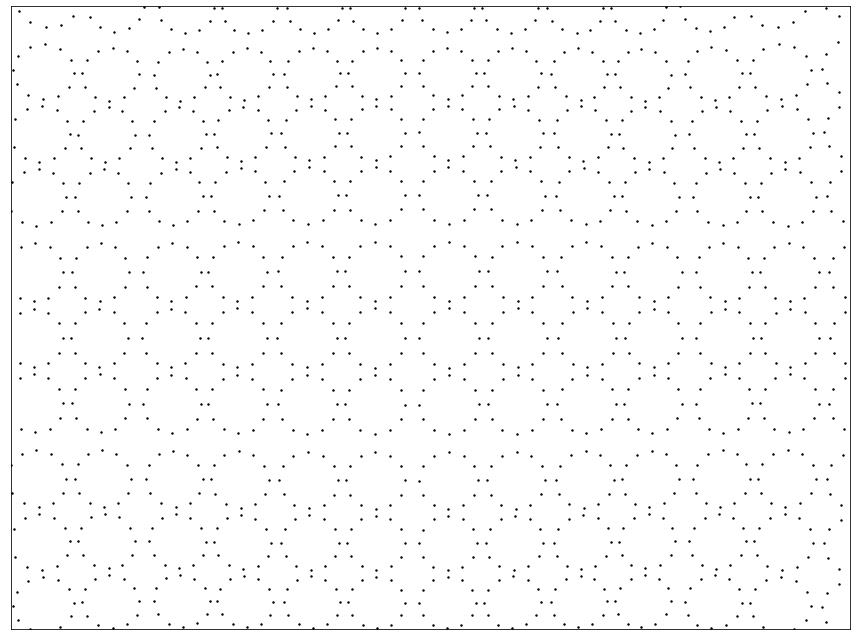

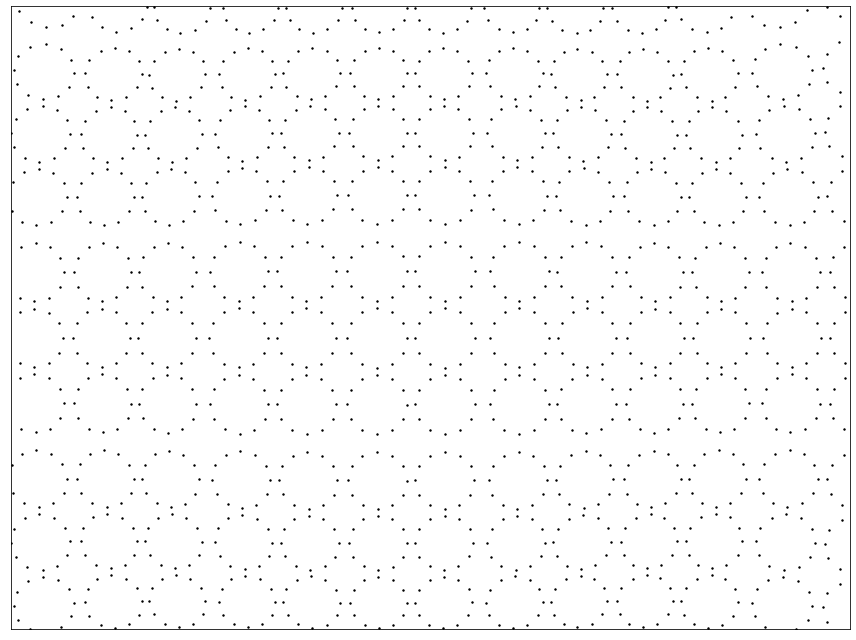

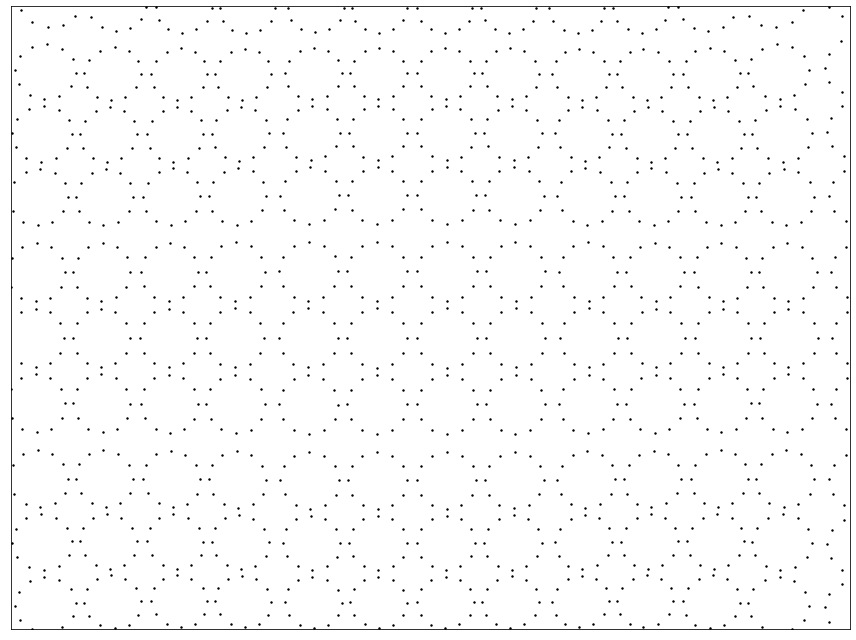

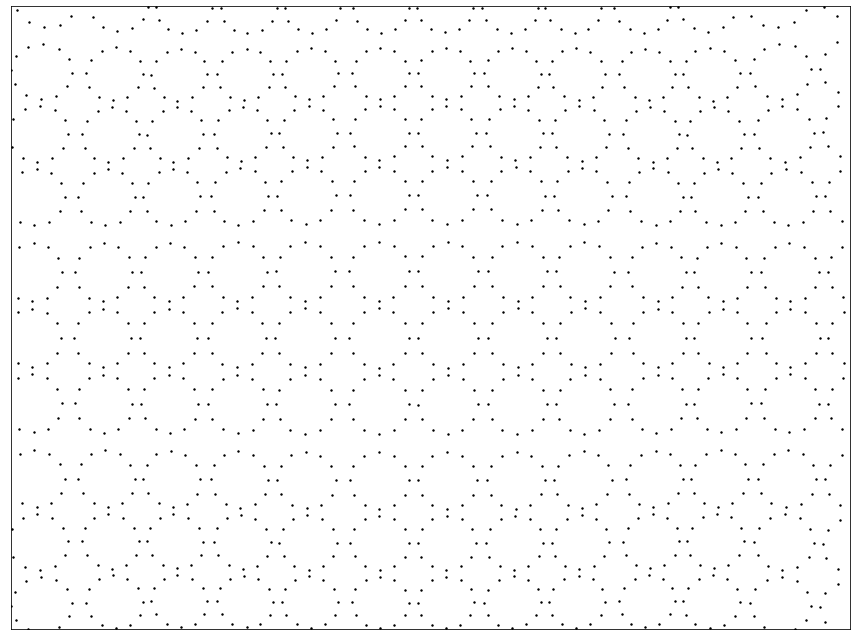

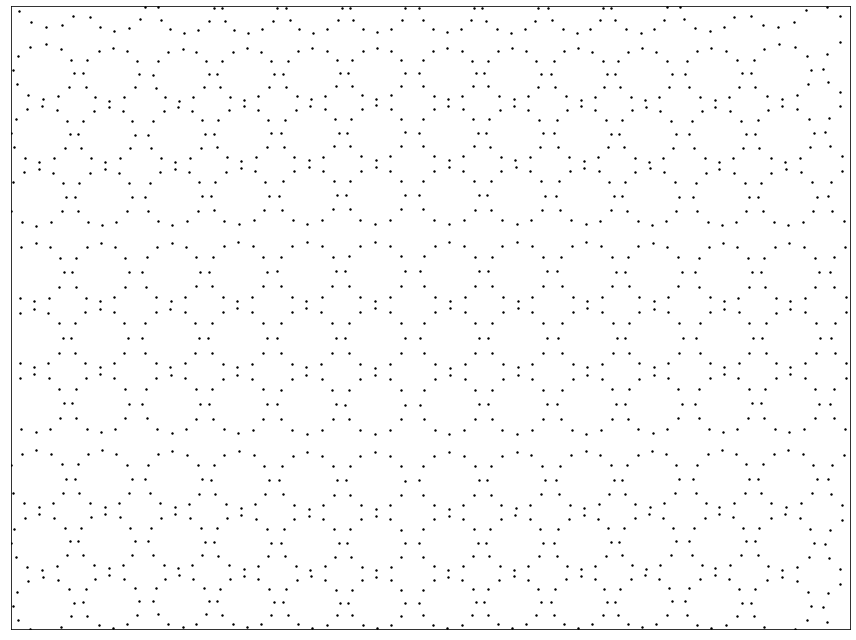

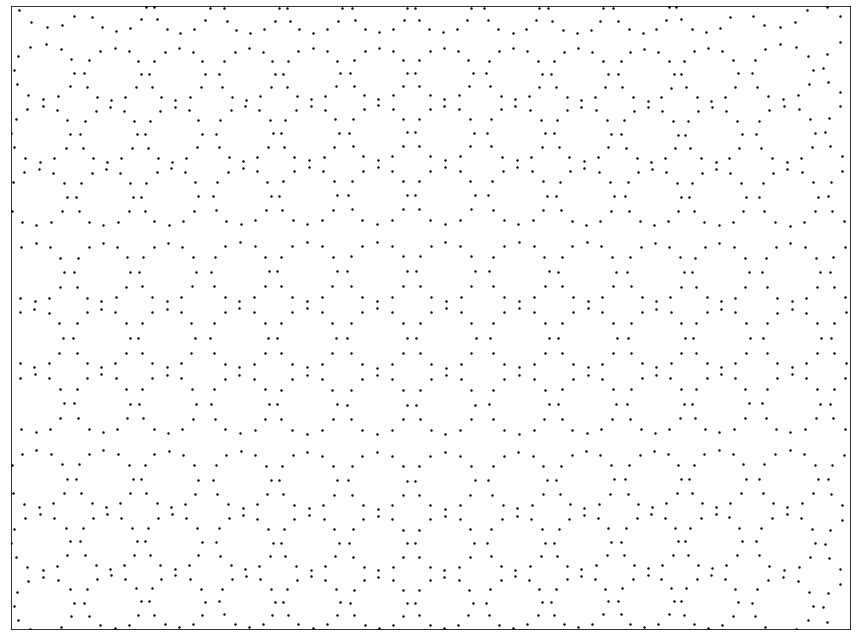

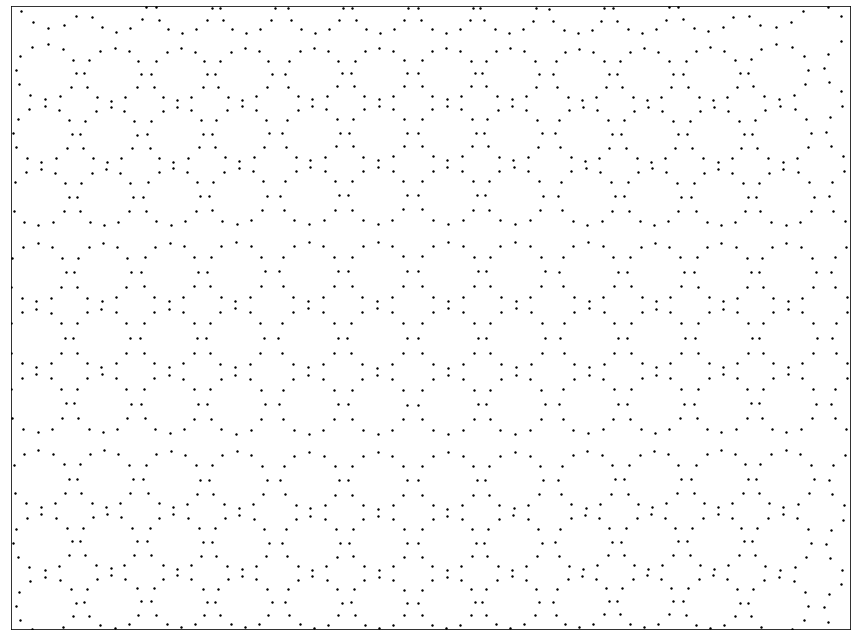

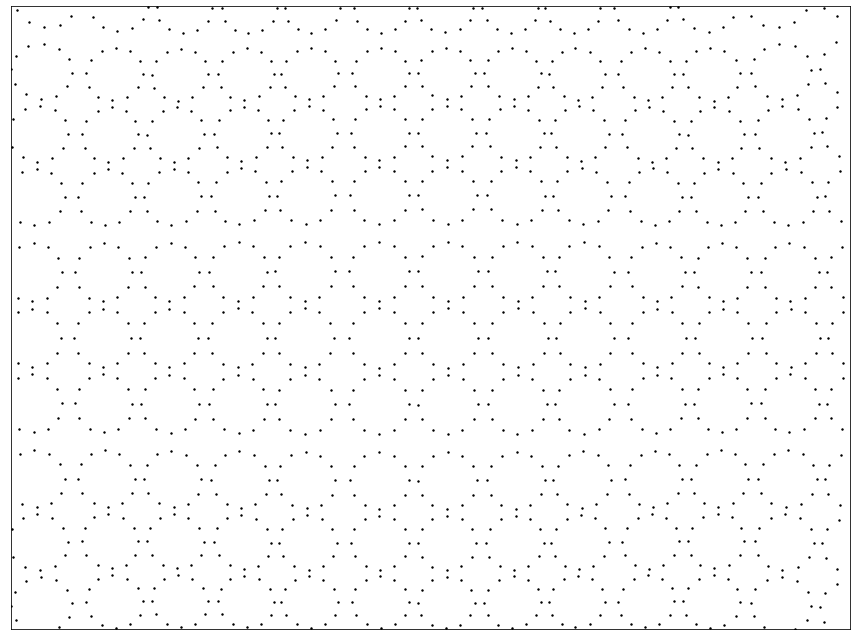

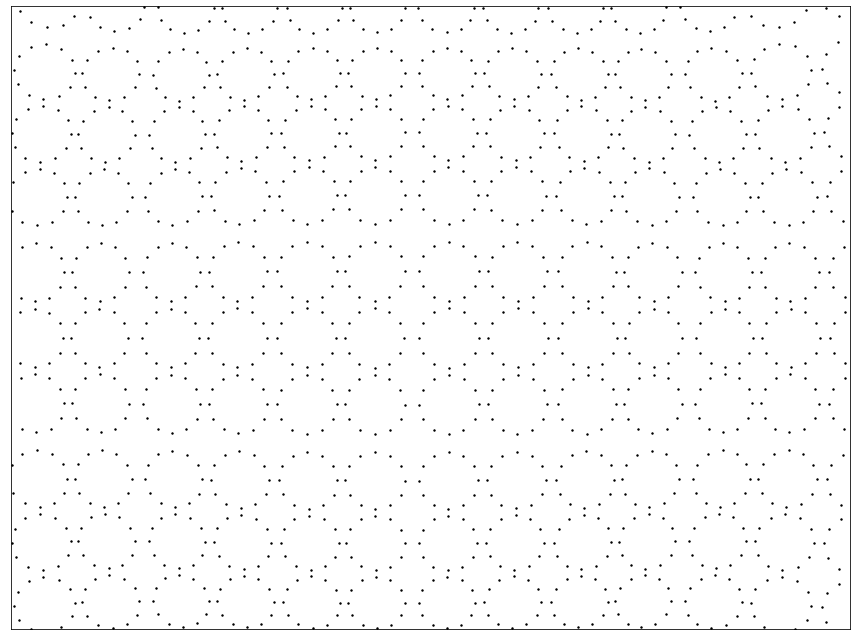

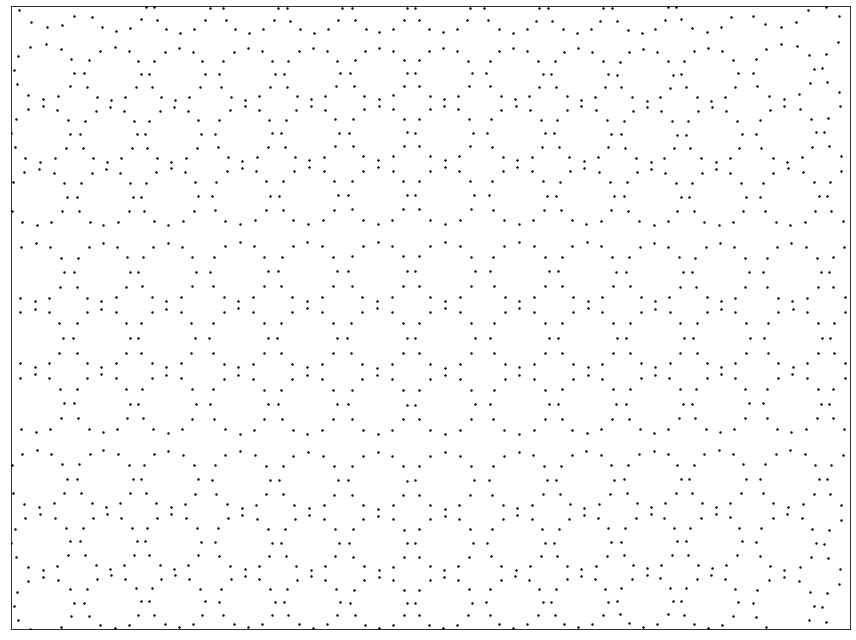

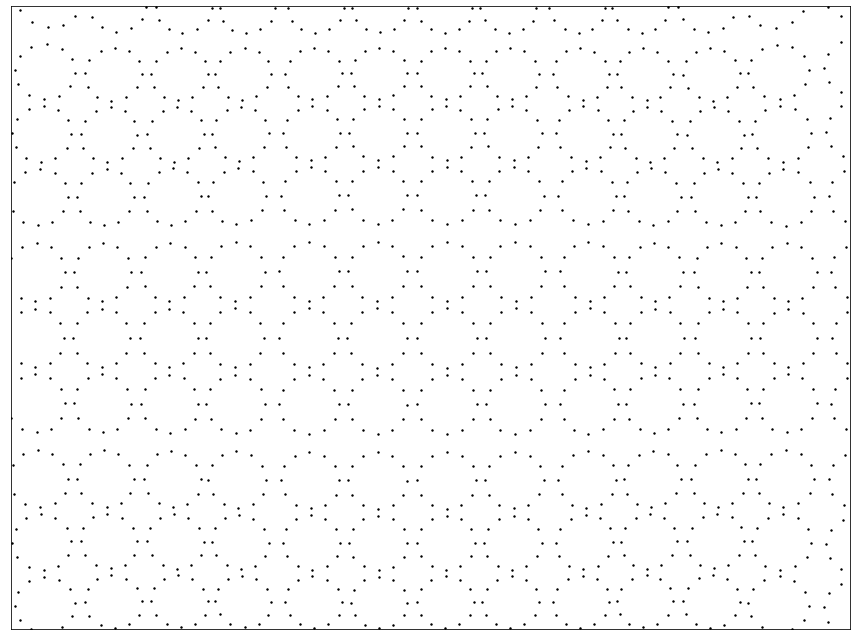

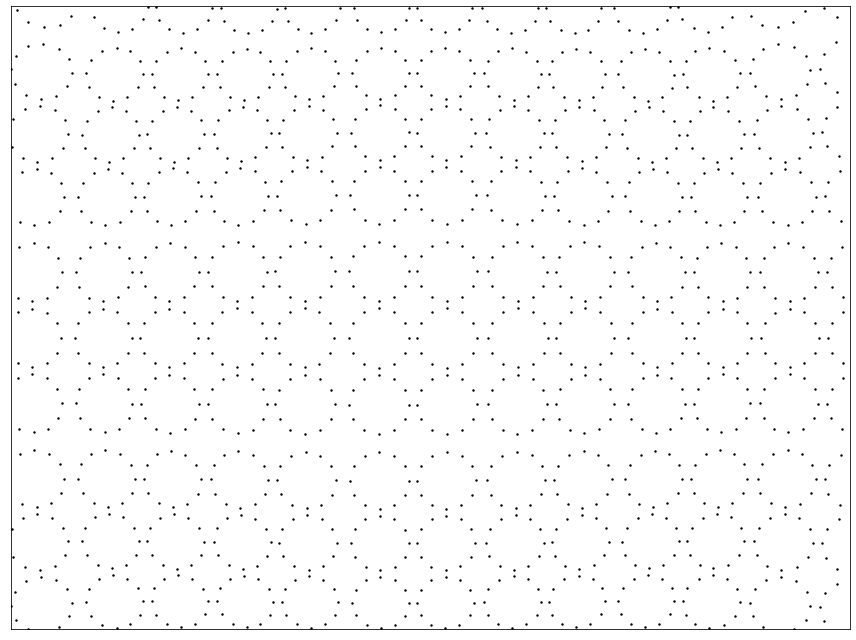

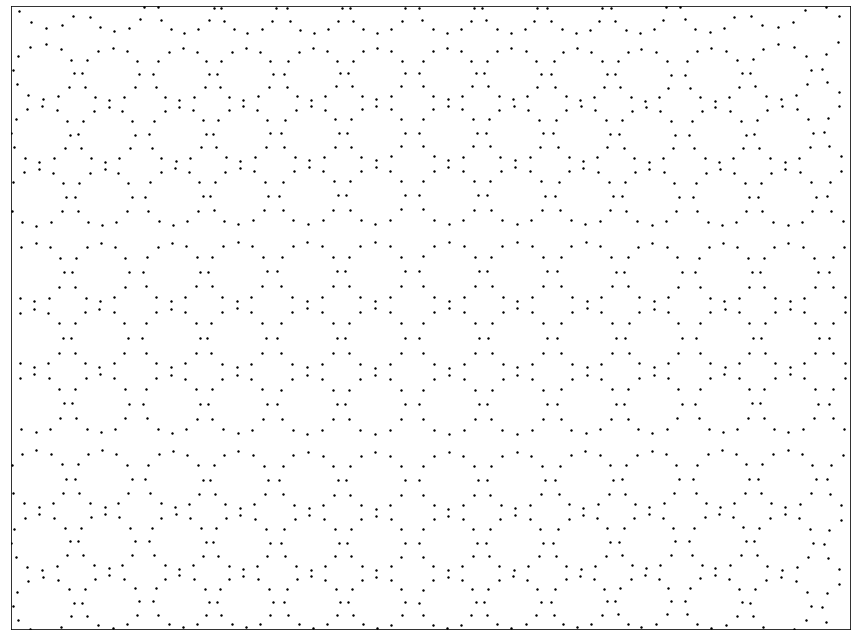

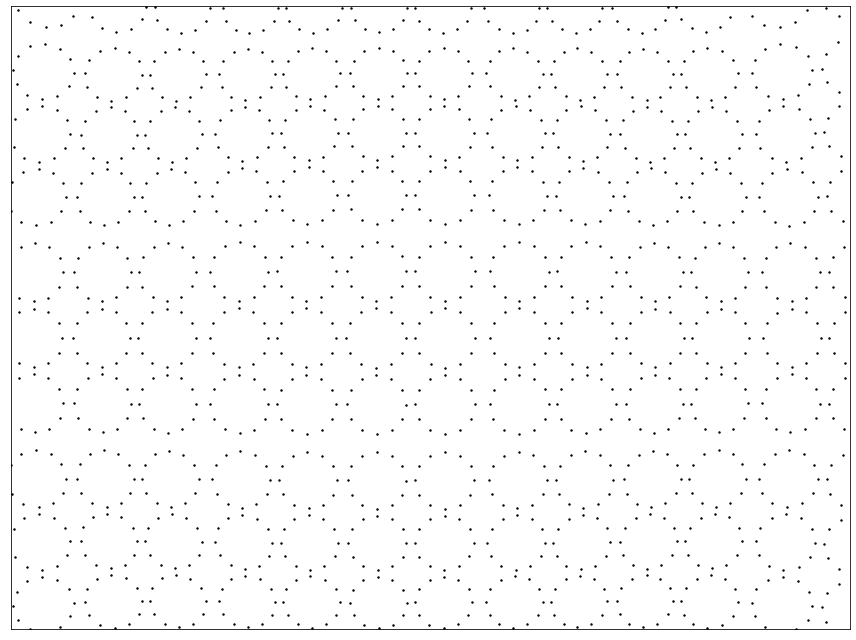

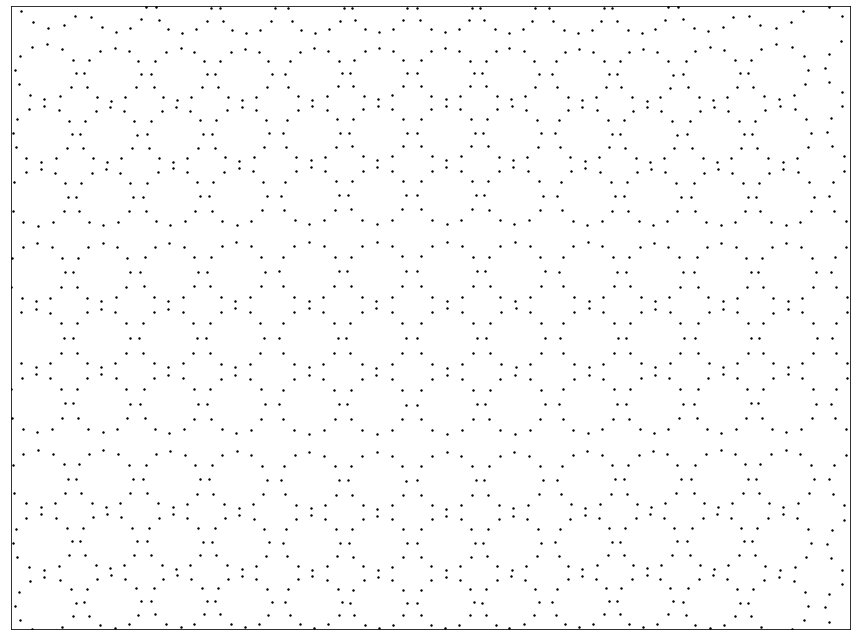

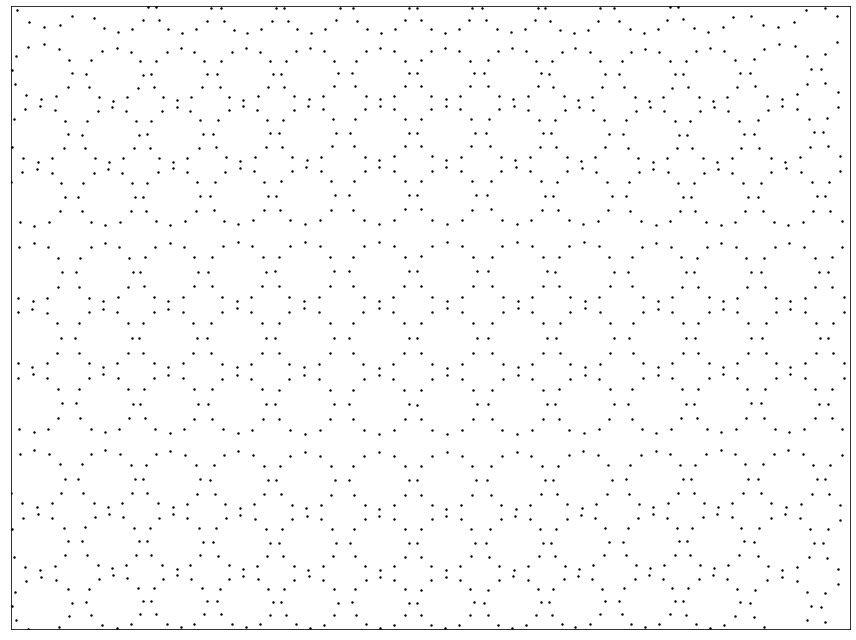

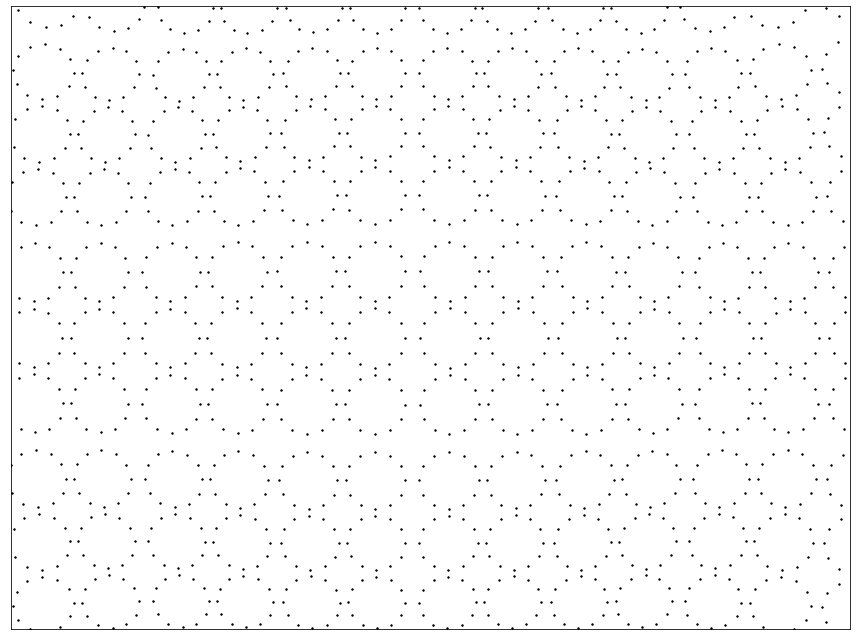

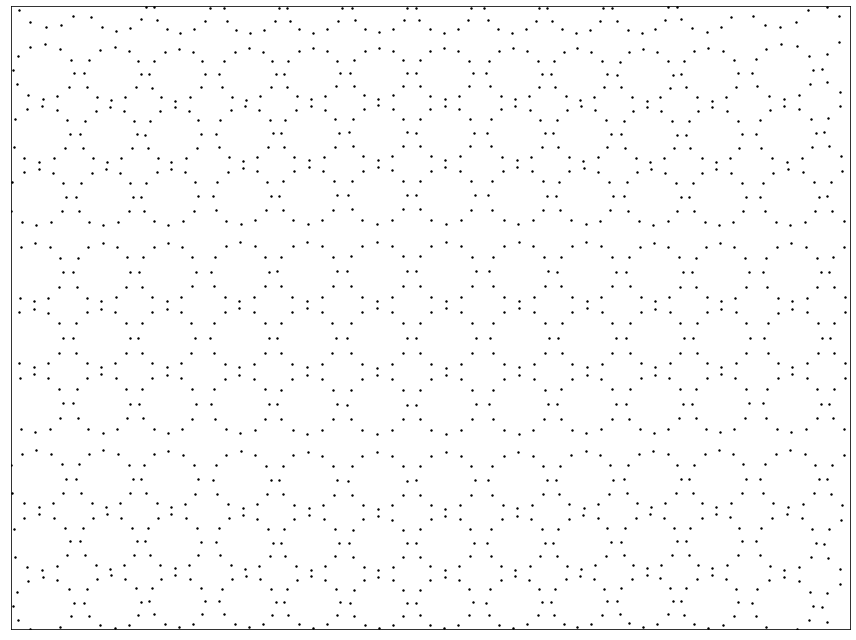

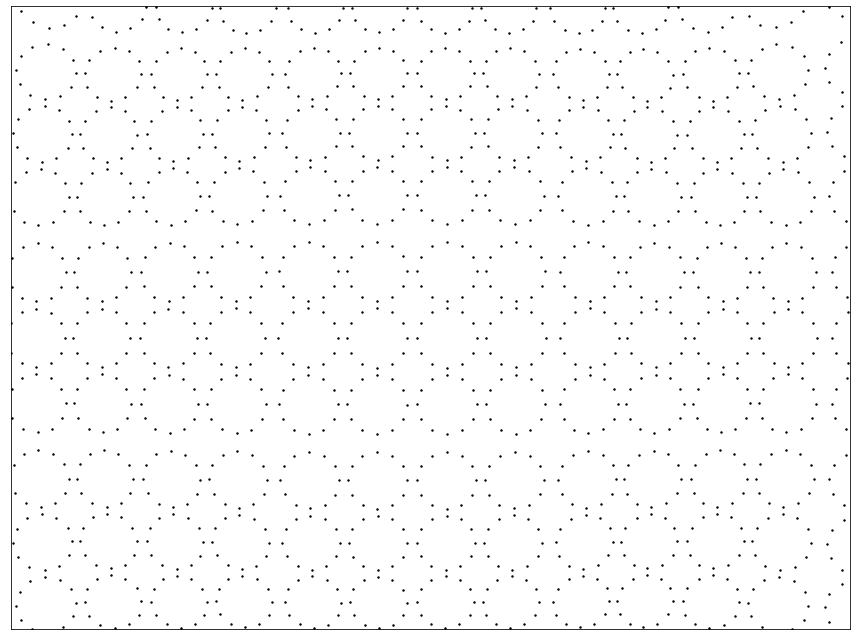

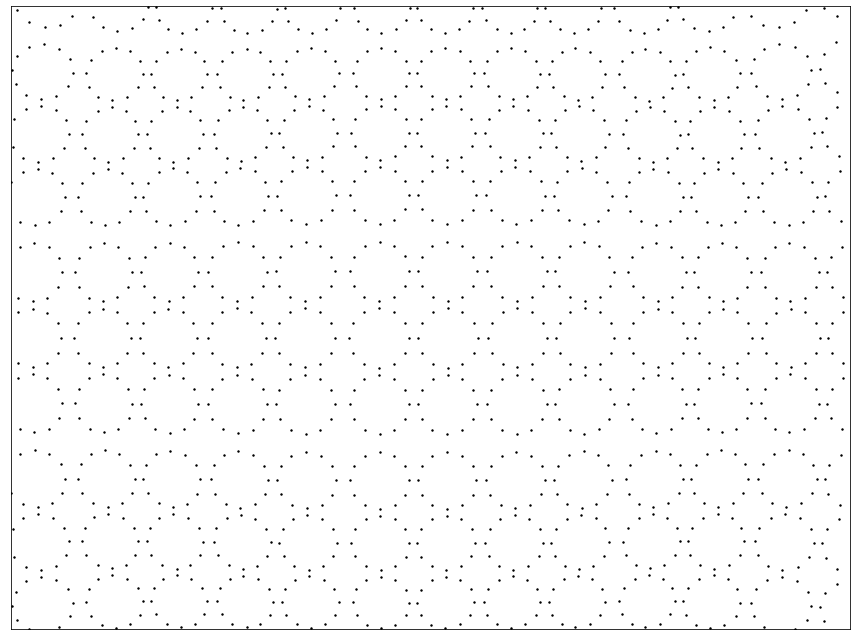

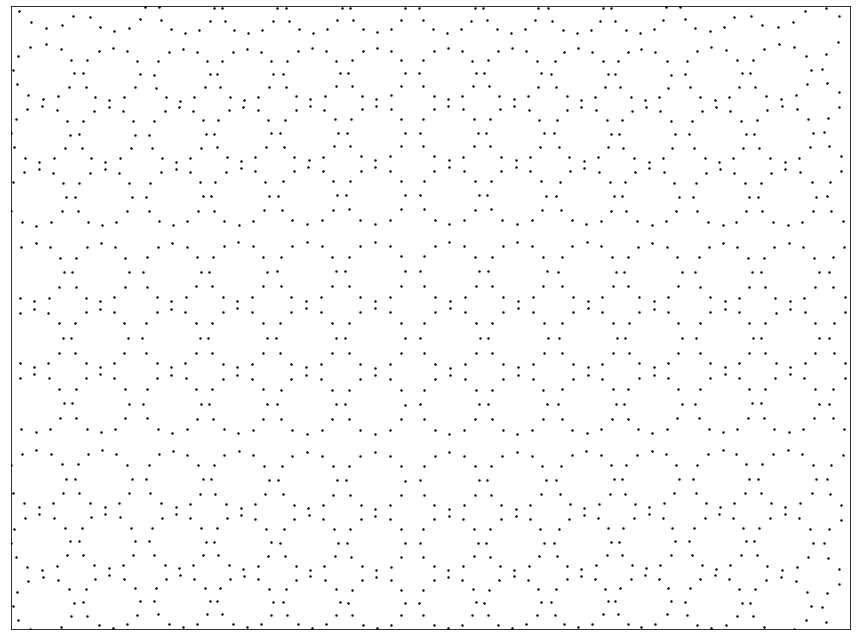

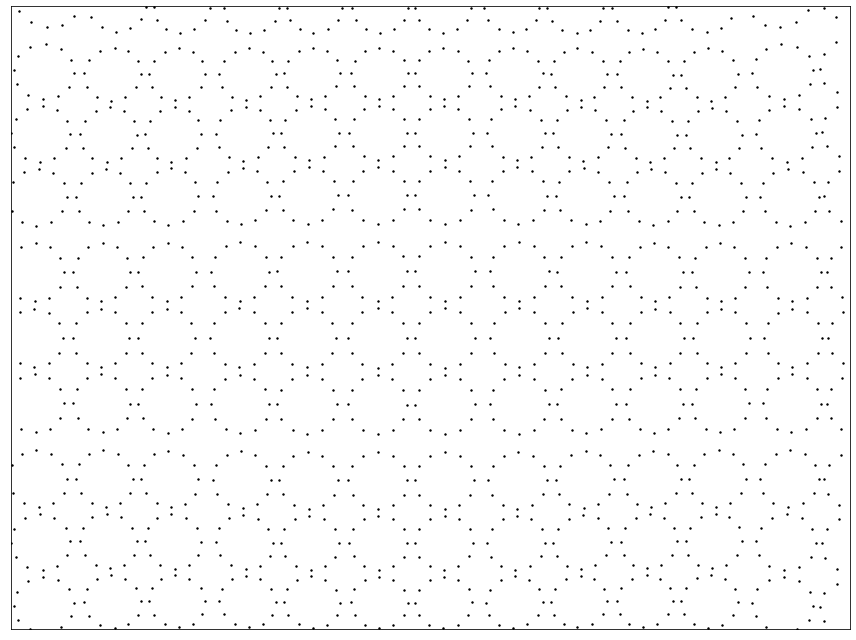

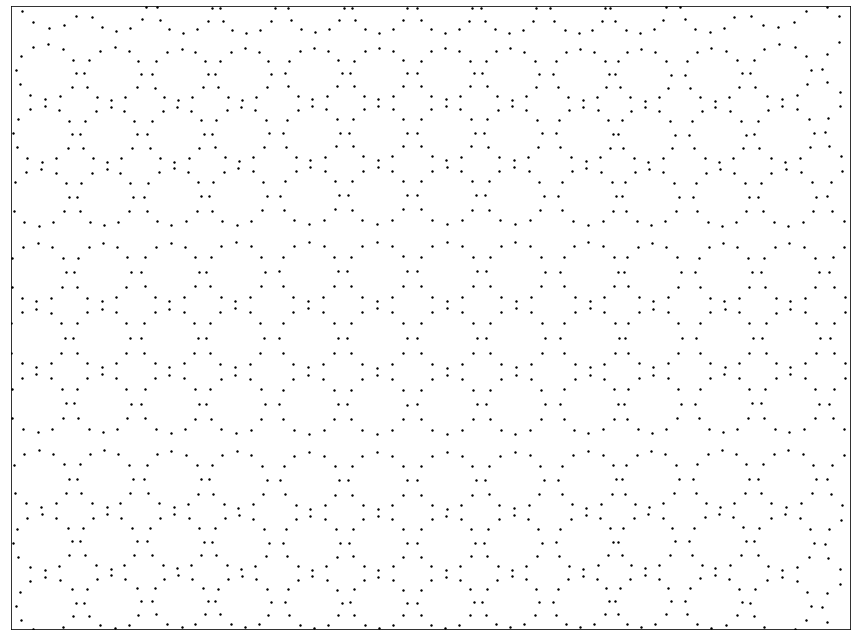

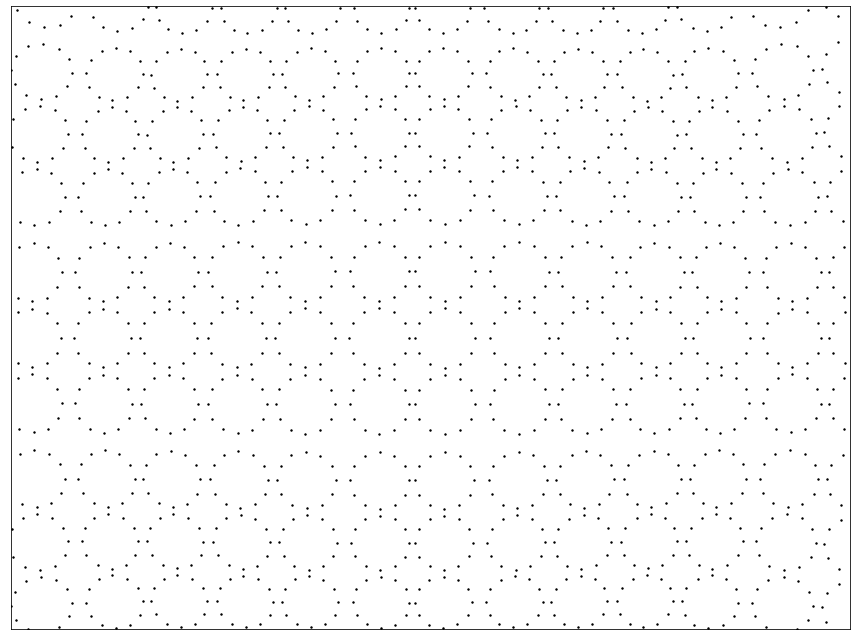

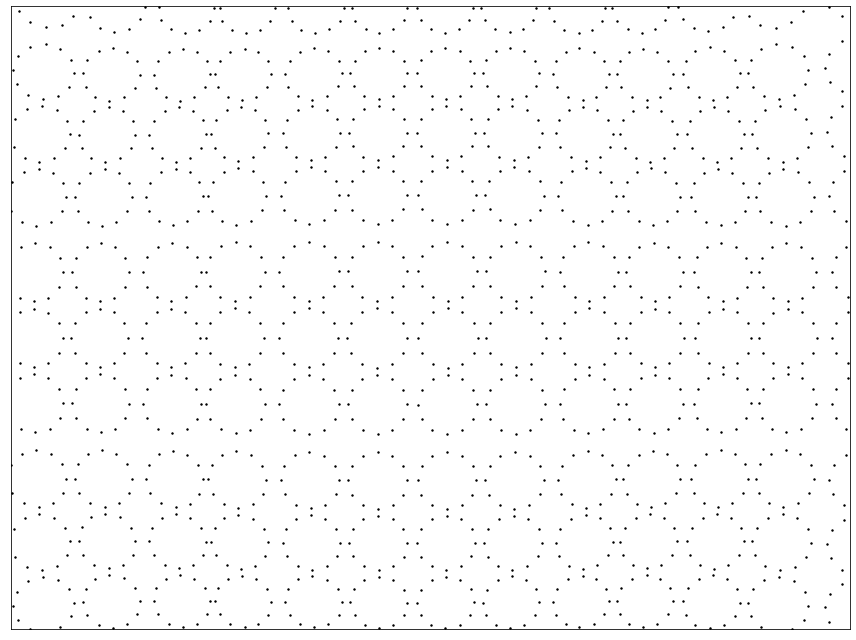

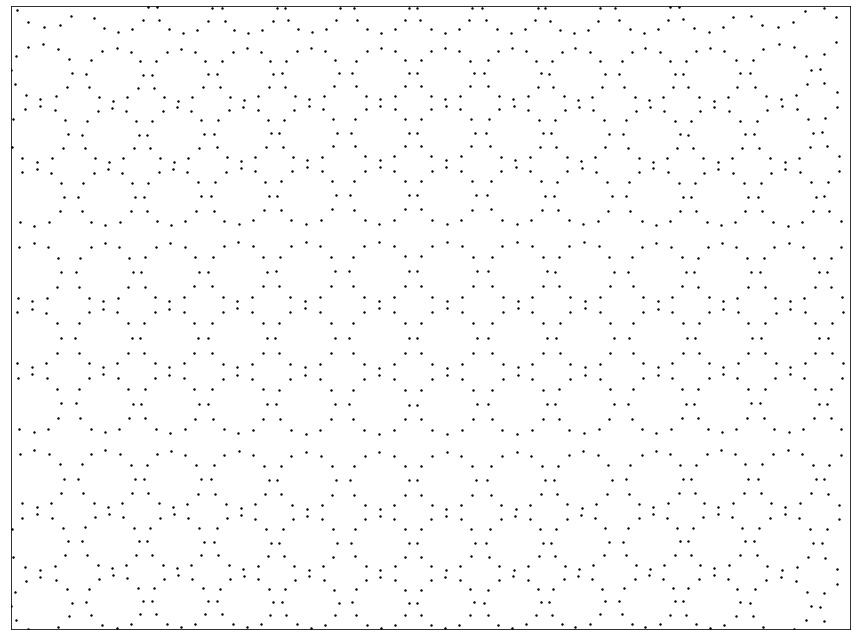

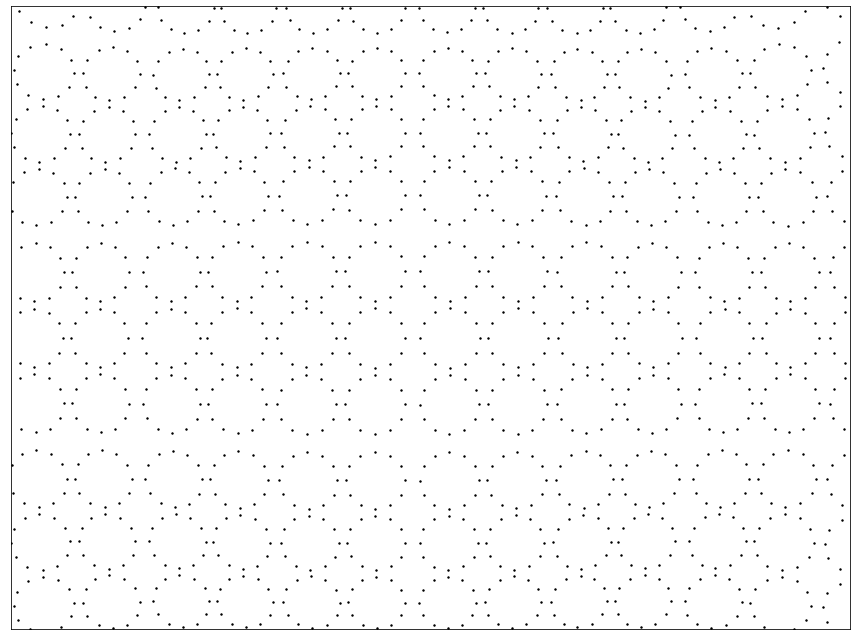

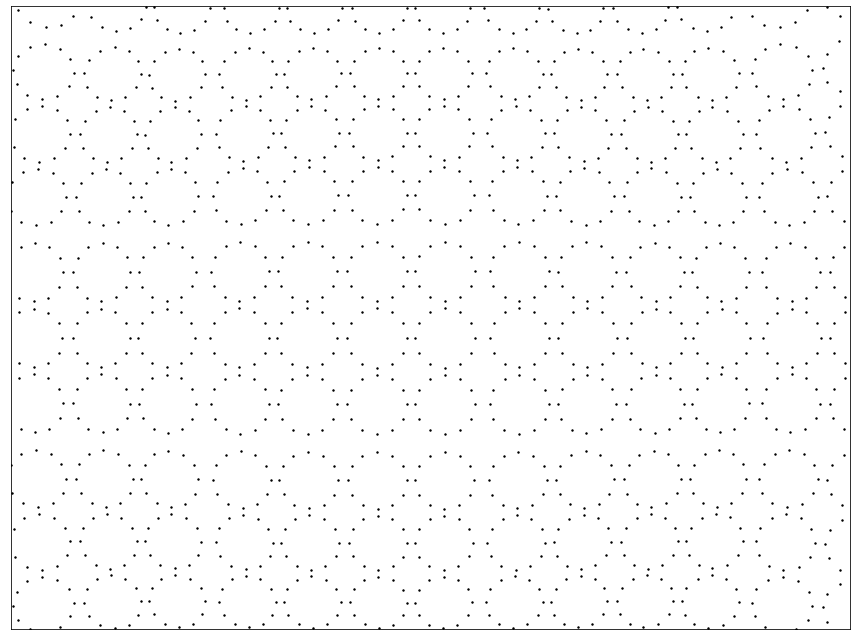

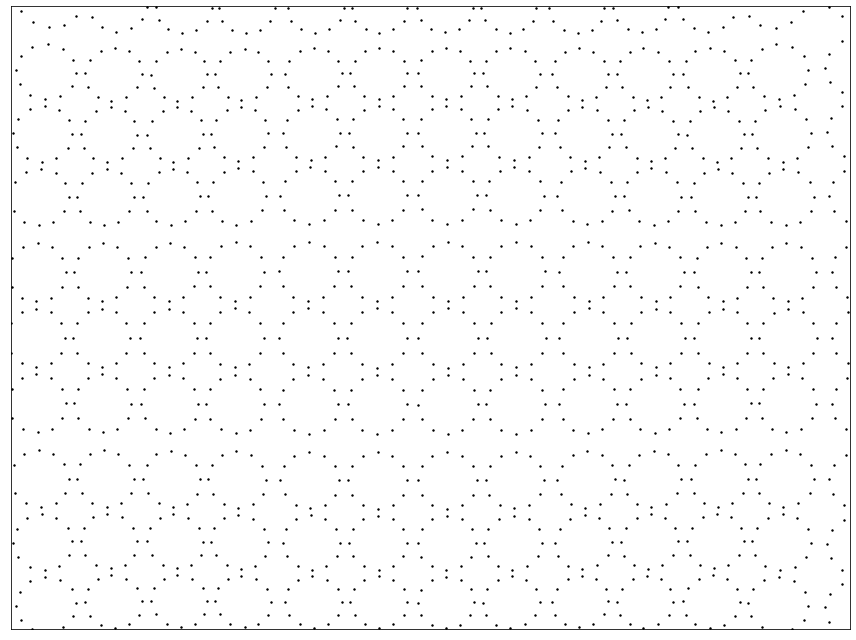

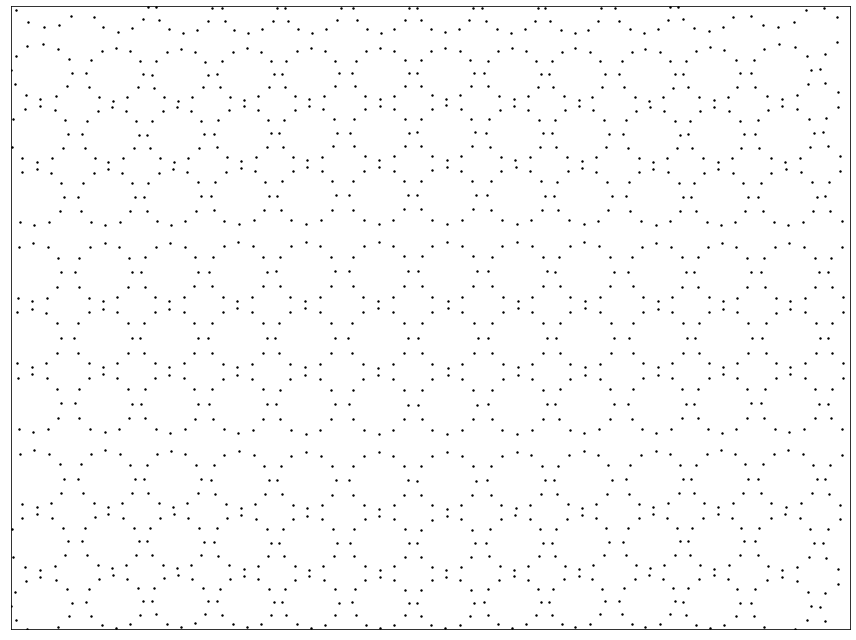

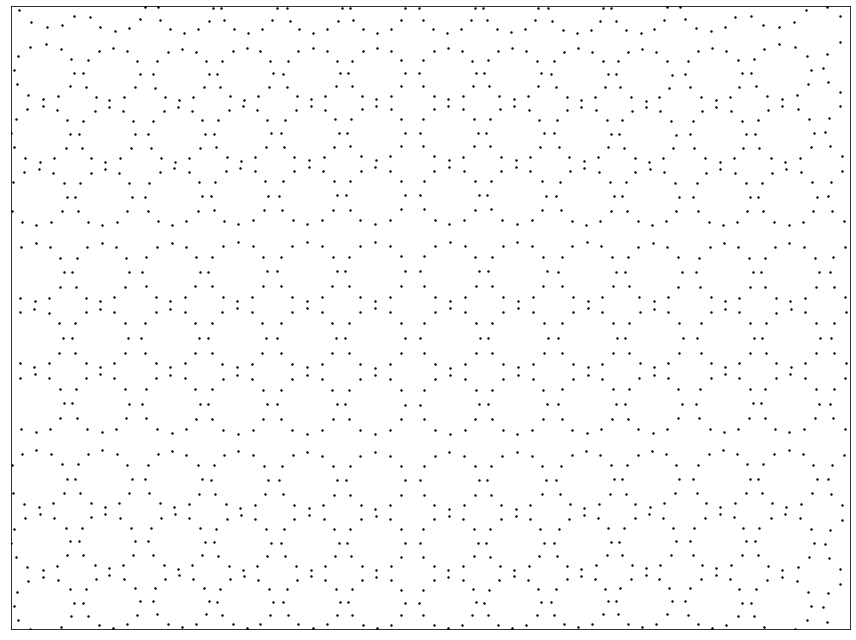

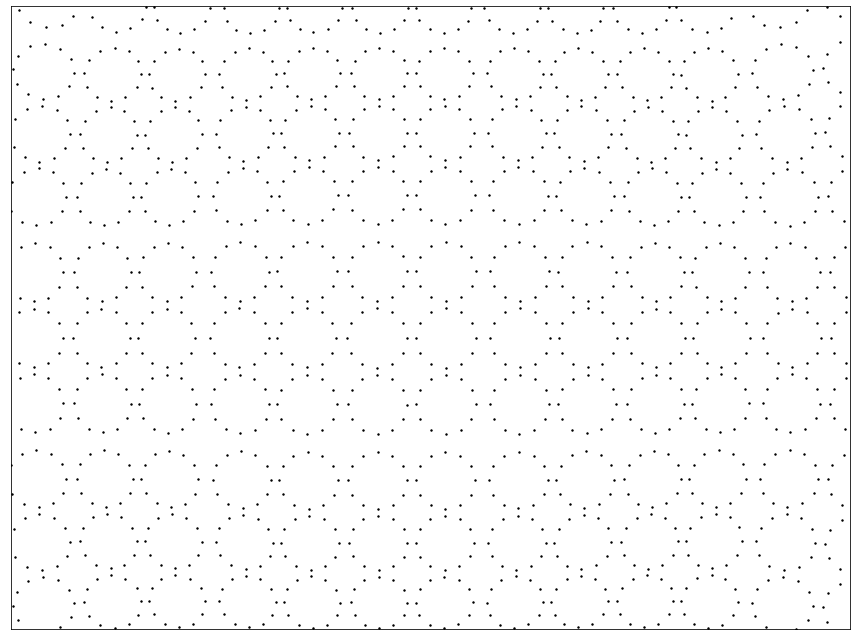

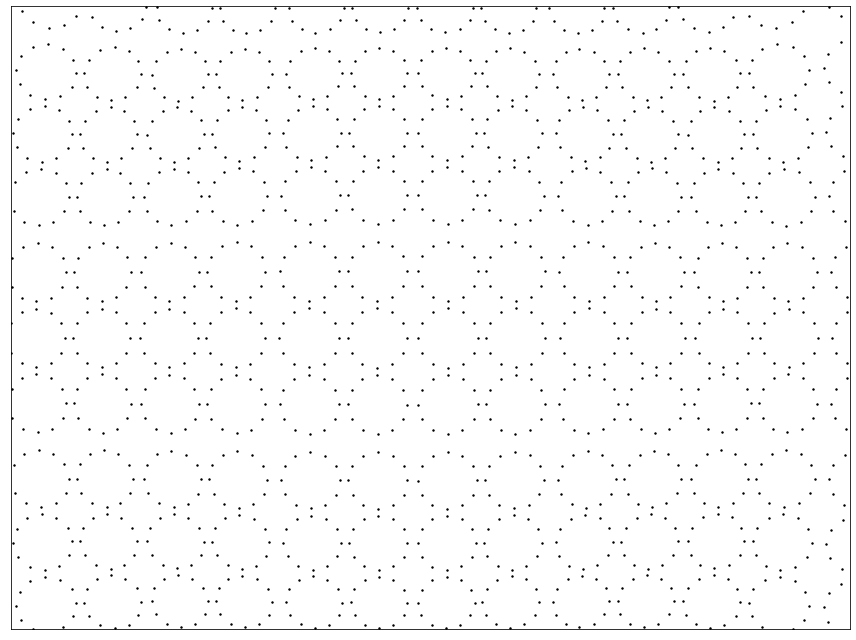

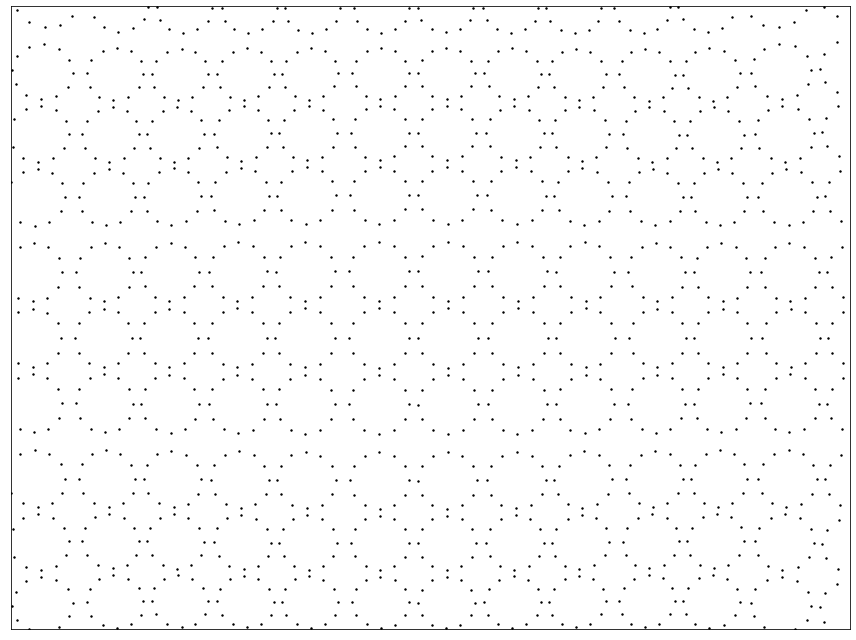

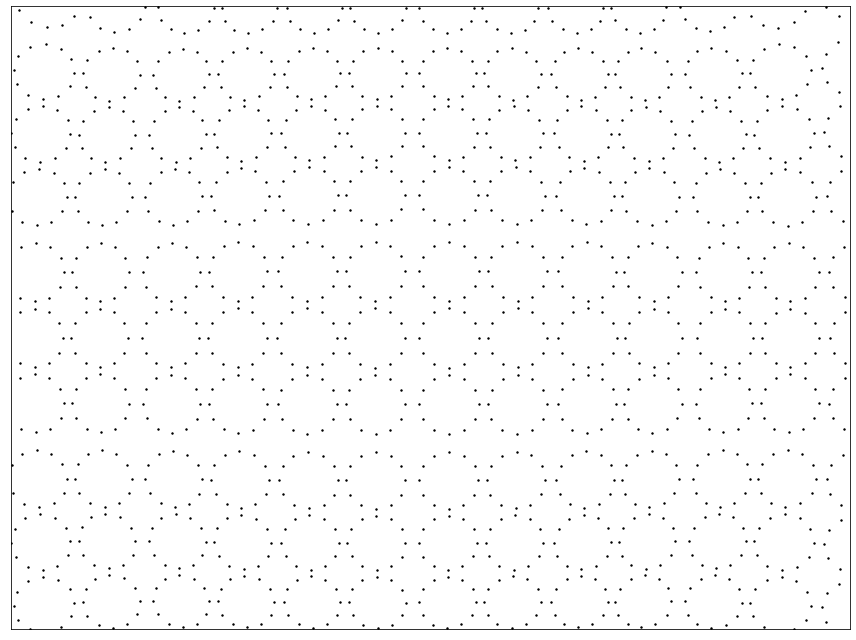

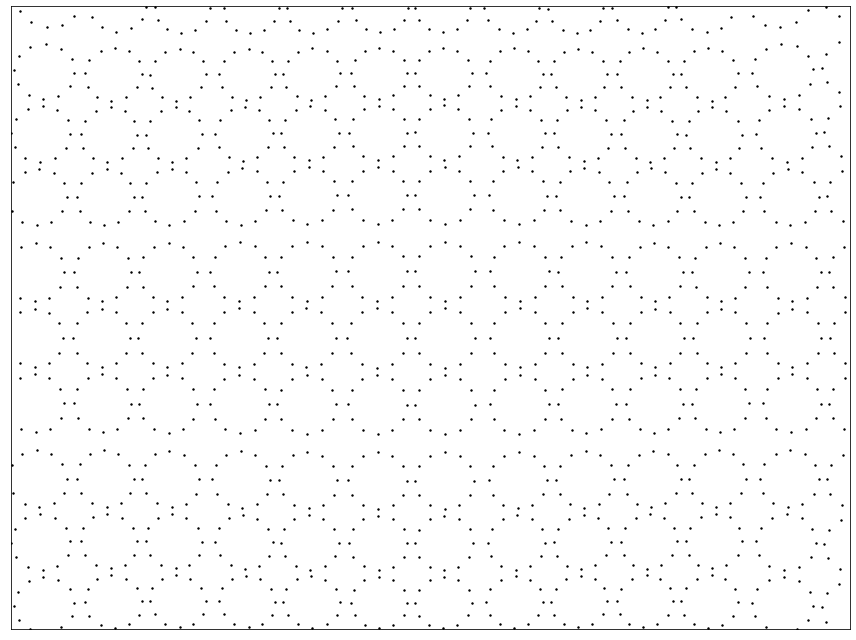

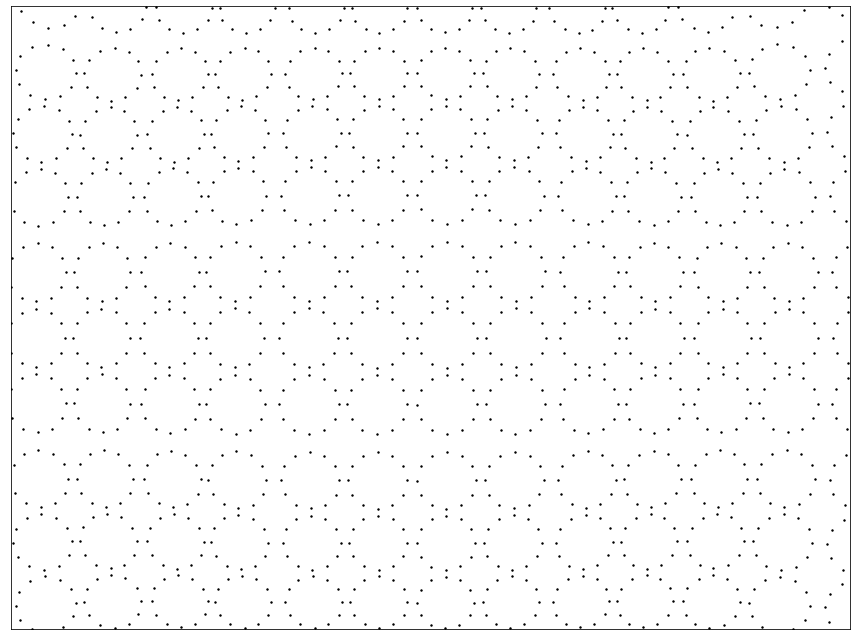

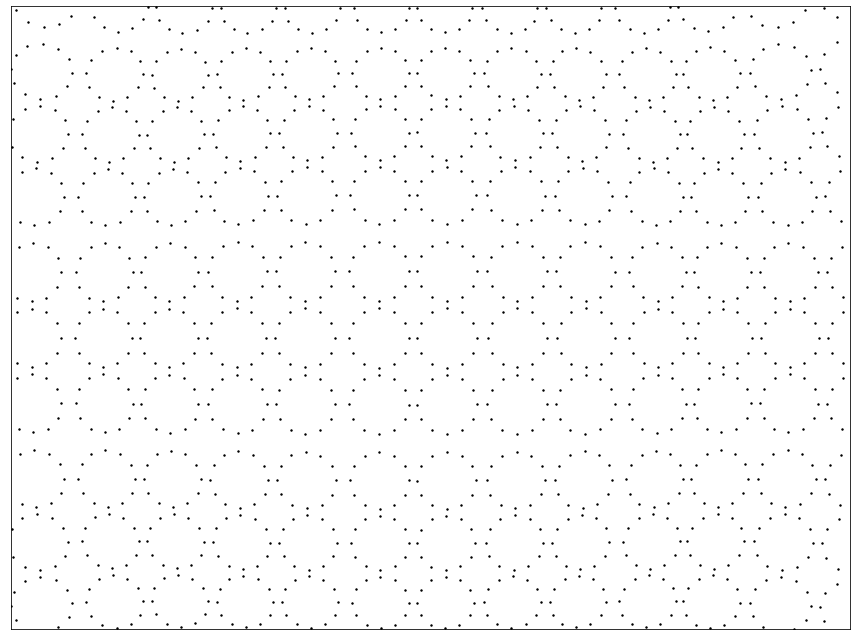

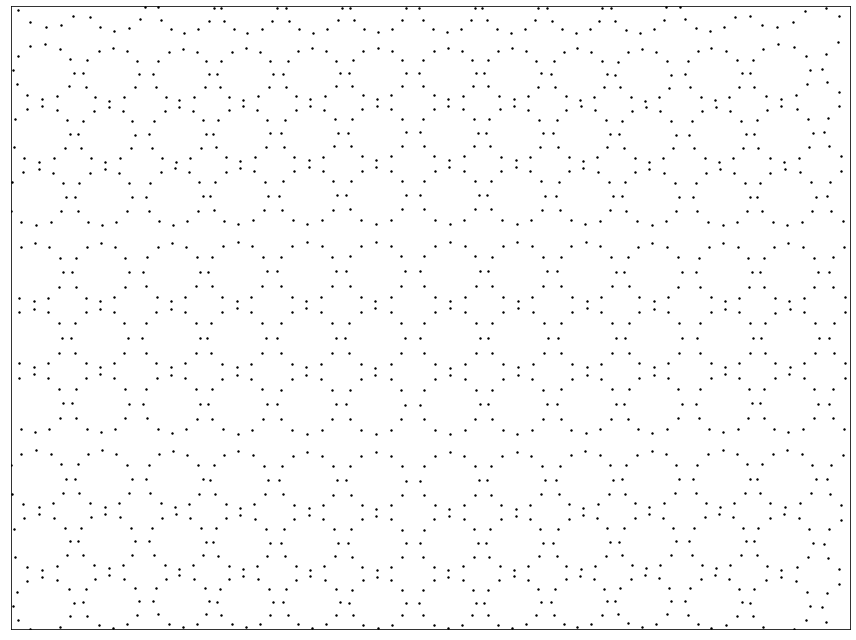

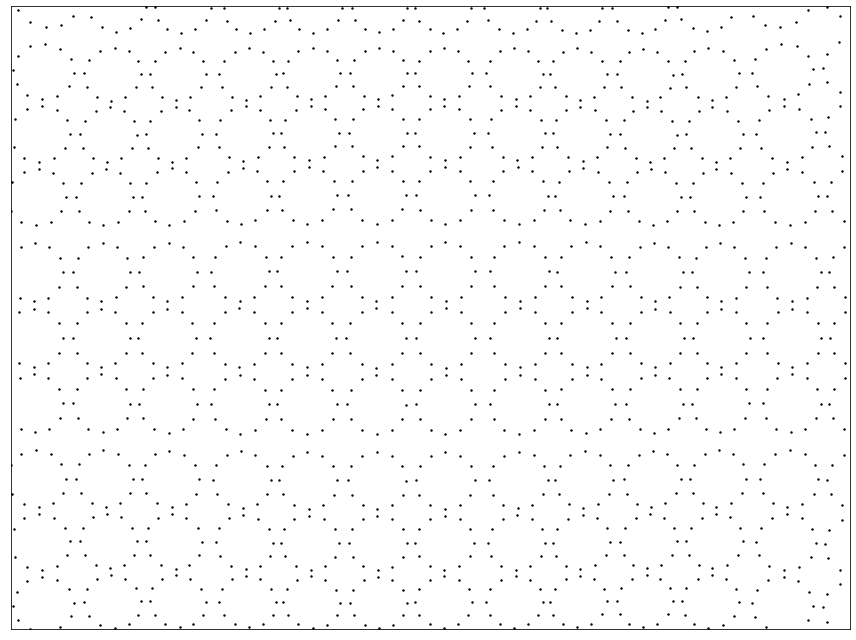

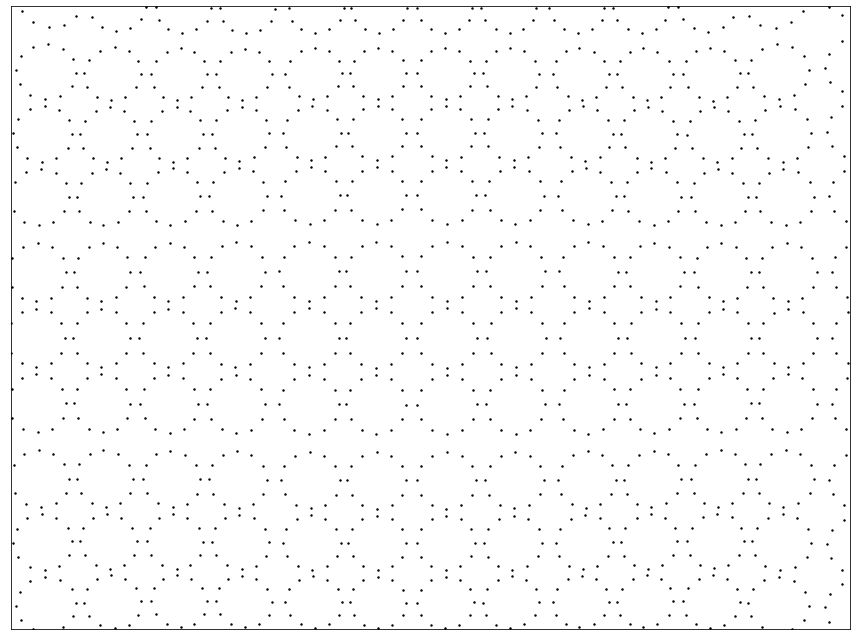

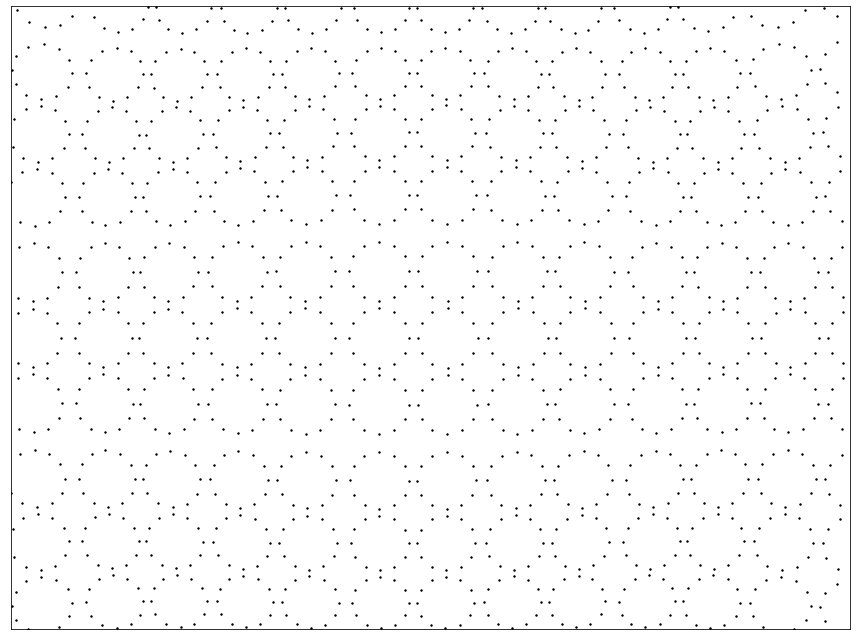

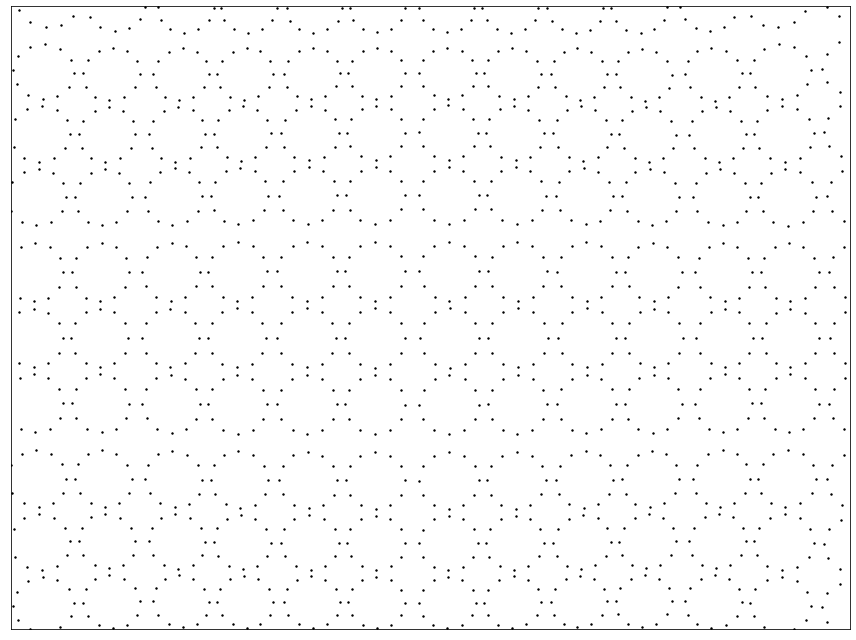

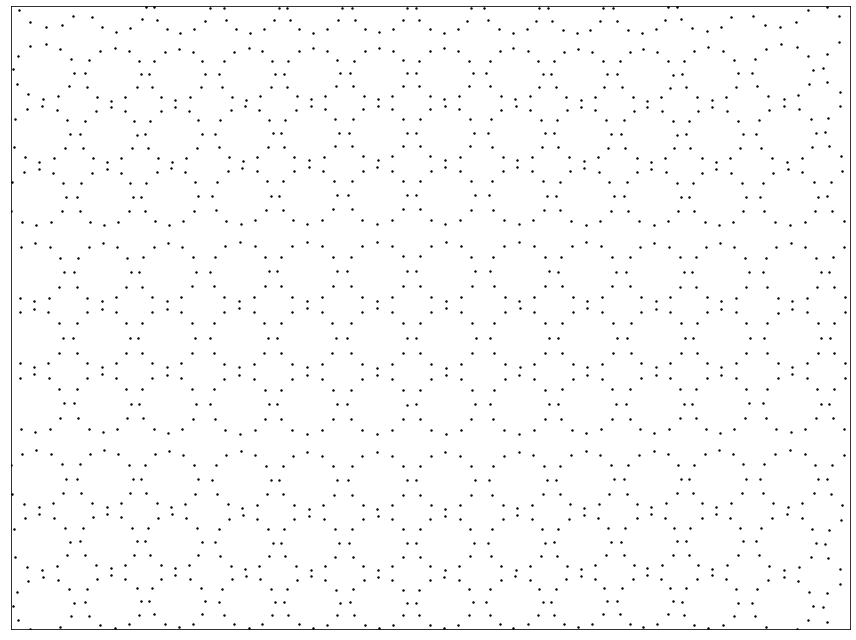

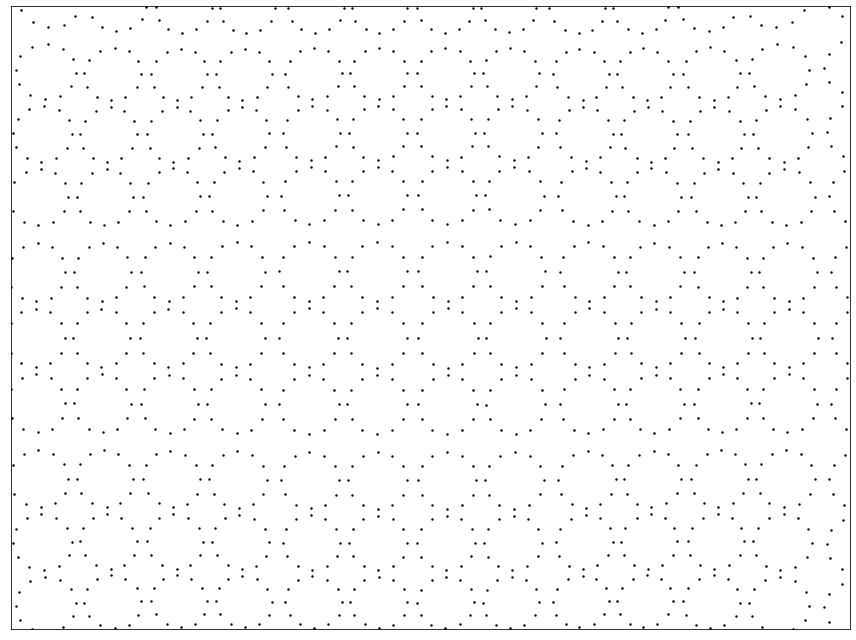

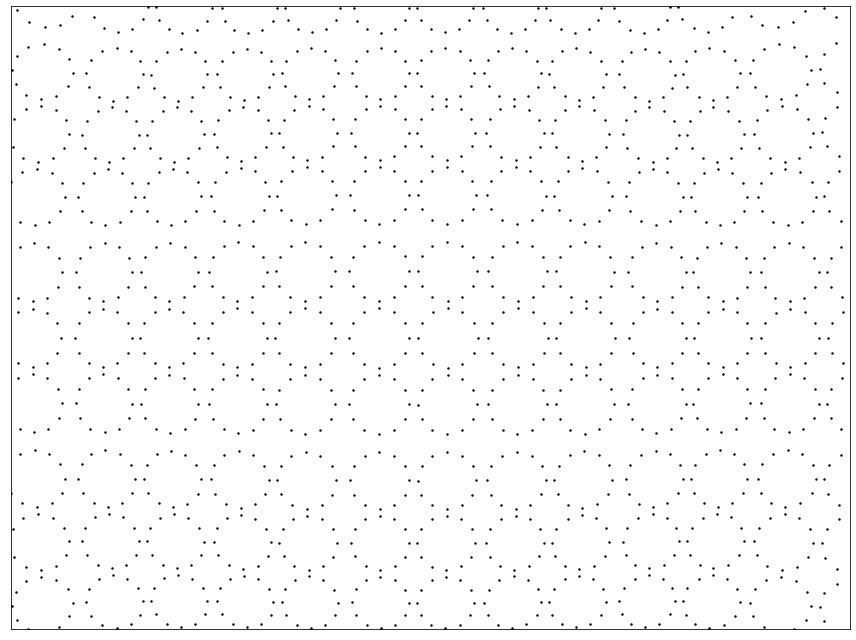

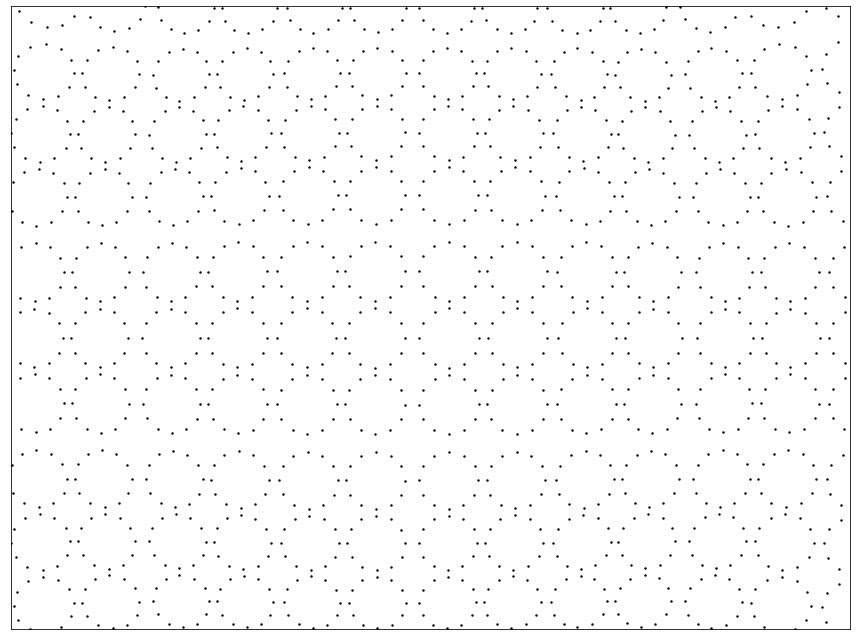

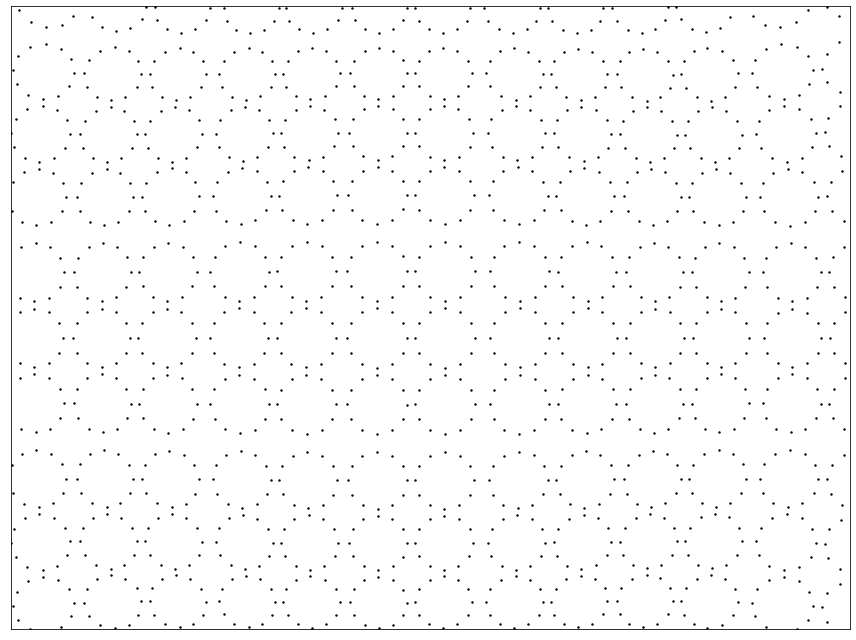

In [30]:
bolt_count = 12
bolt_positions = geo.get_bolt_locations_barrel(pmt_locations, bolt_count)
ring_positions = get_ring_positions(bolt_positions, pmt_locations.keys(), bolt_count)
ring_orientations = get_ring_orientations(bolt_positions, pmt_locations.keys(), bolt_count)
simulator = fit.PhotogrammetrySimulator(bolt_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)
image_feature_locations = simulator.get_image_feature_locations(area_restrict = [[0, 4000], [0, 3000]], min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
print("Feature in image counts:", Counter(feature_counts.values()))
simulator.show_images(image_feature_locations, area=[[0,4000],[0,3000]])

=== Gaussian errors on feature image locations: 0.5 ===
Feature in image counts: Counter({2: 7742, 3: 208})
50 images with total of  7950 features
image 0 reprojection errors:    average: 5.819148867215332    max: 16.03136459145889
image 1 reprojection errors:    average: 5.979265761946297    max: 17.146209072573267
image 2 reprojection errors:    average: 6.189645709435233    max: 16.604883995082673
image 3 reprojection errors:    average: 6.068120473739891    max: 16.79926014518524
image 4 reprojection errors:    average: 6.09046831123446    max: 17.889586623857838
image 5 reprojection errors:    average: 5.830115788362213    max: 20.752452519484212
image 6 reprojection errors:    average: 5.906151495921399    max: 17.09170982898614
image 7 reprojection errors:    average: 6.630441599892495    max: 19.666715598440117
image 8 reprojection errors:    average: 7.4651035815430165    max: 20.198417706654904
image 9 reprojection errors:    average: 6.306541271683321    max: 18.055996804642

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.9582e+05                                    4.48e+06    
       1              2         1.4483e+04      3.81e+05       1.29e+02       2.01e+04    
       2              3         1.1725e+04      2.76e+03       2.78e+01       4.83e+04    
       3              4         1.0524e+04      1.20e+03       8.82e+00       1.18e+03    
       4              5         1.0023e+04      5.01e+02       5.75e+00       8.97e+02    
       5              6         9.6193e+03      4.04e+02       4.84e+00       5.02e+02    
       6              7         9.2601e+03      3.59e+02       4.70e+00       8.59e+02    
       7              8         9.0264e+03      2.34e+02       2.85e+00       6.40e+02    
       8              9         8.9512e+03      7.51e+01       6.08e-01       2.46e+02    
`xtol` termination condition is satisfied.
Function evaluations 9, initial cost 3.9582e+05

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.7303e+05                                    4.97e+06    
       1              2         5.4098e+04      4.19e+05       1.35e+02       1.84e+04    
       2              3         5.2435e+04      1.66e+03       1.15e+01       1.86e+04    
       3              4         5.1721e+04      7.14e+02       1.81e+00       1.12e+03    
       4              5         5.1248e+04      4.73e+02       3.15e+00       3.11e+03    
       5              6         5.0904e+04      3.44e+02       1.28e+00       7.60e+02    
`xtol` termination condition is satisfied.
Function evaluations 6, initial cost 4.7303e+05, final cost 5.0904e+04, first-order optimality 7.60e+02.
mean reprojection error: 2.228814735155087
max reprojection error: 8.130809645507485
mean reconstruction error: 0.9869530287119147
max reconstruction error: 4.373923951781793


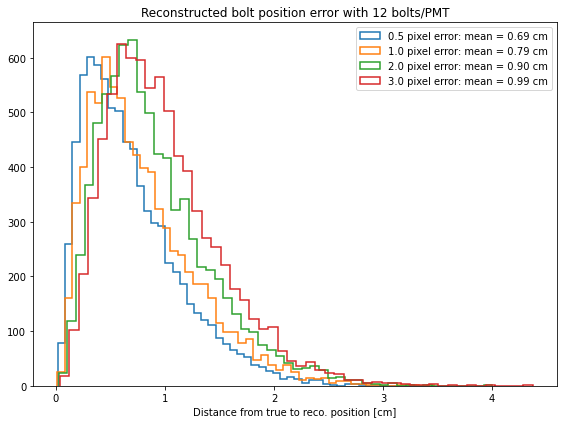

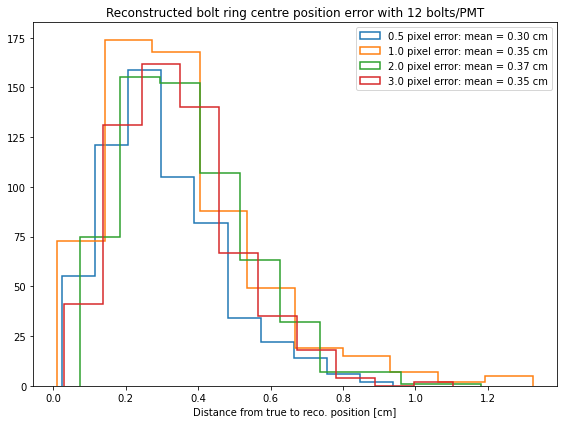

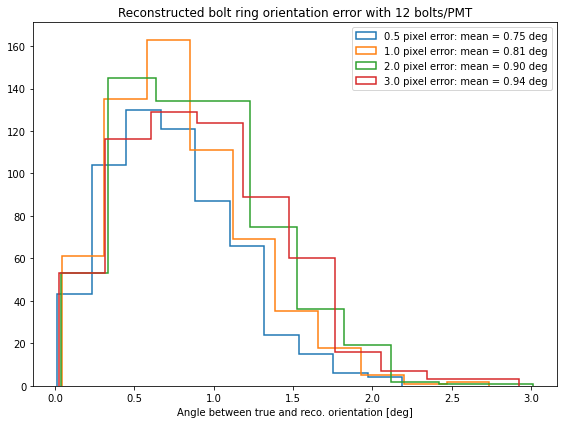

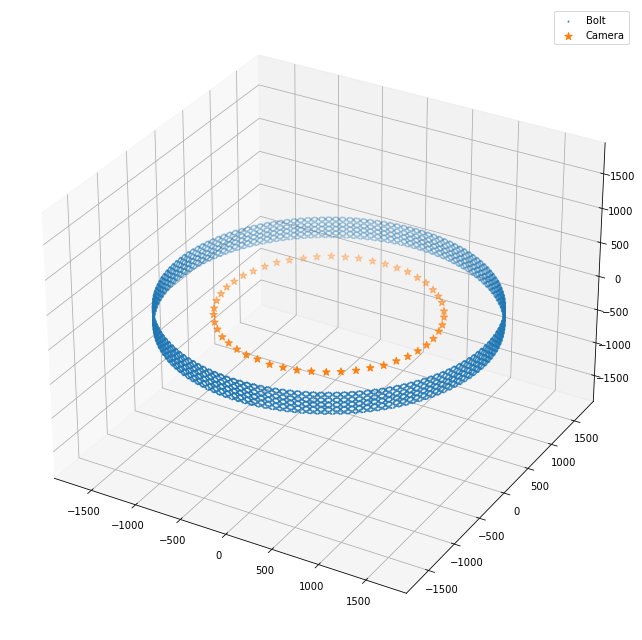

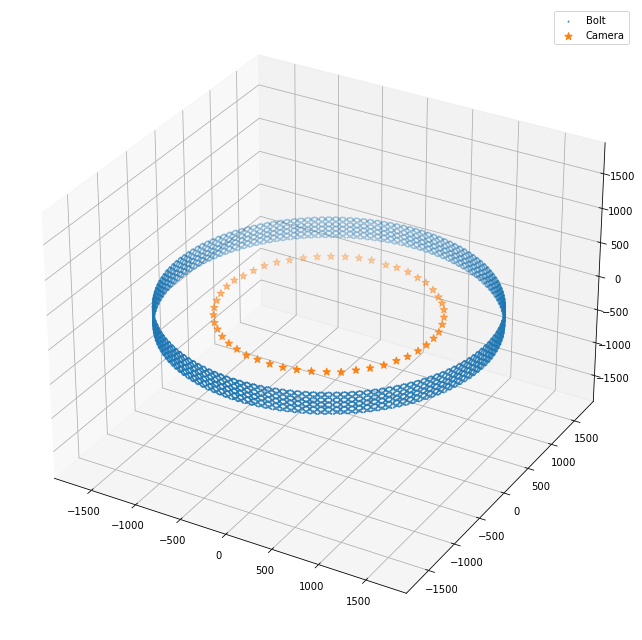

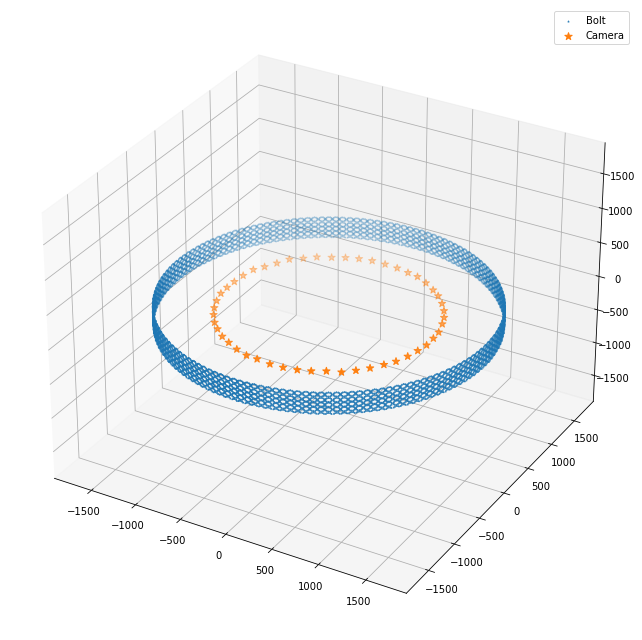

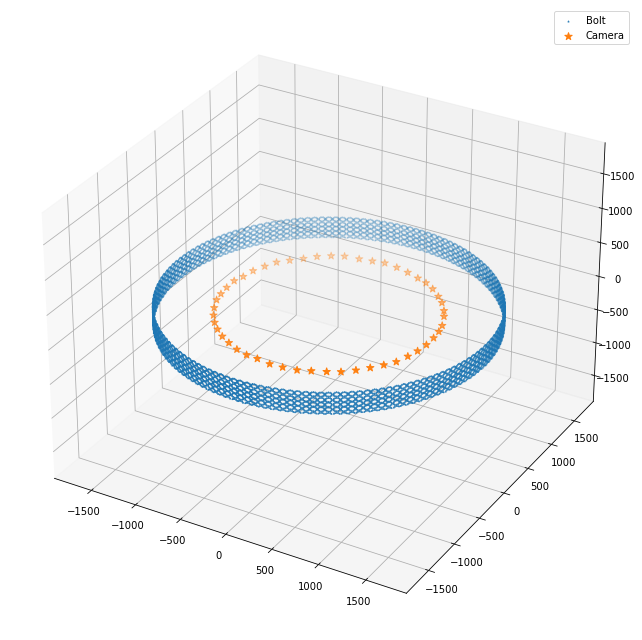

In [31]:
fig_bolt_pos, ax_bolt_pos = make_fig("Reconstructed bolt position error with {} bolts/PMT".format(bolt_count), "Distance from true to reco. position [cm]")
fig_ring_pos, ax_ring_pos = make_fig("Reconstructed bolt ring centre position error with {} bolts/PMT".format(bolt_count), "Distance from true to reco. position [cm]")
fig_ring_ang, ax_ring_ang = make_fig("Reconstructed bolt ring orientation error with {} bolts/PMT".format(bolt_count), "Angle between true and reco. orientation [deg]")
for pixel_error in [0.5, 1.0, 2.0, 3.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=[[1000, 3000], [750, 2250]], min_feature_count=2, pixel_error=pixel_error)
    feature_counts = Counter([f for i in smeared_feature_locations.values() for f in i.keys()])
    print("Feature in image counts:", Counter(feature_counts.values()))
    bolt_positions2 = {k: v for k, v in bolt_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_bolt_simulation(bolt_positions2, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_bolt_positions, position_errors = run_bolt_fit(fitter, bolt_positions2, xtol=1e-5)
    centre_errors = get_ring_centre_errors(reco_bolt_positions, ring_positions, bolt_count)
    orientation_errors = get_ring_orientation_errors(reco_bolt_positions, ring_orientations, bolt_count)
    ax_bolt_pos.hist(position_errors, bins=50, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors.mean()))
    ax_ring_pos.hist(centre_errors, bins=10, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors.mean()))
    ax_ring_ang.hist(orientation_errors, bins=10, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors.mean()))
    reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(bolt_positions, reco_bolt_positions)
    reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
    plot_reconstruction(reco_transformed, reco_cam_positions)
    bolt_position_errors[bolt_count][pixel_error] = position_errors.mean()
    ring_position_errors[bolt_count][pixel_error] = centre_errors.mean()
    ring_orientation_errors[bolt_count][pixel_error] = orientation_errors.mean()
ax_bolt_pos.legend(loc='upper right')
ax_ring_pos.legend(loc='upper right')
ax_ring_ang.legend(loc='upper right')

# Simulation with 24 bolts

Feature in image counts: Counter({4: 30171, 5: 3473, 3: 706})


/home/prouse/work/PhotogrammetryAnalysis/pg_fitter_tools.py:203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


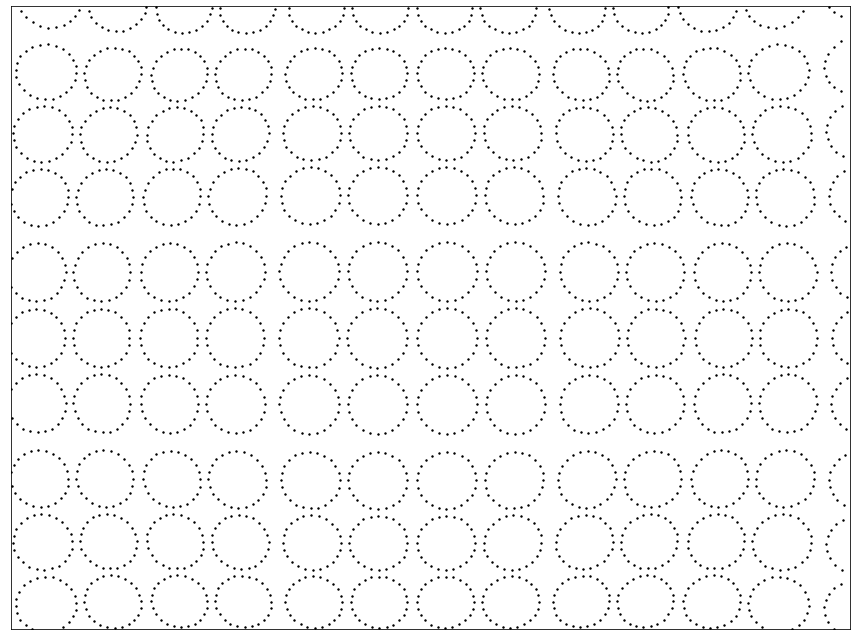

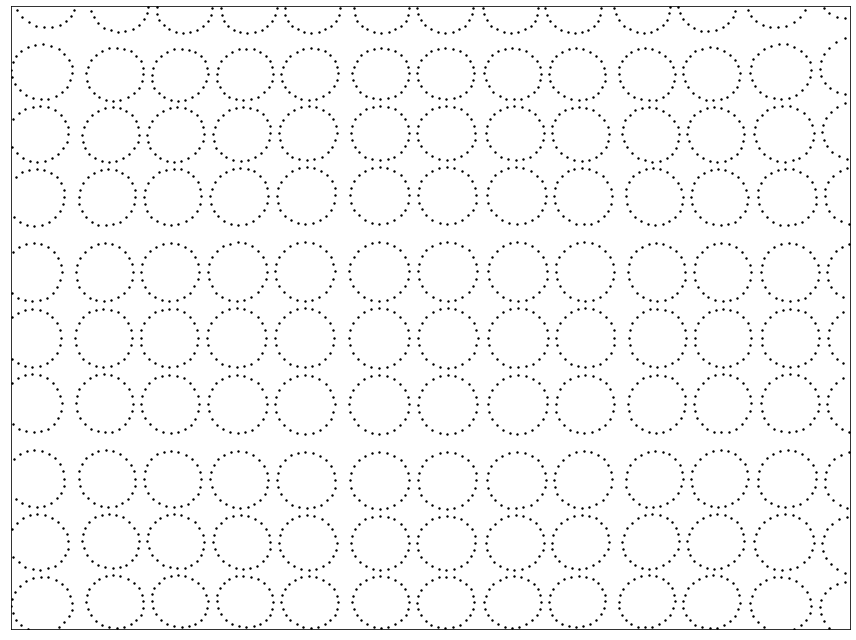

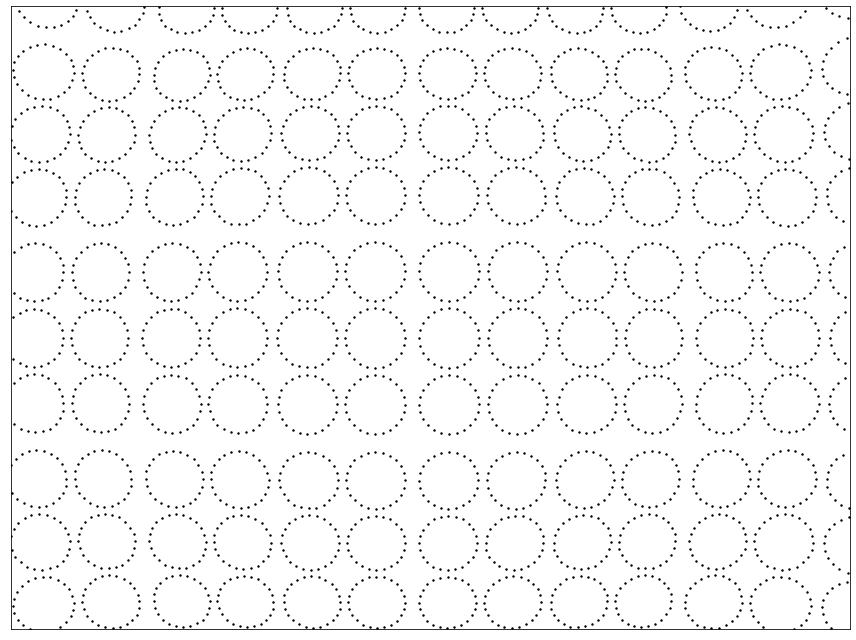

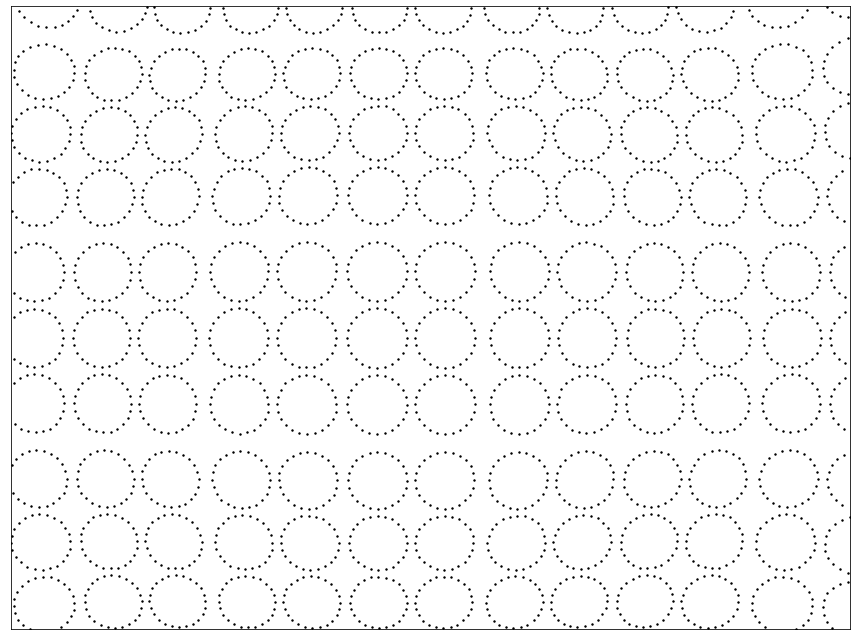

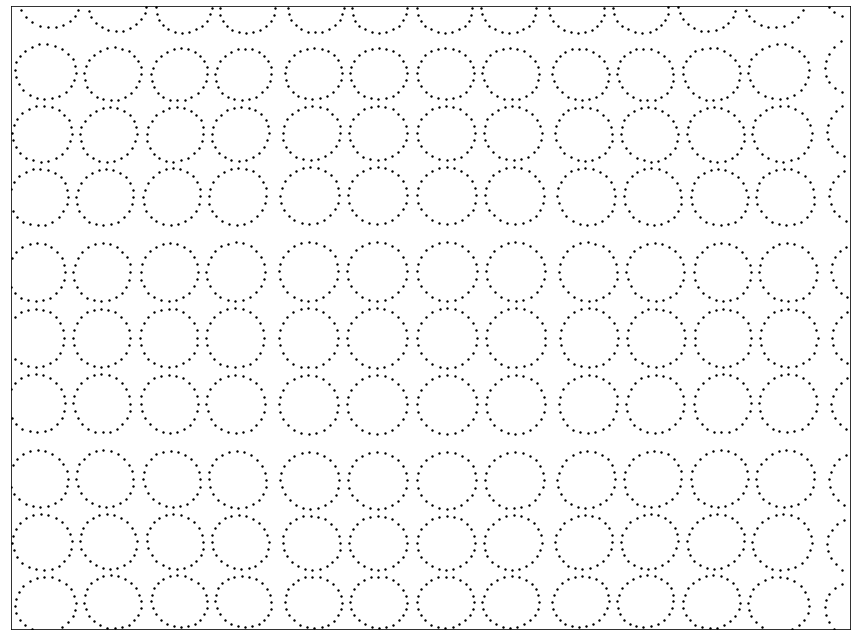

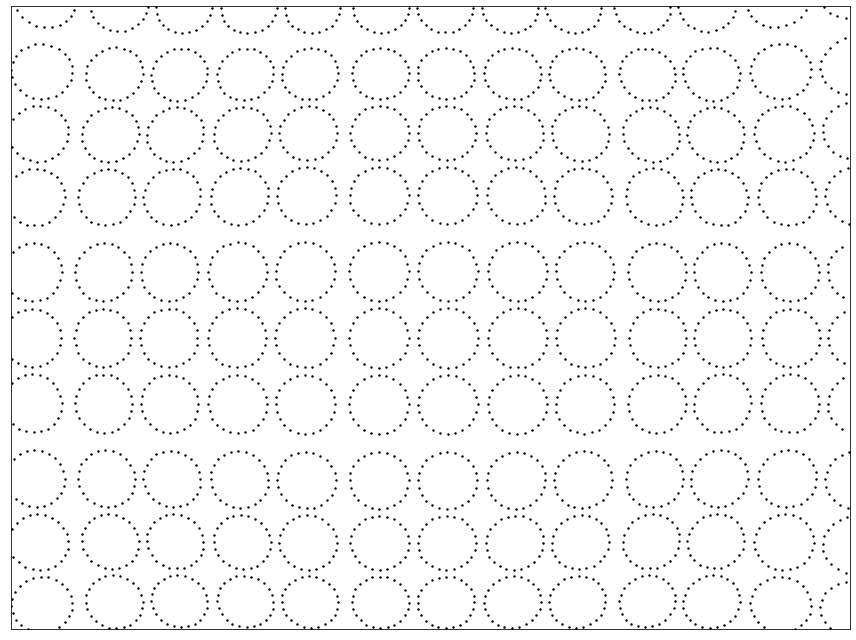

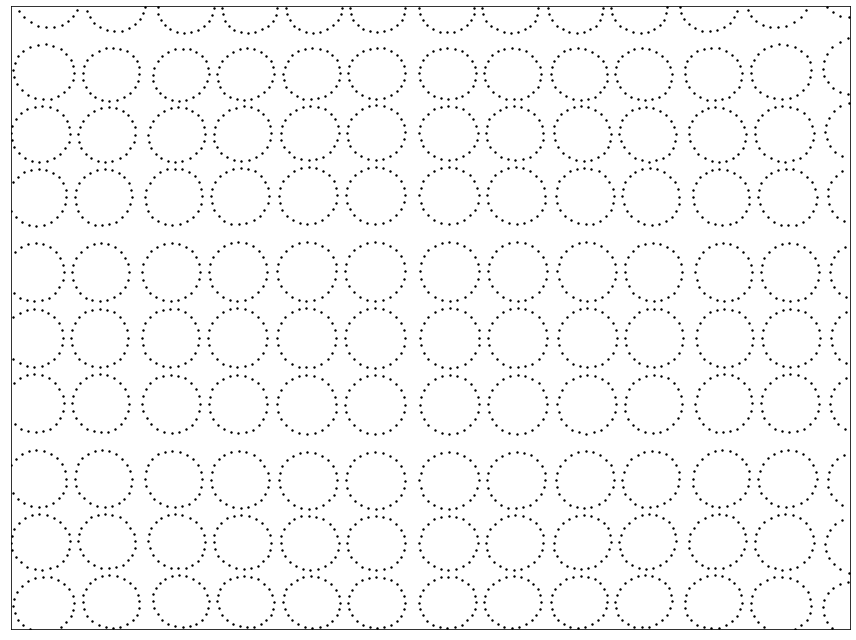

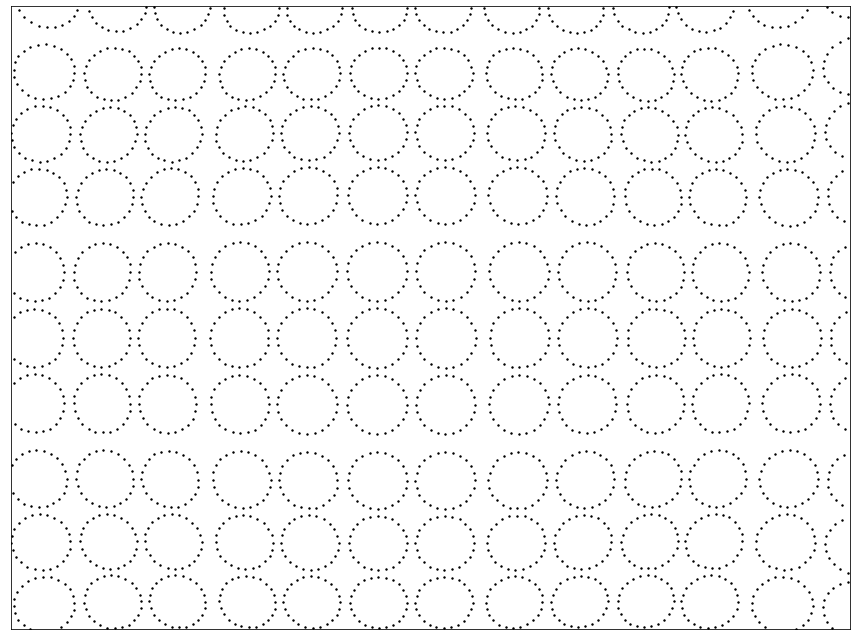

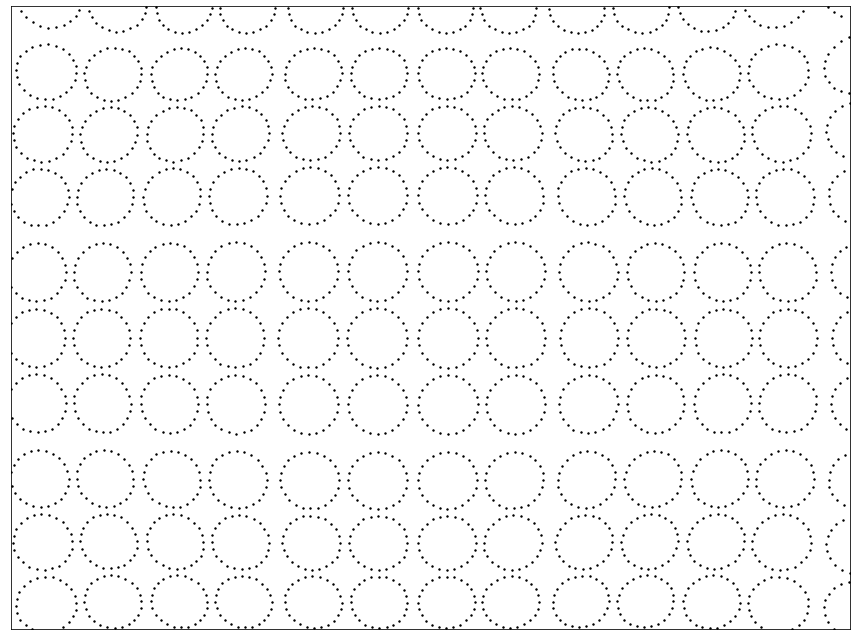

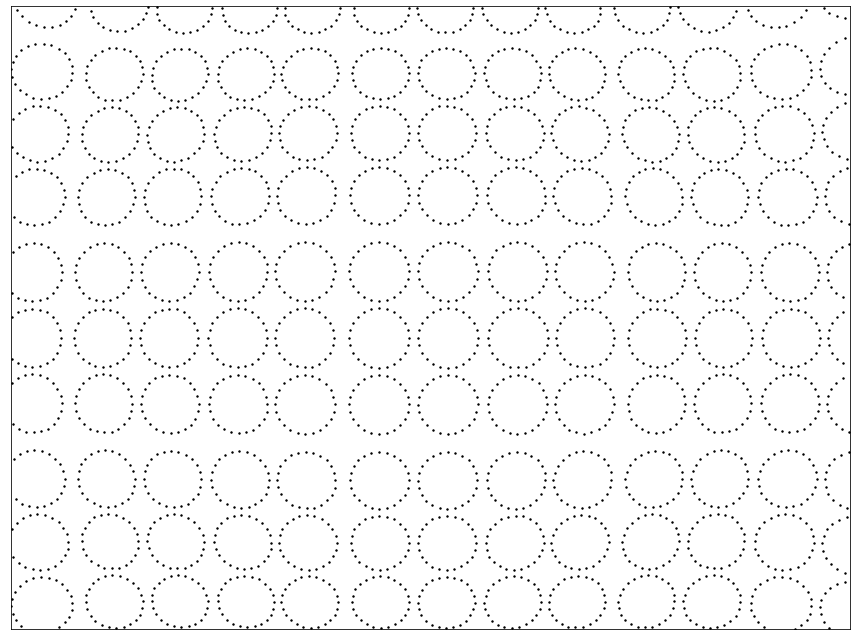

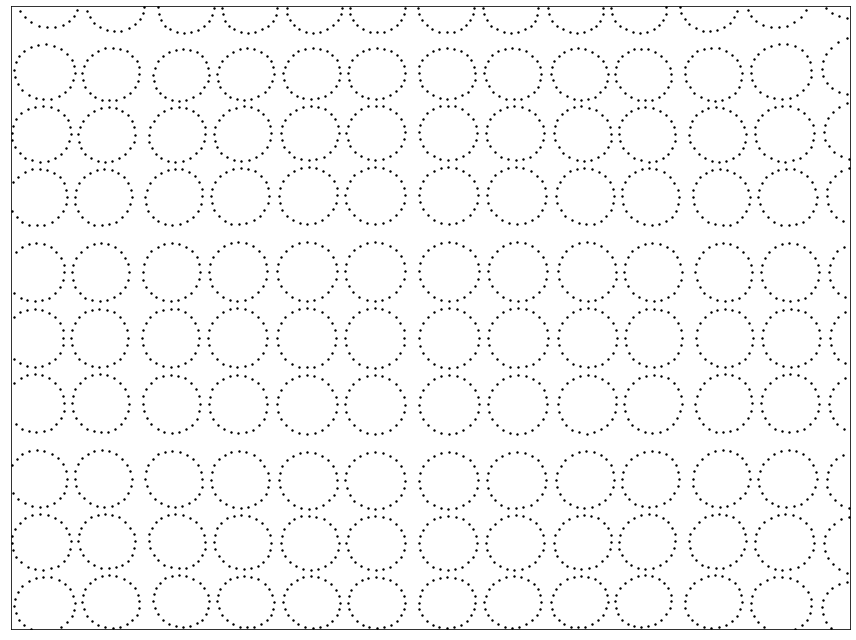

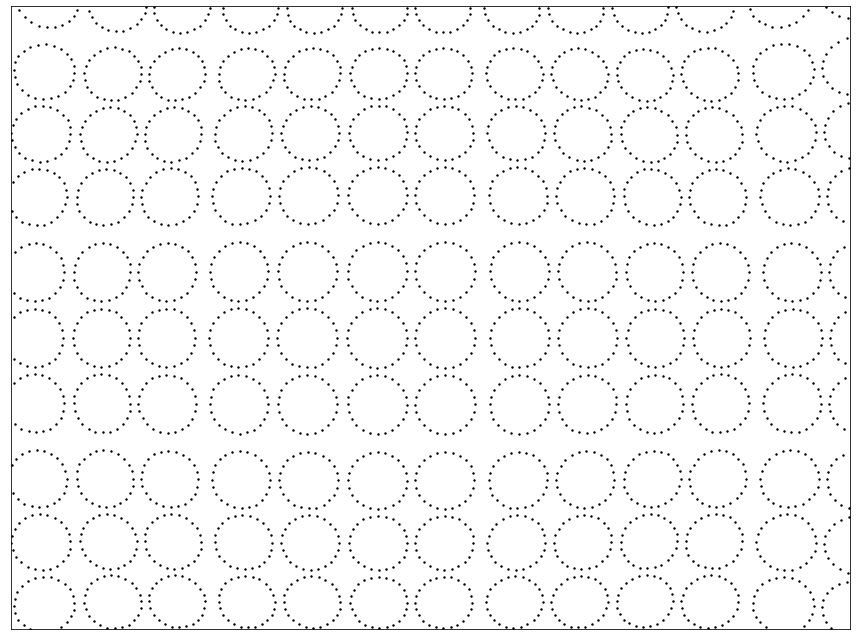

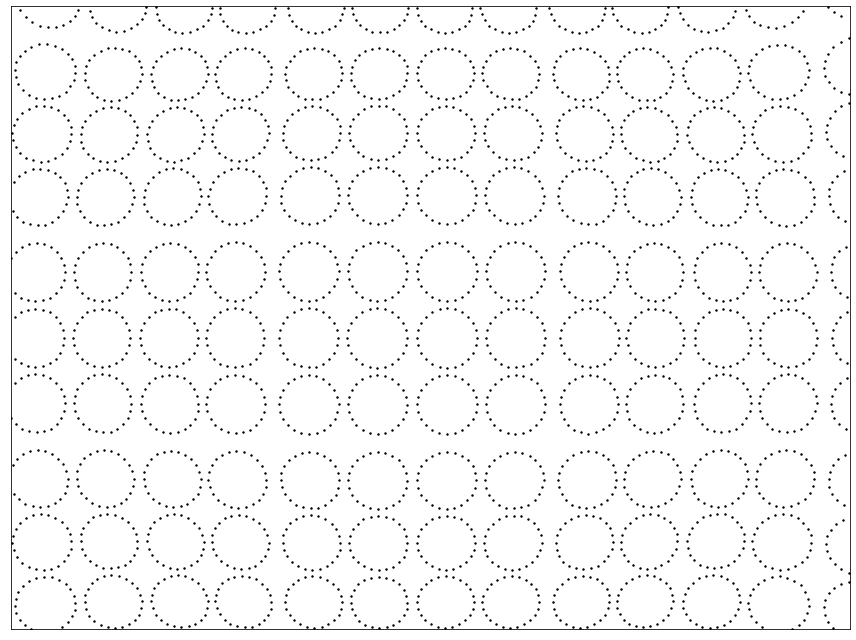

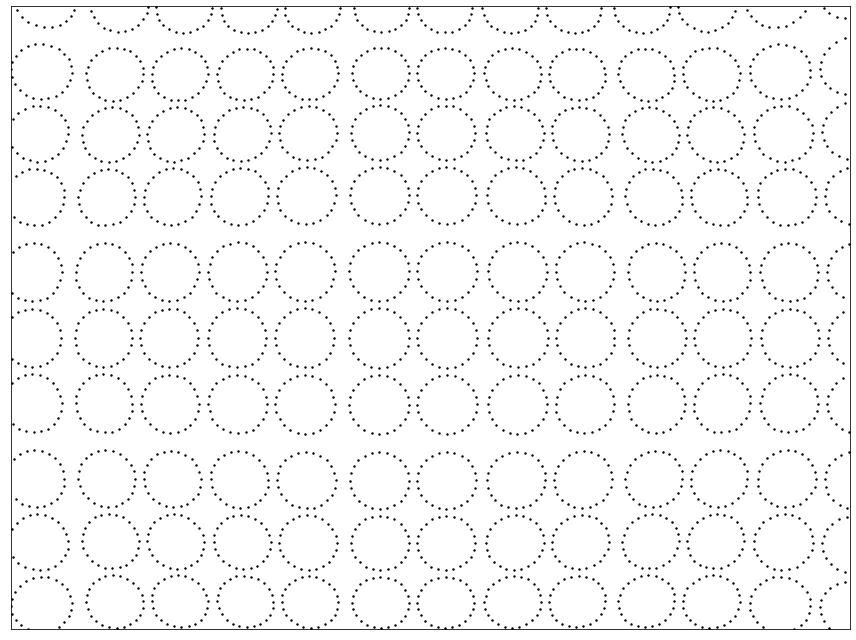

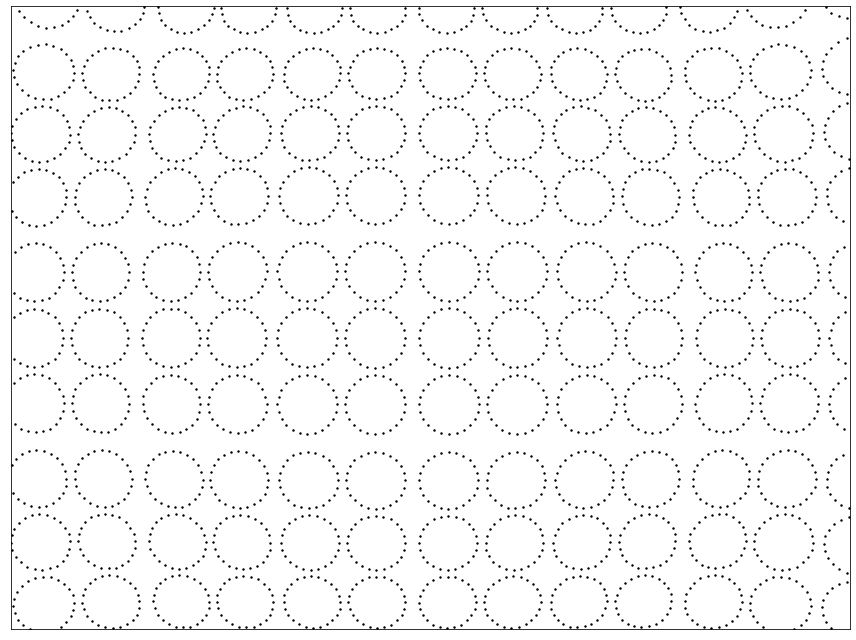

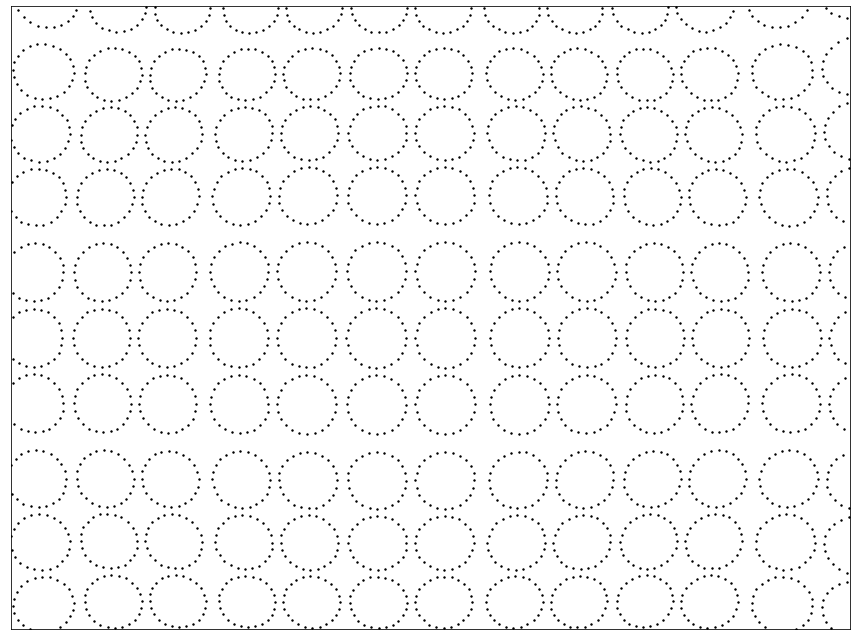

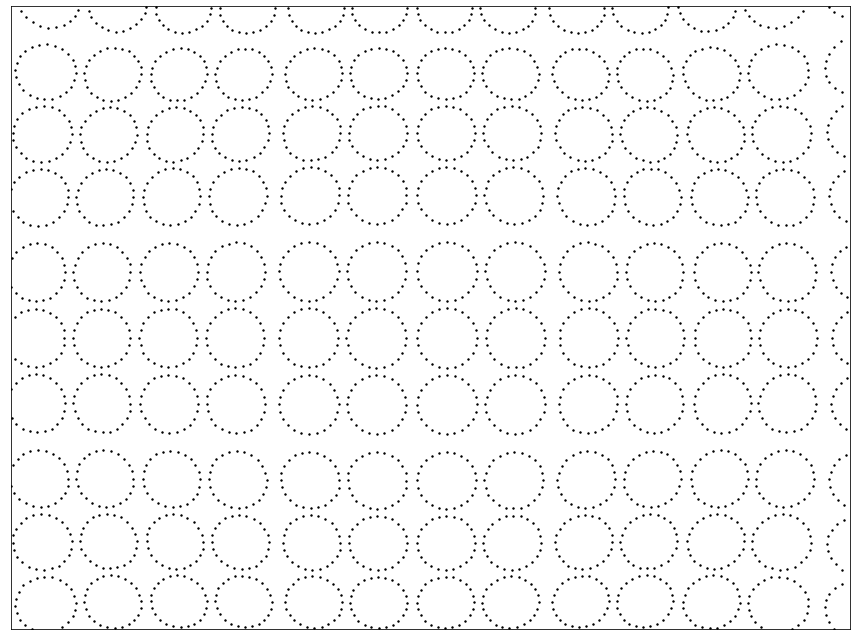

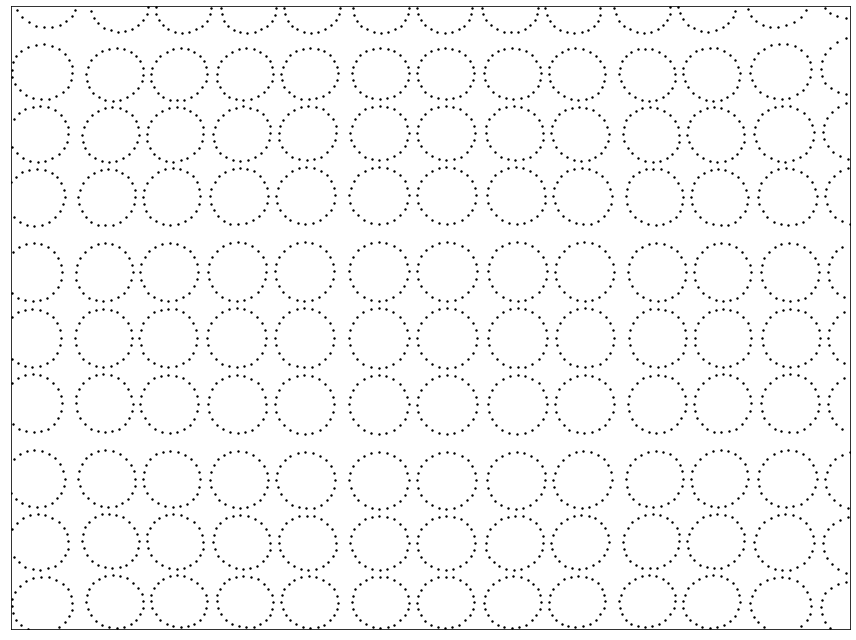

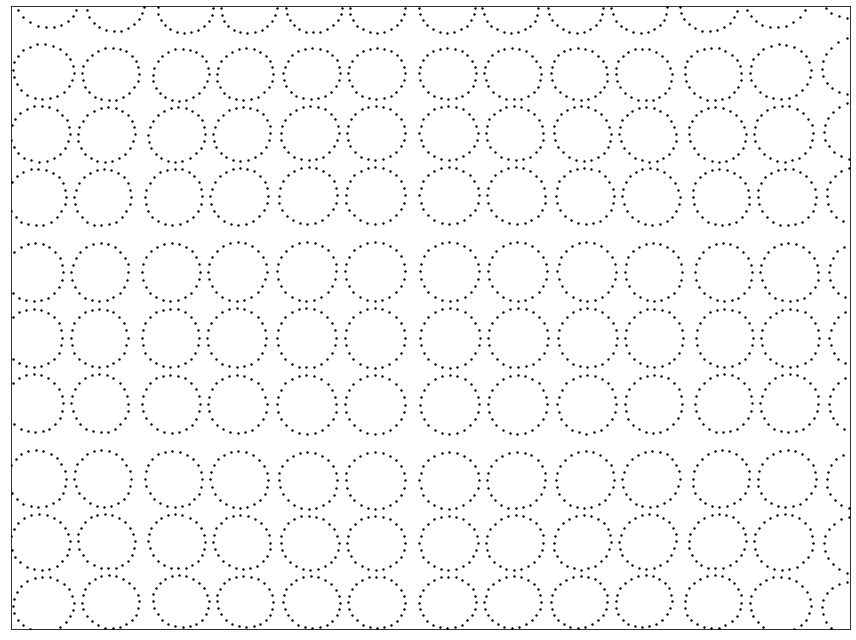

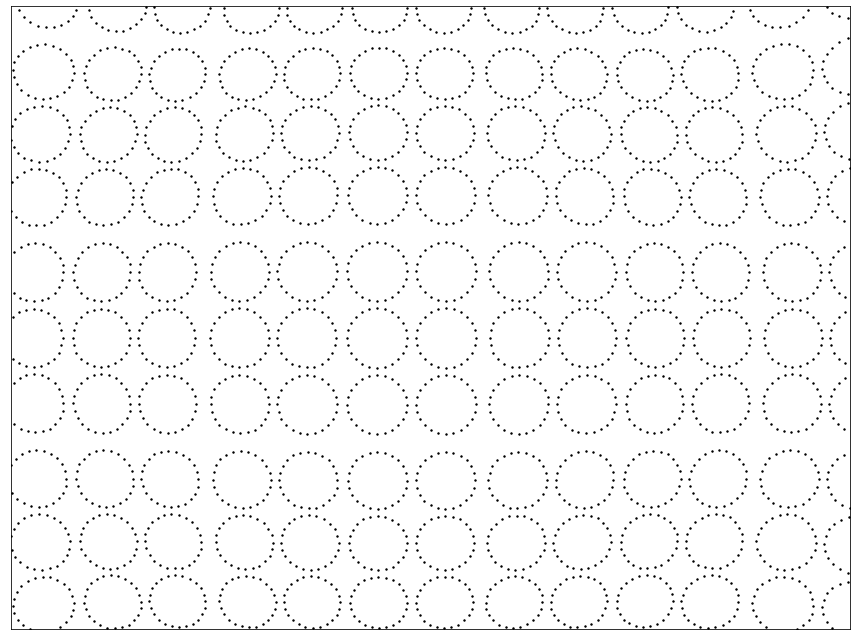

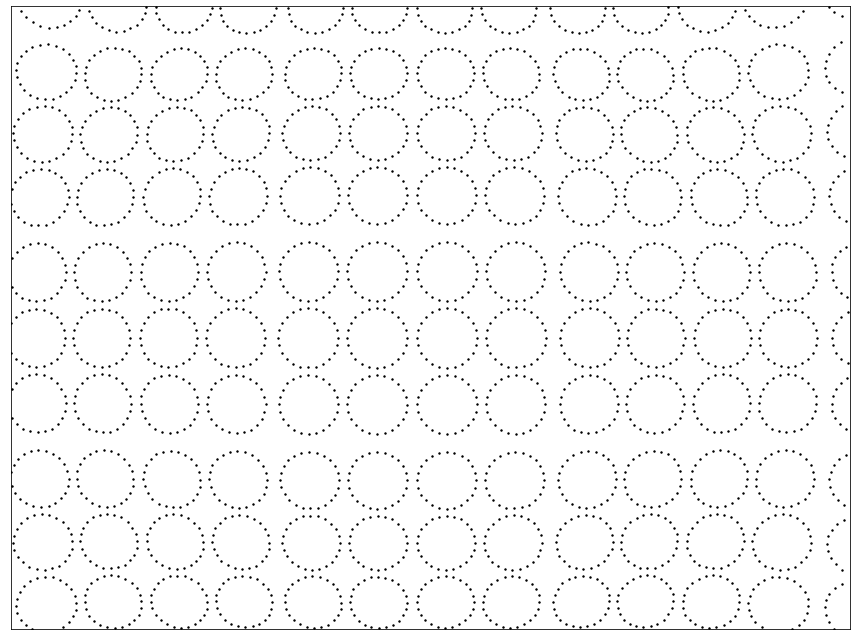

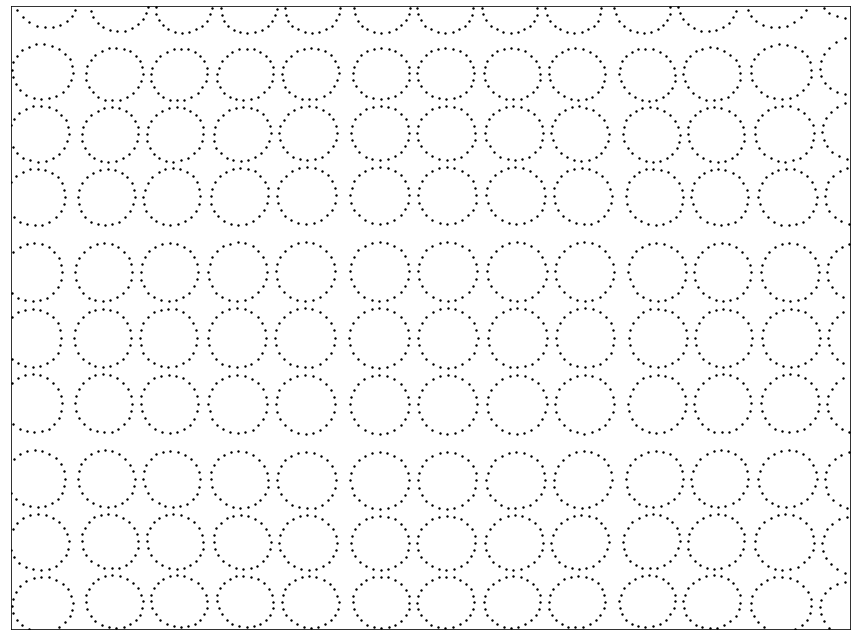

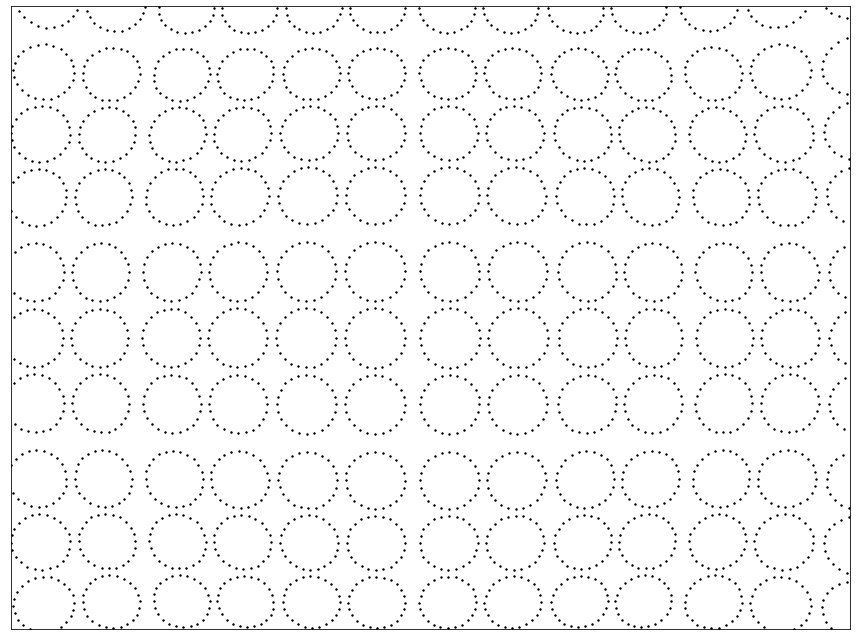

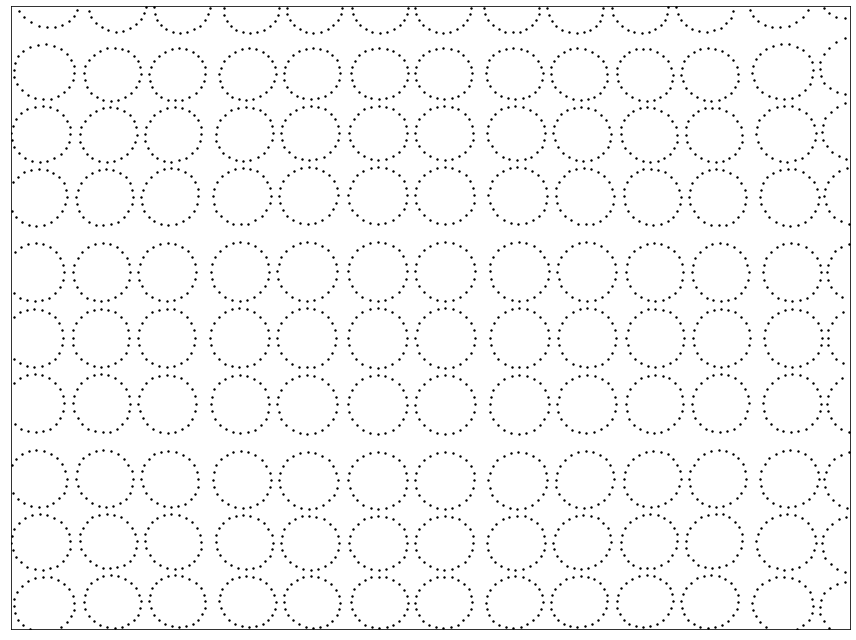

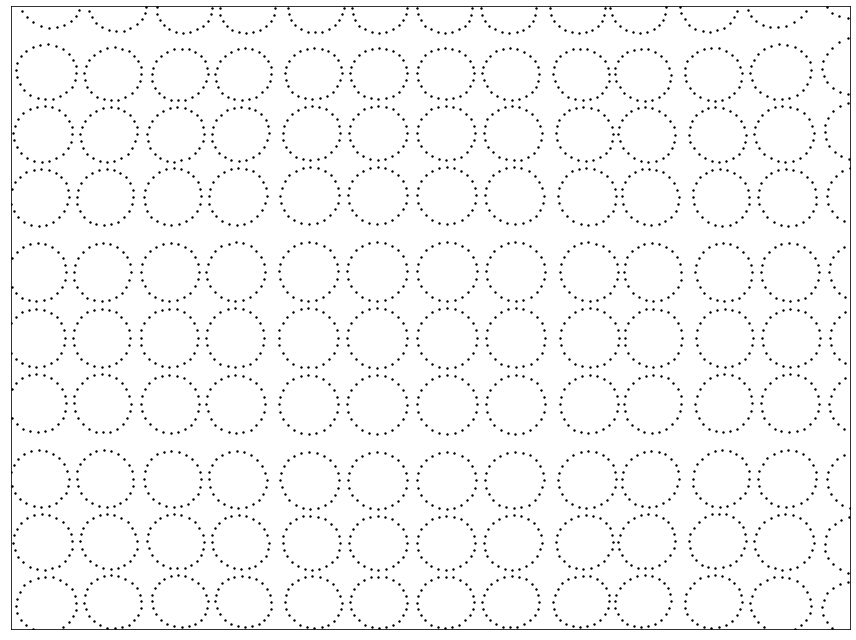

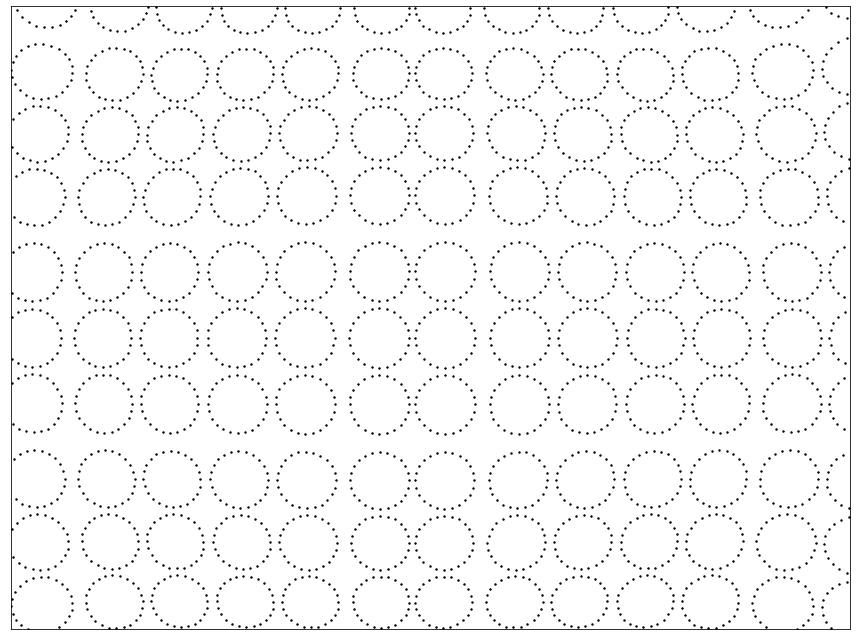

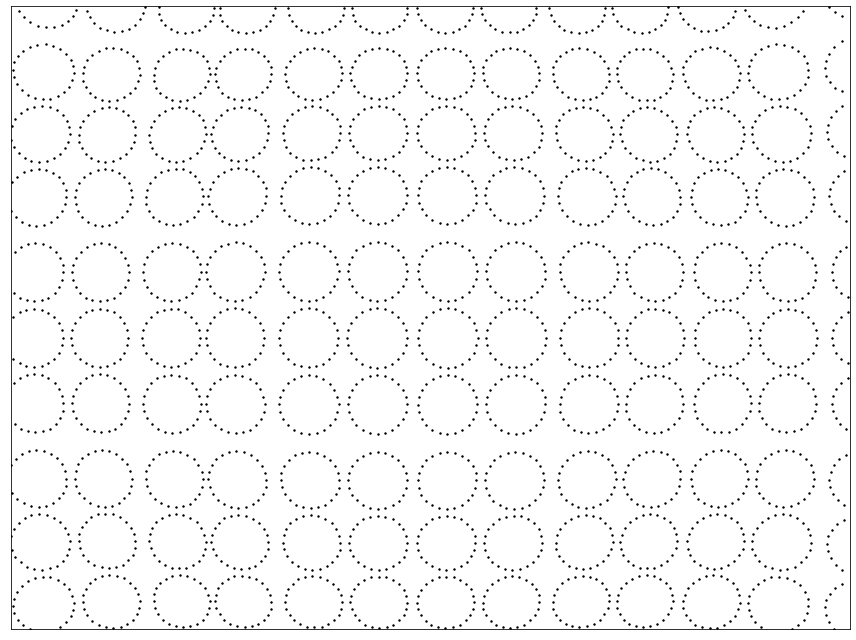

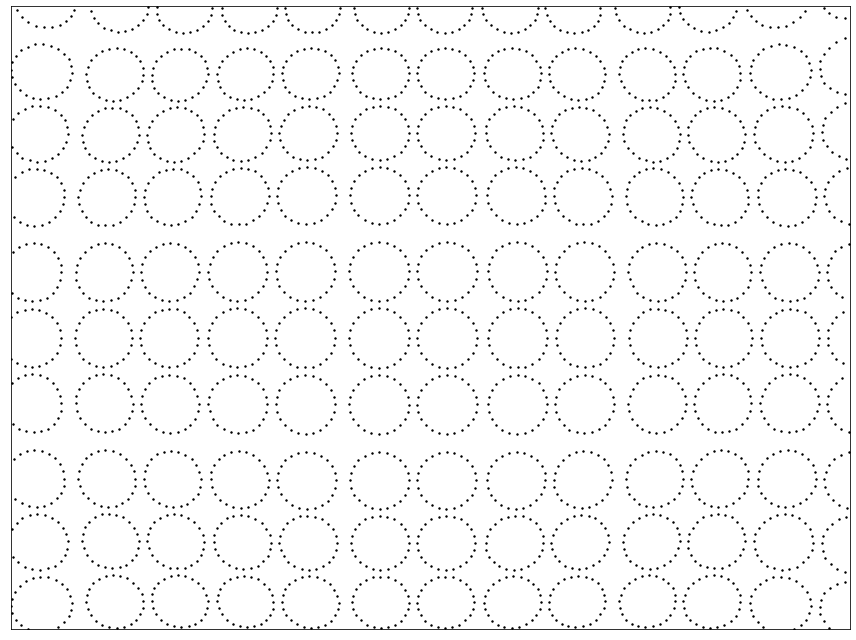

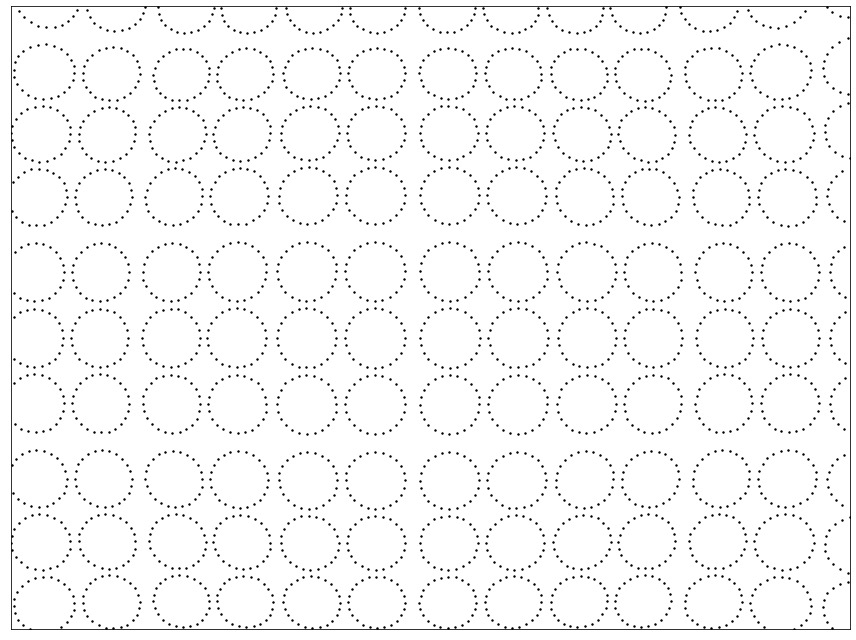

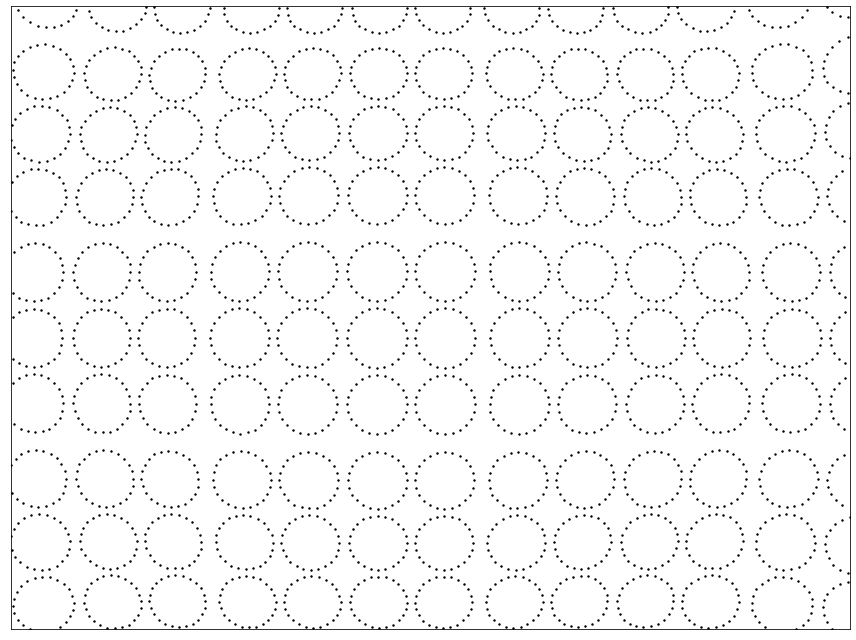

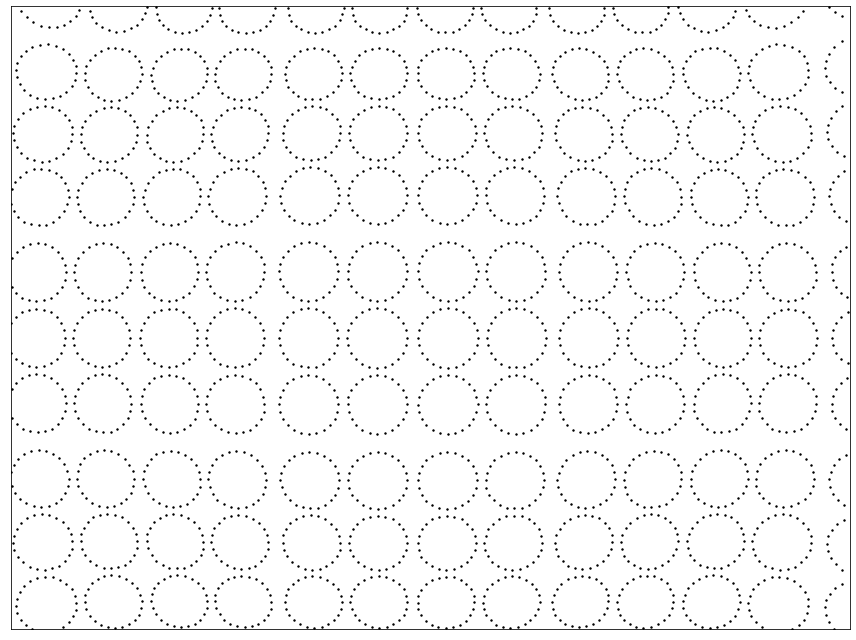

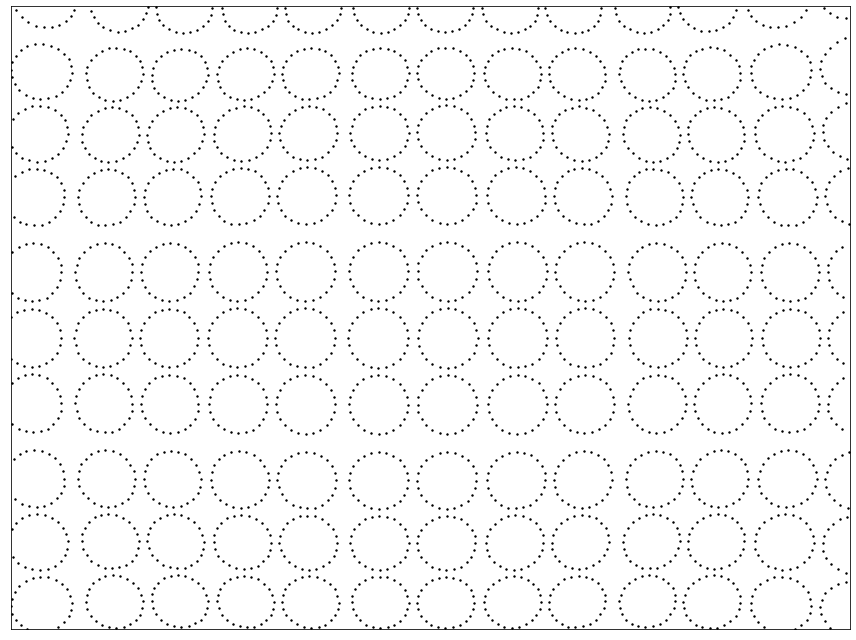

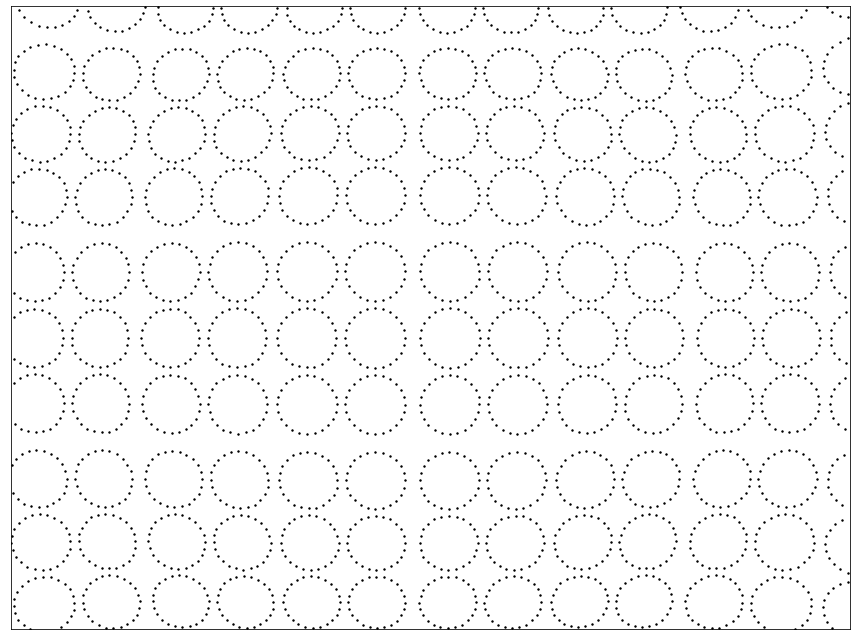

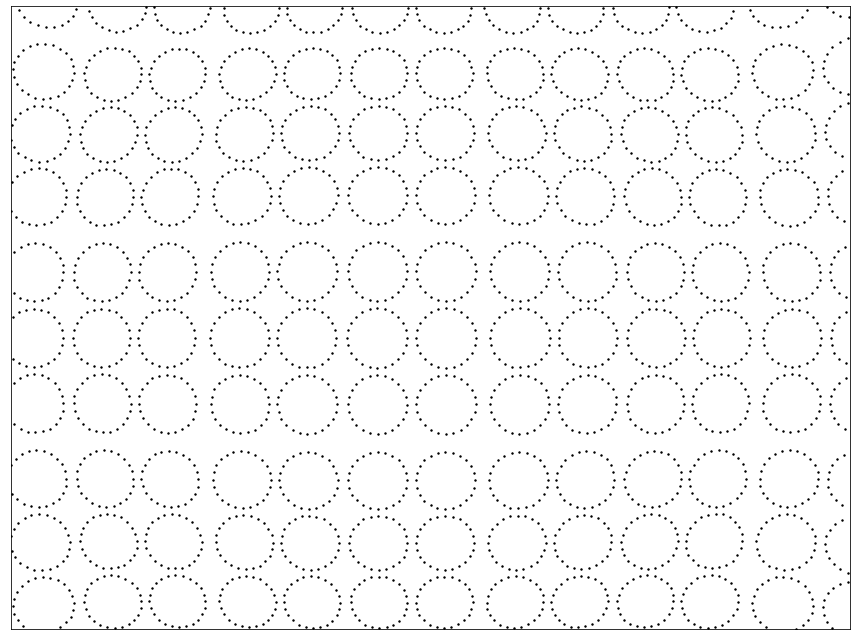

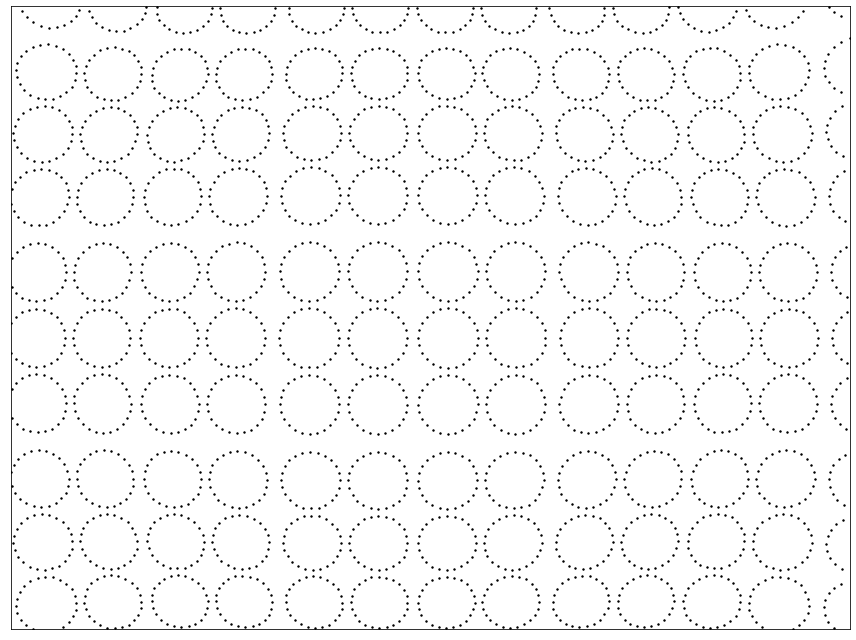

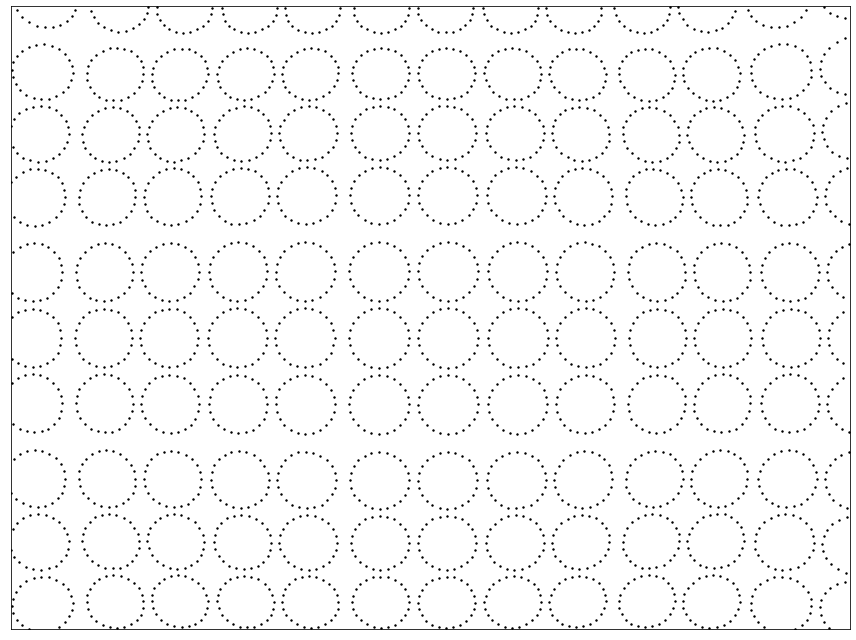

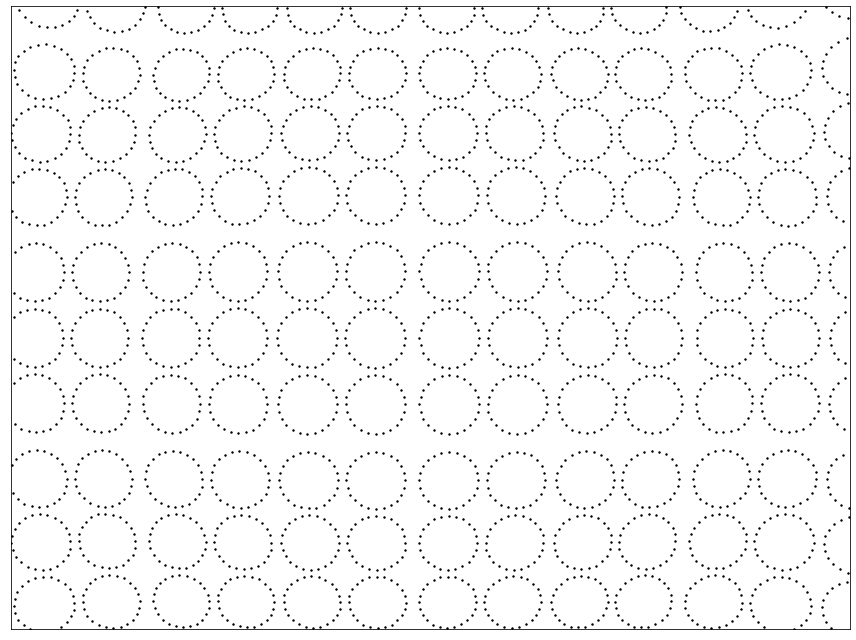

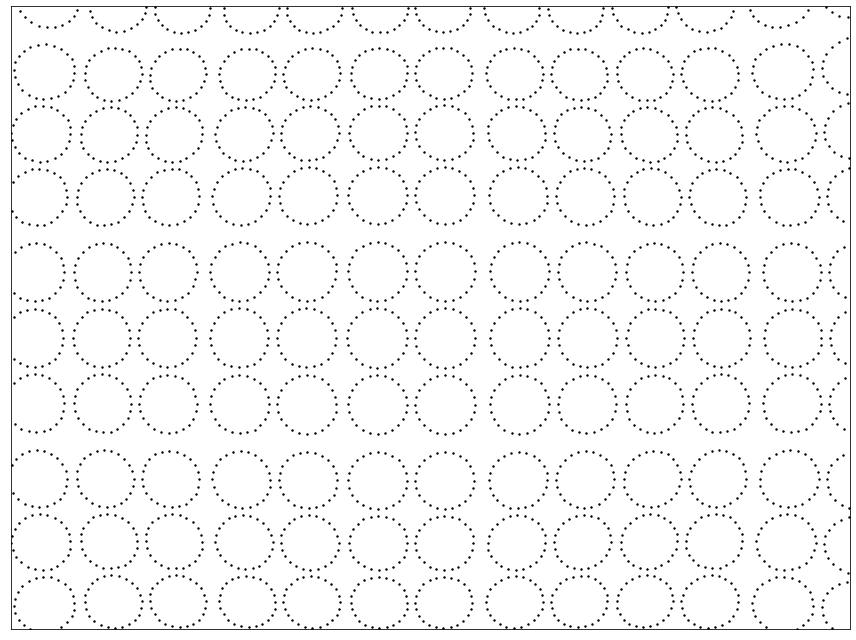

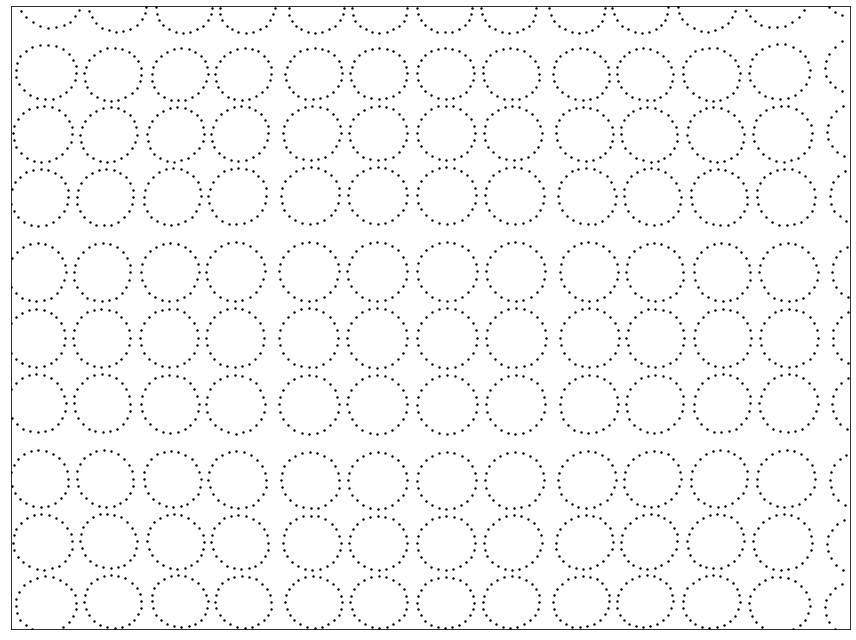

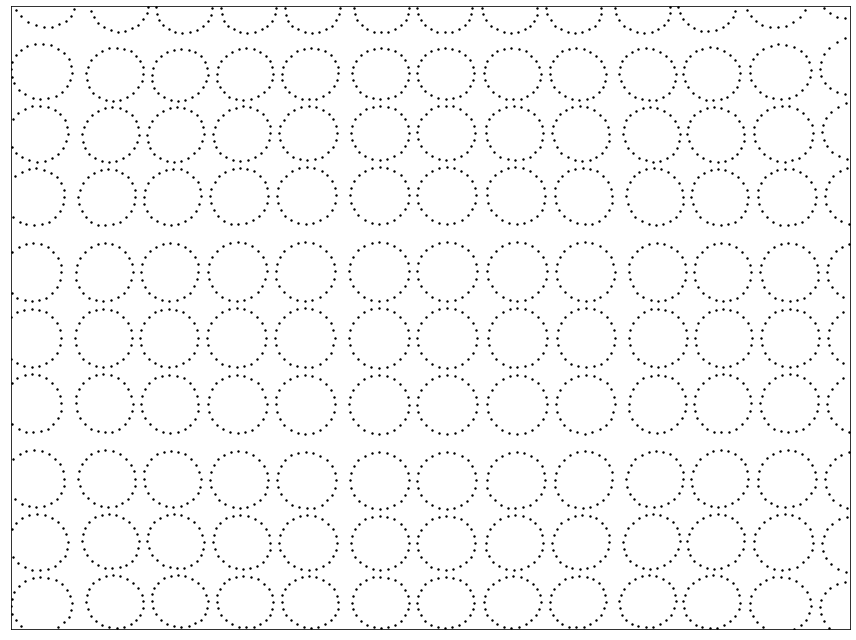

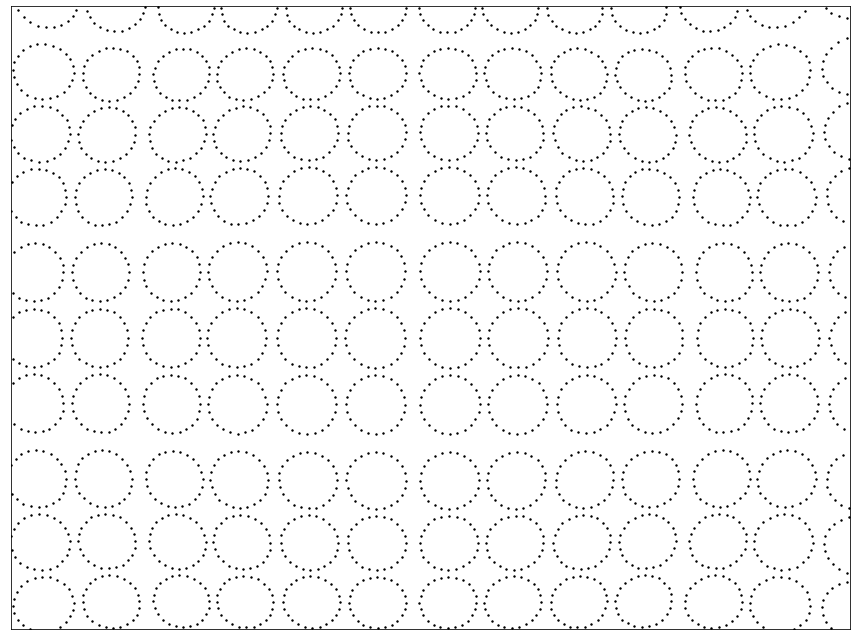

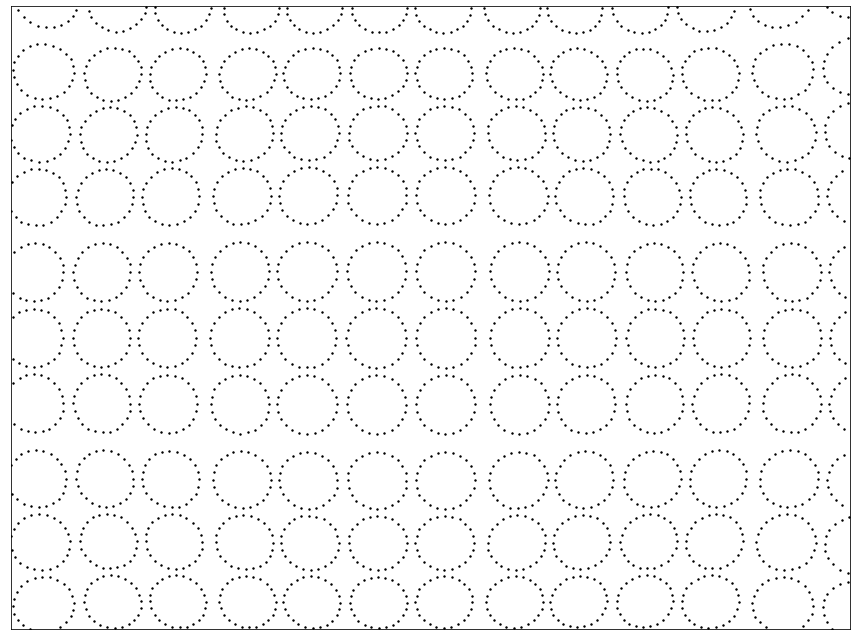

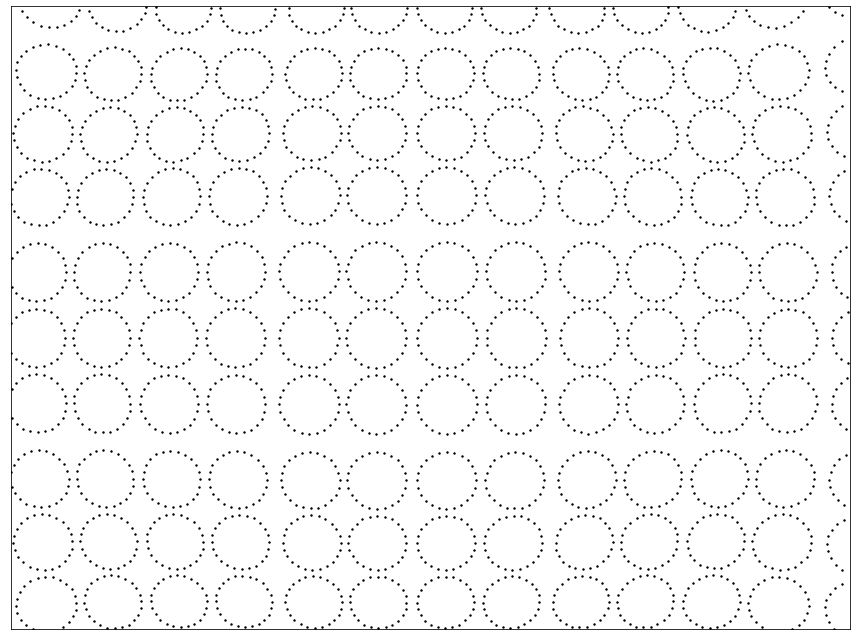

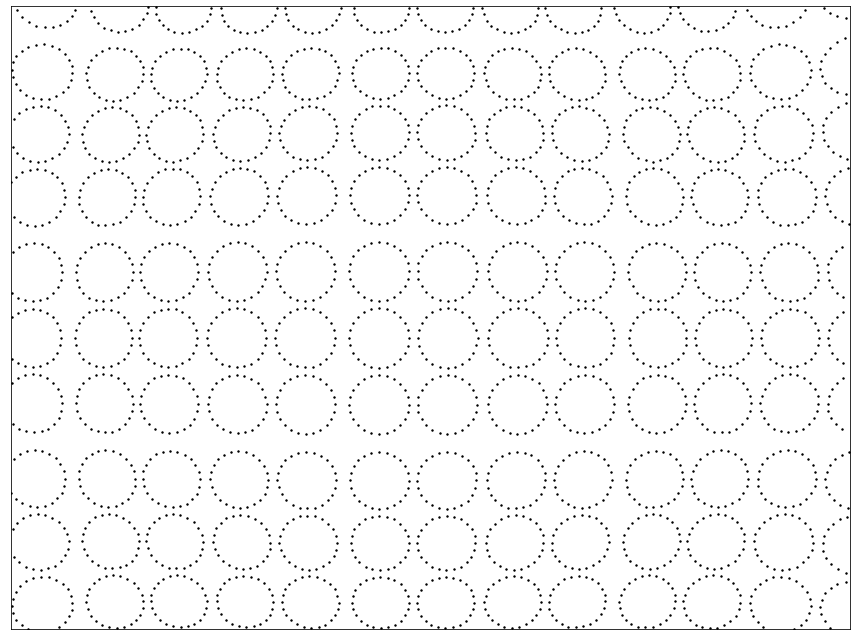

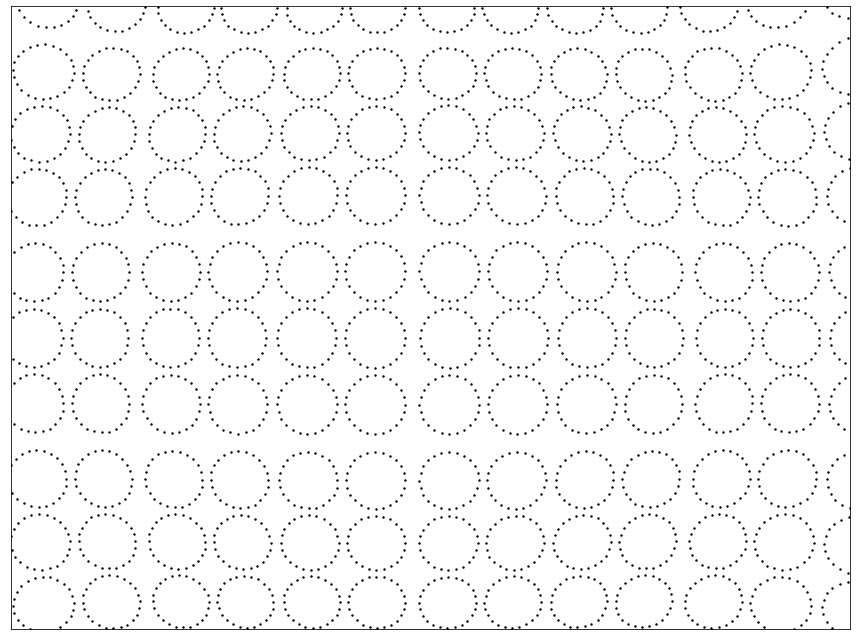

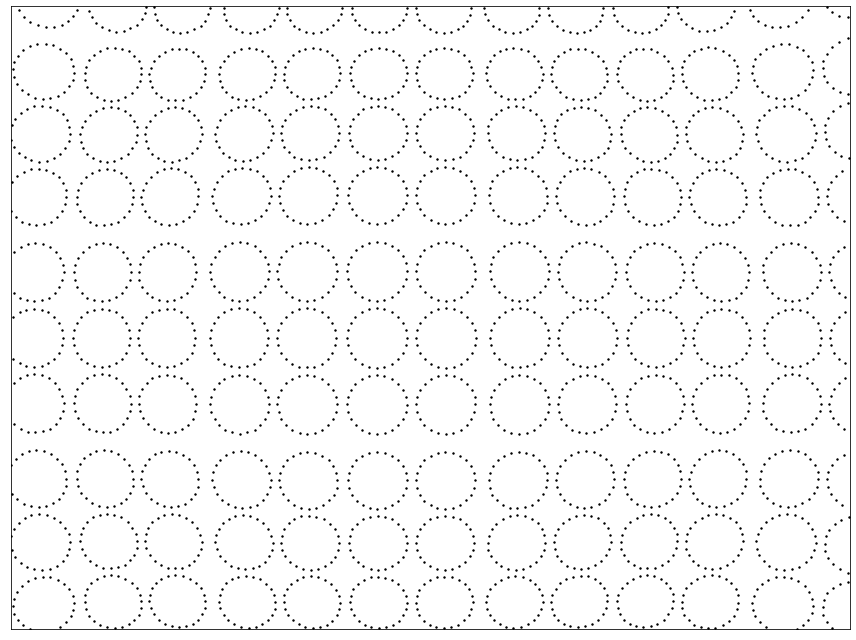

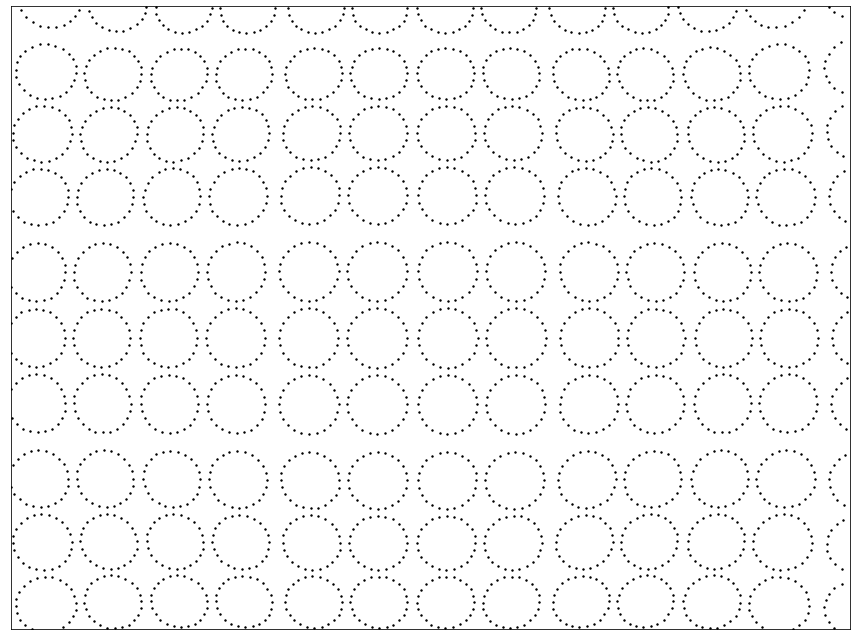

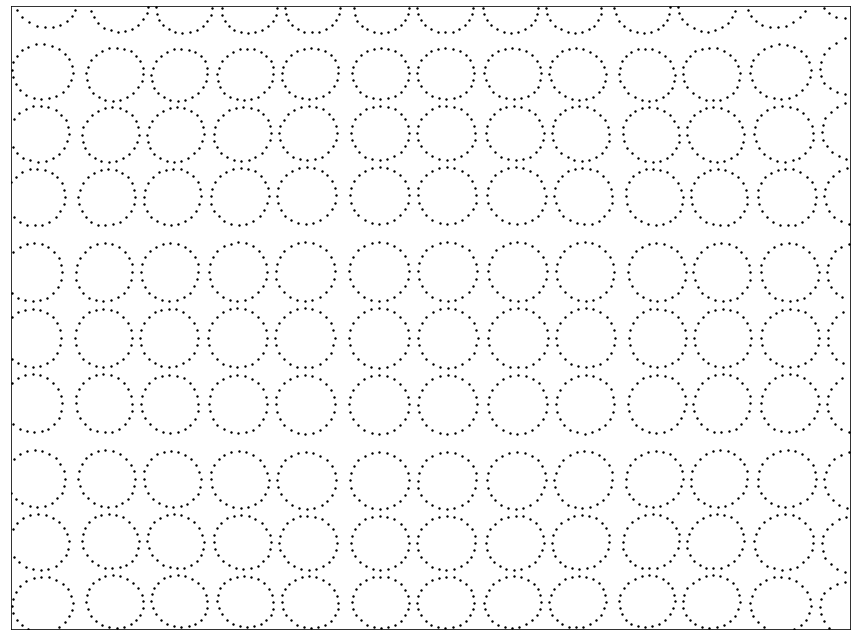

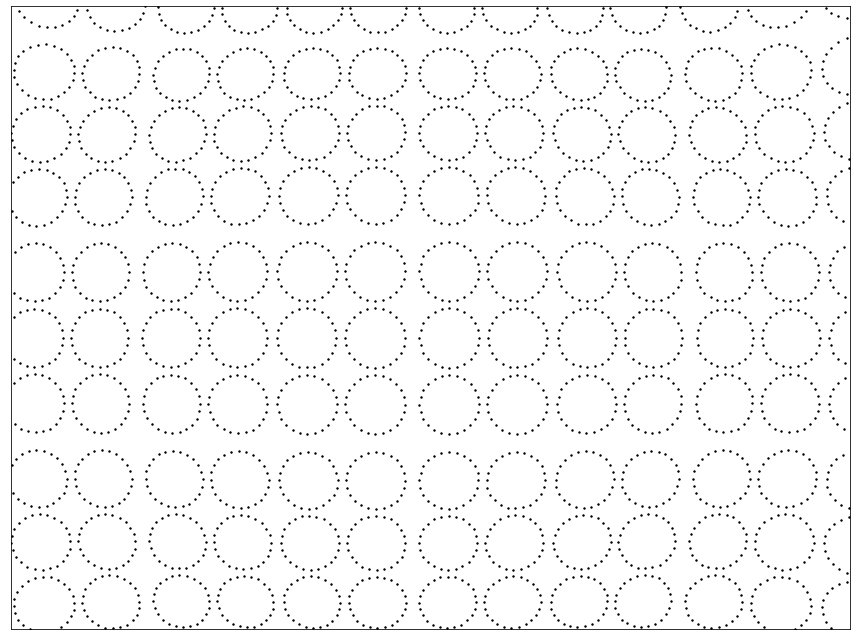

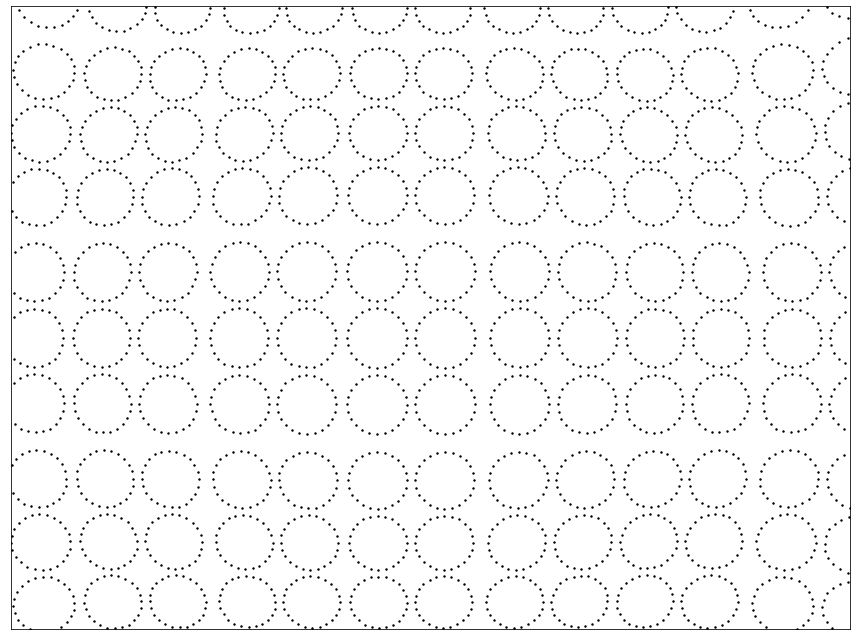

In [20]:
bolt_count = 24
bolt_positions = geo.get_bolt_locations_barrel(pmt_locations, bolt_count)
ring_positions = get_ring_positions(bolt_positions, pmt_locations.keys(), bolt_count)
ring_orientations = get_ring_orientations(bolt_positions, pmt_locations.keys(), bolt_count)
simulator = fit.PhotogrammetrySimulator(bolt_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)
image_feature_locations = simulator.get_image_feature_locations(area_restrict = [[0, 4000], [0, 3000]], min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
print("Feature in image counts:", Counter(feature_counts.values()))
simulator.show_images(image_feature_locations, area=[[0,4000],[0,3000]])

In [ ]:
fig_bolt_pos, ax_bolt_pos = make_fig("Reconstructed bolt position error with {} bolts/PMT".format(bolt_count), "Distance from true to reco. position [cm]")
fig_ring_pos, ax_ring_pos = make_fig("Reconstructed bolt ring centre position error with {} bolts/PMT".format(bolt_count), "Distance from true to reco. position [cm]")
fig_ring_ang, ax_ring_ang = make_fig("Reconstructed bolt ring orientation error with {} bolts/PMT".format(bolt_count), "Angle between true and reco. orientation [deg]")
for pixel_error in [0.5, 1.0, 2.0, 3.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=[[1000, 3000], [750, 2250]], min_feature_count=2, pixel_error=pixel_error)
    feature_counts = Counter([f for i in smeared_feature_locations.values() for f in i.keys()])
    print("Feature in image counts:", Counter(feature_counts.values()))
    bolt_positions2 = {k: v for k, v in bolt_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_bolt_simulation(bolt_positions2, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_bolt_positions, position_errors = run_bolt_fit(fitter, bolt_positions2, xtol=1e-5)
    centre_errors = get_ring_centre_errors(reco_bolt_positions, ring_positions, bolt_count)
    orientation_errors = get_ring_orientation_errors(reco_bolt_positions, ring_orientations, bolt_count)
    ax_bolt_pos.hist(position_errors, bins=50, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors.mean()))
    ax_ring_pos.hist(centre_errors, bins=10, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors.mean()))
    ax_ring_ang.hist(orientation_errors, bins=10, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors.mean()))
    reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(bolt_positions, reco_bolt_positions)
    reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
    plot_reconstruction(reco_transformed, reco_cam_positions)
    bolt_position_errors[bolt_count][pixel_error] = position_errors.mean()
    ring_position_errors[bolt_count][pixel_error] = centre_errors.mean()
    ring_orientation_errors[bolt_count][pixel_error] = orientation_errors.mean()
ax_bolt_pos.legend(loc='upper right')
ax_ring_pos.legend(loc='upper right')
ax_ring_ang.legend(loc='upper right')

=== Gaussian errors on feature image locations: 0.5 ===
Feature in image counts: Counter({2: 15819, 3: 231})
50 images with total of  16050 features
image 0 reprojection errors:    average: 6.090762051318297    max: 17.711446799948966
image 1 reprojection errors:    average: 6.170598073900013    max: 18.798921238577623
image 2 reprojection errors:    average: 6.624358488241605    max: 18.92395275409928
image 3 reprojection errors:    average: 5.869183204490852    max: 16.01946429794279
image 4 reprojection errors:    average: 6.151823623841417    max: 18.8395976189368
image 5 reprojection errors:    average: 5.913783305734833    max: 22.32655227459095
image 6 reprojection errors:    average: 5.868246833643231    max: 22.08332503067366
image 7 reprojection errors:    average: 5.941989285758325    max: 16.82324527573269
image 8 reprojection errors:    average: 5.922232471114012    max: 19.719669177397172
image 9 reprojection errors:    average: 5.903159584824942    max: 20.64967899934158

In [ ]:
import re

In [ ]:
print("bolt_pos")
print([float(re.sub(r".* ([0-9.]+) cm", r"\1", a.get_text())) for a in ax_bolt_pos.legend().get_texts()])
print("ring_pos")
print([float(re.sub(r".* ([0-9.]+) cm", r"\1", a.get_text())) for a in ax_ring_pos.legend().get_texts()])
print("ring_ang")
print([float(re.sub(r".* ([0-9.]+) deg", r"\1", a.get_text())) for a in ax_ring_ang.legend().get_texts()])

In [ ]:
simulator.show_images(image_feature_locations, area=[[0,4000],[0,3000]], inner_area=[[1000, 3000], [750, 2250]], image_set=[1])

In [ ]:
true_transformed = reco_transformed-reco_errors
reco_r = np.sqrt(reco_transformed[:,0]**2+reco_transformed[:,1]**2)
true_r = np.sqrt(true_transformed[:,0]**2+true_transformed[:,1]**2)
reco_z = reco_transformed[:,2]
true_z = true_transformed[:,2]
errors_r = reco_r-true_r
errors_z = reco_z-true_z

In [ ]:
errors_r

In [ ]:
errors_z

In [ ]:
fig_bolt_rpos, ax_bolt_rpos = make_fig("Reconstructed bolt position error in radial direction".format(bolt_count), "Distance from true to reco. position [cm]")
fig_bolt_zpos, ax_bolt_zpos = make_fig("Reconstructed bolt position error in vertical direction".format(bolt_count), "Distance from true to reco. position [cm]")
ax_bolt_rpos.hist(errors_r, bins=50, histtype='step', lw=1.5)
ax_bolt_zpos.hist(errors_z, bins=50, histtype='step', lw=1.5)


In [ ]:
bolt_count